In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
import statsmodels.api as sm

In [3]:
tickData = yf.Ticker('SPY')

In [4]:
#tickData.info

{'exchange': 'PCX',
 'shortName': 'SPDR S&P 500',
 'longName': 'SPDR S&P 500 ETF Trust',
 'exchangeTimezoneName': 'America/New_York',
 'exchangeTimezoneShortName': 'EDT',
 'isEsgPopulated': False,
 'gmtOffSetMilliseconds': '-14400000',
 'quoteType': 'ETF',
 'symbol': 'SPY',
 'messageBoardId': 'finmb_6160262',
 'market': 'us_market',
 'annualHoldingsTurnover': None,
 'enterpriseToRevenue': None,
 'beta3Year': 1,
 'profitMargins': None,
 'enterpriseToEbitda': None,
 '52WeekChange': None,
 'morningStarRiskRating': None,
 'forwardEps': None,
 'revenueQuarterlyGrowth': None,
 'fundInceptionDate': 727660800,
 'annualReportExpenseRatio': None,
 'totalAssets': 416984858624,
 'bookValue': None,
 'fundFamily': 'SPDR State Street Global Advisors',
 'lastFiscalYearEnd': None,
 'netIncomeToCommon': None,
 'trailingEps': None,
 'lastDividendValue': None,
 'SandP52WeekChange': None,
 'priceToBook': None,
 'nextFiscalYearEnd': None,
 'yield': 0.012999999,
 'mostRecentQuarter': None,
 'enterpriseValue'

In [306]:
df_full = tickData.history(period='1d', start='1990-1-1', end='2022-1-1')
df_full = df_full['Close'].reindex(pd.date_range(df_full.index[0], df_full.index[-1]), fill_value=None).interpolate()

# Training data with no knowledge of covid crash
df = tickData.history(period='1d', start='2010-1-1', end='2022-1-1')
df = df['Close'].reindex(pd.date_range(df.index[0], df.index[-1]), fill_value=None).interpolate()

df_testing = tickData.history(period='1d', start='2020-1-1', end='2022-1-1')
df_testing = df_testing['Close'].reindex(pd.date_range(df_testing.index[0], df_testing.index[-1]), fill_value=None).interpolate()

df_training = tickData.history(period='1d', start='2010-1-1', end='2020-1-1')
df_training = df_training['Close'].reindex(pd.date_range(df_training.index[0], df_training.index[-1]), fill_value=None).interpolate()

# Training data with knowledge of covid crash
#df = tickData.history(period='1d', start='2010-1-1', end='2020-3-24')

In [333]:
seasonal_decompose(df_full).resid[abs(seasonal_decompose(df_full).resid) > df_full_resid_std*5]

2008-10-10    -5.335876
2008-10-13     5.104058
2008-11-20    -4.999948
2015-08-25    -5.828590
2018-02-08    -5.778073
2018-03-23    -6.037149
2018-10-11    -6.325785
2018-12-03     4.774676
2018-12-24    -5.931691
2019-01-03    -5.990281
2019-08-05    -4.801089
2019-10-02    -5.057919
2020-02-27    -8.734145
2020-02-28    -8.107525
2020-03-02     5.210137
2020-03-04    10.099014
2020-03-08    -4.776100
2020-03-10    12.808519
2020-03-12   -17.525370
2020-03-13     7.696380
2020-03-16    -9.975658
2020-03-17     7.885155
2020-03-21    -5.054139
2020-03-22    -8.056889
2020-03-23   -12.989169
2020-03-26    11.883918
2020-03-30     6.393685
2020-04-01    -7.681623
2020-04-03    -6.206585
2020-04-21    -7.313676
2020-04-29     6.146479
2020-05-13    -5.921036
2020-06-08     5.178002
2020-06-09     4.886123
2020-06-10     5.265262
2020-06-11   -10.406339
2020-09-02     9.225723
2020-10-06    -4.917880
2020-10-28    -6.105504
2020-11-05     5.122692
2021-01-29    -5.363197
2021-02-24     5

<AxesSubplot:>

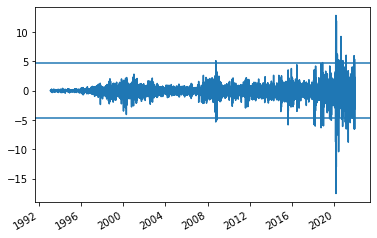

In [332]:
# Residuals using the full history starting in 1993

df_full_resid_std = seasonal_decompose(df_full).resid.std()
plt.axhline(df_full_resid_std*5)
plt.axhline(-df_full_resid_std*5)
seasonal_decompose(df_full).resid.plot()

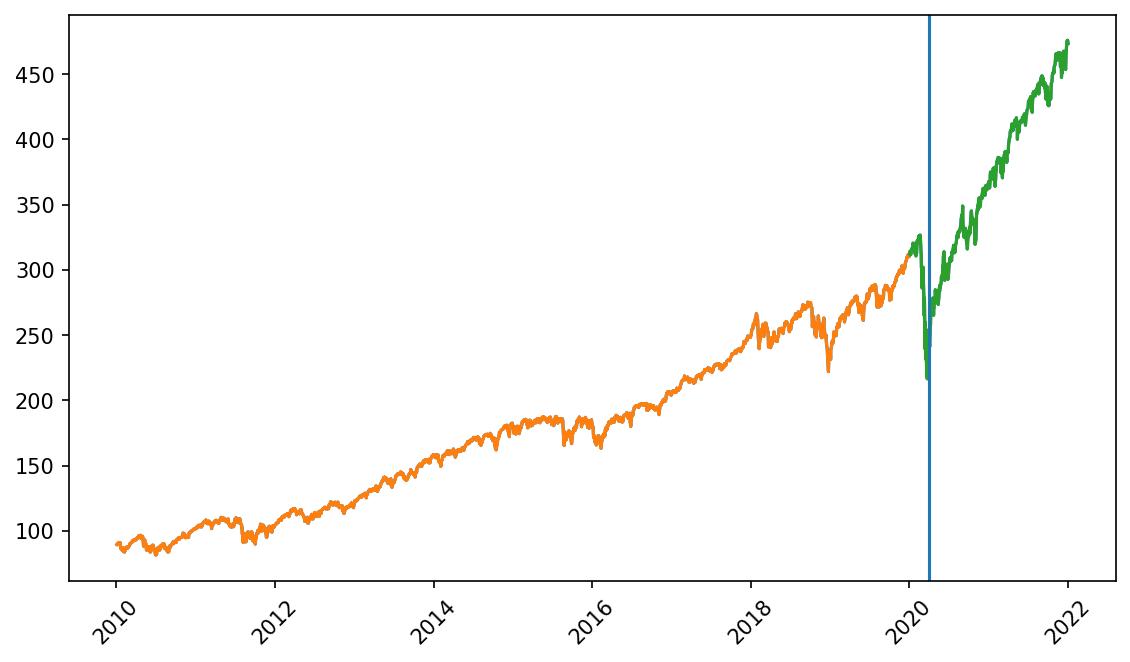

In [341]:
plt.figure(figsize=(9,5), dpi=150)
plt.plot(df)
plt.plot(df_training)
plt.plot(df_testing)
plt.xticks(rotation=45);
plt.axvline(datetime(2020,4,1))

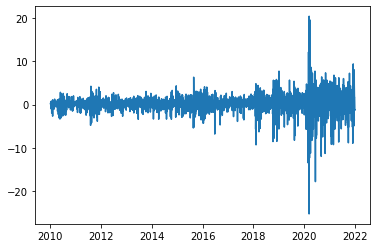

In [5]:
from statsmodels.tsa.statespace.tools import diff
# First difference
first_diff = diff(df)
plt.plot(diff(df))

In [6]:
def find_period(signal):
    acf = np.correlate(signal, signal, 'full')[-len(signal):]
    inflection = np.diff(np.sign(np.diff(acf)))
    peaks = (inflection < 0).nonzero()[0] + 1
    return peaks[acf[peaks].argmax()]

In [7]:
# data has a seasonality of 7, which coincides with the days of the week
find_period(seasonal_decompose(df).seasonal)

# should use a seasonal model, such as SARIMA

7

In [8]:
find_period(seasonal_decompose(first_diff).seasonal)

7

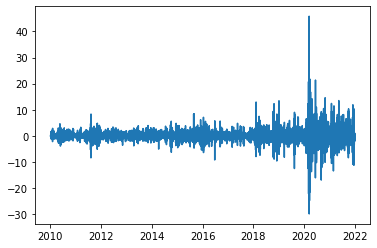

In [12]:
# second difference
second_diff = diff(first_diff)

plt.plot(second_diff)

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.arima_model import ARIMA # removed
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [10]:
# ADF test to confirm first difference is stationary
print('p value for ADF:', adfuller(first_diff)[1])

print('p value is <0.05, so the first difference is stationary.')


# or can use this method to run test automatically
# and estimate the number of differences to be taken to achieve stationarity
print('ndiffs for closing value:', ndiffs(df, test='adf'))
print('ndiffs for first difference:', ndiffs(first_diff, test='adf'))

p value for ADF: 1.5931831444190433e-26
p value is <0.05, so the first difference is stationary.
ndiffs for closing value: 1
ndiffs for first difference: 0


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


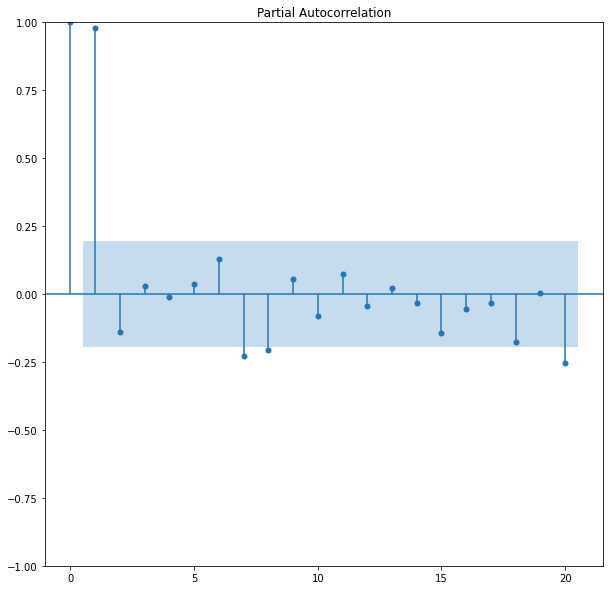

In [428]:
plot_pacf(df[:100]);

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


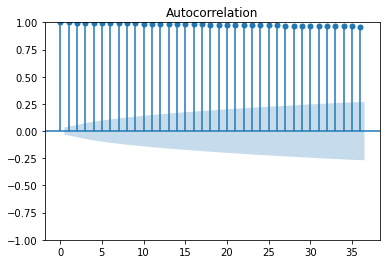

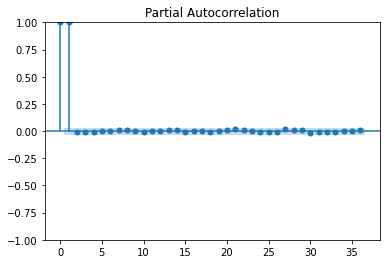

In [1375]:
# ACF tells us MA level, let's try MA(1)
plot_acf(df_training);

# PACF gives AR level, 2 is significant, so let's try AR(2)
plot_pacf(df_training);

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


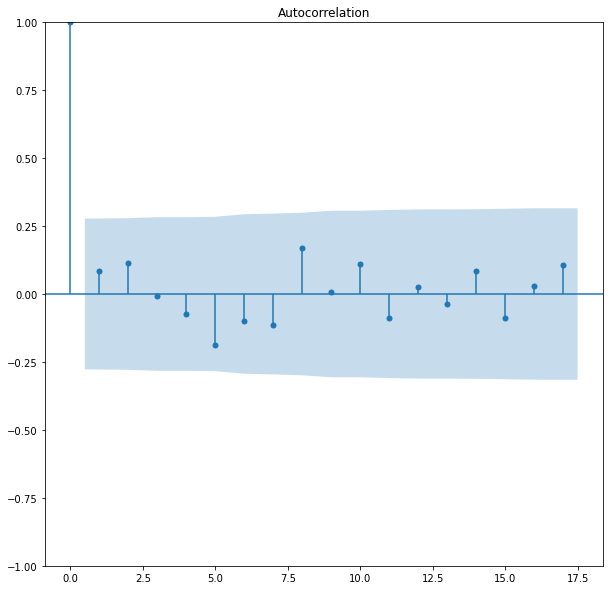

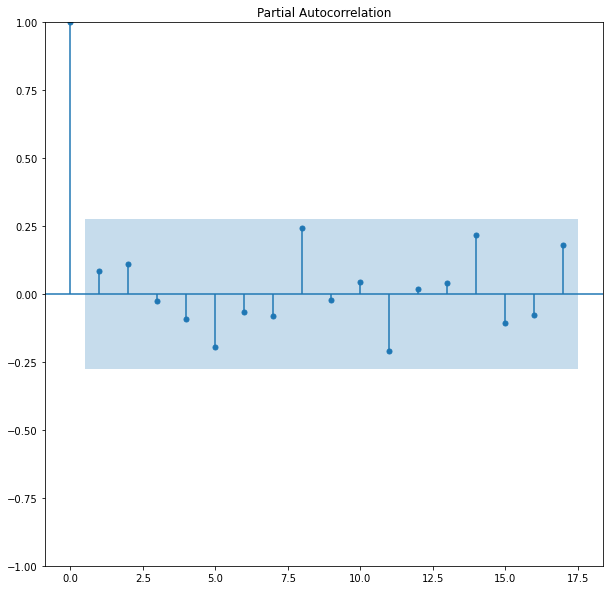

In [441]:
plot_acf(first_diff[850:900]);
#350:450
# first difference is enough

plot_pacf(first_diff[850:900]);

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


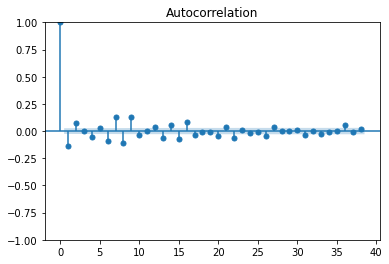

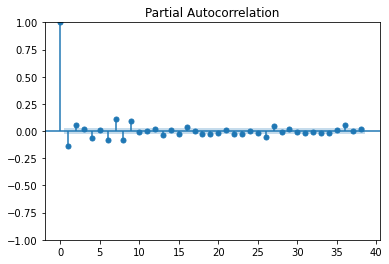

In [791]:
plot_acf(first_diff);

# first difference is enough

plot_pacf(first_diff);

In [1620]:
# if std increases, then it's overdifferenced
first_diff.std()

1.801382276450531

In [1619]:
second_diff.std()

2.5789453027892155

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


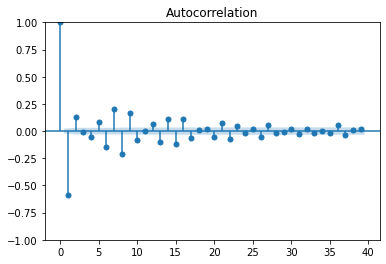

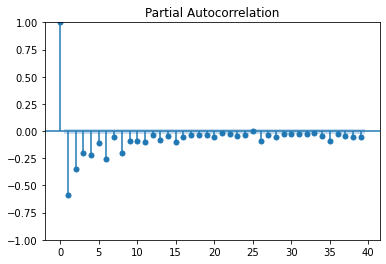

In [817]:
plot_acf(second_diff);

# first difference is enough

plot_pacf(second_diff);

In [101]:
first_diff = sm.tsa.statespace.tools.diff(df)

# fill in missing differenes with 0

idx = pd.date_range(first_diff.index[0], first_diff.index[-1])
first_diff = first_diff.reindex(idx,fill_value=0)


train_end = datetime(2020,1,1)
test_end = datetime(2021,12,31)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

In [12]:
# take 2nd difference to make this set stationary
ndiffs(df_training)

1

In [110]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
#residuals = test_data - predictions

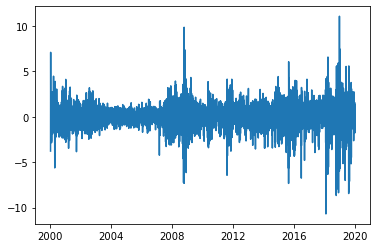

In [821]:
plt.plot(model_fit.resid)

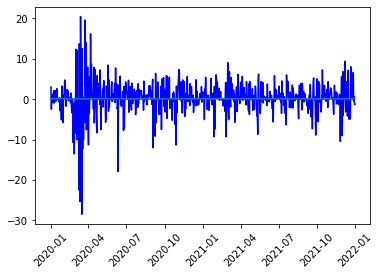

In [822]:
plt.plot(residuals, color='blue')

plt.plot(predictions)
plt.xticks(rotation=45);

In [956]:
model_fit.predict

statsmodels.tsa.arima.model.ARIMAResultsWrapper

In [1316]:
df_testing.reindex(pd.date_range(df_testing.index[0], df_testing.index[-1]), fill_value=None).interpolate()


2020-01-02    313.744507
2020-01-03    311.368805
2020-01-04    311.764740
2020-01-05    312.160675
2020-01-06    312.556610
                 ...    
2021-12-27    475.781921
2021-12-28    475.393127
2021-12-29    476.001251
2021-12-30    474.685333
2021-12-31    473.489044
Freq: D, Name: Close, Length: 730, dtype: float64

In [443]:
from pmdarima.arima import auto_arima

auto_arima(df_training, start_p=0, start_q=0, test='adf', max_p=3, max_q=3, m=1, d=None, seasonal=False,
            error_action='ignore', stepwise=True)

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

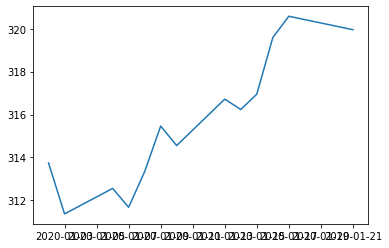

In [41]:
plt.plot(df_testing[:20])

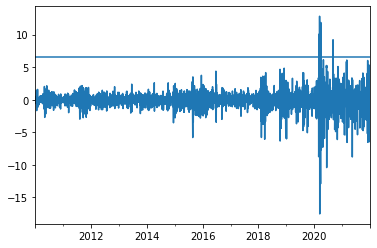

In [240]:
# outlier detection by looking at sigmas away

std_df = seasonal_decompose(df).resid.std()
plt.figure()
seasonal_decompose(df).resid.plot()
plt.axhline(std_df*5)

In [238]:
seasonal_decompose(df).resid[seasonal_decompose(df).resid > std_df*5] #outlier points

2020-03-04    10.082367
2020-03-10    12.822355
2020-03-13     7.648208
2020-03-17     7.899034
2020-03-26    11.856833
2020-09-02     9.209205
Name: resid, dtype: float64

In [92]:
# Change to run model on data, not 1st diff
def ARIMA_prediction_data(df_training, df_testing, model='a'):
    
    if model == 'a':
        # 1, 2, 1
        model = ARIMA(df_training, order=(1, 2, 1)) #For df, need to take 1st diff now
    else:
        model = SARIMAX(df_training, order=(0,1,1), seasonal_order=(0,1,1,7))

    model_fit = model.fit()
    # sigma2 parameter is the estimate of the variance of the error term associated with the time series

    print(model_fit.summary())

    # How many days forward to simulate, match to number of days in testing data
    td = df_testing.index[-1] - df_testing.index[0] # can't just len() since testing data skips some dates

    n_days = int((td / np.timedelta64(1, 'D'))) + 1

    # How many simulations to run
    n_reps = 10

    # Run n_reps MC simulations
    sim = model_fit.simulate(n_days, anchor='end', repetitions=n_reps)

    # rename column names to integers starting at 0
    sim.columns = range(0, len(sim.columns))

    pred_start_date = df_testing.index[0]
    pred_end_date = df_testing.index[-1]

    predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
    #predictions = model_fit.forecast(n_days)
    
    # reindex testing data so that every day is included, fill in missing values by linear interpolation
    #residuals = df_testing - predictions

    forecast = model_fit.forecast(steps=n_days)
    conf_index = model_fit.get_forecast(n_days).conf_int(alpha=0.05).index # alpha sets confidence interval to 95%
    lower_conf = model_fit.get_forecast(n_days).conf_int(alpha=0.05)['lower Close'].values
    upper_conf = model_fit.get_forecast(n_days).conf_int(alpha=0.05)['upper Close'].values

    plt.title('Residuals of training data')
    plt.plot(model_fit.resid)
    plt.show()
    
#     plt.title('Predictions')
#     plt.plot(predictions, lw=0.5)
#     plt.xticks(rotation=45);
#     plt.show()

    plt.figure(figsize=(6,4), dpi=150)
    plt.plot(df_training, label='Training')
    plt.plot(predictions, zorder=5)
    #plt.plot(sim, color='cornflowerblue')#, label='Predicted')
    plt.plot(df_testing, '-', lw=0.5, label='Testing')
    #plt.plot(test_data, linestyle='--', lw=0.5)
    plt.fill_between(conf_index, lower_conf, upper_conf, color='gray', alpha=0.1)
    plt.legend()
    #plt.ylim(0, 400)
    plt.show()

    return model, model_fit
    # Root Mean Square Error
    #print('RMSE:', np.sqrt(np.mean(residuals ** 2)))

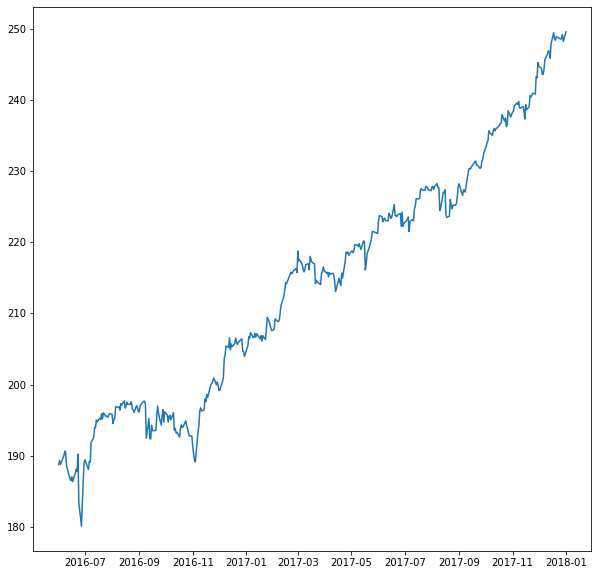

In [417]:
plt.plot(df_training['2016-6-1':'2018-1-1'])

In [699]:
import itertools


In [471]:

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [477]:
# calculate AIC values for complete training set
# my_dict = {}
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(df_training,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{}7 - AIC:{}'.format(param,param_seasonal,results.aic))
#             my_dict[results.aic] = ('ARIMA{}x{}7'.format(param,param_seasonal))
#         except: 
#             continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.63851D+00    |proj g|=  1.13305D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.133D-06   6.639D+00
  F =   6.6385117296803244     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:48449.85860320701
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.26017D+00    |proj g|=  1.24863D-02

At iterate   10    f=  6.25595D+00    |proj g|=  3.74229D-01

At iterate   15    f=  6.00474D+00    |proj g|=  3.56896D-01

At iterate   20    f=  5.95119D+00    |proj g|=  7.69953D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     36      1     0     0   1.155D-06   5.951D+00
  F =   5.9511386888847353     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:43435.4101514808
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18733D+00    |proj g|=  4.66072D-02

At iterate    5    f=  6.16274D+00    |proj g|=  4.94094D-03

At iterate   10    f=  6.15265D+00    |proj g|=  1.29188D-01

At iterate   15    f=  5.35281D+00    |proj g|=  1.47053D-01

At iterate   20    f=  5.34824D+00    |proj g|=  1.06806D-01

At iterate   25    f=  5.34605D+00    |proj g|=  7.29016D-03

At iterate   30    f=  5.34598D+00    |proj g|=  3.54780D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     57     

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   9.995D-06   2.604D+00
  F =   2.6039176133420963     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:19007.390742170617
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60032D+00    |proj g|=  5.00701D-02


 This problem is unconstrained.



At iterate    5    f=  2.59903D+00    |proj g|=  1.85600D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   8.598D-07   2.599D+00
  F =   2.5990301106073059     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 2, 7)7 - AIC:18973.72174721212
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98099D+00    |proj g|=  8.49776D-04


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   4.498D-07   2.981D+00
  F =   2.9809843820483772     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 2, 0, 7)7 - AIC:21757.224020189056
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72449D+00    |proj g|=  1.89324D-01

At iterate    5    f=  2.59879D+00    |proj g|=  1.48480D-01

At iterate   10    f=  2.59846D+00    |proj g|=  8.89639D-06

           * * 

 This problem is unconstrained.



At iterate    5    f=  2.61502D+00    |proj g|=  3.24817D-01

At iterate   10    f=  2.59077D+00    |proj g|=  1.13301D-02

At iterate   15    f=  2.59050D+00    |proj g|=  3.80595D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     24      1     0     0   5.276D-06   2.590D+00
  F =   2.5904990527108378     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 2, 2, 7)7 - AIC:18911.462086683696
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:18993.575567442902
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59953D+00    |proj g|=  5.71233D-02

At iterate    5    f=  2.59934D+00    |proj g|=  7.61709D-01


 This problem is unconstrained.



At iterate   10    f=  2.59777D+00    |proj g|=  5.74798D-02

At iterate   15    f=  2.59775D+00    |proj g|=  1.99028D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     25      1     0     0   1.148D-02   2.598D+00
  F =   2.5977492665026918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:18964.374146936643
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59499D+00    |proj g|=  7.27526D-02


 This problem is unconstrained.



At iterate    5    f=  2.59390D+00    |proj g|=  1.68291D+00

At iterate   10    f=  2.59312D+00    |proj g|=  5.95582D-03

At iterate   15    f=  2.59309D+00    |proj g|=  2.43377D-02

At iterate   20    f=  2.59309D+00    |proj g|=  1.85007D-02

At iterate   25    f=  2.59307D+00    |proj g|=  4.39893D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     50      1     0     0   1.621D-03   2.593D+00
  F =   2.5930741492911387     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 2, 7)7 - AIC:18932.25514152673
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60453D+00    |proj g|=  4.99636D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored 

 This problem is unconstrained.



At iterate   10    f=  2.60381D+00    |proj g|=  3.58414D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     18      1     0     0   2.501D-06   2.604D+00
  F =   2.6037728838419243     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:19008.334506278363
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60033D+00    |proj g|=  5.03103D-02


 This problem is unconstrained.



At iterate    5    f=  2.59905D+00    |proj g|=  1.20566D-04

At iterate   10    f=  2.59897D+00    |proj g|=  1.36078D-02

At iterate   15    f=  2.59885D+00    |proj g|=  1.03645D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   7.315D-06   2.599D+00
  F =   2.5988477156038399     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 1, 2, 7)7 - AIC:18974.390628476824
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76562D+00    |proj g|=  1.31340D-01

At iterate    5    f=  2.61626D+00    |proj g|=  1.12196D-01

At iterate   10    f=  2.59580D+00    |proj g|=  1.00725D-02

At iterate   15    f=  2.59580D+00    |proj g|=  1.57480D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     27      1     0     0   2.665D-06   2.596D+00
  F =   2.5957968359426329     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0,

 This problem is unconstrained.



At iterate    5    f=  2.59380D+00    |proj g|=  1.80349D-01

At iterate   10    f=  2.59151D+00    |proj g|=  5.53702D-04

At iterate   15    f=  2.59151D+00    |proj g|=  4.69956D-03

At iterate   20    f=  2.59095D+00    |proj g|=  2.21125D-01

At iterate   25    f=  2.58996D+00    |proj g|=  1.69961D-02

At iterate   30    f=  2.58994D+00    |proj g|=  9.33047D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     43      1     0     0   9.330D-04   2.590D+00
  F =   2.5899393814310612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 2, 2, 7)7 - AIC:18909.3776056838

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     15      1     0     0   1.592D-02   2.594D+00
  F =   2.5944927318817386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(2, 0, 0, 7)7 - AIC:18940.60795727293
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59611D+00    |proj g|=  9.49941D-02


 This problem is unconstrained.



At iterate    5    f=  2.59500D+00    |proj g|=  1.26375D+00

At iterate   10    f=  2.59456D+00    |proj g|=  1.00975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     15      1     0     0   1.010D-03   2.595D+00
  F =   2.5945642795174519     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(2, 0, 1, 7)7 - AIC:18943.130111918363
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59518D+00    |proj g|=  1.46163D-01


 This problem is unconstrained.



At iterate    5    f=  2.59514D+00    |proj g|=  3.34470D-01

At iterate   10    f=  2.59361D+00    |proj g|=  1.23525D+00

At iterate   15    f=  2.59336D+00    |proj g|=  8.18607D-03

At iterate   20    f=  2.59332D+00    |proj g|=  1.50379D-03

At iterate   25    f=  2.59331D+00    |proj g|=  2.04934D-02

At iterate   30    f=  2.59330D+00    |proj g|=  1.28868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     34      1     0     0   1.289D-03   2.593D+00
  F =   2.5933021099337838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(2, 0, 2, 7)7 - AIC:18935.9187982967

 This problem is unconstrained.


ARIMA(0, 0, 0)x(2, 1, 0, 7)7 - AIC:18979.597881174028
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60076D+00    |proj g|=  4.28908D-02


 This problem is unconstrained.



At iterate    5    f=  2.59984D+00    |proj g|=  2.93482D-03

At iterate   10    f=  2.59966D+00    |proj g|=  1.84618D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   5.939D-06   2.600D+00
  F =   2.5996612784352431     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(2, 1, 1, 7)7 - AIC:18980.328010020403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60037D+00    |proj g|=  5.06218D-02


 This problem is unconstrained.



At iterate    5    f=  2.59906D+00    |proj g|=  8.46215D-03

At iterate   10    f=  2.59864D+00    |proj g|=  9.37371D-03

At iterate   15    f=  2.59858D+00    |proj g|=  4.58940D-04

At iterate   20    f=  2.59856D+00    |proj g|=  8.14736D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   1.381D-05   2.599D+00
  F =   2.5985578146620822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(2, 1, 2, 7)7 - AIC:18974.274931403877
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.


ARIMA(0, 0, 0)x(2, 2, 0, 7)7 - AIC:20093.989426163942
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74458D+00    |proj g|=  6.49946D-02


 This problem is unconstrained.



At iterate    5    f=  2.60546D+00    |proj g|=  6.43223D-02

At iterate   10    f=  2.59161D+00    |proj g|=  8.75942D-04

At iterate   15    f=  2.59161D+00    |proj g|=  2.25545D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     27      1     0     0   2.255D-05   2.592D+00
  F =   2.5916106658169440     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(2, 2, 1, 7)7 - AIC:18921.574639132057
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  2.60021D+00    |proj g|=  4.68899D-02

At iterate   10    f=  2.59101D+00    |proj g|=  3.52123D-03

At iterate   15    f=  2.59101D+00    |proj g|=  1.39298D-03

At iterate   20    f=  2.59098D+00    |proj g|=  9.43692D-03

At iterate   25    f=  2.59095D+00    |proj g|=  1.46872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     35      1     0     0   2.239D-05   2.591D+00
  F =   2.5909468584796116     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(2, 2, 2, 7)7 - AIC:18918.730173184205
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate   10    f=  6.26387D+00    |proj g|=  6.32258D-02

At iterate   15    f=  6.25653D+00    |proj g|=  1.85129D-01

At iterate   20    f=  5.95289D+00    |proj g|=  2.07817D-01

At iterate   25    f=  5.94957D+00    |proj g|=  2.55780D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     28     48      1     0     0   6.778D-07   5.950D+00
  F =   5.9495702161869968     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:43423.9634377327
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0   

 This problem is unconstrained.



At iterate    5    f=  6.18939D+00    |proj g|=  2.31348D-01

At iterate   10    f=  6.17973D+00    |proj g|=  8.05575D-02

At iterate   15    f=  6.17892D+00    |proj g|=  3.19130D-02

At iterate   20    f=  5.61986D+00    |proj g|=  6.16721D-01

At iterate   25    f=  5.33333D+00    |proj g|=  1.96440D-01

At iterate   30    f=  5.32798D+00    |proj g|=  2.03236D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     53      1     0     0   2.581D-05   5.328D+00
  F =   5.3279661400119842     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:38889.4968898074

 This problem is unconstrained.



At iterate    5    f=  6.13164D+00    |proj g|=  1.27684D-02

At iterate   10    f=  6.12581D+00    |proj g|=  2.83661D-02

At iterate   15    f=  6.11115D+00    |proj g|=  3.64309D-02

At iterate   20    f=  5.97451D+00    |proj g|=  1.52409D-01

At iterate   25    f=  5.78586D+00    |proj g|=  4.23814D-01

At iterate   30    f=  4.80423D+00    |proj g|=  3.52920D-01

At iterate   35    f=  4.79827D+00    |proj g|=  5.96676D-02

At iterate   40    f=  4.79813D+00    |proj g|=  1.11639D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     98      1     0     0   3.061D-05   4.798D+00
  F =   4.79813436052

 This problem is unconstrained.



At iterate   10    f=  2.22624D+00    |proj g|=  9.90402D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     14      1     0     0   5.007D-07   2.226D+00
  F =   2.2262410323833999     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:16251.107054334054
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76695D+00    |proj g|=  2.54237D+02


 This problem is unconstrained.



At iterate    5    f=  2.23597D+00    |proj g|=  2.34569D-01

At iterate   10    f=  2.20343D+00    |proj g|=  4.11222D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   7.346D-07   2.203D+00
  F =   2.2034297751767449     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:16086.630499239884
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.84017D+00    |proj g|=  2.62301D+02


 This problem is unconstrained.



At iterate    5    f=  2.23252D+00    |proj g|=  2.63134D-01

At iterate   10    f=  2.19924D+00    |proj g|=  1.55302D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   1.691D-06   2.199D+00
  F =   2.1992371059726041     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 2, 7)7 - AIC:16058.032399388067
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39105D+00    |proj g|=  1.76655D+01

At iterate    5

 This problem is unconstrained.



At iterate   10    f=  2.64835D+00    |proj g|=  8.90357D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     14      1     0     0   1.482D-06   2.648D+00
  F =   2.6483455240911349     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 2, 0, 7)7 - AIC:19331.6256348171
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71524D+00    |proj g|=  5.69703D+00


 This problem is unconstrained.



At iterate    5    f=  2.41432D+00    |proj g|=  1.66305D-01

At iterate   10    f=  2.22184D+00    |proj g|=  1.35532D-01

At iterate   15    f=  2.21800D+00    |proj g|=  4.28658D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     21      1     0     0   3.650D-05   2.218D+00
  F =   2.2180041200311682     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 2, 1, 7)7 - AIC:16192.994067987465
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  2.42005D+00    |proj g|=  1.68988D-01

At iterate   10    f=  2.19660D+00    |proj g|=  8.06883D-02

At iterate   15    f=  2.19141D+00    |proj g|=  1.58734D-02

At iterate   20    f=  2.19137D+00    |proj g|=  5.90463D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   5.468D-05   2.191D+00
  F =   2.1913673386863661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 2, 2, 7)7 - AIC:16000.5988377331
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0   

 This problem is unconstrained.



At iterate    5    f=  6.05186D+00    |proj g|=  1.56973D-01

At iterate   10    f=  3.92274D+00    |proj g|=  5.76446D+00
  ys=-1.094E+00  -gs= 9.829E-01 BFGS update SKIPPED

At iterate   15    f=  2.22232D+00    |proj g|=  3.39608D-01

At iterate   20    f=  2.22123D+00    |proj g|=  4.77442D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     67      1     1     0   4.774D-04   2.221D+00
  F =   2.2212273842039365     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:16216.517449920328
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14024D+00    |proj g|=  9.24569D-01

At iterate    5    f=  6.03734D+00    |proj g|=  1.13666D-01

At iterate   10    f=  5.97994D+00    |proj g|=  8.40281D-02

At iterate   15    f=  5.20106D+00    |proj g|=  1.50303D+00

At iterate   20    f=  4.65740D+00    |proj g|=  9.93785D+00

At iterate   25    f=  3.05051D+00    |proj g|=  2.83890D+00

At iterate   30    f=  2.43356D+00    |proj g|=  8.17878D+00

At iterate   35    f=  2.19881D+00    |proj g|=  4.44846D+00

At iterate   40    f=  2.19610D+00    |proj g|=  1.25069D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     96      1     0     0   3.282D-03   2.196D+00
  F =   2.1961046097898778     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:16035.171442246528
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.12848D+00    |proj g|=  9.19695D-01

At iterate    5    f=  6.01608D+00    |proj g|=  6.38528D-02
  ys=-1.808E-02  -gs= 6.866E-02 BFGS update SKIPPED

At iterate   10    f=  5.

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  2.23607D+00    |proj g|=  1.72241D-01

At iterate   10    f=  2.20494D+00    |proj g|=  4.22455D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   6.630D-06   2.205D+00
  F =   2.2049445513019643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:16097.685335401735
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.75976D+00    |proj g|=  2.53416D+02


 This problem is unconstrained.



At iterate    5    f=  2.23547D+00    |proj g|=  2.44347D-01

At iterate   10    f=  2.20366D+00    |proj g|=  2.04533D-03

At iterate   15    f=  2.20343D+00    |proj g|=  9.00742D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   1.306D-05   2.203D+00
  F =   2.2034249076913768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:16088.594976331668
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  2.23186D+00    |proj g|=  2.74715D-01

At iterate   10    f=  2.19921D+00    |proj g|=  2.42116D-03

At iterate   15    f=  2.19921D+00    |proj g|=  5.00051D-04

At iterate   20    f=  2.19919D+00    |proj g|=  4.92200D-03

At iterate   25    f=  2.19917D+00    |proj g|=  1.42932D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   1.656D-05   2.199D+00
  F =   2.1991713819854422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 1, 2, 7)7 - AIC:16059.552745729758
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  2.49054D+00    |proj g|=  2.58917D-01

At iterate   10    f=  2.44283D+00    |proj g|=  8.91241D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     17      1     0     0   2.448D-06   2.443D+00
  F =   2.4428267346941337     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 2, 0, 7)7 - AIC:17833.749509797788


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66342D+00    |proj g|=  3.32396D+00

At iterate    5    f=  2.41163D+00    |proj g|=  6.16035D-01

At iterate   10    f=  2.23579D+00    |proj g|=  1.92235D-01

At iterate   15    f=  2.19779D+00    |proj g|=  6.04896D-02

At iterate   20    f=  2.19708D+00    |proj g|=  9.22306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   6.224D-06   2.197D+00
  F =   2.1970822156793206     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  2.37097D+00    |proj g|=  1.02993D+00

At iterate   10    f=  2.20043D+00    |proj g|=  7.09409D-02

At iterate   15    f=  2.19839D+00    |proj g|=  6.70648D-02

At iterate   20    f=  2.19168D+00    |proj g|=  1.93777D-02

At iterate   25    f=  2.19163D+00    |proj g|=  5.20785D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     34      1     0     0   1.904D-05   2.192D+00
  F =   2.1916319799984159     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 2, 2, 7)7 - AIC:16004.53019002844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  3.94386D+00    |proj g|=  3.87815D+00
  ys=-7.085E+00  -gs= 9.177E-01 BFGS update SKIPPED

At iterate   10    f=  2.28056D+00    |proj g|=  7.27513D+00

At iterate   15    f=  2.20276D+00    |proj g|=  9.05424D-01

At iterate   20    f=  2.20175D+00    |proj g|=  3.22260D-01

At iterate   25    f=  2.19835D+00    |proj g|=  2.21848D+00

At iterate   30    f=  2.19562D+00    |proj g|=  7.11093D-02

At iterate   35    f=  2.19549D+00    |proj g|=  1.10936D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     80      1     1     0   1.109D-02   2.195D+00
  F =   2.1954882531608058     

 This problem is unconstrained.



At iterate    5    f=  6.01826D+00    |proj g|=  2.21632D-01

At iterate   10    f=  5.91150D+00    |proj g|=  7.19263D-01

At iterate   15    f=  3.65188D+00    |proj g|=  6.04561D+00

At iterate   20    f=  2.31212D+00    |proj g|=  7.67919D-01

At iterate   25    f=  2.19413D+00    |proj g|=  2.20181D-01

At iterate   30    f=  2.19327D+00    |proj g|=  2.01703D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     74      1     0     0   2.017D-04   2.193D+00
  F =   2.1932678423059451     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(2, 0, 1, 7)7 - AIC:16016.4687131487

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.12851D+00    |proj g|=  9.19166D-01
  ys=-2.451E-03  -gs= 7.114E-02 BFGS update SKIPPED

At iterate    5    f=  5.99861D+00    |proj g|=  5.40995D-01

At iterate   10    f=  5.88253D+00    |proj g|=  1.18899D-01

At iterate   15    f=  5.17095D+00    |proj g|=  2.33655D+01

At iterate   20    f=  4.42241D+00    |proj g|=  1.77564D+00

At iterate   25    f=  3.72069D+00    |proj g|=  2.48801D+00

At iterate   30    f=  3.02965D+00    |proj g|=  1.56639D+01

At iterate   35    f=  2.97300D+00    |proj g|=  1.97022D+00

At iterate   40    f=  2.94202D+00    |proj g|=  9.83946D+00

At iterate   45    f=  2.86992D+00    |proj g|=  8.37107D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.72592D+00    |proj g|=  1.99026D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    127      1     1     0   1.990D+01   2.726D+00
  F =   2.7259239782432010     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 0, 1)x(2, 0, 2, 7)7 - AIC:19905.79319321888
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.58739D+00    |proj g|=  2.36674D+02


 This problem is unconstrained.



At iterate    5    f=  2.23228D+00    |proj g|=  1.83770D-01

At iterate   10    f=  2.20101D+00    |proj g|=  1.63827D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     59      2     0     0   6.204D-05   2.201D+00
  F =   2.2009833274278523     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 1)x(2, 1, 0, 7)7 - AIC:16070.776323568465
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.79982D+00    |proj g|=  2.58080D+02


 This problem is unconstrained.



At iterate    5    f=  2.23302D+00    |proj g|=  2.60584D-01

At iterate   10    f=  2.20076D+00    |proj g|=  2.21037D-03

At iterate   15    f=  2.20073D+00    |proj g|=  5.42541D-03

At iterate   20    f=  2.20051D+00    |proj g|=  1.53224D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     32      1     0     0   6.072D-05   2.201D+00
  F =   2.2005143257171049     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(2, 1, 1, 7)7 - AIC:16069.353549083433
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.23236D+00    |proj g|=  2.87167D-01

At iterate   10    f=  2.19924D+00    |proj g|=  3.74133D-03

At iterate   15    f=  2.19890D+00    |proj g|=  2.86892D-03

At iterate   20    f=  2.19889D+00    |proj g|=  1.69109D-03

At iterate   25    f=  2.19886D+00    |proj g|=  1.81455D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     33      1     0     0   1.334D-05   2.199D+00
  F =   2.1988566716248670     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(2, 1, 2, 7)7 - AIC:16059.255989518279
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  2.43009D+00    |proj g|=  3.03631D-01

At iterate   10    f=  2.36655D+00    |proj g|=  1.25887D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     19      1     0     0   1.916D-06   2.367D+00
  F =   2.3665209238244160     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(2, 2, 0, 7)7 - AIC:17278.869702070588
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71744D+00    |proj g|=  5.59160D+00


 This problem is unconstrained.



At iterate    5    f=  2.41586D+00    |proj g|=  6.38283D-01

At iterate   10    f=  2.20493D+00    |proj g|=  1.31771D-01

At iterate   15    f=  2.19359D+00    |proj g|=  2.79711D-03

At iterate   20    f=  2.19358D+00    |proj g|=  5.01624D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     32      1     0     0   4.122D-05   2.194D+00
  F =   2.1935791633929669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(2, 2, 1, 7)7 - AIC:16018.740734441872
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.38719D+00    |proj g|=  5.82617D-01

At iterate   10    f=  2.20336D+00    |proj g|=  1.71838D-01

At iterate   15    f=  2.19323D+00    |proj g|=  6.56134D-03

At iterate   20    f=  2.19318D+00    |proj g|=  1.02919D-03

At iterate   25    f=  2.19309D+00    |proj g|=  9.11745D-03
  ys=-3.794E-04  -gs= 2.926E-04 BFGS update SKIPPED

At iterate   30    f=  2.19189D+00    |proj g|=  3.07016D-02

At iterate   35    f=  2.19163D+00    |proj g|=  8.46612D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     61      1     1     0   2.495D-04   2.192D+00
  F =   2.1916309829776668     

 This problem is unconstrained.



At iterate    5    f=  6.17618D+00    |proj g|=  2.18268D-02

At iterate   10    f=  6.16994D+00    |proj g|=  2.04084D-02

At iterate   15    f=  6.16601D+00    |proj g|=  7.45205D-02

At iterate   20    f=  6.08829D+00    |proj g|=  8.09939D-02

At iterate   25    f=  5.31075D+00    |proj g|=  3.07735D-01

At iterate   30    f=  5.29876D+00    |proj g|=  2.95578D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f=  5.29739D+00    |proj g|=  2.42020D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35    102      1     0     0   2.420D-04   5.297D+00
  F =   5.2973944779497666     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 2)x(0, 0, 0, 7)7 - AIC:38666.3849000774
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20362D+00    |proj g|=  9.21107D-01

At iterate    5    f=  6.13713D+00    |proj g|=  9.82523D-03

At iterate   10  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18502D+00    |proj g|=  9.08873D-01

At iterate    5    f=  6.11492D+00    |proj g|=  5.34431D-03

At iterate   10    f=  6.10103D+00    |proj g|=  6.24915D-02

At iterate   15    f=  5.90805D+00    |proj g|=  3.19902D-01
  ys=-2.851E-02  -gs= 3.410E-02 BFGS update SKIPPED
  ys=-5.735E-01  -gs= 1.491E+00 BFGS update SKIPPED

At iterate   20    f=  4.79262D+00    |proj g|=  8.31663D-01

At iterate   25    f=  4.56625D+00    |proj g|=  8.80159D-02

At iterate   30    f=  4.55046D+00    |proj g|=  1.43179D-02

At iterate   35    f=  4.55042D+00    |proj g|=  2.99998D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bound

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48556D+00    |proj g|=  3.32540D+00

At iterate    5    f=  2.09054D+00    |proj g|=  1.03802D-01

At iterate   10    f=  2.06716D+00    |proj g|=  6.50622D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     14      1     0     0   4.083D-06   2.067D+00
  F =   2.0671326272187498     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2)x(0, 1, 0, 7)7 - AIC:15091.933913442437
RUNNING THE L-BF

 This problem is unconstrained.



At iterate    5    f=  2.03278D+00    |proj g|=  1.14742D-01

At iterate   10    f=  2.01322D+00    |proj g|=  1.04629D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   4.246D-06   2.013D+00
  F =   2.0132198810381419     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2)x(0, 1, 1, 7)7 - AIC:14700.47869181636


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46963D+00    |proj g|=  3.26286D+00

At iterate    5    f=  2.02460D+00    |proj g|=  1.11043D-01

At iterate   10    f=  2.00967D+00    |proj g|=  2.13347D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   4.570D-06   2.010D+00
  F =   2.0096711534681457     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2)x(0, 1, 2, 7)7 - AIC:14676.580078010527
RUNNING THE L-BF

 This problem is unconstrained.



At iterate    5    f=  2.52901D+00    |proj g|=  1.61055D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   9.280D-06   2.529D+00
  F =   2.5288811899413020     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2)x(0, 2, 0, 7)7 - AIC:18461.77492419162
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42676D+00    |proj g|=  3.23939D-01


 This problem is unconstrained.



At iterate    5    f=  2.10598D+00    |proj g|=  4.63764D-01

At iterate   10    f=  2.06212D+00    |proj g|=  3.62159D-02

At iterate   15    f=  2.06144D+00    |proj g|=  1.91774D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     21      1     0     0   1.918D-05   2.061D+00
  F =   2.0614446038859571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 2)x(0, 2, 1, 7)7 - AIC:15052.422719159715
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  2.11836D+00    |proj g|=  4.34929D-01

At iterate   10    f=  2.00268D+00    |proj g|=  3.24334D-02

At iterate   15    f=  2.00232D+00    |proj g|=  3.82660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     31      1     0     0   3.802D-05   2.002D+00
  F =   2.0023163635732724     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 2)x(0, 2, 2, 7)7 - AIC:14622.90482135774
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  6.12029D+00    |proj g|=  3.13256D-02

At iterate   10    f=  6.11042D+00    |proj g|=  1.46745D-01

At iterate   15    f=  5.82043D+00    |proj g|=  5.00930D-01
  ys=-1.694E-01  -gs= 2.162E-01 BFGS update SKIPPED

At iterate   20    f=  4.00818D+00    |proj g|=  2.36027D+01

At iterate   25    f=  3.02532D+00    |proj g|=  1.32917D+01

At iterate   30    f=  2.18908D+00    |proj g|=  6.17553D+00

At iterate   35    f=  2.09881D+00    |proj g|=  3.42677D-02

At iterate   40    f=  2.09407D+00    |proj g|=  7.32015D+00

At iterate   45    f=  2.06545D+00    |proj g|=  8.85263D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  2.06483D+00    |proj g|=  4.19576D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50    110      1     1     0   4.196D-04   2.065D+00
  F =   2.0648302745833536     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 0, 2)x(1, 0, 0, 7)7 - AIC:15077.131343909314
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18728D+00    |proj g|=  9.29991D-01

At iterate    5    f=  6.11342D+00    |proj g|=  5.44173D-03

At iterate   10

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  6.10589D+00    |proj g|=  2.90576D-02

At iterate   10    f=  6.09590D+00    |proj g|=  1.54625D-02

At iterate   15    f=  6.06944D+00    |proj g|=  8.73174D-03

At iterate   20    f=  6.01289D+00    |proj g|=  5.88275D-02

At iterate   25    f=  5.94240D+00    |proj g|=  5.24156D-01

At iterate   30    f=  4.12562D+00    |proj g|=  1.18122D+01
  ys=-4.059E+01  -gs= 7.975E-01 BFGS update SKIPPED

At iterate   35    f=  2.16923D+00    |proj g|=  7.17401D+00

At iterate   40    f=  2.09068D+00    |proj g|=  2.60847D+00

At iterate   45    f=  2.08555D+00    |proj g|=  4.43610D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.08449D+00    |proj g|=  1.21514D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    146      1     1     0   1.215D-01   2.084D+00
  F =   2.0844918865463420     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 0, 2)x(1, 0, 2, 7)7 - AIC:15224.621788015203
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44185D+00    |proj g|=  3.08754D+00


 This problem is unconstrained.



At iterate    5    f=  2.04252D+00    |proj g|=  1.11064D-01

At iterate   10    f=  2.02006D+00    |proj g|=  4.97611D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   8.436D-06   2.020D+00
  F =   2.0200606392281748     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2)x(1, 1, 0, 7)7 - AIC:14750.40254508722
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46714D+00    |proj g|=  3.24432D+00


 This problem is unconstrained.



At iterate    5    f=  2.03746D+00    |proj g|=  1.20247D-01

At iterate   10    f=  2.01488D+00    |proj g|=  1.16710D-02

At iterate   15    f=  2.01326D+00    |proj g|=  2.40864D-03

At iterate   20    f=  2.01322D+00    |proj g|=  8.74030D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     35      1     0     0   2.403D-06   2.013D+00
  F =   2.0132198213157348     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2)x(1, 1, 1, 7)7 - AIC:14702.478255962233
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.02960D+00    |proj g|=  1.15325D-01

At iterate   10    f=  2.00968D+00    |proj g|=  3.83397D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     15      1     0     0   3.114D-05   2.010D+00
  F =   2.0096667281910148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 2)x(1, 1, 2, 7)7 - AIC:14678.547782338026
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48912D+00    |proj g|=  4.29930D-01


 This problem is unconstrained.



At iterate    5    f=  2.29660D+00    |proj g|=  1.10291D-01

At iterate   10    f=  2.29401D+00    |proj g|=  1.70840D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   2.696D-07   2.294D+00
  F =   2.2940111702799890     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2)x(1, 2, 0, 7)7 - AIC:16749.69352070336
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43940D+00    |proj g|=  3.08139D-01


 This problem is unconstrained.



At iterate    5    f=  2.02462D+00    |proj g|=  3.66559D-01

At iterate   10    f=  2.01381D+00    |proj g|=  1.53418D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     20      1     0     0   1.973D-05   2.014D+00
  F =   2.0138070269729473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 2)x(1, 2, 1, 7)7 - AIC:14706.76368284857
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40416D+00    |proj g|=  2.85651D-01


 This problem is unconstrained.



At iterate    5    f=  2.11621D+00    |proj g|=  3.76830D-01

At iterate   10    f=  2.02676D+00    |proj g|=  3.72133D-02

At iterate   15    f=  2.00361D+00    |proj g|=  1.35365D-01

At iterate   20    f=  2.00236D+00    |proj g|=  3.22670D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     45      1     0     0   3.046D-05   2.002D+00
  F =   2.0023571199150152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 2)x(1, 2, 2, 7)7 - AIC:14625.202261139782
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18047D+00    |proj g|=  9.29086D-01


 This problem is unconstrained.



At iterate    5    f=  6.10595D+00    |proj g|=  6.88336D-03

At iterate   10    f=  6.10133D+00    |proj g|=  3.68996D-01

At iterate   15    f=  5.90012D+00    |proj g|=  1.37197D+00

At iterate   20    f=  4.37623D+00    |proj g|=  6.07635D+00

At iterate   25    f=  2.87663D+00    |proj g|=  4.29379D+00

At iterate   30    f=  2.36495D+00    |proj g|=  8.58550D-01

At iterate   35    f=  2.13594D+00    |proj g|=  2.02591D+00

At iterate   40    f=  2.09439D+00    |proj g|=  5.63373D-01

At iterate   45    f=  2.07080D+00    |proj g|=  2.46485D-01

At iterate   50    f=  2.06822D+00    |proj g|=  1.22224D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


ARIMA(0, 0, 2)x(2, 0, 0, 7)7 - AIC:15103.881223037903
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18049D+00    |proj g|=  9.28834D-01

At iterate    5    f=  6.10517D+00    |proj g|=  8.28855D-03

At iterate   10    f=  6.09155D+00    |proj g|=  9.11024D-01

At iterate   15    f=  5.79969D+00    |proj g|=  7.35435D-01

At iterate   20    f=  3.71933D+00    |proj g|=  5.33013D+00

At iterate   25    f=  3.02661D+00    |proj g|=  2.75600D+00

At iterate   30    f=  2.47776D+00    |proj g|=  3.25801D+00

At iterate   35    f=  2.08916D+00    |proj g|=  4.79422D-01

At iterate   40    f=  2.08382D+00    |proj g|=  1.45696D-02

At iterate   45    f=  2.08270D+00    |proj g|=  1.83610D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  2.07032D+00    |proj g|=  1.42570D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    108      1     0     0   1.426D-01   2.070D+00
  F =   2.0703178848902479     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 0, 2)x(2, 0, 1, 7)7 - AIC:15121.17992392903
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.17538D+00    |proj g|=  9.28181D-01

At iterate    5    f=  6.10094D+00    |proj g|=  5.95043D-03

At iterate   10 

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.25559D+00    |proj g|=  2.88154D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    132      1     0     0   2.882D-01   2.256D+00
  F =   2.2555895112786626     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 0, 2)x(2, 0, 2, 7)7 - AIC:16475.29225331168
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43824D+00    |proj g|=  3.07191D+00


 This problem is unconstrained.



At iterate    5    f=  2.03351D+00    |proj g|=  1.13365D-01

At iterate   10    f=  2.01251D+00    |proj g|=  1.28219D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     14      1     0     0   2.085D-05   2.013D+00
  F =   2.0125098260827095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 2)x(2, 1, 0, 7)7 - AIC:14697.296710751612
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46592D+00    |proj g|=  3.22995D+00


 This problem is unconstrained.



At iterate    5    f=  2.03204D+00    |proj g|=  1.15475D-01

At iterate   10    f=  2.01203D+00    |proj g|=  3.34006D-03

At iterate   15    f=  2.01177D+00    |proj g|=  1.65470D-02

At iterate   20    f=  2.01133D+00    |proj g|=  2.39586D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     28      1     0     0   1.468D-05   2.011D+00
  F =   2.0113306434122431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 2)x(2, 1, 1, 7)7 - AIC:14690.69103562255
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  2.02898D+00    |proj g|=  1.13437D-01

At iterate   10    f=  2.00975D+00    |proj g|=  4.79666D-03

At iterate   15    f=  2.00953D+00    |proj g|=  4.37789D-03

At iterate   20    f=  2.00952D+00    |proj g|=  3.29793D-04

At iterate   25    f=  2.00950D+00    |proj g|=  2.45199D-03

At iterate   30    f=  2.00949D+00    |proj g|=  2.70906D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     33      1     0     0   1.938D-05   2.009D+00
  F =   2.0094852564997194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 2)x(2, 1, 2, 7)7 - AIC:14679.2234019349

 This problem is unconstrained.



At iterate    5    f=  2.20067D+00    |proj g|=  3.85550D-02

At iterate   10    f=  2.19910D+00    |proj g|=  1.59069D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     16      1     0     0   8.207D-06   2.199D+00
  F =   2.1990959648277921     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2)x(2, 2, 0, 7)7 - AIC:16059.002351313226
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43256D+00    |proj g|=  2.85981D-01


 This problem is unconstrained.



At iterate    5    f=  2.04981D+00    |proj g|=  1.93305D-01

At iterate   10    f=  2.00730D+00    |proj g|=  2.72396D-02

At iterate   15    f=  2.00664D+00    |proj g|=  3.13935D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     24      1     0     0   1.523D-06   2.007D+00
  F =   2.0066353646406769     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2)x(2, 2, 1, 7)7 - AIC:14656.424891147659
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  2.02735D+00    |proj g|=  2.25402D-01

At iterate   10    f=  2.00836D+00    |proj g|=  3.68079D-02

At iterate   15    f=  2.00754D+00    |proj g|=  8.68356D-03

At iterate   20    f=  2.00688D+00    |proj g|=  1.34921D-01

At iterate   25    f=  2.00298D+00    |proj g|=  4.31207D-02

At iterate   30    f=  2.00238D+00    |proj g|=  2.08093D-02

At iterate   35    f=  2.00236D+00    |proj g|=  2.05917D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     54      1     0     0   6.906D-05   2.002D+00
  F =   2.0023568593788088     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:11556.707771890597
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58034D+00    |proj g|=  4.87077D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   4.106D-06   1.580D+00
  F =   1.5803227890493741     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


ARIMA(0, 1, 0)x(0, 0, 2, 7)7 - AIC:11539.195714482332
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95204D+00    |proj g|=  1.37401D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.372D-06   1.952D+00
  F =   1.9520358267106881     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 0, 7)7 - AIC:14247.957463334602
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.58482D+00    |proj g|=  4.14040D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     12      1     0     0   9.421D-06   1.585D+00
  F =   1.5848190402928912     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 1, 7)7 - AIC:11570.00935605752
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62700D+00    |proj g|=  2.46719D-01


 This problem is unconstrained.



At iterate    5    f=  1.58175D+00    |proj g|=  1.72327D-02

At iterate   10    f=  1.58132D+00    |proj g|=  1.88238D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     16      1     0     0   1.882D-06   1.581D+00
  F =   1.5813210239777122     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 2, 7)7 - AIC:11546.480832989344
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50770D+00    |proj g|=  1.41176D-03

           * * 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.95142D+00    |proj g|=  1.35592D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     20      1     0     0   6.322D-05   1.951D+00
  F =   1.9514241791446145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(0, 2, 1, 7)7 - AIC:14245.493659397396
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80063D+00    |proj g|=  4.39562D-01


 This problem is unconstrained.



At iterate    5    f=  1.65007D+00    |proj g|=  1.50114D+00

At iterate   10    f=  1.63038D+00    |proj g|=  1.76357D+00

At iterate   15    f=  1.59466D+00    |proj g|=  3.63526D+00

At iterate   20    f=  1.59366D+00    |proj g|=  2.50557D+00

At iterate   25    f=  1.59275D+00    |proj g|=  1.10461D+00

At iterate   30    f=  1.59274D+00    |proj g|=  1.41903D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     71      1     0     0   1.419D-01   1.593D+00
  F =   1.5927421096508634     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(0, 2, 2, 7)7 - AIC:11629.831916232


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.58290D+00    |proj g|=  7.52628D-03

At iterate   10    f=  1.58269D+00    |proj g|=  8.56592D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   3.692D-06   1.583D+00
  F =   1.5826849827292906     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 0, 1, 7)7 - AIC:11556.435003958362
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58034D+00    |proj g|=  4.53591D-03


 This problem is unconstrained.



At iterate    5    f=  1.58033D+00    |proj g|=  3.73284D-04

At iterate   10    f=  1.58031D+00    |proj g|=  2.01393D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   6.634D-06   1.580D+00
  F =   1.5803016846159021     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 0, 2, 7)7 - AIC:11541.041694326854
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78095D+00    |proj g|=  6.71161D-06

           * * 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65821D+00    |proj g|=  2.35284D-01

At iterate    5    f=  1.58452D+00    |proj g|=  3.79895D-02

At iterate   10    f=  1.58429D+00    |proj g|=  9.72007D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     17      1     0     0   1.598D-06   1.584D+00
  F =   1.5842864522656479     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 1, 1, 7)7 - AIC:11568.122528634698
RUNNING THE L-BF

 This problem is unconstrained.



At iterate    5    f=  1.58149D+00    |proj g|=  2.14926D-02

At iterate   10    f=  1.58120D+00    |proj g|=  1.87228D-02

At iterate   15    f=  1.58046D+00    |proj g|=  4.40951D-03

At iterate   20    f=  1.58043D+00    |proj g|=  1.83558D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   1.293D-05   1.580D+00
  F =   1.5804315798041868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 2, 7)7 - AIC:11541.989669410956
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86342D+00    |proj g|=  3.82958D-01

At iterate    5    f=  1.79260D+00    |proj g|=  3.06348D-01

At iterate   10    f=  1.78401D+00    |proj g|=  1.16426D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   1.467D-05   1.784D+00
  F =   1.7840137441201462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 2, 1, 7)7 - AIC:13025.732304588828
RUNNING THE L-BF

 This problem is unconstrained.



At iterate    5    f=  1.78562D+00    |proj g|=  1.12093D-01

At iterate   10    f=  1.73124D+00    |proj g|=  7.65755D-01

At iterate   15    f=  1.60314D+00    |proj g|=  9.30802D+00

At iterate   20    f=  1.59514D+00    |proj g|=  1.17913D+01

At iterate   25    f=  1.59284D+00    |proj g|=  1.78242D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     60      1     0     0   2.032D-01   1.593D+00
  F =   1.5927508063792104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(0, 1, 0)x(1, 2, 2, 7)7 - AIC:11631.895384955478
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58061D+00    |proj g|=  7.11400D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   7.114D-06   1.581D+00
  F =   1.5806062499466293     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(2, 0, 0, 7)7 - AIC:11541.2644121105
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.58064D+00    |proj g|=  5.00468D-04

At iterate   10    f=  1.58062D+00    |proj g|=  3.36288D-03

At iterate   15    f=  1.58060D+00    |proj g|=  5.64016D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   5.640D-06   1.581D+00
  F =   1.5805959644782153     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(2, 0, 1, 7)7 - AIC:11543.189348762015
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.58036D+00    |proj g|=  2.78059D-03

At iterate   10    f=  1.58029D+00    |proj g|=  2.06777D-03

At iterate   15    f=  1.58029D+00    |proj g|=  2.44015D-04

At iterate   20    f=  1.58028D+00    |proj g|=  1.43466D-03

At iterate   25    f=  1.58028D+00    |proj g|=  2.14109D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   8.598D-06   1.580D+00
  F =   1.5802804795343608     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(2, 0, 2, 7)7 - AIC:11542.886939641765
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.


ARIMA(0, 1, 0)x(2, 1, 0, 7)7 - AIC:12578.985911985495
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65301D+00    |proj g|=  2.47992D-01


 This problem is unconstrained.



At iterate    5    f=  1.58452D+00    |proj g|=  2.36272D-01

At iterate   10    f=  1.58212D+00    |proj g|=  7.80274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   7.812D-06   1.582D+00
  F =   1.5821208167957481     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(2, 1, 1, 7)7 - AIC:11554.31772097537
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62749D+00    |proj g|=  1.49805D-01


 This problem is unconstrained.



At iterate    5    f=  1.58269D+00    |proj g|=  4.32533D-02

At iterate   10    f=  1.58217D+00    |proj g|=  6.91135D-03

At iterate   15    f=  1.58122D+00    |proj g|=  1.22780D-02

At iterate   20    f=  1.58043D+00    |proj g|=  9.19632D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     44      1     0     0   2.013D-05   1.580D+00
  F =   1.5804315683656609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(2, 1, 2, 7)7 - AIC:11543.989585932593
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     12      1     0     0   1.263D-05   2.032D+00
  F =   2.0321658924365029     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(2, 2, 0, 7)7 - AIC:14836.746683001598
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86765D+00    |proj g|=  3.72572D-01


 This problem is unconstrained.



At iterate    5    f=  1.72660D+00    |proj g|=  2.23210D-02

At iterate   10    f=  1.72642D+00    |proj g|=  2.61885D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   1.062D-06   1.726D+00
  F =   1.7264224165809268     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(2, 2, 1, 7)7 - AIC:12607.430796207604
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80679D+00    |proj g|=  3.95221D-01


 This problem is unconstrained.



At iterate    5    f=  1.75701D+00    |proj g|=  7.21120D-02

At iterate   10    f=  1.72830D+00    |proj g|=  6.95799D-01

At iterate   15    f=  1.67950D+00    |proj g|=  2.80112D+00

At iterate   20    f=  1.62009D+00    |proj g|=  2.22420D+00

At iterate   25    f=  1.59902D+00    |proj g|=  9.16570D-01

At iterate   30    f=  1.59616D+00    |proj g|=  1.89171D+00

At iterate   35    f=  1.59557D+00    |proj g|=  3.75339D+00
  ys=-6.038E-04  -gs= 7.240E-04 BFGS update SKIPPED

At iterate   40    f=  1.59323D+00    |proj g|=  5.51930D+00

At iterate   45    f=  1.59294D+00    |proj g|=  2.02330D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59294D+00    |proj g|=  2.05009D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     91      1     1     0   2.050D-02   1.593D+00
  F =   1.5929390479614445     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 1, 0)x(2, 2, 2, 7)7 - AIC:11635.269172022621
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58418D+00    |proj g|=  4.72756D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of 

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58106D+00    |proj g|=  5.37220D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   3.914D-06   1.581D+00
  F =   1.5810470471792764     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 1, 7)7 - AIC:11544.48135031436
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      6      1     0     0   4.415D-06   1.578D+00
  F =   1.5783233029083270     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 2, 7)7 - AIC:11526.60346462497
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94851D+00    |proj g|=  2.42696D-04


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   1.794D-06   1.949D+00
  F =   1.9485090288010469     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 0, 7)7 - AIC:14224.21889219004
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71687D+00    |proj g|=  2.67661D-01

At iterate    5    f=  1.58291D+00    |proj g|=  5.84405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of f

 This problem is unconstrained.



At iterate    5    f=  1.58131D+00    |proj g|=  7.78520D-02

At iterate   10    f=  1.57958D+00    |proj g|=  1.00575D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   2.095D-04   1.580D+00
  F =   1.5795787255952083     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 2, 7)7 - AIC:11535.76553939383
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50354D+00    |proj g|=  8.83674D-04

           * * *

 This problem is unconstrained.


ARIMA(0, 1, 1)x(0, 2, 0, 7)7 - AIC:18274.856903076492
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34684D+00    |proj g|=  6.75432D-01


 This problem is unconstrained.



At iterate    5    f=  2.03564D+00    |proj g|=  6.47890D-01

At iterate   10    f=  1.94818D+00    |proj g|=  2.37883D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     21      1     0     0   2.641D-04   1.948D+00
  F =   1.9477658186615878     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 2, 1, 7)7 - AIC:14220.794944592268
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11566D+00    |proj g|=  2.53458D-01


 This problem is unconstrained.



At iterate    5    f=  1.65804D+00    |proj g|=  9.28690D-01

At iterate   10    f=  1.61553D+00    |proj g|=  5.31493D-01

At iterate   15    f=  1.59120D+00    |proj g|=  5.89357D+00

At iterate   20    f=  1.59110D+00    |proj g|=  6.78118D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     46      1     0     0   6.781D-02   1.591D+00
  F =   1.5910950717151204     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 2, 2, 7)7 - AIC:11619.811833376949
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58100D+00    |proj g|=  4.05535D-03

At iterate    5    f=  1.58098D+00    |proj g|=  3.87745D-03

At iterate   10    f=  1.58074D+00    |proj g|=  2.01204D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   2.668D-06   1.581D+00
  F =   1.5807388086731886     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 0, 1, 7)7 - AIC:11544.23182569693
RUNNING THE L-BFG

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57835D+00    |proj g|=  5.44020D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4      7      1     0     0   1.374D-05   1.578D+00
  F =   1.5783236592621166     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 0, 2, 7)7 - AIC:11528.606065294927
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.


ARIMA(0, 1, 1)x(1, 1, 0, 7)7 - AIC:12986.693721083004
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72492D+00    |proj g|=  2.58333D-01


 This problem is unconstrained.



At iterate    5    f=  1.58929D+00    |proj g|=  2.39016D-01

At iterate   10    f=  1.58237D+00    |proj g|=  3.11859D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     20      1     0     0   3.658D-06   1.582D+00
  F =   1.5823614494965670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 1, 7)7 - AIC:11556.073858425945
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70543D+00    |proj g|=  2.77172D-01


 This problem is unconstrained.



At iterate    5    f=  1.57960D+00    |proj g|=  1.53335D-02

At iterate   10    f=  1.57950D+00    |proj g|=  1.14072D-02

At iterate   15    f=  1.57876D+00    |proj g|=  6.87600D-03

At iterate   20    f=  1.57873D+00    |proj g|=  6.25702D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     27      1     0     0   3.253D-05   1.579D+00
  F =   1.5787315192752354     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 2, 7)7 - AIC:11531.582627670668
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.17688D+00    |proj g|=  2.64848D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   4.120D-07   2.177D+00
  F =   2.1768782844577172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 2, 0, 7)7 - AIC:15892.85771997242
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13799D+00    |proj g|=  2.42074D-01


 This problem is unconstrained.



At iterate    5    f=  1.86438D+00    |proj g|=  2.92129D-01

At iterate   10    f=  1.78350D+00    |proj g|=  2.99164D-01

At iterate   15    f=  1.78118D+00    |proj g|=  1.61056D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     33      1     0     0   1.063D-05   1.781D+00
  F =   1.7811804784922525     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 2, 1, 7)7 - AIC:13007.05513203646
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.82103D+00    |proj g|=  4.82570D-01
  ys=-2.623E-01  -gs= 9.866E-02 BFGS update SKIPPED

At iterate   10    f=  1.75647D+00    |proj g|=  3.82913D-01

At iterate   15    f=  1.67023D+00    |proj g|=  1.09415D+00
  ys=-1.331E-03  -gs= 3.664E-02 BFGS update SKIPPED

At iterate   20    f=  1.60797D+00    |proj g|=  2.06855D+00

At iterate   25    f=  1.59145D+00    |proj g|=  2.90563D+00

At iterate   30    f=  1.59097D+00    |proj g|=  7.05675D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     68      1     2     0   6.243D-01   1.591D+00
  F =   1.5909668874902696     

CONVERGE

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      6      1     0     0   1.869D-06   1.579D+00
  F =   1.5789939715265457     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 0, 0, 7)7 - AIC:11531.49800420073
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57903D+00    |proj g|=  3.74389D-03


 This problem is unconstrained.



At iterate    5    f=  1.57902D+00    |proj g|=  6.19835D-04

At iterate   10    f=  1.57900D+00    |proj g|=  2.87129D-03

At iterate   15    f=  1.57899D+00    |proj g|=  2.37332D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   2.373D-05   1.579D+00
  F =   1.5789905672733977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(2, 0, 1, 7)7 - AIC:11533.473159961257
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.57839D+00    |proj g|=  1.81661D-03

At iterate   10    f=  1.57829D+00    |proj g|=  1.55866D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     17      1     0     0   7.185D-06   1.578D+00
  F =   1.5782849568959159     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 0, 2, 7)7 - AIC:11530.323615426394
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76323D+00    |proj g|=  2.09711D-01


 This problem is unconstrained.



At iterate    5    f=  1.72023D+00    |proj g|=  9.41398D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      9      1     0     0   9.414D-06   1.720D+00
  F =   1.7202289115594793     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 0, 7)7 - AIC:12562.23059656108


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72119D+00    |proj g|=  2.59765D-01

At iterate    5    f=  1.58076D+00    |proj g|=  3.03044D-02

At iterate   10    f=  1.58070D+00    |proj g|=  7.24496D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     17      1     0     0   8.773D-06   1.581D+00
  F =   1.5807038268289308     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 1, 7)7 - AIC:11545.976528197538
RUNNING THE L-BF

 This problem is unconstrained.



At iterate    5    f=  1.58157D+00    |proj g|=  3.46225D-02

At iterate   10    f=  1.58035D+00    |proj g|=  9.15277D-03

At iterate   15    f=  1.57877D+00    |proj g|=  3.15944D-02

At iterate   20    f=  1.57873D+00    |proj g|=  1.15644D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     32      1     0     0   1.149D-05   1.579D+00
  F =   1.5787315203333772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(2, 1, 2, 7)7 - AIC:11533.582635392986
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.02903D+00    |proj g|=  1.89489D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   5.616D-06   2.029D+00
  F =   2.0290285390993525     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 2, 0, 7)7 - AIC:14815.850278347074
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13730D+00    |proj g|=  2.39884D-01


 This problem is unconstrained.



At iterate    5    f=  1.74528D+00    |proj g|=  2.06861D-01

At iterate   10    f=  1.72386D+00    |proj g|=  4.75691D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     21      1     0     0   4.231D-06   1.724D+00
  F =   1.7238577713366663     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 2, 1, 7)7 - AIC:12590.714015214991
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16348D+00    |proj g|=  5.21205D-01


 This problem is unconstrained.



At iterate    5    f=  1.79875D+00    |proj g|=  5.21791D-01

At iterate   10    f=  1.75544D+00    |proj g|=  3.17692D-02

At iterate   15    f=  1.72040D+00    |proj g|=  3.67118D-01

At iterate   20    f=  1.62230D+00    |proj g|=  2.01639D+00

At iterate   25    f=  1.61058D+00    |proj g|=  8.75745D-01

At iterate   30    f=  1.59846D+00    |proj g|=  3.04030D+00

At iterate   35    f=  1.59828D+00    |proj g|=  8.30161D-01

At iterate   40    f=  1.59570D+00    |proj g|=  5.90653D+00

At iterate   45    f=  1.59144D+00    |proj g|=  1.75765D+00

At iterate   50    f=  1.59078D+00    |proj g|=  1.63027D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(2, 2, 2, 7)7 - AIC:11621.515296220474
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58376D+00    |proj g|=  9.94352D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   9.859D-07   1.584D+00
  F =   1.5837640507943846     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 0, 0, 7)7 - AIC:11564.31004269742
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58064D+00    |proj g|=  5.07656D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      6      1     0     0   1.747D-06   1.581D+00
  F =   1.5806268249179904     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 0, 1, 7)7 - AIC:11543.414568251494


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57765D+00    |proj g|=  6.10555D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3      6      1     0     0   6.669D-06   1.578D+00
  F =   1.5776179528708554     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 0, 2, 7)7 - AIC:11523.455820051502
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   8.054D-06   1.948D+00
  F =   1.9481080568313658     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 1, 0, 7)7 - AIC:14223.292598755308
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71652D+00    |proj g|=  2.67793D-01

At iterate    5    f=  1.58228D+00    |proj g|=  5.61518D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of 

 This problem is unconstrained.



At iterate    5    f=  1.58094D+00    |proj g|=  7.29203D-02

At iterate   10    f=  1.57920D+00    |proj g|=  3.51519D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   1.126D-04   1.579D+00
  F =   1.5792010067178945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(0, 1, 2, 7)7 - AIC:11535.008947027194
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50290D+00    |proj g|=  1.20469D-03


 This problem is unconstrained.



At iterate    5    f=  2.50289D+00    |proj g|=  7.87512D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   7.875D-06   2.503D+00
  F =   2.5028949388978550     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 2, 0, 7)7 - AIC:18272.127264076546
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34643D+00    |proj g|=  6.75368D-01


 This problem is unconstrained.



At iterate    5    f=  2.03556D+00    |proj g|=  6.47478D-01

At iterate   10    f=  1.94723D+00    |proj g|=  3.25931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     21      1     0     0   8.180D-06   1.947D+00
  F =   1.9472267745177587     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 2, 1, 7)7 - AIC:14218.861000430603
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11539D+00    |proj g|=  2.53310D-01


 This problem is unconstrained.



At iterate    5    f=  1.65725D+00    |proj g|=  8.98862D-01

At iterate   10    f=  1.61519D+00    |proj g|=  3.47103D+00

At iterate   15    f=  1.59407D+00    |proj g|=  2.21701D+00

At iterate   20    f=  1.59120D+00    |proj g|=  3.35198D+00

At iterate   25    f=  1.59085D+00    |proj g|=  4.13484D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     77      1     0     0   1.197D+00   1.591D+00
  F =   1.5907254218942612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(0, 2, 2, 7)7 - AIC:11619.114128984318
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58160D+00    |proj g|=  2.99171D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored

 This problem is unconstrained.


ARIMA(0, 1, 2)x(1, 0, 0, 7)7 - AIC:11550.493528747236
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58057D+00    |proj g|=  3.75342D-03


 This problem is unconstrained.



At iterate    5    f=  1.58055D+00    |proj g|=  3.42653D-03

At iterate   10    f=  1.58028D+00    |proj g|=  8.52832D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   6.141D-06   1.580D+00
  F =   1.5802548486760462     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(1, 0, 1, 7)7 - AIC:11542.699885637785
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57765D+00    |proj g|=  5.81560D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4      7      1     0     0   4.245D-05   1.578D+00
  F =   1.5776194254557123     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(1, 0, 2, 7)7 - AIC:11525.466566975789
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80407D+00    |proj g|=  1.66658D-01


 This problem is unconstrained.



At iterate    5    f=  1.77845D+00    |proj g|=  1.12423D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   1.124D-06   1.778D+00
  F =   1.7784492251367723     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(1, 1, 0, 7)7 - AIC:12987.122445048164
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72453D+00    |proj g|=  2.58437D-01


 This problem is unconstrained.



At iterate    5    f=  1.58882D+00    |proj g|=  2.40128D-01

At iterate   10    f=  1.58171D+00    |proj g|=  3.15857D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     20      1     0     0   4.577D-06   1.582D+00
  F =   1.5816979013279884     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(1, 1, 1, 7)7 - AIC:11553.231283891659
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70522D+00    |proj g|=  2.77133D-01


 This problem is unconstrained.



At iterate    5    f=  1.57919D+00    |proj g|=  1.54109D-02

At iterate   10    f=  1.57908D+00    |proj g|=  1.15542D-02

At iterate   15    f=  1.57836D+00    |proj g|=  1.99361D-02

At iterate   20    f=  1.57831D+00    |proj g|=  1.40619D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     28      1     0     0   3.184D-05   1.578D+00
  F =   1.5783104664124947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(1, 1, 2, 7)7 - AIC:11530.509783878386
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.17676D+00    |proj g|=  2.32396D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   2.525D-06   2.177D+00
  F =   2.1767626044454027     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(1, 2, 0, 7)7 - AIC:15894.013487242548
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13762D+00    |proj g|=  2.41949D-01


 This problem is unconstrained.



At iterate    5    f=  1.86349D+00    |proj g|=  2.95207D-01

At iterate   10    f=  1.78095D+00    |proj g|=  7.36670D-02

At iterate   15    f=  1.78043D+00    |proj g|=  9.14937D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     29      1     0     0   9.149D-05   1.780D+00
  F =   1.7804319349100390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(1, 2, 1, 7)7 - AIC:13003.592260973464
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.81135D+00    |proj g|=  3.27734D-01

At iterate   10    f=  1.72831D+00    |proj g|=  1.39579D-01

At iterate   15    f=  1.60716D+00    |proj g|=  9.73244D+00

At iterate   20    f=  1.59150D+00    |proj g|=  6.93813D-02

At iterate   25    f=  1.59084D+00    |proj g|=  1.02185D-01

At iterate   30    f=  1.59083D+00    |proj g|=  6.16420D-01

At iterate   35    f=  1.59073D+00    |proj g|=  1.66916D+00

At iterate   40    f=  1.59043D+00    |proj g|=  2.70344D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43    113      2     0     0   2.376D-01   1.590D+00
  F =   1.5904142861376231     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(0, 1, 2)x(1, 2, 2, 7)7 - AIC:11618.843460232374
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57886D+00    |proj g|=  2.53442D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3      6      1     0     0   7.169D-06   1.579D+00
  F =   1.5788548555266479     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(2, 0, 0, 7)7 - AIC:11532.482735633477
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57890D+00    |proj g|=  3.39591D-03


 This problem is unconstrained.



At iterate    5    f=  1.57888D+00    |proj g|=  4.84939D-04

At iterate   10    f=  1.57886D+00    |proj g|=  2.05896D-03

At iterate   15    f=  1.57885D+00    |proj g|=  2.21936D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     19      1     0     0   2.219D-06   1.579D+00
  F =   1.5788515911819183     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(2, 0, 1, 7)7 - AIC:11534.45891244564
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.57767D+00    |proj g|=  1.54636D-03

At iterate   10    f=  1.57756D+00    |proj g|=  1.16078D-03

At iterate   15    f=  1.57756D+00    |proj g|=  5.31309D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     19      1     0     0   5.313D-05   1.578D+00
  F =   1.5775612157024108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 0, 2, 7)7 - AIC:11527.041752196194
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.72002D+00    |proj g|=  3.30473D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     10      1     0     0   5.137D-06   1.720D+00
  F =   1.7200192348149608     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(2, 1, 0, 7)7 - AIC:12562.700375679584
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72137D+00    |proj g|=  2.59900D-01


 This problem is unconstrained.



At iterate    5    f=  1.58071D+00    |proj g|=  5.61808D-02

At iterate   10    f=  1.58060D+00    |proj g|=  3.62927D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     20      1     0     0   1.185D-05   1.581D+00
  F =   1.5805985827886999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 1, 1, 7)7 - AIC:11547.208457191931
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70766D+00    |proj g|=  2.74873D-01


 This problem is unconstrained.



At iterate    5    f=  1.58102D+00    |proj g|=  3.60302D-02

At iterate   10    f=  1.57984D+00    |proj g|=  1.04207D-02

At iterate   15    f=  1.57837D+00    |proj g|=  7.04775D-03

At iterate   20    f=  1.57831D+00    |proj g|=  4.24622D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     34      1     0     0   5.015D-05   1.578D+00
  F =   1.5783104644110533     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 1, 2, 7)7 - AIC:11532.509769271866
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.02874D+00    |proj g|=  1.55559D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   1.727D-06   2.029D+00
  F =   2.0287372042433227     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(2, 2, 0, 7)7 - AIC:14815.72411656777
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13759D+00    |proj g|=  2.39830D-01


 This problem is unconstrained.



At iterate    5    f=  1.74563D+00    |proj g|=  2.08082D-01

At iterate   10    f=  1.72365D+00    |proj g|=  7.78350D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     20      1     0     0   1.758D-04   1.724D+00
  F =   1.7236485182823895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 2, 1, 7)7 - AIC:12591.186886424879


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16317D+00    |proj g|=  5.21031D-01

At iterate    5    f=  1.79844D+00    |proj g|=  5.28221D-01

At iterate   10    f=  1.75486D+00    |proj g|=  4.82210D-02

At iterate   15    f=  1.73983D+00    |proj g|=  2.15709D-01

At iterate   20    f=  1.64026D+00    |proj g|=  7.02156D+00

At iterate   25    f=  1.59734D+00    |proj g|=  1.39958D+00

At iterate   30    f=  1.59441D+00    |proj g|=  1.15937D+00

At iterate   35    f=  1.59425D+00    |proj g|=  6.01372D-02

At iterate   40    f=  1.59403D+00    |proj g|=  2.25121D+00

At iterate   45    f=  1.59084D+00    |proj g|=  2.71292D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59036D+00    |proj g|=  2.73209D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     77      1     0     0   2.732D-01   1.590D+00
  F =   1.5903566909433067     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 1, 2)x(2, 2, 2, 7)7 - AIC:11620.423130504252
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90173D+00    |proj g|=  5.00982D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of 

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 2, 0)x(0, 0, 1, 7)7 - AIC:13859.871643474371
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89502D+00    |proj g|=  4.11928D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   5.868D-06   1.895D+00
  F =   1.8949999694886241     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


ARIMA(0, 2, 0)x(0, 0, 2, 7)7 - AIC:13835.709777327978
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25638D+00    |proj g|=  1.10795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   8.664D-08   2.256D+00
  F =   2.2563744651879807     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0)x(0, 1, 0, 7)7 - AIC:16469.020846941883
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.90073D+00    |proj g|=  5.73002D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     16      1     0     0   2.892D-06   1.901D+00
  F =   1.9007100143669537     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0)x(0, 1, 1, 7)7 - AIC:13875.381684850028
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96466D+00    |proj g|=  1.75576D-01


 This problem is unconstrained.



At iterate    5    f=  1.89779D+00    |proj g|=  2.74000D-02

At iterate   10    f=  1.89774D+00    |proj g|=  2.71841D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     17      1     0     0   2.718D-05   1.898D+00
  F =   1.8977438878032569     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 0)x(0, 1, 2, 7)7 - AIC:13855.734893188168
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80896D+00    |proj g|=  1.06065D-03

           * * 

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48159D+00    |proj g|=  5.98361D-01

At iterate    5    f=  2.25961D+00    |proj g|=  4.09425D-01

At iterate   10    f=  2.25450D+00    |proj g|=  5.31450D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     15      1     0     0   5.315D-06   2.254D+00
  F =   2.2544976558194283     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0)x(0, 2, 1, 7)7 - AIC:16457.32389217019
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision

 This problem is unconstrained.



At iterate    5    f=  1.94644D+00    |proj g|=  3.72576D+00

At iterate   10    f=  1.90924D+00    |proj g|=  4.66001D-01

At iterate   15    f=  1.90923D+00    |proj g|=  5.88678D-01

At iterate   20    f=  1.90900D+00    |proj g|=  7.53847D+00

At iterate   25    f=  1.90819D+00    |proj g|=  7.91831D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     55      1     0     0   1.706D+00   1.908D+00
  F =   1.9081742515547373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 0)x(0, 2, 2, 7)7 - AIC:13931.855687846473
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.89855D+00    |proj g|=  2.09623D-03

At iterate   10    f=  1.89842D+00    |proj g|=  1.91400D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   3.218D-06   1.898D+00
  F =   1.8984150710072698     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0)x(1, 0, 1, 7)7 - AIC:13860.633188211055
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89504D+00    |proj g|=  4.16236D-03


 This problem is unconstrained.



At iterate    5    f=  1.89502D+00    |proj g|=  1.48576D-03

At iterate   10    f=  1.89493D+00    |proj g|=  3.55675D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   6.691D-07   1.895D+00
  F =   1.8949171520125894     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0)x(1, 0, 2, 7)7 - AIC:13837.105375387877
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09000D+00    |proj g|=  7.77467D-06

           * * 

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 2, 0)x(1, 1, 0, 7)7 - AIC:15256.81693116367
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01872D+00    |proj g|=  1.46711D-01

At iterate    5    f=  1.90116D+00    |proj g|=  7.61241D-02

At iterate   10    f=  1.90104D+00    |proj g|=  3.29506D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     19      1     0     0   1.282D-05   1.901D+00
  F =   1.9010361116078844     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 0)x(1

 This problem is unconstrained.



At iterate    5    f=  1.89723D+00    |proj g|=  1.20637D-03

At iterate   10    f=  1.89723D+00    |proj g|=  9.02178D-04

At iterate   15    f=  1.89723D+00    |proj g|=  2.05550D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     23      1     0     0   1.475D-04   1.897D+00
  F =   1.8972258639360835     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 0)x(1, 1, 2, 7)7 - AIC:13853.954355005537
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.


ARIMA(0, 2, 0)x(1, 2, 0, 7)7 - AIC:18164.72153923981
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23371D+00    |proj g|=  3.05361D-01


 This problem is unconstrained.



At iterate    5    f=  2.10915D+00    |proj g|=  1.69219D-01

At iterate   10    f=  2.09230D+00    |proj g|=  6.34911D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     21      1     0     0   1.179D-06   2.092D+00
  F =   2.0922951037696436     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0)x(1, 2, 1, 7)7 - AIC:15275.569667310858
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29852D+00    |proj g|=  4.25992D-01


 This problem is unconstrained.



At iterate    5    f=  2.11284D+00    |proj g|=  1.67576D-01

At iterate   10    f=  1.99929D+00    |proj g|=  1.24377D+00

At iterate   15    f=  1.94435D+00    |proj g|=  3.82328D+00

At iterate   20    f=  1.90943D+00    |proj g|=  3.16739D+00

At iterate   25    f=  1.90896D+00    |proj g|=  1.13949D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     60      1     0     0   1.139D+00   1.909D+00
  F =   1.9089620977476796     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(0, 2, 0)x(1, 2, 2, 7)7 - AIC:13939.605389362565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89548D+00    |proj g|=  4.98825D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   4.988D-06   1.895D+00
  F =   1.8954847347483172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0)x(2, 0, 0, 7)7 - AIC:13839.247594193219


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89549D+00    |proj g|=  1.97024D-03

At iterate    5    f=  1.89548D+00    |proj g|=  1.58825D-03

At iterate   10    f=  1.89544D+00    |proj g|=  1.96863D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   1.325D-05   1.895D+00
  F =   1.8954423691183926     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 0)x(2, 0, 1, 7)7 - AIC:13840.938409826029
RUNNING THE L-BF

 This problem is unconstrained.



At iterate    5    f=  1.89503D+00    |proj g|=  1.77410D-03

At iterate   10    f=  1.89490D+00    |proj g|=  2.40722D-03

At iterate   15    f=  1.89489D+00    |proj g|=  5.22095D-05

At iterate   20    f=  1.89489D+00    |proj g|=  1.25028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   1.158D-05   1.895D+00
  F =   1.8948911187014272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 0)x(2, 0, 2, 7)7 - AIC:13838.915384283016
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.


ARIMA(0, 2, 0)x(2, 1, 0, 7)7 - AIC:14813.51670575061
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01680D+00    |proj g|=  5.51179D-02


 This problem is unconstrained.


  ys=-3.528E-02  -gs= 5.430E-02 BFGS update SKIPPED

At iterate    5    f=  1.90376D+00    |proj g|=  2.96236D-01

At iterate   10    f=  1.89860D+00    |proj g|=  1.97934D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     22      1     1     0   2.207D-05   1.898D+00
  F =   1.8982026174112756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 0)x(2, 1, 1, 7)7 - AIC:13861.08270186749
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.9

 This problem is unconstrained.



At iterate    5    f=  1.89821D+00    |proj g|=  8.12914D-02

At iterate   10    f=  1.89726D+00    |proj g|=  5.44620D-03

At iterate   15    f=  1.89725D+00    |proj g|=  7.13530D-04

At iterate   20    f=  1.89725D+00    |proj g|=  8.25611D-03

At iterate   25    f=  1.89723D+00    |proj g|=  3.09147D-03

At iterate   30    f=  1.89723D+00    |proj g|=  4.67768D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     43      1     0     0   3.718D-05   1.897D+00
  F =   1.8972255318180480     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 0)x(2, 1, 2, 7)7 - AIC:13855.9519312081

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      9      1     0     0   1.330D-05   2.333D+00
  F =   2.3332734109757300     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 0)x(2, 2, 0, 7)7 - AIC:17034.229353300878
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24978D+00    |proj g|=  2.33774D-01


 This problem is unconstrained.



At iterate    5    f=  2.04760D+00    |proj g|=  1.56229D-01

At iterate   10    f=  2.03202D+00    |proj g|=  5.66962D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     24      1     0     0   4.092D-06   2.032D+00
  F =   2.0320165743993526     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0)x(2, 2, 1, 7)7 - AIC:14837.656959966474
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10236D+00    |proj g|=  4.68641D-01


 This problem is unconstrained.



At iterate    5    f=  2.07438D+00    |proj g|=  1.44666D-01

At iterate   10    f=  2.05443D+00    |proj g|=  1.00976D-01

At iterate   15    f=  1.94689D+00    |proj g|=  6.16427D-01

At iterate   20    f=  1.91518D+00    |proj g|=  7.33156D+00

At iterate   25    f=  1.91077D+00    |proj g|=  1.15509D+00

At iterate   30    f=  1.91074D+00    |proj g|=  7.68444D-01

At iterate   35    f=  1.91036D+00    |proj g|=  4.36307D+00

At iterate   40    f=  1.90830D+00    |proj g|=  4.92316D+00

At iterate   45    f=  1.90816D+00    |proj g|=  2.37496D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     83   

 This problem is unconstrained.



At iterate    5    f=  1.58530D+00    |proj g|=  1.72535D-01

At iterate   10    f=  1.58524D+00    |proj g|=  1.73155D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     24      2     1     0   3.240D-08   1.585D+00
  F =   1.5852379852727605     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 1)x(0, 0, 0, 7)7 - AIC:11573.066816520606
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65481D+00    |proj g|=  2.33510D-01


 This problem is unconstrained.



At iterate    5    f=  1.58192D+00    |proj g|=  6.21588D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     19      1     0     0   5.044D-04   1.582D+00
  F =   1.5818947245131390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(0, 0, 1, 7)7 - AIC:11550.667699496888
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65166D+00    |proj g|=  2.31804D-01


 This problem is unconstrained.



At iterate    5    f=  1.57929D+00    |proj g|=  8.92805D-02

At iterate   10    f=  1.57915D+00    |proj g|=  4.37280D-03

At iterate   15    f=  1.57915D+00    |proj g|=  5.42902D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     33      1     0     0   6.131D-05   1.579D+00
  F =   1.5791534752100032     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(0, 0, 2, 7)7 - AIC:11532.662062082603
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.95390D+00    |proj g|=  4.41322D-01

At iterate   10    f=  1.95219D+00    |proj g|=  3.54102D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     27      2     1     0   2.804D-03   1.952D+00
  F =   1.9521911029470425     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(0, 1, 0, 7)7 - AIC:14251.090669307516
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81301D+00    |proj g|=  2.54840D-01


 This problem is unconstrained.



At iterate    5    f=  1.60826D+00    |proj g|=  3.91756D-01

At iterate   10    f=  1.58736D+00    |proj g|=  2.65170D-01

At iterate   15    f=  1.58586D+00    |proj g|=  1.17284D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     30      1     0     0   6.043D-05   1.586D+00
  F =   1.5858611760601524     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(0, 1, 1, 7)7 - AIC:11579.614862886992
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.63040D+00    |proj g|=  2.27014D-01

At iterate   10    f=  1.58301D+00    |proj g|=  1.07848D-01

At iterate   15    f=  1.58265D+00    |proj g|=  3.17862D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   5.708D-05   1.583D+00
  F =   1.5826141043620587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(0, 1, 2, 7)7 - AIC:11557.917733634305
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  2.51722D+00    |proj g|=  5.54090D-02

At iterate   10    f=  2.51175D+00    |proj g|=  4.81535D-01

At iterate   15    f=  2.50744D+00    |proj g|=  1.14797D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     30      1     0     0   1.148D-06   2.507D+00
  F =   2.5074417635683308     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 1)x(0, 2, 0, 7)7 - AIC:18303.309990521677
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  2.10667D+00    |proj g|=  7.31595D-01

At iterate   10    f=  1.95287D+00    |proj g|=  1.93930D-01

At iterate   15    f=  1.95254D+00    |proj g|=  9.47627D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     29      1     0     0   8.081D-05   1.953D+00
  F =   1.9525365970148938     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(0, 2, 1, 7)7 - AIC:14255.612085014694
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.67206D+00    |proj g|=  5.58903D-01
  ys=-4.513E-03  -gs= 1.569E-02 BFGS update SKIPPED

At iterate   10    f=  1.64324D+00    |proj g|=  4.62421D-01

At iterate   15    f=  1.62394D+00    |proj g|=  4.60158D+00

At iterate   20    f=  1.59586D+00    |proj g|=  2.34271D+00

At iterate   25    f=  1.59557D+00    |proj g|=  4.03323D+00

At iterate   30    f=  1.59546D+00    |proj g|=  1.67075D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34    102      1     1     0   7.385D-01   1.595D+00
  F =   1.5954547438303286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(0, 2, 1)x(0, 2, 2, 7)7 - AIC:11651.628720473738
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65558D+00    |proj g|=  2.33599D-01


 This problem is unconstrained.


  ys=-3.129E-03  -gs= 1.677E-02 BFGS update SKIPPED

At iterate    5    f=  1.58270D+00    |proj g|=  2.45744D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     23      1     1     0   2.089D-04   1.583D+00
  F =   1.5826980739188816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(1, 0, 0, 7)7 - AIC:11556.530543459998
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65479D+00    |proj g|=  2.33485D-01


 This problem is unconstrained.



At iterate    5    f=  1.58200D+00    |proj g|=  1.85848D-02

At iterate   10    f=  1.58180D+00    |proj g|=  1.70992D-02

At iterate   15    f=  1.58151D+00    |proj g|=  1.72278D-02

At iterate   20    f=  1.58149D+00    |proj g|=  6.41410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   1.317D-04   1.581D+00
  F =   1.5814876297226845     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(1, 0, 1, 7)7 - AIC:11549.696721716151
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.57930D+00    |proj g|=  1.79994D-02

At iterate   10    f=  1.57914D+00    |proj g|=  5.58938D-04

At iterate   15    f=  1.57914D+00    |proj g|=  1.79989D-02

At iterate   20    f=  1.57912D+00    |proj g|=  3.61527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     33      1     0     0   8.227D-05   1.579D+00
  F =   1.5791158797466478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(1, 0, 2, 7)7 - AIC:11534.387690391035
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.


  ys=-6.857E-02  -gs= 3.051E-02 BFGS update SKIPPED

At iterate    5    f=  1.78898D+00    |proj g|=  4.30024D-01

At iterate   10    f=  1.78175D+00    |proj g|=  9.08470D-03

At iterate   15    f=  1.78172D+00    |proj g|=  8.21574D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     27      1     1     0   8.216D-06   1.782D+00
  F =   1.7817199000057771     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 1)x(1, 1, 0, 7)7 - AIC:13008.991830242161
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 

 This problem is unconstrained.



At iterate    5    f=  1.59670D+00    |proj g|=  2.62486D-01

At iterate   10    f=  1.58554D+00    |proj g|=  3.14876D-02

At iterate   15    f=  1.58548D+00    |proj g|=  3.24646D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   4.282D-05   1.585D+00
  F =   1.5854803293318727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(1, 1, 1, 7)7 - AIC:11578.835443464006
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.59357D+00    |proj g|=  1.80395D-01

At iterate   10    f=  1.58184D+00    |proj g|=  3.71953D-02

At iterate   15    f=  1.58173D+00    |proj g|=  1.27244D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     50      2     0     0   1.154D-04   1.582D+00
  F =   1.5817302285440555     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(1, 1, 2, 7)7 - AIC:11553.467207914517
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35973D+00    |proj g|=  1.50828D-01


 This problem is unconstrained.



At iterate    5    f=  2.18009D+00    |proj g|=  2.98299D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     20      1     0     0   1.838D-04   2.180D+00
  F =   2.1797110077003654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(1, 2, 0, 7)7 - AIC:15913.530934197266
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25347D+00    |proj g|=  2.13678D-01


 This problem is unconstrained.



At iterate    5    f=  1.78972D+00    |proj g|=  3.93335D-01

At iterate   10    f=  1.78546D+00    |proj g|=  2.14877D-02

At iterate   15    f=  1.78545D+00    |proj g|=  1.09370D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     30      1     0     0   1.089D-04   1.785D+00
  F =   1.7854514653435600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(1, 2, 1, 7)7 - AIC:13038.224794077301
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  2.04399D+00    |proj g|=  7.56316D-01

At iterate   10    f=  1.80714D+00    |proj g|=  3.93627D-01

At iterate   15    f=  1.73132D+00    |proj g|=  7.13316D-01

At iterate   20    f=  1.60951D+00    |proj g|=  4.02097D-01

At iterate   25    f=  1.60411D+00    |proj g|=  3.04984D+00

At iterate   30    f=  1.59644D+00    |proj g|=  5.41512D+00

At iterate   35    f=  1.59569D+00    |proj g|=  1.37195D+00
  ys=-1.725E-05  -gs= 1.375E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36    116      2     1     0   1.372D+00   1.596D+00
  F =   1.5956854234904017     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(0, 2, 1)x(1, 2, 2, 7)7 - AIC:11655.312220632952
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65247D+00    |proj g|=  2.32085D-01


 This problem is unconstrained.


  ys=-4.429E-04  -gs= 1.683E-02 BFGS update SKIPPED

At iterate    5    f=  1.58031D+00    |proj g|=  1.52113D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     21      1     1     0   2.017D-05   1.580D+00
  F =   1.5800687973943315     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(2, 0, 0, 7)7 - AIC:11539.342083383832
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65252D+00    |proj g|=  2.31963D-01


 This problem is unconstrained.



At iterate    5    f=  1.58037D+00    |proj g|=  2.29627D-01

At iterate   10    f=  1.58007D+00    |proj g|=  2.04915D-03

At iterate   15    f=  1.58007D+00    |proj g|=  4.18313D-03

At iterate   20    f=  1.58001D+00    |proj g|=  6.50800D-04

At iterate   25    f=  1.57985D+00    |proj g|=  1.23387D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     44      1     0     0   2.186D-05   1.580D+00
  F =   1.5798464757153587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(2, 0, 1, 7)7 - AIC:11539.719579770688
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.57927D+00    |proj g|=  1.69452D-02

At iterate   10    f=  1.57913D+00    |proj g|=  8.59398D-04

At iterate   15    f=  1.57912D+00    |proj g|=  6.43045D-03

At iterate   20    f=  1.57911D+00    |proj g|=  4.09920D-04

At iterate   25    f=  1.57911D+00    |proj g|=  6.23714D-04

At iterate   30    f=  1.57911D+00    |proj g|=  8.04544D-03

At iterate   35    f=  1.57911D+00    |proj g|=  5.06616D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     46      1     0     0   5.066D-05   1.579D+00
  F =   1.5791099253248844     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.72375D+00    |proj g|=  1.73156D-01

At iterate   10    f=  1.72362D+00    |proj g|=  6.58086D-03

At iterate   15    f=  1.72358D+00    |proj g|=  1.81076D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     24      1     0     0   1.811D-05   1.724D+00
  F =   1.7235825464335859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(2, 1, 0, 7)7 - AIC:12586.70542387231
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.61858D+00    |proj g|=  2.19792D-01

At iterate   10    f=  1.58767D+00    |proj g|=  2.45381D-01

At iterate   15    f=  1.58348D+00    |proj g|=  7.86133D-02

At iterate   20    f=  1.58334D+00    |proj g|=  2.43372D-02

At iterate   25    f=  1.58331D+00    |proj g|=  5.49367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     59      1     0     0   5.222D-04   1.583D+00
  F =   1.5833137042945009     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(2, 1, 1, 7)7 - AIC:11565.023413941268
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.58774D+00    |proj g|=  7.37474D-02

At iterate   10    f=  1.58321D+00    |proj g|=  4.49004D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     29      1     0     0   4.039D-03   1.582D+00
  F =   1.5817374501687433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(2, 1, 2, 7)7 - AIC:11555.519911331488
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29271D+00    |proj g|=  1.87776D-01


 This problem is unconstrained.



At iterate    5    f=  2.03533D+00    |proj g|=  3.71083D-01

At iterate   10    f=  2.03294D+00    |proj g|=  9.96130D-03

At iterate   15    f=  2.03286D+00    |proj g|=  5.22451D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   2.590D-05   2.033D+00
  F =   2.0328642747704015     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(2, 2, 0, 7)7 - AIC:14843.84347727439
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.76515D+00    |proj g|=  1.64712D-01
  ys=-2.588E-02  -gs= 2.163E-02 BFGS update SKIPPED

At iterate   10    f=  1.73054D+00    |proj g|=  6.40671D-02

At iterate   15    f=  1.72874D+00    |proj g|=  1.29108D-01

At iterate   20    f=  1.72858D+00    |proj g|=  5.04407D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     38      1     1     0   5.044D-05   1.729D+00
  F =   1.7285794888177433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(2, 2, 1, 7)7 - AIC:12625.17310939189
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  1.78453D+00    |proj g|=  1.74547D-01
  ys=-1.092E-02  -gs= 1.526E-02 BFGS update SKIPPED

At iterate   10    f=  1.75758D+00    |proj g|=  7.54439D-02

At iterate   15    f=  1.75549D+00    |proj g|=  1.89814D-01

At iterate   20    f=  1.72441D+00    |proj g|=  1.12786D+00
  ys=-4.150E-03  -gs= 3.160E-02 BFGS update SKIPPED

At iterate   25    f=  1.65691D+00    |proj g|=  8.85276D-01

At iterate   30    f=  1.60840D+00    |proj g|=  8.03297D-01

At iterate   35    f=  1.59936D+00    |proj g|=  1.22103D+01

At iterate   40    f=  1.59812D+00    |proj g|=  7.85923D+00

At iterate   45    f=  1.59741D+00    |proj g|=  6.29869D+00

At iterate   50    f=  1.59686D+00    |proj g|=  1.92818D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg =

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 1)x(2, 2, 2, 7)7 - AIC:11665.91360198672
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63005D+00    |proj g|=  2.33318D-01


 This problem is unconstrained.



At iterate    5    f=  1.58705D+00    |proj g|=  2.65333D-01

At iterate   10    f=  1.58344D+00    |proj g|=  3.74836D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     24      1     0     0   1.287D-04   1.583D+00
  F =   1.5833667941185803     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(0, 0, 0, 7)7 - AIC:11561.410863477398
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62641D+00    |proj g|=  2.33549D-01


 This problem is unconstrained.



At iterate    5    f=  1.58331D+00    |proj g|=  3.61453D-01

At iterate   10    f=  1.58018D+00    |proj g|=  3.82105D-02

At iterate   15    f=  1.58008D+00    |proj g|=  1.31908D-02

At iterate   20    f=  1.58003D+00    |proj g|=  1.59399D-03

At iterate   25    f=  1.58003D+00    |proj g|=  8.78299D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     42      1     0     0   1.962D-04   1.580D+00
  F =   1.5800306487583999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(0, 0, 1, 7)7 - AIC:11539.063674638803
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.58262D+00    |proj g|=  3.69655D-01

At iterate   10    f=  1.57756D+00    |proj g|=  1.27383D-02

At iterate   15    f=  1.57751D+00    |proj g|=  4.36391D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     27      1     0     0   2.122D-04   1.578D+00
  F =   1.5775119949707759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(0, 0, 2, 7)7 - AIC:11522.682539296722
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.94866D+00    |proj g|=  8.35267D-02

At iterate   10    f=  1.94860D+00    |proj g|=  1.02456D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     19      1     0     0   1.309D-07   1.949D+00
  F =   1.9485993331266152     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2)x(0, 1, 0, 7)7 - AIC:14226.877933158037
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79292D+00    |proj g|=  2.54930D-01


 This problem is unconstrained.



At iterate    5    f=  1.59000D+00    |proj g|=  2.47828D-01

At iterate   10    f=  1.58524D+00    |proj g|=  5.29848D-02

At iterate   15    f=  1.58402D+00    |proj g|=  7.00696D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     27      1     0     0   1.908D-04   1.584D+00
  F =   1.5840236857722174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(0, 1, 1, 7)7 - AIC:11568.204858765643
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.62571D+00    |proj g|=  5.09157D-01

At iterate   10    f=  1.58519D+00    |proj g|=  2.86988D-01

At iterate   15    f=  1.58213D+00    |proj g|=  4.16372D-02

At iterate   20    f=  1.58101D+00    |proj g|=  1.40489D-01

At iterate   25    f=  1.58090D+00    |proj g|=  1.36988D-03

At iterate   30    f=  1.58090D+00    |proj g|=  1.50040D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     40      1     0     0   2.037D-04   1.581D+00
  F =   1.5808999694400077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(0, 1, 2, 7)7 - AIC:11547.4079769731

 This problem is unconstrained.


  ys=-2.637E-02  -gs= 5.329E-02 BFGS update SKIPPED

At iterate    5    f=  2.51171D+00    |proj g|=  1.67998D-01

At iterate   10    f=  2.50581D+00    |proj g|=  4.39724D-01

At iterate   15    f=  2.50333D+00    |proj g|=  3.02193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     30      2     1     0   9.521D-05   2.503D+00
  F =   2.5033282625633233     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(0, 2, 0, 7)7 - AIC:18275.289660187133
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 

 This problem is unconstrained.



At iterate    5    f=  2.17333D+00    |proj g|=  7.00411D-01

At iterate   10    f=  1.94989D+00    |proj g|=  2.61174D-01

At iterate   15    f=  1.94933D+00    |proj g|=  7.89081D-02

At iterate   20    f=  1.94889D+00    |proj g|=  6.05510D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   2.528D-04   1.949D+00
  F =   1.9488949147363863     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(0, 2, 1, 7)7 - AIC:14231.035087746148
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.78221D+00    |proj g|=  1.27631D+00
  ys=-6.106E-02  -gs= 1.101E-01 BFGS update SKIPPED

At iterate   10    f=  1.64420D+00    |proj g|=  1.07650D+00

At iterate   15    f=  1.61240D+00    |proj g|=  2.03881D+00

At iterate   20    f=  1.59879D+00    |proj g|=  4.38819D+00

At iterate   25    f=  1.59586D+00    |proj g|=  2.54408D+00

At iterate   30    f=  1.59556D+00    |proj g|=  3.14215D+00

At iterate   35    f=  1.59539D+00    |proj g|=  9.54582D-01



 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39    154      3     1     0   8.769D-01   1.595D+00
  F =   1.5953856206776553     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(0, 2, 2)x(0, 2, 2, 7)7 - AIC:11653.124259705528
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62758D+00    |proj g|=  2.33611D-01


 This problem is unconstrained.



At iterate    5    f=  1.58275D+00    |proj g|=  3.06694D-01

At iterate   10    f=  1.58129D+00    |proj g|=  9.19772D-03

At iterate   15    f=  1.58125D+00    |proj g|=  1.82199D-03

At iterate   20    f=  1.58124D+00    |proj g|=  3.03288D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   8.769D-06   1.581D+00
  F =   1.5812447444632884     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2)x(1, 0, 0, 7)7 - AIC:11547.924145093079
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.58082D+00    |proj g|=  5.91638D-02

At iterate   10    f=  1.57997D+00    |proj g|=  1.50472D-03

At iterate   15    f=  1.57983D+00    |proj g|=  1.30515D-02

At iterate   20    f=  1.57965D+00    |proj g|=  1.51298D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     31      1     0     0   1.513D-04   1.580D+00
  F =   1.5796514759044049     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(1, 0, 1, 7)7 - AIC:11538.296471150346
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.57828D+00    |proj g|=  7.63957D-02

At iterate   10    f=  1.57749D+00    |proj g|=  2.33099D-03

At iterate   15    f=  1.57749D+00    |proj g|=  8.01856D-03

At iterate   20    f=  1.57747D+00    |proj g|=  5.19521D-03

At iterate   25    f=  1.57738D+00    |proj g|=  1.03355D-02

At iterate   30    f=  1.57736D+00    |proj g|=  6.54608D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     44      1     0     0   1.537D-04   1.577D+00
  F =   1.5773561846788817     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(1, 0, 2, 7)7 - AIC:11523.5454357864

 This problem is unconstrained.



At iterate    5    f=  1.78532D+00    |proj g|=  2.39555D-01

At iterate   10    f=  1.77985D+00    |proj g|=  1.17164D-01

At iterate   15    f=  1.77947D+00    |proj g|=  7.68304D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     30      1     0     0   1.046D-03   1.779D+00
  F =   1.7794176650766356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(1, 1, 0, 7)7 - AIC:12994.190119729286
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.60948D+00    |proj g|=  1.51384D-01

At iterate   10    f=  1.58559D+00    |proj g|=  1.28735D-01

At iterate   15    f=  1.58392D+00    |proj g|=  5.78328D-02

At iterate   20    f=  1.58368D+00    |proj g|=  1.68469D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     34      1     0     0   1.685D-04   1.584D+00
  F =   1.5836757980352774     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(1, 1, 1, 7)7 - AIC:11567.665974061454
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.58988D+00    |proj g|=  3.14116D-01

At iterate   10    f=  1.58034D+00    |proj g|=  5.45828D-02

At iterate   15    f=  1.58006D+00    |proj g|=  3.70708D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     32      1     0     0   2.755D-05   1.580D+00
  F =   1.5800576816830563     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(1, 1, 2, 7)7 - AIC:11543.260960922944
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.


  ys=-2.572E-02  -gs= 5.850E-02 BFGS update SKIPPED

At iterate    5    f=  2.25998D+00    |proj g|=  1.56677D-01

At iterate   10    f=  2.17806D+00    |proj g|=  3.52928D-01

At iterate   15    f=  2.17752D+00    |proj g|=  2.49232D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     31      2     1     0   2.218D-06   2.178D+00
  F =   2.1775208074804646     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2)x(1, 2, 0, 7)7 - AIC:15899.54685299243
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  1.83480D+00    |proj g|=  2.92940D-01

At iterate   10    f=  1.78732D+00    |proj g|=  3.32493D-01

At iterate   15    f=  1.78322D+00    |proj g|=  2.41534D-02

At iterate   20    f=  1.78296D+00    |proj g|=  8.86966D-02

At iterate   25    f=  1.78264D+00    |proj g|=  8.91360D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     39      1     0     0   9.665D-05   1.783D+00
  F =   1.7826419125675383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(1, 2, 1, 7)7 - AIC:13019.720677917894
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  2.12865D+00    |proj g|=  2.33709D-01

At iterate   10    f=  1.81167D+00    |proj g|=  1.24334D-01

At iterate   15    f=  1.65450D+00    |proj g|=  1.69077D+00

At iterate   20    f=  1.62377D+00    |proj g|=  9.63068D-01

At iterate   25    f=  1.59939D+00    |proj g|=  1.46489D+00

At iterate   30    f=  1.59489D+00    |proj g|=  2.55254D+00

At iterate   35    f=  1.59481D+00    |proj g|=  7.97055D-01
  ys=-9.385E-17  -gs= 5.295E-15 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38    141      2     1     0   8.049D-01   1.595D+00
  F =   1.5948053856740769     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 2, 2)x(1, 2, 2, 7)7 - AIC:11650.889704649413
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62477D+00    |proj g|=  2.30469D-01


 This problem is unconstrained.



At iterate    5    f=  1.58445D+00    |proj g|=  2.46620D-01

At iterate   10    f=  1.57863D+00    |proj g|=  1.83641D-02

At iterate   15    f=  1.57858D+00    |proj g|=  4.91941D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     28      1     0     0   6.607D-05   1.579D+00
  F =   1.5785843953694880     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(2, 0, 0, 7)7 - AIC:11530.508917406523
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.57890D+00    |proj g|=  1.61187D-02

At iterate   10    f=  1.57859D+00    |proj g|=  2.35551D-03

At iterate   15    f=  1.57858D+00    |proj g|=  5.34571D-03

At iterate   20    f=  1.57857D+00    |proj g|=  2.87380D-02

At iterate   25    f=  1.57855D+00    |proj g|=  4.49839D-03

At iterate   30    f=  1.57854D+00    |proj g|=  2.04367D-03

At iterate   35    f=  1.57854D+00    |proj g|=  1.91320D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     48      1     0     0   4.527D-05   1.579D+00
  F =   1.5785397162214136     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.57789D+00    |proj g|=  1.68942D-02

At iterate   10    f=  1.57748D+00    |proj g|=  5.08285D-04

At iterate   15    f=  1.57747D+00    |proj g|=  1.80060D-02

At iterate   20    f=  1.57742D+00    |proj g|=  1.50465D-03

At iterate   25    f=  1.57742D+00    |proj g|=  9.40098D-04

At iterate   30    f=  1.57742D+00    |proj g|=  6.41119D-04

At iterate   35    f=  1.57742D+00    |proj g|=  3.78637D-03

At iterate   40    f=  1.57740D+00    |proj g|=  1.06326D-02

At iterate   45    f=  1.57735D+00    |proj g|=  6.66934D-03


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.57734D+00    |proj g|=  1.18356D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   1.184D-03   1.577D+00
  F =   1.5773444768673270     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 2, 2)x(2, 0, 2, 7)7 - AIC:11525.459992177754
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83455D+00    |proj g|=  2.07499D-01


 This problem is unconstrained.


  ys=-2.283E-02  -gs= 7.492E-02 BFGS update SKIPPED

At iterate    5    f=  1.72715D+00    |proj g|=  3.49958D-01

At iterate   10    f=  1.72103D+00    |proj g|=  2.74997D-02

At iterate   15    f=  1.72099D+00    |proj g|=  2.40530D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     29      2     1     0   1.291D-04   1.721D+00
  F =   1.7209947584474479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(2, 1, 0, 7)7 - AIC:12569.819747149475
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 

 This problem is unconstrained.



At iterate    5    f=  1.69671D+00    |proj g|=  2.59761D-01

At iterate   10    f=  1.62340D+00    |proj g|=  3.53749D-01

At iterate   15    f=  1.58606D+00    |proj g|=  1.96327D-01

At iterate   20    f=  1.58332D+00    |proj g|=  3.25877D-02
  ys=-2.192E-03  -gs= 3.811E-04 BFGS update SKIPPED

At iterate   25    f=  1.58196D+00    |proj g|=  4.85606D-03

At iterate   30    f=  1.58195D+00    |proj g|=  2.67653D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     76      1     1     0   2.986D-04   1.582D+00
  F =   1.5819502352464481     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(0, 2, 2)x(2, 1, 1, 7)7 - AIC:11557.072816828579
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79418D+00    |proj g|=  2.49220D-01


 This problem is unconstrained.



At iterate    5    f=  1.59512D+00    |proj g|=  2.70906D-01

At iterate   10    f=  1.58370D+00    |proj g|=  1.34708D-01

At iterate   15    f=  1.58064D+00    |proj g|=  9.79672D-03

At iterate   20    f=  1.58008D+00    |proj g|=  5.10001D-03

At iterate   25    f=  1.58007D+00    |proj g|=  7.20951D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     44      1     0     0   8.359D-04   1.580D+00
  F =   1.5800635517471289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(2, 1, 2, 7)7 - AIC:11545.303800650547
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  2.03413D+00    |proj g|=  4.10608D-01

At iterate   10    f=  2.02990D+00    |proj g|=  1.46250D-01

At iterate   15    f=  2.02972D+00    |proj g|=  3.19934D-03

At iterate   20    f=  2.02971D+00    |proj g|=  2.33339D-02

At iterate   25    f=  2.02971D+00    |proj g|=  1.04090D-03

At iterate   30    f=  2.02971D+00    |proj g|=  1.35910D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     44      1     0     0   1.359D-05   2.030D+00
  F =   2.0297072247008292     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(2, 2, 0, 7)7 - AIC:14822.8033258666

 This problem is unconstrained.



At iterate    5    f=  1.74759D+00    |proj g|=  4.69313D-01

At iterate   10    f=  1.73109D+00    |proj g|=  1.19724D-01

At iterate   15    f=  1.72609D+00    |proj g|=  2.28984D-02

At iterate   20    f=  1.72600D+00    |proj g|=  2.14317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     34      1     0     0   2.143D-04   1.726D+00
  F =   1.7259968656918223     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(2, 2, 1, 7)7 - AIC:12608.32512581892
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.86966D+00    |proj g|=  3.11223D-01
  ys=-6.038E-03  -gs= 1.497E-02 BFGS update SKIPPED

At iterate   10    f=  1.76653D+00    |proj g|=  3.40811D-01

At iterate   15    f=  1.75131D+00    |proj g|=  5.04735D-02

At iterate   20    f=  1.69791D+00    |proj g|=  1.50973D+00

At iterate   25    f=  1.64475D+00    |proj g|=  2.11179D+00

At iterate   30    f=  1.60110D+00    |proj g|=  3.89629D+00

At iterate   35    f=  1.60092D+00    |proj g|=  1.88643D+00

At iterate   40    f=  1.60087D+00    |proj g|=  1.29819D+00
  ys=-4.941E-09  -gs= 2.431E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44    144      2     2     0   1.133D+00   1.601D+00
  F =   1.6008714013558638     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 2, 2)x(2, 2, 2, 7)7 - AIC:11697.159487095094
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58511D+00    |proj g|=  1.22765D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 0, 0)x(0, 0, 0, 7)7 - AIC:11572.140815385097
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.16897D+00    |proj g|=  1.64193D+02



 This problem is unconstrained.


At iterate    5    f=  1.84409D+00    |proj g|=  1.85997D+01

At iterate   10    f=  1.58641D+00    |proj g|=  3.58965D+00

At iterate   15    f=  1.58564D+00    |proj g|=  7.36009D-01

At iterate   20    f=  1.58301D+00    |proj g|=  5.47666D+00

At iterate   25    f=  1.58186D+00    |proj g|=  1.40284D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     31      1     0     0   8.356D-07   1.582D+00
  F =   1.5818554896244461     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(0, 0, 1, 7)7 - AIC:11550.381363279208
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.90838D+00    |proj g|=  8.48912D-01

At iterate   10    f=  1.59959D+00    |proj g|=  2.37589D+00

At iterate   15    f=  1.57933D+00    |proj g|=  2.13062D-01

At iterate   20    f=  1.57921D+00    |proj g|=  1.01437D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   1.813D-05   1.579D+00
  F =   1.5792044802568335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 0, 2, 7)7 - AIC:11533.034296914371
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.64846D+00    |proj g|=  2.24110D+00

At iterate   10    f=  1.58655D+00    |proj g|=  2.95278D-01

At iterate   15    f=  1.58513D+00    |proj g|=  1.25006D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     47      1     0     0   3.284D-05   1.585D+00
  F =   1.5851248970410354     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 0, 0)x(0, 1, 1, 7)7 - AIC:11574.241498605477
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90578D+00    |proj g|=  4.90873D-01


 This problem is unconstrained.



At iterate    5    f=  1.60958D+00    |proj g|=  5.24743D-01

At iterate   10    f=  1.59277D+00    |proj g|=  3.15183D-01

At iterate   15    f=  1.58158D+00    |proj g|=  2.03967D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     68      2     0     0   2.040D-03   1.582D+00
  F =   1.5815843761587736     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 0)x(0, 1, 2, 7)7 - AIC:11550.40277720673
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45766D+00    |proj g|=  1.42708D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16603D+00    |proj g|=  2.01324D-01

At iterate    5    f=  1.91781D+00    |proj g|=  1.72724D-01

At iterate   10    f=  1.91683D+00    |proj g|=  1.01698D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     28      1     0     0   1.015D-05   1.917D+00
  F =   1.9168253576050829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 2, 1, 7)7 - AIC:13994.991459801895
RUNNING THE L-BF

 This problem is unconstrained.



At iterate    5    f=  1.83335D+00    |proj g|=  6.35406D-01

At iterate   10    f=  1.67154D+00    |proj g|=  5.42204D-01

At iterate   15    f=  1.59991D+00    |proj g|=  8.12735D+00

At iterate   20    f=  1.59227D+00    |proj g|=  3.17009D-01

At iterate   25    f=  1.59225D+00    |proj g|=  8.50574D-03

At iterate   30    f=  1.59225D+00    |proj g|=  1.59467D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     54      1     0     0   2.084D-04   1.592D+00
  F =   1.5922454147564649     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 2, 2, 7)7 - AIC:11628.2070368926

 This problem is unconstrained.



At iterate    5    f=  1.83958D+00    |proj g|=  8.00846D-01

At iterate   10    f=  1.82393D+00    |proj g|=  2.64458D+00

At iterate   15    f=  1.63368D+00    |proj g|=  6.91331D+00

At iterate   20    f=  1.58179D+00    |proj g|=  2.69548D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     38      1     0     0   1.079D-01   1.582D+00
  F =   1.5817944869896137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 0, 7)7 - AIC:11549.9361660502
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0   

 This problem is unconstrained.



At iterate    5    f=  1.73813D+00    |proj g|=  2.67748D+00

At iterate   10    f=  1.58597D+00    |proj g|=  2.49697D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     64      2     0     0   8.751D-02   1.583D+00
  F =   1.5827925294304812     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 0)x(1, 0, 1, 7)7 - AIC:11559.219879783652
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10414D+00    |proj g|=  1.09761D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  1.73499D+00    |proj g|=  2.41726D+00

At iterate   10    f=  1.69789D+00    |proj g|=  3.01040D-01

At iterate   15    f=  1.60865D+00    |proj g|=  1.37393D+01

At iterate   20    f=  1.58628D+00    |proj g|=  1.07003D-01

At iterate   25    f=  1.58497D+00    |proj g|=  1.33502D+00

At iterate   30    f=  1.57978D+00    |proj g|=  6.07984D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     62      1     0     0   2.254D-03   1.579D+00
  F =   1.5794361933861811     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 2, 7)7 - AIC:11536.72533933235
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88574D+00    |proj g|=  4.38352D-01

At iterate    5    f=  1.76105D+00    |proj g|=  5.83841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of f

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90480D+00    |proj g|=  4.81462D-01

At iterate    5    f=  1.68773D+00    |proj g|=  1.43454D-01

At iterate   10    f=  1.61909D+00    |proj g|=  8.68290D-01

At iterate   15    f=  1.58765D+00    |proj g|=  1.29762D-01

At iterate   20    f=  1.58470D+00    |proj g|=  5.14480D-01

At iterate   25    f=  1.58464D+00    |proj g|=  3.79393D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     49      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  1.63144D+00    |proj g|=  7.04644D-01

At iterate   10    f=  1.59058D+00    |proj g|=  1.32114D-01

At iterate   15    f=  1.58459D+00    |proj g|=  9.25468D-02

At iterate   20    f=  1.58077D+00    |proj g|=  1.43214D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     36      1     0     0   3.600D-04   1.581D+00
  F =   1.5807702600498397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 1, 2, 7)7 - AIC:11546.46135784373
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  2.14441D+00    |proj g|=  5.43839D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   1.104D-06   2.144D+00
  F =   2.1443793752775888     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 2, 0, 7)7 - AIC:15655.680680775844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18347D+00    |proj g|=  1.88858D-01


 This problem is unconstrained.



At iterate    5    f=  1.83614D+00    |proj g|=  2.35838D-01

At iterate   10    f=  1.76406D+00    |proj g|=  7.97419D-02

At iterate   15    f=  1.76392D+00    |proj g|=  4.96543D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   1.538D-05   1.764D+00
  F =   1.7639161239038272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 2, 1, 7)7 - AIC:12881.05987225013
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.84688D+00    |proj g|=  4.06155D-01

At iterate   10    f=  1.78445D+00    |proj g|=  1.38689D-01

At iterate   15    f=  1.67834D+00    |proj g|=  9.66152D-01

At iterate   20    f=  1.62305D+00    |proj g|=  7.68970D-01

At iterate   25    f=  1.59723D+00    |proj g|=  1.25401D+00

At iterate   30    f=  1.59355D+00    |proj g|=  1.30542D+00

At iterate   35    f=  1.59226D+00    |proj g|=  1.18012D+00

At iterate   40    f=  1.59225D+00    |proj g|=  9.78261D-02

At iterate   45    f=  1.59224D+00    |proj g|=  1.22159D-02

At iterate   50    f=  1.59224D+00    |proj g|=  1.57625D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 2, 2, 7)7 - AIC:11630.189963181328
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04544D+00    |proj g|=  9.66631D-01


 This problem is unconstrained.



At iterate    5    f=  1.80525D+00    |proj g|=  6.24767D-01

At iterate   10    f=  1.78419D+00    |proj g|=  4.53947D-01

At iterate   15    f=  1.76100D+00    |proj g|=  1.44569D-02

At iterate   20    f=  1.76099D+00    |proj g|=  1.14892D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   1.123D-05   1.761D+00
  F =   1.7609944463149396     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(2, 0, 0, 7)7 - AIC:12859.73746920643
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.73972D+00    |proj g|=  1.58372D+00

At iterate   10    f=  1.70884D+00    |proj g|=  5.55323D-01

At iterate   15    f=  1.64940D+00    |proj g|=  6.06057D-01

At iterate   20    f=  1.59671D+00    |proj g|=  4.77619D+00

At iterate   25    f=  1.58007D+00    |proj g|=  1.91781D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     54      1     0     0   1.918D-02   1.580D+00
  F =   1.5800652730071134     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(2, 0, 1, 7)7 - AIC:11541.316362405914
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10442D+00    |proj g|=  1.11332D+00


 This problem is unconstrained.



At iterate    5    f=  1.69970D+00    |proj g|=  2.16485D-01

At iterate   10    f=  1.67124D+00    |proj g|=  3.21645D+00

At iterate   15    f=  1.58808D+00    |proj g|=  3.89644D-01

At iterate   20    f=  1.58748D+00    |proj g|=  6.44567D-01

At iterate   25    f=  1.57998D+00    |proj g|=  3.80808D+00

At iterate   30    f=  1.57948D+00    |proj g|=  1.41456D-02

At iterate   35    f=  1.57939D+00    |proj g|=  1.28424D+00

At iterate   40    f=  1.57923D+00    |proj g|=  9.30710D-02

At iterate   45    f=  1.57923D+00    |proj g|=  1.14823D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     66   

 This problem is unconstrained.



At iterate    5    f=  1.70853D+00    |proj g|=  2.20703D-02

At iterate   10    f=  1.70824D+00    |proj g|=  5.80680D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   5.807D-06   1.708D+00
  F =   1.7082412161815546     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(2, 1, 0, 7)7 - AIC:12474.744395692986
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90193D+00    |proj g|=  4.86247D-01


 This problem is unconstrained.



At iterate    5    f=  1.67499D+00    |proj g|=  1.35793D-01

At iterate   10    f=  1.60270D+00    |proj g|=  1.25669D-01

At iterate   15    f=  1.58385D+00    |proj g|=  8.32855D-01

At iterate   20    f=  1.58207D+00    |proj g|=  4.08955D-02

At iterate   25    f=  1.58205D+00    |proj g|=  1.17080D-01

At iterate   30    f=  1.58204D+00    |proj g|=  8.14414D-03

At iterate   35    f=  1.58203D+00    |proj g|=  4.40256D-02

At iterate   40    f=  1.58203D+00    |proj g|=  3.02447D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     59      1     0     0   9.161D-05   1.582D+00
  F =   1.58202650561

 This problem is unconstrained.



At iterate    5    f=  1.64013D+00    |proj g|=  2.20388D-01

At iterate   10    f=  1.59897D+00    |proj g|=  1.86788D+00

At iterate   15    f=  1.58523D+00    |proj g|=  7.16997D-01

At iterate   20    f=  1.58177D+00    |proj g|=  1.66452D-01

At iterate   25    f=  1.58078D+00    |proj g|=  8.33150D-02

At iterate   30    f=  1.58076D+00    |proj g|=  2.57917D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     72      1     0     0   3.945D-03   1.581D+00
  F =   1.5807588634589917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(2, 1, 2, 7)7 - AIC:11548.3781855237

 This problem is unconstrained.



At iterate    5    f=  2.00938D+00    |proj g|=  1.49576D-01

At iterate   10    f=  2.00566D+00    |proj g|=  5.01291D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   1.157D-06   2.006D+00
  F =   2.0056578032230870     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(2, 2, 0, 7)7 - AIC:14645.290647922087
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17309D+00    |proj g|=  1.92758D-01


 This problem is unconstrained.



At iterate    5    f=  1.75873D+00    |proj g|=  4.46438D-01

At iterate   10    f=  1.71175D+00    |proj g|=  3.31517D-02

At iterate   15    f=  1.71113D+00    |proj g|=  6.09732D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     25      1     0     0   6.097D-06   1.711D+00
  F =   1.7111254557784714     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(2, 2, 1, 7)7 - AIC:12497.793576271284
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.90122D+00    |proj g|=  2.97372D-01
  ys=-9.714E-02  -gs= 7.855E-02 BFGS update SKIPPED

At iterate   10    f=  1.72801D+00    |proj g|=  5.59489D-02

At iterate   15    f=  1.69213D+00    |proj g|=  2.29532D-01

At iterate   20    f=  1.64083D+00    |proj g|=  6.44409D+00

At iterate   25    f=  1.60893D+00    |proj g|=  1.32655D+00

At iterate   30    f=  1.59631D+00    |proj g|=  1.56615D+00

At iterate   35    f=  1.59199D+00    |proj g|=  4.35270D-02

At iterate   40    f=  1.59198D+00    |proj g|=  3.84658D-03

At iterate   45    f=  1.59198D+00    |proj g|=  4.49483D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59198D+00    |proj g|=  9.10287D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     90      1     1     0   9.103D-03   1.592D+00
  F =   1.5919797467469405     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 0, 0)x(2, 2, 2, 7)7 - AIC:11630.268191759173
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58326D+00    |proj g|=  1.09891D-01


 This problem is unconstrained.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      1     0     0   1.099D-01   1.583D+00
  F =   1.5832649443244766     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(0, 0, 0, 7)7 - AIC:11560.66756368003
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14767D+00    |proj g|=  1.64771D+02

At iterate    5    f=  1.83897D+00    |proj g|=  1.80117D+01

At iterate   10    f=  1.58448D+00    |proj g|=  2.87434D+00

At iterate   15 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     79      2     0     0   4.019D-04   1.580D+00
  F =   1.5800585897945081     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(0, 0, 1, 7)7 - AIC:11539.26758832032
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83501D+00    |proj g|=  5.25968D+00

At iterate    5    f=  1.90724D+00    |proj g|=  8.66729D-01

At iterate   10    f=  1.59030D+00    |proj g|=  2.24693D+00

At iterate   15 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  1.57745D+00    |proj g|=  5.44642D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     47      1     0     0   5.446D-04   1.577D+00
  F =   1.5774482402448609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 2, 7)7 - AIC:11522.217257306995
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90717D+00    |proj g|=  5.35587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of 

 This problem is unconstrained.



At iterate    5    f=  1.62056D+00    |proj g|=  6.82614D-01

At iterate   10    f=  1.58525D+00    |proj g|=  1.07790D+00

At iterate   15    f=  1.58373D+00    |proj g|=  2.48935D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     36      1     0     0   4.226D-03   1.583D+00
  F =   1.5833166375783236     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 1, 1, 7)7 - AIC:11563.044821046606
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.61572D+00    |proj g|=  1.86650D-01

At iterate   10    f=  1.58980D+00    |proj g|=  3.42118D-01

At iterate   15    f=  1.57991D+00    |proj g|=  7.23556D-03

At iterate   20    f=  1.57988D+00    |proj g|=  7.47988D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     42      1     0     0   7.480D-04   1.580D+00
  F =   1.5798808389275838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 1, 2, 7)7 - AIC:11539.970362493506
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.44142D+00    |proj g|=  3.31146D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   7.840D-06   2.441D+00
  F =   2.4414182551551971     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 2, 0, 7)7 - AIC:17823.47042612263
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15389D+00    |proj g|=  2.02922D-01


 This problem is unconstrained.



At iterate    5    f=  1.91737D+00    |proj g|=  2.68477D-01

At iterate   10    f=  1.90588D+00    |proj g|=  2.50405D-02

At iterate   15    f=  1.90587D+00    |proj g|=  8.77436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   5.926D-06   1.906D+00
  F =   1.9058673517573264     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 2, 1, 7)7 - AIC:13917.019933124968
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.81525D+00    |proj g|=  5.68130D-01

At iterate   10    f=  1.67756D+00    |proj g|=  6.62425D-01

At iterate   15    f=  1.60838D+00    |proj g|=  4.25973D+00

At iterate   20    f=  1.59130D+00    |proj g|=  8.81708D-01

At iterate   25    f=  1.59041D+00    |proj g|=  2.38045D-01

At iterate   30    f=  1.59040D+00    |proj g|=  6.75264D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     64      1     0     0   6.753D-01   1.590D+00
  F =   1.5903990634675995     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 0, 1)x(0, 2, 2, 7)7 - AIC:11616.73236518654
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12953D+00    |proj g|=  1.04961D+00


 This problem is unconstrained.



At iterate    5    f=  1.87463D+00    |proj g|=  4.60500D-01

At iterate   10    f=  1.59003D+00    |proj g|=  1.10700D+00

At iterate   15    f=  1.58038D+00    |proj g|=  9.06364D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     42      1     0     0   3.670D-03   1.580D+00
  F =   1.5803789654829661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 0, 7)7 - AIC:11541.605690094686
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.73337D+00    |proj g|=  2.63930D+00

At iterate   10    f=  1.69712D+00    |proj g|=  2.69501D-01

At iterate   15    f=  1.62919D+00    |proj g|=  4.46928D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  1.58076D+00    |proj g|=  1.78898D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     39      1     0     0   1.789D-02   1.581D+00
  F =   1.5807579372333498     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 1, 7)7 - AIC:11546.371425928986
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09903D+00    |proj g|=  1.09186D+00

At iterate    5    f=  1.72855D+00    |proj g|=  2.05507D+00

At iterate   10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     88      2     0     0   9.282D-02   1.578D+00
  F =   1.5780455585073996     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(1, 0, 2, 7)7 - AIC:11528.576485987001
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87621D+00    |proj g|=  4.25864D-01


 This problem is unconstrained.



At iterate    5    f=  1.75545D+00    |proj g|=  7.71821D-03

At iterate   10    f=  1.75542D+00    |proj g|=  5.41744D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   5.417D-06   1.755D+00
  F =   1.7554176630118994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 1, 0, 7)7 - AIC:12819.038104660842
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89431D+00    |proj g|=  4.68458D-01


 This problem is unconstrained.



At iterate    5    f=  1.66059D+00    |proj g|=  1.98592D-01

At iterate   10    f=  1.58561D+00    |proj g|=  3.61602D-01

At iterate   15    f=  1.58284D+00    |proj g|=  1.37445D-02

At iterate   20    f=  1.58282D+00    |proj g|=  1.00426D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     42      1     0     0   4.180D-04   1.583D+00
  F =   1.5828241572089570     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 1, 7)7 - AIC:11561.450699310968
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.59370D+00    |proj g|=  5.29120D-01

At iterate   10    f=  1.58026D+00    |proj g|=  4.88654D-01

At iterate   15    f=  1.57968D+00    |proj g|=  5.85612D-02

At iterate   20    f=  1.57907D+00    |proj g|=  1.01363D-03

At iterate   25    f=  1.57907D+00    |proj g|=  1.11036D-02

At iterate   30    f=  1.57907D+00    |proj g|=  2.33856D-02

At iterate   35    f=  1.57904D+00    |proj g|=  1.31254D-01

At iterate   40    f=  1.57903D+00    |proj g|=  4.33256D-03

At iterate   45    f=  1.57903D+00    |proj g|=  2.37722D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.57902D+00    |proj g|=  6.16670D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   6.167D-04   1.579D+00
  F =   1.5790233297098730     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 0, 1)x(1, 1, 2, 7)7 - AIC:11535.712260222654
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22724D+00    |proj g|=  1.51042D-01


 This problem is unconstrained.



At iterate    5    f=  2.13664D+00    |proj g|=  3.01249D-02

At iterate   10    f=  2.13582D+00    |proj g|=  9.98597D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   9.986D-06   2.136D+00
  F =   2.1358187223850273     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 2, 0, 7)7 - AIC:15595.20503596593
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17342D+00    |proj g|=  1.88818D-01


 This problem is unconstrained.



At iterate    5    f=  1.77004D+00    |proj g|=  4.39990D-01

At iterate   10    f=  1.75792D+00    |proj g|=  4.68390D-02

At iterate   15    f=  1.75770D+00    |proj g|=  9.66434D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     25      1     0     0   5.777D-06   1.758D+00
  F =   1.7577046563296868     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 2, 1, 7)7 - AIC:12837.728581894055
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.81546D+00    |proj g|=  3.21221D-01

At iterate   10    f=  1.77700D+00    |proj g|=  9.19545D-02

At iterate   15    f=  1.65747D+00    |proj g|=  1.13290D+00

At iterate   20    f=  1.61674D+00    |proj g|=  6.89468D+00

At iterate   25    f=  1.59983D+00    |proj g|=  1.15382D+00

At iterate   30    f=  1.59214D+00    |proj g|=  5.99632D-01

At iterate   35    f=  1.59209D+00    |proj g|=  2.85995D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     85      1     0     0   6.373D-01   1.591D+00
  F =   1.5912983451024327     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 2, 2, 7)7 - AIC:11625.295322557555
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04118D+00    |proj g|=  9.63273D-01


 This problem is unconstrained.



At iterate    5    f=  1.81230D+00    |proj g|=  1.99825D+00

At iterate   10    f=  1.75826D+00    |proj g|=  1.65392D-01

At iterate   15    f=  1.75531D+00    |proj g|=  9.10997D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     25      1     0     0   7.886D-04   1.755D+00
  F =   1.7553093864456757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(2, 0, 0, 7)7 - AIC:12820.247902280542
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.73255D+00    |proj g|=  1.97123D+00

At iterate   10    f=  1.68389D+00    |proj g|=  1.68524D-01

At iterate   15    f=  1.64290D+00    |proj g|=  3.35845D-01

At iterate   20    f=  1.60933D+00    |proj g|=  2.19142D+00

At iterate   25    f=  1.59029D+00    |proj g|=  7.24837D-01

At iterate   30    f=  1.58560D+00    |proj g|=  1.21424D-01

At iterate   35    f=  1.57953D+00    |proj g|=  5.83027D-01

At iterate   40    f=  1.57933D+00    |proj g|=  7.55346D-02

At iterate   45    f=  1.57931D+00    |proj g|=  2.97248D-02

At iterate   50    f=  1.57921D+00    |proj g|=  3.34526D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(2, 0, 1, 7)7 - AIC:11537.049806474854
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09931D+00    |proj g|=  1.10706D+00


 This problem is unconstrained.



At iterate    5    f=  1.73804D+00    |proj g|=  8.86823D-01

At iterate   10    f=  1.70266D+00    |proj g|=  1.22900D+00

At iterate   15    f=  1.64620D+00    |proj g|=  8.06452D-01

At iterate   20    f=  1.59652D+00    |proj g|=  1.03477D+00

At iterate   25    f=  1.58656D+00    |proj g|=  4.01691D-01

At iterate   30    f=  1.58549D+00    |proj g|=  1.16101D+00

At iterate   35    f=  1.58274D+00    |proj g|=  3.43212D+00

At iterate   40    f=  1.58093D+00    |proj g|=  4.98485D-02

At iterate   45    f=  1.57793D+00    |proj g|=  1.37313D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.57775D+00    |proj g|=  2.40040D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     74      1     0     0   2.400D-01   1.578D+00
  F =   1.5777506949952731     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 0, 1)x(2, 0, 2, 7)7 - AIC:11528.424572075503
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87290D+00    |proj g|=  4.29153D-01


 This problem is unconstrained.



At iterate    5    f=  1.70348D+00    |proj g|=  1.76435D-02

At iterate   10    f=  1.70324D+00    |proj g|=  1.59065D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   1.591D-05   1.703D+00
  F =   1.7032439211852137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(2, 1, 0, 7)7 - AIC:12440.27413680969
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89189D+00    |proj g|=  4.73171D-01


 This problem is unconstrained.



At iterate    5    f=  1.66195D+00    |proj g|=  1.60992D-01

At iterate   10    f=  1.60141D+00    |proj g|=  2.93470D-01

At iterate   15    f=  1.59424D+00    |proj g|=  3.32555D-01

At iterate   20    f=  1.58066D+00    |proj g|=  7.03883D-02

At iterate   25    f=  1.58011D+00    |proj g|=  2.40619D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   30    f=  1.58011D+00    |proj g|=  6.44480D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     61      1     0     0   6.445D-03   1.580D+00
  F =   1.5801087828134806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(2, 1, 1, 7)7 - AIC:11543.63389697278
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89528D+00    |proj g|=  4.80753D-01


 This problem is unconstrained.



At iterate    5    f=  1.65680D+00    |proj g|=  6.63494D-01

At iterate   10    f=  1.60218D+00    |proj g|=  1.17650D+00

At iterate   15    f=  1.58258D+00    |proj g|=  7.99636D-01

At iterate   20    f=  1.58139D+00    |proj g|=  6.02783D-01

At iterate   25    f=  1.57949D+00    |proj g|=  9.40993D-02

At iterate   30    f=  1.57919D+00    |proj g|=  4.28546D-02

At iterate   35    f=  1.57907D+00    |proj g|=  4.49297D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     64      1     0     0   3.056D-04   1.579D+00
  F =   1.5790727348135736     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.99790D+00    |proj g|=  6.62941D-02

At iterate   10    f=  1.99730D+00    |proj g|=  6.98711D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   9.762D-07   1.997D+00
  F =   1.9973036143316658     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(2, 2, 0, 7)7 - AIC:14586.321777392497
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16269D+00    |proj g|=  1.93532D-01


 This problem is unconstrained.



At iterate    5    f=  1.77256D+00    |proj g|=  2.11580D-01

At iterate   10    f=  1.70606D+00    |proj g|=  2.46851D-02

At iterate   15    f=  1.70600D+00    |proj g|=  2.53298D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     28      1     0     0   2.105D-05   1.706D+00
  F =   1.7060035793883233     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(2, 2, 1, 7)7 - AIC:12462.414122375983
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.73984D+00    |proj g|=  3.78011D-01

At iterate   10    f=  1.72232D+00    |proj g|=  9.54858D-02

At iterate   15    f=  1.71209D+00    |proj g|=  1.72213D-01

At iterate   20    f=  1.65280D+00    |proj g|=  6.21298D-01

At iterate   25    f=  1.62291D+00    |proj g|=  4.32677D+00

At iterate   30    f=  1.60731D+00    |proj g|=  1.54511D+00

At iterate   35    f=  1.60257D+00    |proj g|=  3.55364D-01

At iterate   40    f=  1.60209D+00    |proj g|=  3.05330D+00

At iterate   45    f=  1.60179D+00    |proj g|=  1.55874D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.60089D+00    |proj g|=  5.66770D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     85      1     0     0   5.668D+00   1.601D+00
  F =   1.6008881856876620     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 0, 1)x(2, 2, 2, 7)7 - AIC:11697.281979148558
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58290D+00    |proj g|=  9.76515D-02


 This problem is unconstrained.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     21      1     0     0   9.765D-02   1.583D+00
  F =   1.5829006449231329     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 2)x(0, 0, 0, 7)7 - AIC:11560.008906649024
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.16120D+00    |proj g|=  1.65195D+02

At iterate    5    f=  1.83745D+00    |proj g|=  1.79972D+01

At iterate   10    f=  1.58402D+00    |proj g|=  2.43319D+00

At iterate   15

 This problem is unconstrained.



At iterate    5    f=  1.90143D+00    |proj g|=  8.48017D-01

At iterate   10    f=  1.59265D+00    |proj g|=  2.36458D+00

At iterate   15    f=  1.57731D+00    |proj g|=  9.37933D-01

At iterate   20    f=  1.57724D+00    |proj g|=  1.46638D-01

At iterate   25    f=  1.57710D+00    |proj g|=  1.16960D+00

At iterate   30    f=  1.57699D+00    |proj g|=  5.92108D-03

At iterate   35    f=  1.57699D+00    |proj g|=  2.70124D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     58      1     0     0   2.701D-02   1.577D+00
  F =   1.5769885466971501     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.90446D+00    |proj g|=  1.30395D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   2.814D-07   1.904D+00
  F =   1.9044583714015810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 2)x(0, 1, 0, 7)7 - AIC:13906.737194488738
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89201D+00    |proj g|=  4.61777D-01


 This problem is unconstrained.



At iterate    5    f=  1.62040D+00    |proj g|=  9.29380D-01

At iterate   10    f=  1.58902D+00    |proj g|=  2.34920D-01

At iterate   15    f=  1.58332D+00    |proj g|=  3.56780D-01

At iterate   20    f=  1.58282D+00    |proj g|=  8.24879D-04

At iterate   25    f=  1.58282D+00    |proj g|=  9.30453D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     49      1     0     0   5.616D-03   1.583D+00
  F =   1.5828213890249208     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(0, 1, 1, 7)7 - AIC:11561.430497103871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.61680D+00    |proj g|=  2.97349D-01

At iterate   10    f=  1.58375D+00    |proj g|=  5.05702D-01

At iterate   15    f=  1.58011D+00    |proj g|=  9.13994D-02

At iterate   20    f=  1.57979D+00    |proj g|=  2.52888D-01

At iterate   25    f=  1.57950D+00    |proj g|=  1.13862D-02

At iterate   30    f=  1.57950D+00    |proj g|=  1.25661D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     42      1     0     0   1.235D-04   1.579D+00
  F =   1.5794977183509715     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(0, 1, 2, 7)7 - AIC:11539.1743485253

 This problem is unconstrained.



At iterate    5    f=  2.43732D+00    |proj g|=  1.31069D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   9.729D-06   2.437D+00
  F =   2.4373119716548155     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 2)x(0, 2, 0, 7)7 - AIC:17795.502769136845
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16078D+00    |proj g|=  2.02316D-01


 This problem is unconstrained.



At iterate    5    f=  1.90338D+00    |proj g|=  1.58653D-01

At iterate   10    f=  1.90303D+00    |proj g|=  1.66551D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     23      1     0     0   2.609D-05   1.903D+00
  F =   1.9030296719416007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(0, 2, 1, 7)7 - AIC:13898.310545829801
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.14494D+00    |proj g|=  2.10580D-01


 This problem is unconstrained.



At iterate    5    f=  1.84247D+00    |proj g|=  4.70579D-01

At iterate   10    f=  1.66879D+00    |proj g|=  8.45092D-01

At iterate   15    f=  1.62986D+00    |proj g|=  1.92135D+00

At iterate   20    f=  1.60170D+00    |proj g|=  1.32174D+00

At iterate   25    f=  1.59005D+00    |proj g|=  4.28768D-01

At iterate   30    f=  1.58996D+00    |proj g|=  1.45721D-01

At iterate   35    f=  1.58996D+00    |proj g|=  2.54515D-02

At iterate   40    f=  1.58995D+00    |proj g|=  3.12426D-01

At iterate   45    f=  1.58994D+00    |proj g|=  4.29486D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     80   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 0, 2)x(0, 2, 2, 7)7 - AIC:11615.371268662668
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12923D+00    |proj g|=  1.04882D+00


 This problem is unconstrained.



At iterate    5    f=  1.85851D+00    |proj g|=  2.44715D+00

At iterate   10    f=  1.60238D+00    |proj g|=  4.77122D+00

At iterate   15    f=  1.58037D+00    |proj g|=  2.93457D-01

At iterate   20    f=  1.58030D+00    |proj g|=  2.93505D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     44      1     0     0   2.093D-03   1.580D+00
  F =   1.5802972518697862     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(1, 0, 0, 7)7 - AIC:11543.0093441457
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09880D+00    |proj g|=  1.05929D+00

At iterate    5    f=  1.73222D+00    |proj g|=  2.59264D+00

At iterate   10    f=  1.69649D+00    |proj g|=  2.89005D-01

At iterate   15  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  1.58035D+00    |proj g|=  8.66256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     81      2     0     0   8.663D-03   1.580D+00
  F =   1.5803464332971995     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(1, 0, 1, 7)7 - AIC:11545.368270202962
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09821D+00    |proj g|=  1.09140D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.72722D+00    |proj g|=  1.98579D+00

At iterate   10    f=  1.68202D+00    |proj g|=  5.51521D+00

At iterate   15    f=  1.58665D+00    |proj g|=  3.38215D+00

At iterate   20    f=  1.57790D+00    |proj g|=  1.18957D-01

At iterate   25    f=  1.57766D+00    |proj g|=  3.43488D-02

At iterate   30    f=  1.57764D+00    |proj g|=  4.73583D-01

At iterate   35    f=  1.57764D+00    |proj g|=  7.00838D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     53      1     0     0   7.008D-02   1.578D+00
  F =   1.5776353551259776     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87454D+00    |proj g|=  4.22329D-01

At iterate    5    f=  1.75355D+00    |proj g|=  5.20320D-03

At iterate   10    f=  1.75352D+00    |proj g|=  1.22691D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.227D-06   1.754D+00
  F =   1.7535249548034983     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 2)x(1, 1, 0, 7)7 - AIC:12807.22512015593
RUNNING THE L-BFG

 This problem is unconstrained.



At iterate    5    f=  1.67313D+00    |proj g|=  2.75992D-01

At iterate   10    f=  1.58554D+00    |proj g|=  3.83484D+00

At iterate   15    f=  1.58243D+00    |proj g|=  1.11971D-01

At iterate   20    f=  1.58220D+00    |proj g|=  2.79308D-02

At iterate   25    f=  1.58220D+00    |proj g|=  1.98211D-03

At iterate   30    f=  1.58220D+00    |proj g|=  1.52234D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     53      1     0     0   1.522D-04   1.582D+00
  F =   1.5822014483184585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(1, 1, 1, 7)7 - AIC:11558.9061698281

 This problem is unconstrained.



At iterate    5    f=  1.60330D+00    |proj g|=  1.88887D-01

At iterate   10    f=  1.58282D+00    |proj g|=  6.67896D-01

At iterate   15    f=  1.57881D+00    |proj g|=  1.59765D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     40      1     0     0   8.932D-03   1.579D+00
  F =   1.5786797081380552     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(1, 1, 2, 7)7 - AIC:11535.204509991527
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23370D+00    |proj g|=  1.51731D-01


 This problem is unconstrained.



At iterate    5    f=  2.13269D+00    |proj g|=  8.69411D-03

At iterate   10    f=  2.13252D+00    |proj g|=  3.36106D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   2.626D-06   2.133D+00
  F =   2.1325248031850665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 2)x(1, 2, 0, 7)7 - AIC:15573.166013644617
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17904D+00    |proj g|=  1.89256D-01


 This problem is unconstrained.



At iterate    5    f=  1.83444D+00    |proj g|=  3.41628D-01

At iterate   10    f=  1.75676D+00    |proj g|=  4.66627D-02

At iterate   15    f=  1.75525D+00    |proj g|=  4.43338D-03

At iterate   20    f=  1.75523D+00    |proj g|=  1.02306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   2.320D-05   1.755D+00
  F =   1.7552290114382887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(1, 2, 1, 7)7 - AIC:12821.66132547663
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.82213D+00    |proj g|=  3.61389D-01

At iterate   10    f=  1.77919D+00    |proj g|=  1.72312D-01

At iterate   15    f=  1.71299D+00    |proj g|=  7.95735D-01

At iterate   20    f=  1.61682D+00    |proj g|=  1.31813D+00

At iterate   25    f=  1.59459D+00    |proj g|=  6.59273D-01

At iterate   30    f=  1.59127D+00    |proj g|=  1.99218D-01

At iterate   35    f=  1.59097D+00    |proj g|=  3.40427D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     68      1     0     0   3.924D-01   1.591D+00
  F =   1.5907950615743922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(1, 2, 2, 7)7 - AIC:11623.622359369914
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04087D+00    |proj g|=  9.62478D-01


 This problem is unconstrained.



At iterate    5    f=  1.82395D+00    |proj g|=  1.55551D+00

At iterate   10    f=  1.77108D+00    |proj g|=  1.69206D-01

At iterate   15    f=  1.75336D+00    |proj g|=  7.17868D-03

At iterate   20    f=  1.75336D+00    |proj g|=  3.73648D-03

At iterate   25    f=  1.75336D+00    |proj g|=  3.36475D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     32      1     0     0   3.365D-05   1.753D+00
  F =   1.7533601084793438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(2, 0, 0, 7)7 - AIC:12808.022071682251
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.73241D+00    |proj g|=  2.26091D+00

At iterate   10    f=  1.69685D+00    |proj g|=  1.96432D-01

At iterate   15    f=  1.64035D+00    |proj g|=  2.89599D+00

At iterate   20    f=  1.62937D+00    |proj g|=  4.74054D-01

At iterate   25    f=  1.60662D+00    |proj g|=  4.46351D-01

At iterate   30    f=  1.58329D+00    |proj g|=  8.57845D-01

At iterate   35    f=  1.58201D+00    |proj g|=  5.60401D-01

At iterate   40    f=  1.58198D+00    |proj g|=  1.09043D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     72      1     0     0   3.534D-02   1.582D+00
  F =   1.58197532761


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 0, 2)x(2, 0, 1, 7)7 - AIC:11559.25594090847
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09847D+00    |proj g|=  1.10669D+00


 This problem is unconstrained.



At iterate    5    f=  1.74163D+00    |proj g|=  3.99681D+00

At iterate   10    f=  1.69650D+00    |proj g|=  7.59887D-01

At iterate   15    f=  1.65885D+00    |proj g|=  1.11827D+00

At iterate   20    f=  1.58723D+00    |proj g|=  2.28972D-01

At iterate   25    f=  1.57968D+00    |proj g|=  1.51467D+00

At iterate   30    f=  1.57890D+00    |proj g|=  3.76458D-02

At iterate   35    f=  1.57822D+00    |proj g|=  1.08158D+00

At iterate   40    f=  1.57773D+00    |proj g|=  7.58683D-02

At iterate   45    f=  1.57772D+00    |proj g|=  1.37566D-01

At iterate   50    f=  1.57755D+00    |proj g|=  3.87940D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 0, 2, 7)7 - AIC:11528.955321069014
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87124D+00    |proj g|=  4.25587D-01


 This problem is unconstrained.



At iterate    5    f=  1.70207D+00    |proj g|=  1.98867D-02

At iterate   10    f=  1.70191D+00    |proj g|=  2.09483D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     14      1     0     0   2.566D-06   1.702D+00
  F =   1.7019142761431183     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 2)x(2, 1, 0, 7)7 - AIC:12432.570387292477
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89006D+00    |proj g|=  4.69298D-01


 This problem is unconstrained.



At iterate    5    f=  1.66134D+00    |proj g|=  6.39089D-02

At iterate   10    f=  1.60781D+00    |proj g|=  2.50369D-01

At iterate   15    f=  1.58645D+00    |proj g|=  7.58573D-02

At iterate   20    f=  1.58074D+00    |proj g|=  3.85248D-02

At iterate   25    f=  1.58004D+00    |proj g|=  1.06950D-02

At iterate   30    f=  1.58002D+00    |proj g|=  1.89798D-03

At iterate   35    f=  1.58002D+00    |proj g|=  1.72639D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     94      2     0     0   1.726D-03   1.580D+00
  F =   1.5800210394943703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(2, 1, 1, 7)7 - AIC:11544.993546229915
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89300D+00    |proj g|=  4.76710D-01


 This problem is unconstrained.



At iterate    5    f=  1.65301D+00    |proj g|=  2.49986D-01

At iterate   10    f=  1.60168D+00    |proj g|=  2.85159D-01

At iterate   15    f=  1.58160D+00    |proj g|=  9.30343D-01

At iterate   20    f=  1.58012D+00    |proj g|=  1.24197D-01

At iterate   25    f=  1.57874D+00    |proj g|=  3.23015D-01

At iterate   30    f=  1.57869D+00    |proj g|=  9.77769D-03

At iterate   35    f=  1.57868D+00    |proj g|=  1.67632D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     55      1     0     0   1.426D-03   1.579D+00
  F =   1.5786823423567395     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.99834D+00    |proj g|=  1.23257D-01

At iterate   10    f=  1.99423D+00    |proj g|=  3.55325D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     16      1     0     0   1.516D-05   1.994D+00
  F =   1.9942263032876397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(2, 2, 0, 7)7 - AIC:14565.863561393195
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16935D+00    |proj g|=  1.93654D-01


 This problem is unconstrained.



At iterate    5    f=  1.77719D+00    |proj g|=  2.92314D-01

At iterate   10    f=  1.71045D+00    |proj g|=  1.04395D-01

At iterate   15    f=  1.70465D+00    |proj g|=  2.09736D-02

At iterate   20    f=  1.70460D+00    |proj g|=  2.48913D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     35      1     0     0   1.128D-05   1.705D+00
  F =   1.7046027762202010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(2, 2, 1, 7)7 - AIC:12454.191060855026
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.86463D+00    |proj g|=  1.89131D-01

At iterate   10    f=  1.72247D+00    |proj g|=  2.18839D-01

At iterate   15    f=  1.71607D+00    |proj g|=  2.20421D-02

At iterate   20    f=  1.67084D+00    |proj g|=  2.99302D+00

At iterate   25    f=  1.61045D+00    |proj g|=  3.32688D+00

At iterate   30    f=  1.59707D+00    |proj g|=  5.36607D+00

At iterate   35    f=  1.59292D+00    |proj g|=  2.59033D+00

At iterate   40    f=  1.59255D+00    |proj g|=  2.44578D-01

At iterate   45    f=  1.59255D+00    |proj g|=  1.67654D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     88   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 0, 2)x(2, 2, 2, 7)7 - AIC:11638.408346262819
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58443D+00    |proj g|=  7.16571D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   7.166D-06   1.584D+00
  F =   1.5844289342628317     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 0, 0, 7)7 - AIC:11567.162362250147
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0)x(0, 0, 1, 7)7 - AIC:11546.75487831411
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57868D+00    |proj g|=  5.91351D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      6      1     0     0   4.905D-06   1.579D+00
  F =   1.5786526058794348     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 0, 2, 7)7 - AIC:11529.006717708115
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94894D+00    |proj g|=  5.01346D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71719D+00    |proj g|=  2.67674D-01

At iterate    5    f=  1.58335D+00    |proj g|=  6.17135D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   4.473D-07   1.583D+00
  F =   1.5833313133542319     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 1, 7)7 - AIC:11561.151924859185
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N 

 This problem is unconstrained.



At iterate    5    f=  1.58163D+00    |proj g|=  7.51247D-02

At iterate   10    f=  1.57991D+00    |proj g|=  5.87806D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   1.191D-04   1.580D+00
  F =   1.5799084413017885     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 1, 2, 7)7 - AIC:11538.171804620453
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50427D+00    |proj g|=  5.37255D-06

           * * 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.03578D+00    |proj g|=  6.48344D-01

At iterate   10    f=  1.94860D+00    |proj g|=  1.96938D-01

At iterate   15    f=  1.94834D+00    |proj g|=  1.30005D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     22      1     0     0   1.300D-05   1.948D+00
  F =   1.9483381219805447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 2, 1, 7)7 - AIC:14224.971614214015
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.65744D+00    |proj g|=  7.60004D-01

At iterate   10    f=  1.60856D+00    |proj g|=  3.04233D+00

At iterate   15    f=  1.59199D+00    |proj g|=  3.49747D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     48      1     0     0   1.081D+00   1.591D+00
  F =   1.5914916431781321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 2, 2, 7)7 - AIC:11622.706011914008
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58131D+00    |proj g|=  2.46625D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58131D+00    |proj g|=  3.98685D-03

At iterate    5    f=  1.58129D+00    |proj g|=  4.28861D-03

At iterate   10    f=  1.58108D+00    |proj g|=  4.28910D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   1.748D-06   1.581D+00
  F =   1.5810644793712370     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 0, 1, 7)7 - AIC:11546.608570451288
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.



At iterate    5    f=  1.57866D+00    |proj g|=  3.50841D-04

At iterate   10    f=  1.57865D+00    |proj g|=  1.93151D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   9.101D-06   1.579D+00
  F =   1.5786454097173990     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 0, 2, 7)7 - AIC:11530.954200117578
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80336D+00    |proj g|=  1.66171D-01


 This problem is unconstrained.



At iterate    5    f=  1.77820D+00    |proj g|=  1.21081D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   1.211D-07   1.778D+00
  F =   1.7782009311222560     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 0, 7)7 - AIC:12983.310395330223
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72527D+00    |proj g|=  2.58327D-01


 This problem is unconstrained.



At iterate    5    f=  1.58878D+00    |proj g|=  2.26450D-01

At iterate   10    f=  1.58288D+00    |proj g|=  9.73079D-03

At iterate   15    f=  1.58286D+00    |proj g|=  2.02514D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     21      1     0     0   2.025D-06   1.583D+00
  F =   1.5828602446601809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 1, 7)7 - AIC:11559.71406553
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f=  1.57994D+00    |proj g|=  1.44309D-02

At iterate   10    f=  1.57983D+00    |proj g|=  1.14448D-02

At iterate   15    f=  1.57907D+00    |proj g|=  3.41471D-03

At iterate   20    f=  1.57905D+00    |proj g|=  1.68931D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     33      1     0     0   3.560D-05   1.579D+00
  F =   1.5790501498780987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 2, 7)7 - AIC:11533.907993810364
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.17635D+00    |proj g|=  1.63868D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   2.416D-06   2.176D+00
  F =   2.1763470962282399     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 2, 0, 7)7 - AIC:15888.981108273696
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13851D+00    |proj g|=  2.42164D-01


 This problem is unconstrained.



At iterate    5    f=  1.86377D+00    |proj g|=  2.92828D-01

At iterate   10    f=  1.78308D+00    |proj g|=  1.81316D-01

At iterate   15    f=  1.78164D+00    |proj g|=  6.05411D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     28      1     0     0   7.219D-06   1.782D+00
  F =   1.7816421372627484     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 2, 1, 7)7 - AIC:13010.424317743538
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.82417D+00    |proj g|=  4.84951D-01
  ys=-2.599E-01  -gs= 9.833E-02 BFGS update SKIPPED

At iterate   10    f=  1.75932D+00    |proj g|=  1.87694D-01

At iterate   15    f=  1.62380D+00    |proj g|=  2.43181D-01

At iterate   20    f=  1.59182D+00    |proj g|=  5.35834D+00

At iterate   25    f=  1.59154D+00    |proj g|=  1.88317D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     61      1     1     0   1.883D-01   1.592D+00
  F =   1.5915422881652759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 2, 2, 7)7 - AIC:11625.075619030184
RUNNING

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      5      1     0     0   6.863D-06   1.579D+00
  F =   1.5786386939077155     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(2, 0, 0, 7)7 - AIC:11528.905188138508
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57867D+00    |proj g|=  3.69822D-03


 This problem is unconstrained.



At iterate    5    f=  1.57866D+00    |proj g|=  5.34157D-04

At iterate   10    f=  1.57864D+00    |proj g|=  1.22565D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     20      1     0     0   3.921D-06   1.579D+00
  F =   1.5786370508619056     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(2, 0, 1, 7)7 - AIC:11530.893197190187
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57876D+00    |proj g|=  4.04673D-03


 This problem is unconstrained.



At iterate    5    f=  1.57874D+00    |proj g|=  2.00759D-03

At iterate   10    f=  1.57864D+00    |proj g|=  1.10267D-03

At iterate   15    f=  1.57864D+00    |proj g|=  3.73099D-04

At iterate   20    f=  1.57863D+00    |proj g|=  1.11677D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     28      1     0     0   3.625D-05   1.579D+00
  F =   1.5786270557195101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(2, 0, 2, 7)7 - AIC:11532.820252640984
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.71979D+00    |proj g|=  5.54667D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      9      1     0     0   5.547D-06   1.720D+00
  F =   1.7197906757939196     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(2, 1, 0, 7)7 - AIC:12559.032351944026
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72054D+00    |proj g|=  2.59566D-01


 This problem is unconstrained.



At iterate    5    f=  1.58030D+00    |proj g|=  7.30402D-03

At iterate   10    f=  1.58026D+00    |proj g|=  1.16546D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     17      1     0     0   1.785D-05   1.580D+00
  F =   1.5802617824036365     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(2, 1, 1, 7)7 - AIC:11542.750487981739
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70822D+00    |proj g|=  2.74986D-01


 This problem is unconstrained.



At iterate    5    f=  1.58275D+00    |proj g|=  9.37302D-02

At iterate   10    f=  1.58077D+00    |proj g|=  6.95347D-03

At iterate   15    f=  1.58013D+00    |proj g|=  1.54617D-02

At iterate   20    f=  1.57908D+00    |proj g|=  8.10539D-03

At iterate   25    f=  1.57905D+00    |proj g|=  1.45008D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     37      1     0     0   7.954D-05   1.579D+00
  F =   1.5790501052280559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(2, 1, 2, 7)7 - AIC:11535.907667954352
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  2.02840D+00    |proj g|=  1.12741D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     10      1     0     0   6.147D-06   2.028D+00
  F =   2.0283962725347133     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(2, 2, 0, 7)7 - AIC:14811.23599695834
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13651D+00    |proj g|=  2.39840D-01


 This problem is unconstrained.



At iterate    5    f=  1.74510D+00    |proj g|=  2.13305D-01

At iterate   10    f=  1.72325D+00    |proj g|=  1.51293D-03

At iterate   15    f=  1.72324D+00    |proj g|=  3.90631D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     22      1     0     0   3.906D-05   1.723D+00
  F =   1.7232437505241718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(2, 2, 1, 7)7 - AIC:12586.232891325406
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.81397D+00    |proj g|=  4.80110D-01

At iterate   10    f=  1.75709D+00    |proj g|=  2.82556D-01

At iterate   15    f=  1.74028D+00    |proj g|=  9.76891D-02

At iterate   20    f=  1.62595D+00    |proj g|=  3.65499D+00

At iterate   25    f=  1.60289D+00    |proj g|=  1.91824D+00

At iterate   30    f=  1.60096D+00    |proj g|=  8.74247D-01

At iterate   35    f=  1.59759D+00    |proj g|=  1.59471D+00

At iterate   40    f=  1.59594D+00    |proj g|=  9.49142D+00

At iterate   45    f=  1.59180D+00    |proj g|=  3.28703D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59124D+00    |proj g|=  6.17469D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     81      1     0     0   6.175D-02   1.591D+00
  F =   1.5912387386256470     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 1, 0)x(2, 2, 2, 7)7 - AIC:11624.860314489972
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58401D+00    |proj g|=  7.49511D-04

At iterate    5    f=  1.58401D+00    |proj g|=  1.07830D-03


 This problem is unconstrained.



At iterate   10    f=  1.58400D+00    |proj g|=  2.33140D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   2.175D-06   1.584D+00
  F =   1.5840028307807690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 0, 7)7 - AIC:11566.052659038052
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58087D+00    |proj g|=  4.80484D-03


 This problem is unconstrained.



At iterate    5    f=  1.58086D+00    |proj g|=  3.83041D-04

At iterate   10    f=  1.58085D+00    |proj g|=  6.58510D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   5.592D-06   1.581D+00
  F =   1.5808534361287778     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 1, 7)7 - AIC:11545.068376867821
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57814D+00    |proj g|=  6.42270D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4      7      1     0     0   1.757D-05   1.578D+00
  F =   1.5781051689613181     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 0, 2, 7)7 - AIC:11527.0115230797
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94851D+00    |proj g|=  2.29179D-04


 This problem is unconstrained.



At iterate    5    f=  1.94851D+00    |proj g|=  3.88264D-04

At iterate   10    f=  1.94850D+00    |proj g|=  3.78714D-03

At iterate   15    f=  1.94849D+00    |proj g|=  6.23928D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     22      1     0     0   1.427D-06   1.948D+00
  F =   1.9484912328423671     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 0, 7)7 - AIC:14226.089017283595
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.58287D+00    |proj g|=  3.28058D-03

At iterate   10    f=  1.58287D+00    |proj g|=  1.97380D-03

At iterate   15    f=  1.58279D+00    |proj g|=  8.44664D-03

At iterate   20    f=  1.58276D+00    |proj g|=  7.06706D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   1.914D-07   1.583D+00
  F =   1.5827602786263009     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 7)7 - AIC:11558.984513414744
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.58130D+00    |proj g|=  9.45111D-02

At iterate   10    f=  1.57961D+00    |proj g|=  3.51765D-02

At iterate   15    f=  1.57956D+00    |proj g|=  2.01225D-03

At iterate   20    f=  1.57956D+00    |proj g|=  1.04908D-03

At iterate   25    f=  1.57948D+00    |proj g|=  3.44698D-02

At iterate   30    f=  1.57944D+00    |proj g|=  2.78794D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     38      1     0     0   2.788D-04   1.579D+00
  F =   1.5794359666607807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 2, 7)7 - AIC:11536.7236846903

 This problem is unconstrained.



At iterate    5    f=  2.50337D+00    |proj g|=  1.89274D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     17      1     0     0   3.912D-07   2.503D+00
  F =   2.5033617929195011     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 2, 0, 7)7 - AIC:18275.534364726518
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34681D+00    |proj g|=  6.75422D-01


 This problem is unconstrained.



At iterate    5    f=  2.03579D+00    |proj g|=  6.47703D-01

At iterate   10    f=  1.94824D+00    |proj g|=  2.52711D-01

At iterate   15    f=  1.94776D+00    |proj g|=  9.08290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     23      1     0     0   7.068D-05   1.948D+00
  F =   1.9477576382051229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 2, 1, 7)7 - AIC:14222.735243620988
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.65826D+00    |proj g|=  9.29811D-01

At iterate   10    f=  1.61603D+00    |proj g|=  2.63328D-01

At iterate   15    f=  1.59218D+00    |proj g|=  1.83895D+00

At iterate   20    f=  1.59189D+00    |proj g|=  3.19504D-01

At iterate   25    f=  1.59123D+00    |proj g|=  5.40708D+00

At iterate   30    f=  1.59114D+00    |proj g|=  2.51626D-02

At iterate   35    f=  1.59114D+00    |proj g|=  2.87572D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     58      1     0     0   2.871D-04   1.591D+00
  F =   1.5911405908191332     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.58121D+00    |proj g|=  6.18259D-04

At iterate   10    f=  1.58120D+00    |proj g|=  8.93681D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   2.014D-05   1.581D+00
  F =   1.5812001120539492     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 0, 7)7 - AIC:11547.598417769721
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58081D+00    |proj g|=  3.46243D-03


 This problem is unconstrained.



At iterate    5    f=  1.58076D+00    |proj g|=  6.07861D-03

At iterate   10    f=  1.58056D+00    |proj g|=  1.37766D-03

At iterate   15    f=  1.58055D+00    |proj g|=  3.74606D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   9.372D-06   1.581D+00
  F =   1.5805538559672996     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 0, 1, 7)7 - AIC:11544.882040849352
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.57811D+00    |proj g|=  2.03827D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5      8      1     0     0   2.038D-05   1.578D+00
  F =   1.5781052370458328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 2, 7)7 - AIC:11529.012019960488
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80348D+00    |proj g|=  1.66327D-01

At iterate    5    f=  1.77823D+00    |proj g|=  7.51679D-04

At iterate   10    f=  1.77803D+00    |proj g|=  1.13663D-02

At iterate   15    f=  1.77796D+00    |proj g|=  5.65794D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   5.658D-06   1.778D+00
  F =   1.7779574432156704     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 7)7 - AIC:12983.533420587963

 This problem is unconstrained.



At iterate    5    f=  1.58648D+00    |proj g|=  1.42001D-01

At iterate   10    f=  1.58239D+00    |proj g|=  1.02599D-02

At iterate   15    f=  1.58234D+00    |proj g|=  1.60182D-03

At iterate   20    f=  1.58229D+00    |proj g|=  2.08220D-02

At iterate   25    f=  1.58221D+00    |proj g|=  1.35611D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     36      1     0     0   2.175D-06   1.582D+00
  F =   1.5822141995649741     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 1, 7)7 - AIC:11556.99922842518
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.57958D+00    |proj g|=  1.32408D-02

At iterate   10    f=  1.57940D+00    |proj g|=  1.07112D-02

At iterate   15    f=  1.57870D+00    |proj g|=  5.91572D-03

At iterate   20    f=  1.57868D+00    |proj g|=  3.35307D-04

At iterate   25    f=  1.57868D+00    |proj g|=  5.22769D-03

At iterate   30    f=  1.57862D+00    |proj g|=  2.19662D-02

At iterate   35    f=  1.57860D+00    |proj g|=  8.27117D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     44      1     0     0   5.582D-05   1.579D+00
  F =   1.5786022520873173     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.17651D+00    |proj g|=  1.57689D-03

At iterate   10    f=  2.17650D+00    |proj g|=  3.33192D-03

At iterate   15    f=  2.17628D+00    |proj g|=  1.91411D-02

At iterate   20    f=  2.17615D+00    |proj g|=  6.58531D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   6.585D-06   2.176D+00
  F =   2.1761451110197534     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 2, 0, 7)7 - AIC:15889.507020222161
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.86412D+00    |proj g|=  2.94470D-01

At iterate   10    f=  1.78186D+00    |proj g|=  3.26362D-02

At iterate   15    f=  1.78130D+00    |proj g|=  4.14206D-03

At iterate   20    f=  1.78092D+00    |proj g|=  4.22508D-02

At iterate   25    f=  1.78085D+00    |proj g|=  1.71793D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     38      1     0     0   1.718D-05   1.781D+00
  F =   1.7808464693690151     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 2, 1, 7)7 - AIC:13006.617533455072
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.80993D+00    |proj g|=  3.64606D-01

At iterate   10    f=  1.72191D+00    |proj g|=  3.95981D-01

At iterate   15    f=  1.62742D+00    |proj g|=  8.92184D+00

At iterate   20    f=  1.60000D+00    |proj g|=  4.46159D-01

At iterate   25    f=  1.59938D+00    |proj g|=  1.68953D-01

At iterate   30    f=  1.59917D+00    |proj g|=  4.16239D+00

At iterate   35    f=  1.59661D+00    |proj g|=  1.12481D+01

At iterate   40    f=  1.59138D+00    |proj g|=  1.99298D+00

At iterate   45    f=  1.59114D+00    |proj g|=  1.34162D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     86   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 1, 1)x(1, 2, 2, 7)7 - AIC:11624.04900278789
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57849D+00    |proj g|=  1.85694D-03


 This problem is unconstrained.



At iterate    5    f=  1.57849D+00    |proj g|=  1.95488D-04

At iterate   10    f=  1.57849D+00    |proj g|=  3.76220D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   1.645D-05   1.578D+00
  F =   1.5784897405619673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 0, 0, 7)7 - AIC:11529.818126621238
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57853D+00    |proj g|=  3.31612D-03


 This problem is unconstrained.



At iterate    5    f=  1.57852D+00    |proj g|=  4.57995D-04

At iterate   10    f=  1.57850D+00    |proj g|=  2.65390D-03

At iterate   15    f=  1.57849D+00    |proj g|=  2.83462D-04

At iterate   20    f=  1.57849D+00    |proj g|=  6.16858D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   1.228D-05   1.578D+00
  F =   1.5784857704093849     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 0, 1, 7)7 - AIC:11531.78915244769
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.57820D+00    |proj g|=  3.98810D-03

At iterate   10    f=  1.57809D+00    |proj g|=  2.08103D-03

At iterate   15    f=  1.57809D+00    |proj g|=  1.11475D-04

At iterate   20    f=  1.57809D+00    |proj g|=  9.36265D-04

At iterate   25    f=  1.57808D+00    |proj g|=  8.65145D-05

At iterate   30    f=  1.57808D+00    |proj g|=  1.63985D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     38      1     0     0   3.260D-06   1.578D+00
  F =   1.5780830976980846     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(2, 0, 2, 7)7 - AIC:11530.8504470006

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76278D+00    |proj g|=  2.09602D-01

At iterate    5    f=  1.71982D+00    |proj g|=  8.19239D-04

At iterate   10    f=  1.71967D+00    |proj g|=  1.07383D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     19      1     0     0   1.166D-05   1.720D+00
  F =   1.7196106075820290     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 1, 0, 7)7 - AIC:12559.718214133647
RUNNING THE L-BF

 This problem is unconstrained.



At iterate    5    f=  1.58111D+00    |proj g|=  1.50647D-01

At iterate   10    f=  1.58028D+00    |proj g|=  3.84351D-03

At iterate   15    f=  1.58027D+00    |proj g|=  4.47236D-03

At iterate   20    f=  1.58024D+00    |proj g|=  2.29871D-02

At iterate   25    f=  1.58014D+00    |proj g|=  1.58974D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     34      1     0     0   6.784D-05   1.580D+00
  F =   1.5801376187723899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 1, 1, 7)7 - AIC:11543.844341800901
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.58151D+00    |proj g|=  3.19748D-02

At iterate   10    f=  1.58034D+00    |proj g|=  9.17838D-03
  ys=-9.193E-04  -gs= 5.034E-04 BFGS update SKIPPED

At iterate   15    f=  1.57894D+00    |proj g|=  9.35288D-02

At iterate   20    f=  1.57868D+00    |proj g|=  4.85367D-03

At iterate   25    f=  1.57868D+00    |proj g|=  1.49745D-03

At iterate   30    f=  1.57868D+00    |proj g|=  1.15302D-02

At iterate   35    f=  1.57864D+00    |proj g|=  9.80851D-03

At iterate   40    f=  1.57860D+00    |proj g|=  1.93656D-03

At iterate   45    f=  1.57860D+00    |proj g|=  4.11923D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate    5    f=  2.02872D+00    |proj g|=  1.25064D-03

At iterate   10    f=  2.02863D+00    |proj g|=  1.17944D-02

At iterate   15    f=  2.02816D+00    |proj g|=  1.14602D-03

At iterate   20    f=  2.02815D+00    |proj g|=  1.51847D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   7.893D-07   2.028D+00
  F =   2.0281543658252996     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(2, 2, 0, 7)7 - AIC:14811.470561793038
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.74559D+00    |proj g|=  2.39225D-01

At iterate   10    f=  1.72427D+00    |proj g|=  2.94425D-02

At iterate   15    f=  1.72348D+00    |proj g|=  7.11231D-04

At iterate   20    f=  1.72347D+00    |proj g|=  1.80599D-02

At iterate   25    f=  1.72322D+00    |proj g|=  9.11971D-02

At iterate   30    f=  1.72306D+00    |proj g|=  2.84965D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     73      2     0     0   2.042D-05   1.723D+00
  F =   1.7230640755238151     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 2, 1, 7)7 - AIC:12586.921623172802


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16349D+00    |proj g|=  5.21129D-01

At iterate    5    f=  1.79902D+00    |proj g|=  5.26741D-01

At iterate   10    f=  1.75567D+00    |proj g|=  4.83164D-02

At iterate   15    f=  1.73210D+00    |proj g|=  1.42597D-01

At iterate   20    f=  1.63245D+00    |proj g|=  3.03295D+00

At iterate   25    f=  1.60802D+00    |proj g|=  4.76841D-01

At iterate   30    f=  1.59945D+00    |proj g|=  4.85406D+00

At iterate   35    f=  1.59930D+00    |proj g|=  9.18274D-02

At iterate   40    f=  1.59767D+00    |proj g|=  5.12401D+00

At iterate   45    f=  1.59314D+00    |proj g|=  1.56898D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59105D+00    |proj g|=  1.57456D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     83      1     0     0   1.575D+00   1.591D+00
  F =   1.5910485100399219     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 1, 1)x(2, 2, 2, 7)7 - AIC:11625.472026271349
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58379D+00    |proj g|=  2.39641D-03

At iterate    5    f=  1.58379D+00    |proj g|=  7.29070D-04


 This problem is unconstrained.



At iterate   10    f=  1.58375D+00    |proj g|=  6.65033D-03

At iterate   15    f=  1.58369D+00    |proj g|=  3.65716D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   4.377D-06   1.584D+00
  F =   1.5836919432993810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(0, 0, 0, 7)7 - AIC:11565.783802198883
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58067D+00    |proj g|=  5.03971D-03


 This problem is unconstrained.



At iterate    5    f=  1.58065D+00    |proj g|=  6.37358D-04

At iterate   10    f=  1.58059D+00    |proj g|=  3.70999D-03

At iterate   15    f=  1.58057D+00    |proj g|=  4.28308D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.369D-06   1.581D+00
  F =   1.5805664202936094     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(0, 0, 1, 7)7 - AIC:11544.973735302761
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.57764D+00    |proj g|=  6.68307D-04

At iterate   10    f=  1.57759D+00    |proj g|=  6.75198D-03

At iterate   15    f=  1.57750D+00    |proj g|=  3.41933D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     20      1     0     0   6.608D-06   1.578D+00
  F =   1.5775025718030820     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(0, 0, 2, 7)7 - AIC:11524.613769018892
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.94804D+00    |proj g|=  5.41052D-04

At iterate   10    f=  1.94803D+00    |proj g|=  2.42480D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   4.182D-06   1.948D+00
  F =   1.9480324858203464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(0, 1, 0, 7)7 - AIC:14224.741081516888


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71645D+00    |proj g|=  2.67736D-01

At iterate    5    f=  1.58236D+00    |proj g|=  6.03747D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     14      1     0     0   4.091D-05   1.582D+00
  F =   1.5823386110904596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 1, 7)7 - AIC:11557.907183738174
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N 

 This problem is unconstrained.



At iterate    5    f=  1.58107D+00    |proj g|=  1.12350D-01

At iterate   10    f=  1.57928D+00    |proj g|=  1.88355D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     20      1     0     0   1.714D-05   1.579D+00
  F =   1.5792731444097152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 2, 7)7 - AIC:11537.535407902102
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50293D+00    |proj g|=  9.13182D-03


 This problem is unconstrained.



At iterate    5    f=  2.50291D+00    |proj g|=  1.14323D-03

At iterate   10    f=  2.50278D+00    |proj g|=  4.50855D-03

At iterate   15    f=  2.50275D+00    |proj g|=  6.90537D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   6.905D-06   2.503D+00
  F =   2.5027529884299167     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(0, 2, 0, 7)7 - AIC:18273.091309561532
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  2.04888D+00    |proj g|=  6.35582D-01

At iterate   10    f=  1.94727D+00    |proj g|=  1.70491D-02

At iterate   15    f=  1.94726D+00    |proj g|=  8.38205D-04

At iterate   20    f=  1.94722D+00    |proj g|=  1.65345D-02

At iterate   25    f=  1.94716D+00    |proj g|=  1.09159D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     38      1     0     0   9.374D-05   1.947D+00
  F =   1.9471572683000726     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 2, 1, 7)7 - AIC:14220.35374405393
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.65712D+00    |proj g|=  7.27176D-01

At iterate   10    f=  1.62178D+00    |proj g|=  5.28334D-01

At iterate   15    f=  1.60289D+00    |proj g|=  2.10621D+00

At iterate   20    f=  1.59077D+00    |proj g|=  4.66346D+00

At iterate   25    f=  1.59075D+00    |proj g|=  7.03474D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     62      1     0     0   7.035D-01   1.591D+00
  F =   1.5907482754011251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 2, 2, 7)7 - AIC:11621.28091387741
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.58125D+00    |proj g|=  4.27400D-04

At iterate   10    f=  1.58120D+00    |proj g|=  2.40496D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     21      1     0     0   5.392D-06   1.581D+00
  F =   1.5811870504266003     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(1, 0, 0, 7)7 - AIC:11549.50309401333
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58060D+00    |proj g|=  3.71603D-03


 This problem is unconstrained.



At iterate    5    f=  1.58056D+00    |proj g|=  5.42638D-03

At iterate   10    f=  1.58023D+00    |proj g|=  2.12331D-03

At iterate   15    f=  1.58021D+00    |proj g|=  2.06485D-03

At iterate   20    f=  1.58015D+00    |proj g|=  7.75475D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   6.938D-06   1.580D+00
  F =   1.5801464654702091     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(1, 0, 1, 7)7 - AIC:11543.908905001586


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57768D+00    |proj g|=  5.84101D-03

At iterate    5    f=  1.57764D+00    |proj g|=  6.83660D-04

At iterate   10    f=  1.57759D+00    |proj g|=  7.70223D-03

At iterate   15    f=  1.57751D+00    |proj g|=  1.66921D-04

At iterate   20    f=  1.57751D+00    |proj g|=  7.37380D-04

At iterate   25    f=  1.57750D+00    |proj g|=  2.24363D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     32      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  1.77828D+00    |proj g|=  8.04131D-05

At iterate   10    f=  1.77825D+00    |proj g|=  1.44231D-02

At iterate   15    f=  1.77796D+00    |proj g|=  2.94834D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   1.039D-05   1.778D+00
  F =   1.7779479172382806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 1, 0, 7)7 - AIC:12985.463900004972
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.58831D+00    |proj g|=  2.29950D-01

At iterate   10    f=  1.58186D+00    |proj g|=  1.43106D-02

At iterate   15    f=  1.58179D+00    |proj g|=  4.49205D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     22      1     0     0   3.925D-05   1.582D+00
  F =   1.5817918290080910     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 1, 1, 7)7 - AIC:11555.916768101048
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.57927D+00    |proj g|=  1.23942D-02

At iterate   10    f=  1.57902D+00    |proj g|=  1.19432D-02

At iterate   15    f=  1.57842D+00    |proj g|=  1.16144D-02

At iterate   20    f=  1.57841D+00    |proj g|=  8.08085D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     25      1     0     0   8.081D-06   1.578D+00
  F =   1.5784053763939649     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(1, 1, 2, 7)7 - AIC:11533.202436923157
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.17641D+00    |proj g|=  3.02927D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     12      1     0     0   1.883D-05   2.176D+00
  F =   2.1764128136147938     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 2, 0, 7)7 - AIC:15893.460713760764
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13737D+00    |proj g|=  2.41984D-01


 This problem is unconstrained.



At iterate    5    f=  1.86074D+00    |proj g|=  3.09320D-01

At iterate   10    f=  1.78134D+00    |proj g|=  6.08283D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     27      1     0     0   1.916D-04   1.781D+00
  F =   1.7806466759851338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 2, 1, 7)7 - AIC:13007.159441339507
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23434D+00    |proj g|=  6.77159D-01

At iterate    5    f=  1.81151D+00    |proj g|=  2.67915D-01
  ys=-3.951E-03  -gs= 1.356E-01 BFGS update SKIPPED

At iterate   10    f=  1.72947D+00    |proj g|=  2.10322D-01
  ys=-3.472E-01  -gs= 1.183E-01 BFGS update SKIPPED

At iterate   15    f=  1.60320D+00    |proj g|=  5.55867D+00

At iterate   20    f=  1.59148D+00    |proj g|=  1.61355D+00

At iterate   25    f=  1.59112D+00    |proj g|=  1.68735D+00

At iterate   30    f=  1.59112D+00    |proj g|=  3.39327D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function val

 This problem is unconstrained.



At iterate    5    f=  1.57858D+00    |proj g|=  6.56421D-04

At iterate   10    f=  1.57850D+00    |proj g|=  3.37685D-03

At iterate   15    f=  1.57848D+00    |proj g|=  1.70930D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     21      1     0     0   1.709D-05   1.578D+00
  F =   1.5784847939267497     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 0, 0, 7)7 - AIC:11531.782026077419


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57861D+00    |proj g|=  3.36489D-03

At iterate    5    f=  1.57860D+00    |proj g|=  1.07484D-03

At iterate   10    f=  1.57853D+00    |proj g|=  7.11336D-03

At iterate   15    f=  1.57848D+00    |proj g|=  2.97758D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     19      1     0     0   2.200D-05   1.578D+00
  F =   1.5784817166401659     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1,

 This problem is unconstrained.



At iterate    5    f=  1.57770D+00    |proj g|=  2.68070D-03

At iterate   10    f=  1.57755D+00    |proj g|=  2.29572D-03

At iterate   15    f=  1.57755D+00    |proj g|=  9.50599D-04

At iterate   20    f=  1.57742D+00    |proj g|=  6.90539D-03

At iterate   25    f=  1.57737D+00    |proj g|=  1.18600D-04

At iterate   30    f=  1.57737D+00    |proj g|=  6.44464D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     39      1     0     0   2.790D-05   1.577D+00
  F =   1.5773692826079504     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 0, 2, 7)7 - AIC:11527.6410244728

 This problem is unconstrained.



At iterate    5    f=  1.71987D+00    |proj g|=  1.51275D-04

At iterate   10    f=  1.71987D+00    |proj g|=  2.52488D-03

At iterate   15    f=  1.71961D+00    |proj g|=  3.33676D-03

At iterate   20    f=  1.71960D+00    |proj g|=  7.48512D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     24      1     0     0   7.485D-06   1.720D+00
  F =   1.7196034734089090     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(2, 1, 0, 7)7 - AIC:12561.666148938217
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.58040D+00    |proj g|=  1.34114D-02

At iterate   10    f=  1.58030D+00    |proj g|=  8.86314D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     17      1     0     0   1.704D-05   1.580D+00
  F =   1.5802987215831719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 1, 1, 7)7 - AIC:11547.020070113987
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70758D+00    |proj g|=  2.74818D-01


 This problem is unconstrained.



At iterate    5    f=  1.58113D+00    |proj g|=  3.64312D-02

At iterate   10    f=  1.57994D+00    |proj g|=  1.06489D-02

At iterate   15    f=  1.57850D+00    |proj g|=  3.78602D-02

At iterate   20    f=  1.57841D+00    |proj g|=  3.72446D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f=  1.57841D+00    |proj g|=  2.33084D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     44      1     0     0   2.331D-05   1.578D+00
  F =   1.5784053940899918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 1, 2, 7)7 - AIC:11535.20256606876
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19267D+00    |proj g|=  2.01850D-01


 This problem is unconstrained.



At iterate    5    f=  2.02854D+00    |proj g|=  8.76085D-03

At iterate   10    f=  2.02851D+00    |proj g|=  1.72809D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     13      1     0     0   1.728D-05   2.029D+00
  F =   2.0285059210209511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 2, 0, 7)7 - AIC:14816.0362116109
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13671D+00    |proj g|=  2.39789D-01


 This problem is unconstrained.



At iterate    5    f=  1.75073D+00    |proj g|=  1.51755D-01

At iterate   10    f=  1.72334D+00    |proj g|=  1.22396D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     20      1     0     0   3.611D-05   1.723D+00
  F =   1.7233408074241157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 2, 1, 7)7 - AIC:12590.941212581196
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16291D+00    |proj g|=  5.21060D-01


 This problem is unconstrained.



At iterate    5    f=  1.80966D+00    |proj g|=  4.95586D-01

At iterate   10    f=  1.75489D+00    |proj g|=  1.01345D-01

At iterate   15    f=  1.75266D+00    |proj g|=  1.33385D-01

At iterate   20    f=  1.69247D+00    |proj g|=  8.61835D+00

At iterate   25    f=  1.60932D+00    |proj g|=  2.46978D-01

At iterate   30    f=  1.60784D+00    |proj g|=  6.12096D+00

At iterate   35    f=  1.60390D+00    |proj g|=  1.48710D+00

At iterate   40    f=  1.60200D+00    |proj g|=  2.09409D+00

At iterate   45    f=  1.60131D+00    |proj g|=  1.55781D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59889D+00    |proj g|=  4.32430D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     93      1     0     0   4.324D-01   1.599D+00
  F =   1.5988891615871887     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 1, 2)x(2, 2, 2, 7)7 - AIC:11684.693101263303
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77243D+00    |proj g|=  6.55667D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of 

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   2.269D-06   1.769D+00
  F =   1.7688172709292493     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0)x(0, 0, 1, 7)7 - AIC:12914.828443241662
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76553D+00    |proj g|=  2.48489D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      6      1     0     0   6.195D-06   1.765D+00
  F =   1.7652120492836283     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0)x(0, 0, 2, 7)7 - AIC:12890.51753567192
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13801D+00    |proj g|=  6.93885D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored 

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 2, 0)x(0, 1, 0, 7)7 - AIC:15607.210526357632
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90689D+00    |proj g|=  2.20330D-01

At iterate    5    f=  1.77282D+00    |proj g|=  4.79381D-02

At iterate   10    f=  1.77159D+00    |proj g|=  1.84500D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     18      1     0     0   2.336D-05   1.772D+00
  F =   1.7715907929786134     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 0)x(

 This problem is unconstrained.



At iterate    5    f=  1.76924D+00    |proj g|=  1.43130D-01

At iterate   10    f=  1.76798D+00    |proj g|=  2.46883D-02

At iterate   15    f=  1.76793D+00    |proj g|=  6.74714D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   2.489D-05   1.768D+00
  F =   1.7679272662206904     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 0)x(0, 1, 2, 7)7 - AIC:12910.333188878598
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.26681D+00    |proj g|=  6.70488D-01

At iterate   10    f=  2.13697D+00    |proj g|=  1.98208D-01

At iterate   15    f=  2.13653D+00    |proj g|=  4.62712D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     27      1     0     0   7.566D-07   2.137D+00
  F =   2.1365323217903605     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0)x(0, 2, 1, 7)7 - AIC:15598.41288442605
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.85840D+00    |proj g|=  2.25882D+00

At iterate   10    f=  1.77990D+00    |proj g|=  5.73669D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     40      1     0     0   5.737D-01   1.780D+00
  F =   1.7799014884729332     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 0)x(0, 2, 2, 7)7 - AIC:12997.721062875466
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76899D+00    |proj g|=  2.26455D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored

 This problem is unconstrained.


ARIMA(1, 2, 0)x(1, 0, 0, 7)7 - AIC:12914.214800150425
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76904D+00    |proj g|=  2.51693D-02


 This problem is unconstrained.



At iterate    5    f=  1.76871D+00    |proj g|=  6.68390D-03

At iterate   10    f=  1.76828D+00    |proj g|=  1.47256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   2.066D-05   1.768D+00
  F =   1.7682776583854332     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 0)x(1, 0, 1, 7)7 - AIC:12912.89035089689
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76554D+00    |proj g|=  2.50303D-02


 This problem is unconstrained.



At iterate    5    f=  1.76522D+00    |proj g|=  7.14654D-04

At iterate   10    f=  1.76521D+00    |proj g|=  9.45960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   7.333D-06   1.765D+00
  F =   1.7652066033939482     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0)x(1, 0, 2, 7)7 - AIC:12892.477791569034
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98850D+00    |proj g|=  1.40853D-01


 This problem is unconstrained.



At iterate    5    f=  1.96165D+00    |proj g|=  4.74562D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   9.482D-07   1.962D+00
  F =   1.9616468725289342     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0)x(1, 1, 0, 7)7 - AIC:14322.098875716161
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94013D+00    |proj g|=  1.87855D-01


 This problem is unconstrained.



At iterate    5    f=  1.77227D+00    |proj g|=  1.30682D-01

At iterate   10    f=  1.77106D+00    |proj g|=  3.30824D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     18      1     0     0   2.985D-07   1.771D+00
  F =   1.7710564089337575     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0)x(1, 1, 1, 7)7 - AIC:12933.169672398562
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89298D+00    |proj g|=  2.29889D-01


 This problem is unconstrained.



At iterate    5    f=  1.76783D+00    |proj g|=  8.73537D-02

At iterate   10    f=  1.76700D+00    |proj g|=  8.25200D-04

At iterate   15    f=  1.76700D+00    |proj g|=  2.12178D-03

At iterate   20    f=  1.76700D+00    |proj g|=  2.86139D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     33      1     0     0   2.861D-05   1.767D+00
  F =   1.7669983670769207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 0)x(1, 1, 2, 7)7 - AIC:12905.554082927367
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.36111D+00    |proj g|=  2.64242D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   5.145D-06   2.361D+00
  F =   2.3610991236585472     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0)x(1, 2, 0, 7)7 - AIC:17237.30140446008
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33933D+00    |proj g|=  1.93554D-01


 This problem is unconstrained.



At iterate    5    f=  1.97281D+00    |proj g|=  3.41877D-01

At iterate   10    f=  1.96476D+00    |proj g|=  3.90502D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     21      1     0     0   1.503D-05   1.965D+00
  F =   1.9647526255999008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 0)x(1, 2, 1, 7)7 - AIC:14346.764661628076
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48455D+00    |proj g|=  5.40330D-01


 This problem is unconstrained.



At iterate    5    f=  2.20070D+00    |proj g|=  2.06520D-01

At iterate   10    f=  1.97220D+00    |proj g|=  3.70630D-01

At iterate   15    f=  1.79946D+00    |proj g|=  7.76225D+00
  ys=-1.260E-01  -gs= 4.719E-02 BFGS update SKIPPED

At iterate   20    f=  1.78617D+00    |proj g|=  3.67295D+00

At iterate   25    f=  1.78538D+00    |proj g|=  1.31080D+00

At iterate   30    f=  1.78267D+00    |proj g|=  2.07269D+00

At iterate   35    f=  1.77970D+00    |proj g|=  2.34582D-01

At iterate   40    f=  1.77930D+00    |proj g|=  2.70889D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43    121      2     1     0   1.505D-02   1.779D+00
  F =   1.7792977634546667     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 2, 0)x(1, 2, 2, 7)7 - AIC:12995.315077692158
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76548D+00    |proj g|=  2.17050D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   1.191D-07   1.765D+00
  F =   1.7652296788369011     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0)x(2, 0, 0, 7)7 - AIC:12890.646196151703
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76551D+00    |proj g|=  2.32220D-02


 This problem is unconstrained.



At iterate    5    f=  1.76523D+00    |proj g|=  8.47951D-04

At iterate   10    f=  1.76522D+00    |proj g|=  3.83227D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     15      1     0     0   3.832D-06   1.765D+00
  F =   1.7652204261179665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0)x(2, 0, 1, 7)7 - AIC:12892.57866980892
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76554D+00    |proj g|=  2.47280D-02


 This problem is unconstrained.



At iterate    5    f=  1.76523D+00    |proj g|=  3.15529D-04

At iterate   10    f=  1.76521D+00    |proj g|=  1.47720D-03

At iterate   15    f=  1.76521D+00    |proj g|=  5.10291D-05

At iterate   20    f=  1.76521D+00    |proj g|=  2.18305D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     29      1     0     0   2.183D-06   1.765D+00
  F =   1.7652066022383521     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0)x(2, 0, 2, 7)7 - AIC:12894.477783135493
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.90281D+00    |proj g|=  4.67715D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   8.515D-06   1.903D+00
  F =   1.9028110767792810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0)x(2, 1, 0, 7)7 - AIC:13894.715238335193
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.93948D+00    |proj g|=  1.84371D-01


 This problem is unconstrained.


  ys=-4.992E-02  -gs= 5.651E-02 BFGS update SKIPPED

At iterate    5    f=  1.77042D+00    |proj g|=  9.58233D-02

At iterate   10    f=  1.76772D+00    |proj g|=  1.16298D-02

At iterate   15    f=  1.76770D+00    |proj g|=  3.32529D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     30      1     1     0   1.174D-05   1.768D+00
  F =   1.7676953944460767     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 0)x(2, 1, 1, 7)7 - AIC:12910.640988667468
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 

 This problem is unconstrained.



At iterate    5    f=  1.76825D+00    |proj g|=  3.87672D-02

At iterate   10    f=  1.76703D+00    |proj g|=  1.45873D-03

At iterate   15    f=  1.76703D+00    |proj g|=  1.37540D-03

At iterate   20    f=  1.76701D+00    |proj g|=  1.06511D-02

At iterate   25    f=  1.76700D+00    |proj g|=  1.27594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     41      1     0     0   9.395D-06   1.767D+00
  F =   1.7669983296369682     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0)x(2, 1, 2, 7)7 - AIC:12907.553809690595
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  2.20875D+00    |proj g|=  7.06023D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   2.020D-05   2.209D+00
  F =   2.2086743482719244     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 0)x(2, 2, 0, 7)7 - AIC:16126.905393688503
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34778D+00    |proj g|=  1.85713D-01


 This problem is unconstrained.



At iterate    5    f=  1.91227D+00    |proj g|=  3.59349D-01

At iterate   10    f=  1.90618D+00    |proj g|=  1.24406D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     22      1     0     0   9.529D-06   1.906D+00
  F =   1.9059008724722541     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0)x(2, 2, 1, 7)7 - AIC:13919.26456730251


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31543D+00    |proj g|=  5.67087D-01

At iterate    5    f=  1.94379D+00    |proj g|=  2.78832D-01

At iterate   10    f=  1.93517D+00    |proj g|=  2.88731D-02

At iterate   15    f=  1.85808D+00    |proj g|=  1.66838D+01
  ys=-2.326E-02  -gs= 1.014E-02 BFGS update SKIPPED

At iterate   20    f=  1.79226D+00    |proj g|=  1.33066D+00

At iterate   25    f=  1.78104D+00    |proj g|=  2.46035D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

 This problem is unconstrained.



At iterate    5    f=  1.58390D+00    |proj g|=  2.61540D-01

At iterate   10    f=  1.58369D+00    |proj g|=  7.97854D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     22      1     0     0   5.762D-04   1.584D+00
  F =   1.5836886029725894     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(0, 0, 0, 7)7 - AIC:11563.759424493957
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65203D+00    |proj g|=  2.38855D-01


 This problem is unconstrained.



At iterate    5    f=  1.58077D+00    |proj g|=  2.78590D-01

At iterate   10    f=  1.58041D+00    |proj g|=  2.59813D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     24      1     0     0   3.417D-05   1.580D+00
  F =   1.5804092353135542     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(0, 0, 1, 7)7 - AIC:11541.826599318318
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64891D+00    |proj g|=  2.36932D-01


 This problem is unconstrained.



At iterate    5    f=  1.57831D+00    |proj g|=  3.03506D-01

At iterate   10    f=  1.57765D+00    |proj g|=  4.37681D-03

At iterate   15    f=  1.57765D+00    |proj g|=  3.11331D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     26      1     0     0   6.049D-05   1.578D+00
  F =   1.5776475759005615     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(0, 0, 2, 7)7 - AIC:11523.672008922298
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.


  ys=-2.399E-02  -gs= 6.440E-02 BFGS update SKIPPED

At iterate    5    f=  1.95256D+00    |proj g|=  4.00255D-01

At iterate   10    f=  1.94909D+00    |proj g|=  1.50633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     28      2     1     0   2.661D-05   1.949D+00
  F =   1.9490878358197661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(0, 1, 0, 7)7 - AIC:14230.443025812652
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.

 This problem is unconstrained.



At iterate    5    f=  1.59027D+00    |proj g|=  1.85160D-01

At iterate   10    f=  1.58506D+00    |proj g|=  3.48610D-02

At iterate   15    f=  1.58441D+00    |proj g|=  1.17262D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     28      1     0     0   1.059D-04   1.584D+00
  F =   1.5844134743661902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(0, 1, 1, 7)7 - AIC:11571.049535924456
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.60552D+00    |proj g|=  2.04217D-01

At iterate   10    f=  1.58156D+00    |proj g|=  2.22827D-02

At iterate   15    f=  1.58124D+00    |proj g|=  2.64245D-02

At iterate   20    f=  1.58122D+00    |proj g|=  5.24178D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     70      2     0     0   6.198D-05   1.581D+00
  F =   1.5812229740927248     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(0, 1, 2, 7)7 - AIC:11549.765264928707
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58451D+00    |proj g|=  2.13362D-01


 This problem is unconstrained.


  ys=-2.489E-02  -gs= 6.040E-02 BFGS update SKIPPED

At iterate    5    f=  2.50787D+00    |proj g|=  3.97599D-02

At iterate   10    f=  2.50400D+00    |proj g|=  3.36747D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     22      2     1     0   3.367D-05   2.504D+00
  F =   2.5040042253401826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(0, 2, 0, 7)7 - AIC:18280.222836532652
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.

 This problem is unconstrained.



At iterate    5    f=  2.14724D+00    |proj g|=  2.19005D-01

At iterate   10    f=  1.95239D+00    |proj g|=  3.59862D-01

At iterate   15    f=  1.95006D+00    |proj g|=  8.24795D-02

At iterate   20    f=  1.94946D+00    |proj g|=  2.42174D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   2.592D-04   1.949D+00
  F =   1.9494579383374735     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(0, 2, 1, 7)7 - AIC:14235.144033986882
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.69638D+00    |proj g|=  4.32743D-01

At iterate   10    f=  1.61326D+00    |proj g|=  2.30978D+00

At iterate   15    f=  1.60635D+00    |proj g|=  4.94997D+00

At iterate   20    f=  1.59716D+00    |proj g|=  9.15642D-01

At iterate   25    f=  1.59595D+00    |proj g|=  3.10990D+00

At iterate   30    f=  1.59578D+00    |proj g|=  2.47931D+00

At iterate   35    f=  1.59562D+00    |proj g|=  3.05834D-02
  ys=-1.048E-06  -gs= 5.420E-07 BFGS update SKIPPED

At iterate   40    f=  1.59560D+00    |proj g|=  3.70111D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41    141      2     1     0   3.701D-01   1.596D+00
  F =   1.5955993785316485     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 2, 1)x(0, 2, 2, 7)7 - AIC:11654.68426452397
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65229D+00    |proj g|=  2.38932D-01


 This problem is unconstrained.



At iterate    5    f=  1.58131D+00    |proj g|=  2.99575D-01

At iterate   10    f=  1.58069D+00    |proj g|=  1.77934D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     23      1     0     0   2.360D-04   1.581D+00
  F =   1.5806912736413554     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(1, 0, 0, 7)7 - AIC:11543.884915034612
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65202D+00    |proj g|=  2.38822D-01


 This problem is unconstrained.



At iterate    5    f=  1.58103D+00    |proj g|=  2.92741D-01

At iterate   10    f=  1.58039D+00    |proj g|=  9.77750D-04

At iterate   15    f=  1.58039D+00    |proj g|=  3.36133D-03

At iterate   20    f=  1.58032D+00    |proj g|=  1.38632D-01

At iterate   25    f=  1.58012D+00    |proj g|=  1.90827D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     37      1     0     0   7.748D-06   1.580D+00
  F =   1.5801201915397241     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 1)x(1, 0, 1, 7)7 - AIC:11541.717157856907
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.57779D+00    |proj g|=  2.40509D-02

At iterate   10    f=  1.57764D+00    |proj g|=  1.49891D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     21      1     0     0   1.026D-04   1.578D+00
  F =   1.5776406446676114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(1, 0, 2, 7)7 - AIC:11525.621424784229
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88656D+00    |proj g|=  1.77451D-01


 This problem is unconstrained.


  ys=-3.627E-02  -gs= 2.117E-02 BFGS update SKIPPED

At iterate    5    f=  1.78509D+00    |proj g|=  3.60109D-01

At iterate   10    f=  1.77883D+00    |proj g|=  1.28664D-02

At iterate   15    f=  1.77877D+00    |proj g|=  2.19241D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     38      1     1     0   2.192D-03   1.779D+00
  F =   1.7787650910721715     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(1, 1, 0, 7)7 - AIC:12989.427634644708
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83970D+00    |proj g|=  2.26091D-01


 This problem is unconstrained.



At iterate    5    f=  1.61071D+00    |proj g|=  2.39446D-01

At iterate   10    f=  1.58515D+00    |proj g|=  4.53245D-02

At iterate   15    f=  1.58408D+00    |proj g|=  4.91493D-03

At iterate   20    f=  1.58407D+00    |proj g|=  1.83490D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     34      1     0     0   2.339D-04   1.584D+00
  F =   1.5840700348597323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(1, 1, 1, 7)7 - AIC:11570.543114406326
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.58605D+00    |proj g|=  2.11679D-01

At iterate   10    f=  1.58078D+00    |proj g|=  2.70397D-02

At iterate   15    f=  1.58044D+00    |proj g|=  1.87860D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     29      1     0     0   1.707D-04   1.580D+00
  F =   1.5804425345464290     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(1, 1, 2, 7)7 - AIC:11546.06961711984
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  2.19603D+00    |proj g|=  3.58757D-01

At iterate   10    f=  2.17713D+00    |proj g|=  2.65037D-01

At iterate   15    f=  2.17686D+00    |proj g|=  2.15609D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     29      1     0     0   3.611D-05   2.177D+00
  F =   2.1768634131821645     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(1, 2, 0, 7)7 - AIC:15894.749189403437
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.81576D+00    |proj g|=  3.85268D-01

At iterate   10    f=  1.78407D+00    |proj g|=  3.36728D-01

At iterate   15    f=  1.78338D+00    |proj g|=  4.05174D-02

At iterate   20    f=  1.78307D+00    |proj g|=  1.62624D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     35      1     0     0   3.089D-05   1.783D+00
  F =   1.7830708355939011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(1, 2, 1, 7)7 - AIC:13022.85095816429
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  2.07283D+00    |proj g|=  7.67289D-01

At iterate   10    f=  1.82398D+00    |proj g|=  4.78362D-01

At iterate   15    f=  1.69353D+00    |proj g|=  1.68862D+00

At iterate   20    f=  1.60028D+00    |proj g|=  7.46436D+00

At iterate   25    f=  1.59894D+00    |proj g|=  2.02387D+00

At iterate   30    f=  1.59737D+00    |proj g|=  7.97008D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  1.59722D+00    |proj g|=  1.30674D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36    159      3     0     0   1.307D+00   1.597D+00
  F =   1.5972205255580858     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 2, 1)x(1, 2, 2, 7)7 - AIC:11668.51539552291
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64926D+00    |proj g|=  2.37277D-01


 This problem is unconstrained.



At iterate    5    f=  1.57871D+00    |proj g|=  3.01711D-01

At iterate   10    f=  1.57810D+00    |proj g|=  9.08872D-03

At iterate   15    f=  1.57809D+00    |proj g|=  1.86259D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     29      1     0     0   2.125D-05   1.578D+00
  F =   1.5780933028847810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(2, 0, 0, 7)7 - AIC:11526.924924453131
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.57851D+00    |proj g|=  2.38802D-02

At iterate   10    f=  1.57809D+00    |proj g|=  4.13723D-04

At iterate   15    f=  1.57809D+00    |proj g|=  7.18413D-03

At iterate   20    f=  1.57809D+00    |proj g|=  5.67732D-03

At iterate   25    f=  1.57808D+00    |proj g|=  4.93353D-04

At iterate   30    f=  1.57808D+00    |proj g|=  1.70442D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     39      1     0     0   1.704D-04   1.578D+00
  F =   1.5780783121420179     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(2, 0, 1, 7)7 - AIC:11528.8155220124

 This problem is unconstrained.



At iterate    5    f=  1.57818D+00    |proj g|=  2.39331D-01

At iterate   10    f=  1.57767D+00    |proj g|=  1.68377D-03

At iterate   15    f=  1.57764D+00    |proj g|=  3.95414D-03

At iterate   20    f=  1.57764D+00    |proj g|=  2.54518D-04

At iterate   25    f=  1.57764D+00    |proj g|=  1.38198D-03

At iterate   30    f=  1.57763D+00    |proj g|=  1.97695D-03

At iterate   35    f=  1.57763D+00    |proj g|=  9.60019D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     58      1     0     0   9.600D-05   1.578D+00
  F =   1.5776263209722974     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 2, 1)x(2, 0, 2, 7)7 - AIC:11527.516890455827
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84761D+00    |proj g|=  2.14110D-01


 This problem is unconstrained.


  ys=-6.589E-02  -gs= 4.192E-02 BFGS update SKIPPED

At iterate    5    f=  1.72128D+00    |proj g|=  1.98019D-01

At iterate   10    f=  1.72057D+00    |proj g|=  9.55176D-03

At iterate   15    f=  1.72047D+00    |proj g|=  6.72691D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     33      1     1     0   8.542D-04   1.720D+00
  F =   1.7204603164853083     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(2, 1, 0, 7)7 - AIC:12565.91938970978
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.


  ys=-1.775E-02  -gs= 2.099E-02 BFGS update SKIPPED

At iterate    5    f=  1.67825D+00    |proj g|=  2.97073D-01

At iterate   10    f=  1.60720D+00    |proj g|=  3.92633D-01

At iterate   15    f=  1.58182D+00    |proj g|=  3.10537D-01

At iterate   20    f=  1.58148D+00    |proj g|=  5.22114D-03

At iterate   25    f=  1.58148D+00    |proj g|=  4.34660D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     49      1     1     0   2.952D-04   1.581D+00
  F =   1.5814796260961921     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(2, 1, 1, 7)7 - AIC:11553.63831125001
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  1.60061D+00    |proj g|=  3.46687D-01

At iterate   10    f=  1.58206D+00    |proj g|=  2.06419D-01

At iterate   15    f=  1.58121D+00    |proj g|=  1.46143D-02

At iterate   20    f=  1.58045D+00    |proj g|=  1.61260D-02

At iterate   25    f=  1.58045D+00    |proj g|=  2.16646D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     42      1     0     0   1.129D-04   1.580D+00
  F =   1.5804475101296303     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(2, 1, 2, 7)7 - AIC:11548.105928926041
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  2.04096D+00    |proj g|=  3.32134D-01

At iterate   10    f=  2.02903D+00    |proj g|=  8.51499D-03

At iterate   15    f=  2.02901D+00    |proj g|=  1.27298D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f=  2.02901D+00    |proj g|=  1.39452D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     38      1     0     0   1.395D-03   2.029D+00
  F =   2.0290053277968947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(2, 2, 0, 7)7 - AIC:14817.680882261737
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25844D+00    |proj g|=  2.07403D-01


 This problem is unconstrained.



At iterate    5    f=  1.77197D+00    |proj g|=  3.98896D-01

At iterate   10    f=  1.73092D+00    |proj g|=  3.42609D-01

At iterate   15    f=  1.72588D+00    |proj g|=  3.94941D-02

At iterate   20    f=  1.72527D+00    |proj g|=  3.37682D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     44      1     0     0   5.016D-05   1.725D+00
  F =   1.7252730890835017     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 2, 1)x(2, 2, 1, 7)7 - AIC:12603.043004131396


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22870D+00    |proj g|=  5.70390D-01

At iterate    5    f=  1.81518D+00    |proj g|=  2.61464D-01

At iterate   10    f=  1.76679D+00    |proj g|=  2.91436D-01

At iterate   15    f=  1.75218D+00    |proj g|=  8.59987D-02

At iterate   20    f=  1.74525D+00    |proj g|=  2.14330D-01

At iterate   25    f=  1.67934D+00    |proj g|=  7.99230D+00

At iterate   30    f=  1.64170D+00    |proj g|=  2.24433D+00

At iterate   35    f=  1.63807D+00    |proj g|=  4.36026D+00

At iterate   40    f=  1.63734D+00    |proj g|=  1.78288D+00

At iterate   45    f=  1.63683D+00    |proj g|=  8.51146D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.63664D+00    |proj g|=  1.42563D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     75      1     0     0   1.426D+00   1.637D+00
  F =   1.6366447706165776     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 1)x(2, 2, 2, 7)7 - AIC:11958.233535959784
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63386D+00    |proj g|=  1.41181D-01


 This problem is unconstrained.



At iterate    5    f=  1.58372D+00    |proj g|=  4.92204D-02

At iterate   10    f=  1.58370D+00    |proj g|=  1.22565D-03

At iterate   15    f=  1.58370D+00    |proj g|=  1.04060D-02

At iterate   20    f=  1.58359D+00    |proj g|=  4.74091D-02

At iterate   25    f=  1.58330D+00    |proj g|=  3.52792D-02

At iterate   30    f=  1.58328D+00    |proj g|=  1.19834D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     53      1     0     0   3.216D-04   1.583D+00
  F =   1.5832749772960810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2)x(0, 0, 0, 7)7 - AIC:11562.7407843068

 This problem is unconstrained.



At iterate    5    f=  1.58020D+00    |proj g|=  1.81511D-02

At iterate   10    f=  1.58010D+00    |proj g|=  4.45760D-04

At iterate   15    f=  1.58009D+00    |proj g|=  2.61509D-03

At iterate   20    f=  1.58009D+00    |proj g|=  9.66575D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     32      1     0     0   2.904D-05   1.580D+00
  F =   1.5800861570746654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2)x(0, 0, 1, 7)7 - AIC:11541.468774330908
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.


  ys=-4.333E-03  -gs= 4.953E-02 BFGS update SKIPPED

At iterate    5    f=  1.57744D+00    |proj g|=  1.21473D-02

At iterate   10    f=  1.57738D+00    |proj g|=  1.52132D-03

At iterate   15    f=  1.57738D+00    |proj g|=  3.64357D-03

At iterate   20    f=  1.57736D+00    |proj g|=  5.38809D-03

At iterate   25    f=  1.57733D+00    |proj g|=  7.74131D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     39      2     1     0   2.155D-05   1.577D+00
  F =   1.5773299214986636     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2)x(0, 0, 2, 7)7 - AIC:11523.353767097247
RUNNING

 This problem is unconstrained.



At iterate    5    f=  1.95599D+00    |proj g|=  2.85840D+00

At iterate   10    f=  1.92132D+00    |proj g|=  3.12624D+01

At iterate   15    f=  1.91911D+00    |proj g|=  3.78805D+01
  ys=-8.829E-17  -gs= 6.642E-14 BFGS update SKIPPED
  ys=-1.712E-12  -gs= 5.583E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18    131      2     2     0   3.788D+01   1.919D+00
  F =   1.9191117846350556     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 2, 2)x(0, 1, 0, 7)7 - AIC:14013.677804266636
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.93971D+00    |proj g|=  1.55957D+00


 This problem is unconstrained.



At iterate    5    f=  1.70391D+00    |proj g|=  1.30255D+00

At iterate   10    f=  1.60507D+00    |proj g|=  1.16035D+00

At iterate   15    f=  1.58509D+00    |proj g|=  1.32130D-01

At iterate   20    f=  1.58413D+00    |proj g|=  1.74676D-01

At iterate   25    f=  1.58393D+00    |proj g|=  2.36658D-02

At iterate   30    f=  1.58392D+00    |proj g|=  3.04121D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     57      1     0     0   3.041D-03   1.584D+00
  F =   1.5839218623617473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2)x(0, 1, 1, 7)7 - AIC:11569.4617515160

 This problem is unconstrained.



At iterate    5    f=  1.75342D+00    |proj g|=  1.21944D+00

At iterate   10    f=  1.61407D+00    |proj g|=  1.12212D+00

At iterate   15    f=  1.58352D+00    |proj g|=  2.93917D-01

At iterate   20    f=  1.58174D+00    |proj g|=  1.53257D-01

At iterate   25    f=  1.58147D+00    |proj g|=  3.82160D-03

At iterate   30    f=  1.58146D+00    |proj g|=  1.33945D-02

At iterate   35    f=  1.58146D+00    |proj g|=  2.74224D-02

At iterate   40    f=  1.58124D+00    |proj g|=  5.71624D-02

At iterate   45    f=  1.58080D+00    |proj g|=  1.89189D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.58078D+00    |proj g|=  3.34010D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     80      1     0     0   3.340D-04   1.581D+00
  F =   1.5807808377583372     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2)x(0, 1, 2, 7)7 - AIC:11548.538553960345
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00818D+00    |proj g|=  6.65375D-01


 This problem is unconstrained.



At iterate    5    f=  2.66316D+00    |proj g|=  6.38719D-02

At iterate   10    f=  2.65935D+00    |proj g|=  4.12037D-02

At iterate   15    f=  2.62172D+00    |proj g|=  6.95593D-02

At iterate   20    f=  2.54583D+00    |proj g|=  7.33422D-01

At iterate   25    f=  2.50381D+00    |proj g|=  7.09370D-02

At iterate   30    f=  2.50358D+00    |proj g|=  1.02083D-04

At iterate   35    f=  2.50357D+00    |proj g|=  4.60106D-03

At iterate   40    f=  2.50356D+00    |proj g|=  4.82834D-03

At iterate   45    f=  2.50354D+00    |proj g|=  3.63813D-03


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.50353D+00    |proj g|=  6.39542D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     66      1     0     0   6.395D-03   2.504D+00
  F =   2.5035297650838708     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2)x(0, 2, 0, 7)7 - AIC:18278.76022558209
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80536D+00    |proj g|=  1.01450D+00


 This problem is unconstrained.



At iterate    5    f=  2.38571D+00    |proj g|=  2.48671D-01

At iterate   10    f=  2.22836D+00    |proj g|=  5.22095D-01

At iterate   15    f=  2.16938D+00    |proj g|=  1.67542D-01

At iterate   20    f=  2.08709D+00    |proj g|=  1.93869D-01

At iterate   25    f=  2.00067D+00    |proj g|=  4.02242D-01

At iterate   30    f=  1.95028D+00    |proj g|=  1.07253D-01

At iterate   35    f=  1.94896D+00    |proj g|=  1.91100D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     54      1     0     0   3.264D-04   1.949D+00
  F =   1.9489633392215588     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


  ys=-8.953E-02  -gs= 1.377E-01 BFGS update SKIPPED

At iterate    5    f=  2.30913D+00    |proj g|=  3.18146D+00

At iterate   10    f=  2.10885D+00    |proj g|=  2.21993D+00

At iterate   15    f=  1.81206D+00    |proj g|=  1.43491D+00

At iterate   20    f=  1.66144D+00    |proj g|=  2.13413D+00

At iterate   25    f=  1.61014D+00    |proj g|=  2.26456D-01

At iterate   30    f=  1.59373D+00    |proj g|=  7.71794D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32    120      2     1     0   6.880D-01   1.594D+00
  F =   1.5937258602727979     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(1, 2, 2)x(0, 2, 2, 7)7 - AIC:11643.011328270879
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63090D+00    |proj g|=  1.42478D-01


 This problem is unconstrained.



At iterate    5    f=  1.58096D+00    |proj g|=  1.32669D-02

At iterate   10    f=  1.58093D+00    |proj g|=  1.53376D-03

At iterate   15    f=  1.58093D+00    |proj g|=  1.19752D-03

At iterate   20    f=  1.58092D+00    |proj g|=  7.61296D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     43      1     0     0   4.692D-05   1.581D+00
  F =   1.5809192813521868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2)x(1, 0, 0, 7)7 - AIC:11547.54891530826
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.58016D+00    |proj g|=  5.83860D-02

At iterate   10    f=  1.58003D+00    |proj g|=  7.36187D-03

At iterate   15    f=  1.58002D+00    |proj g|=  1.49737D-03

At iterate   20    f=  1.57997D+00    |proj g|=  2.56422D-02

At iterate   25    f=  1.57968D+00    |proj g|=  2.44355D-03

At iterate   30    f=  1.57967D+00    |proj g|=  2.70284D-04

At iterate   35    f=  1.57967D+00    |proj g|=  9.65880D-04

At iterate   40    f=  1.57967D+00    |proj g|=  2.67668D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     56      1     0     0   2.083D-05   1.580D+00
  F =   1.57966789326

 This problem is unconstrained.



At iterate    5    f=  1.57754D+00    |proj g|=  1.07259D-01

At iterate   10    f=  1.57736D+00    |proj g|=  5.03751D-03

At iterate   15    f=  1.57736D+00    |proj g|=  1.50776D-03

At iterate   20    f=  1.57735D+00    |proj g|=  6.03302D-03

At iterate   25    f=  1.57730D+00    |proj g|=  1.98549D-03

At iterate   30    f=  1.57730D+00    |proj g|=  5.00533D-04

At iterate   35    f=  1.57729D+00    |proj g|=  3.23067D-03

At iterate   40    f=  1.57726D+00    |proj g|=  3.69634D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     56      1     0     0   1.213D-04   1.577D+00
  F =   1.57726086169

 This problem is unconstrained.


  ys=-8.701E-02  -gs= 6.267E-02 BFGS update SKIPPED

At iterate    5    f=  1.93585D+00    |proj g|=  7.09251D-01

At iterate   10    f=  1.89122D+00    |proj g|=  3.13341D+00

At iterate   15    f=  1.85690D+00    |proj g|=  1.21667D+00

At iterate   20    f=  1.78789D+00    |proj g|=  2.40720D-01

At iterate   25    f=  1.78176D+00    |proj g|=  7.93980D-02

At iterate   30    f=  1.78171D+00    |proj g|=  1.71926D-02

At iterate   35    f=  1.78170D+00    |proj g|=  6.04100D-02

At iterate   40    f=  1.78137D+00    |proj g|=  3.45901D-01

At iterate   45    f=  1.77870D+00    |proj g|=  1.92656D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.77851D+00    |proj g|=  9.91365D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     82      2     1     0   9.914D-03   1.779D+00
  F =   1.7785143332148845     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2)x(1, 1, 0, 7)7 - AIC:12989.597603802227
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97364D+00    |proj g|=  1.46599D+00


 This problem is unconstrained.


  ys=-1.081E-01  -gs= 6.825E-02 BFGS update SKIPPED

At iterate    5    f=  1.87751D+00    |proj g|=  1.65700D+00

At iterate   10    f=  1.74164D+00    |proj g|=  9.47225D-01

At iterate   15    f=  1.59208D+00    |proj g|=  3.69538D-01

At iterate   20    f=  1.58491D+00    |proj g|=  8.39651D-02

At iterate   25    f=  1.58359D+00    |proj g|=  2.56581D-03

At iterate   30    f=  1.58359D+00    |proj g|=  1.87112D-03

At iterate   35    f=  1.58356D+00    |proj g|=  2.74694D-02

At iterate   40    f=  1.58354D+00    |proj g|=  2.98985D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     80      2     1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 2, 2)x(1, 1, 1, 7)7 - AIC:11568.611446979281
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92492D+00    |proj g|=  1.59542D+00


 This problem is unconstrained.



At iterate    5    f=  1.66294D+00    |proj g|=  1.34419D+00

At iterate   10    f=  1.59085D+00    |proj g|=  1.06759D+00

At iterate   15    f=  1.58114D+00    |proj g|=  3.11845D-02

At iterate   20    f=  1.58075D+00    |proj g|=  2.08164D-03

At iterate   25    f=  1.58041D+00    |proj g|=  2.90953D-02

At iterate   30    f=  1.57993D+00    |proj g|=  1.32534D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     62      1     0     0   1.775D-03   1.580D+00
  F =   1.5799240503827148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2)x(1, 1, 2, 7)7 - AIC:11544.2857196930

 This problem is unconstrained.



At iterate    5    f=  2.37312D+00    |proj g|=  2.09244D+00

At iterate   10    f=  2.27233D+00    |proj g|=  2.63125D+00

At iterate   15    f=  2.20755D+00    |proj g|=  4.90745D+00

At iterate   20    f=  2.18118D+00    |proj g|=  2.21956D-01

At iterate   25    f=  2.17901D+00    |proj g|=  1.79086D-01

At iterate   30    f=  2.17724D+00    |proj g|=  1.15251D-01

At iterate   35    f=  2.17666D+00    |proj g|=  5.78947D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     79      1     0     0   1.317D-05   2.177D+00
  F =   2.1766544534207908     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


  ys=-2.205E-01  -gs= 2.341E-01 BFGS update SKIPPED

At iterate    5    f=  2.31486D+00    |proj g|=  4.34842D+00

At iterate   10    f=  2.06088D+00    |proj g|=  1.12160D+00

At iterate   15    f=  1.78336D+00    |proj g|=  2.64799D-01

At iterate   20    f=  1.78264D+00    |proj g|=  3.54800D-03

At iterate   25    f=  1.78263D+00    |proj g|=  2.99650D-03

At iterate   30    f=  1.78263D+00    |proj g|=  2.52793D-02

At iterate   35    f=  1.78254D+00    |proj g|=  7.22414D-02

At iterate   40    f=  1.78233D+00    |proj g|=  6.74466D-03

At iterate   45    f=  1.78230D+00    |proj g|=  2.23654D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate    5    f=  2.23467D+00    |proj g|=  2.15233D-01

At iterate   10    f=  2.13412D+00    |proj g|=  1.31946D-01

At iterate   15    f=  1.88653D+00    |proj g|=  3.12917D-01

At iterate   20    f=  1.65186D+00    |proj g|=  2.35118D+00

At iterate   25    f=  1.62398D+00    |proj g|=  1.68176D+00

At iterate   30    f=  1.61482D+00    |proj g|=  2.85600D+00

At iterate   35    f=  1.61349D+00    |proj g|=  5.35993D-01

At iterate   40    f=  1.60863D+00    |proj g|=  9.26782D+00

At iterate   45    f=  1.59612D+00    |proj g|=  8.04926D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59587D+00    |proj g|=  1.51695D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    113      1     0     0   1.517D+00   1.596D+00
  F =   1.5958746636969801     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2)x(1, 2, 2, 7)7 - AIC:11660.69329566056
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62799D+00    |proj g|=  1.40326D-01


 This problem is unconstrained.


  ys=-9.214E-04  -gs= 5.012E-02 BFGS update SKIPPED

At iterate    5    f=  1.57831D+00    |proj g|=  3.83673D-03

At iterate   10    f=  1.57830D+00    |proj g|=  6.94320D-04

At iterate   15    f=  1.57830D+00    |proj g|=  4.79675D-03

At iterate   20    f=  1.57827D+00    |proj g|=  3.12622D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     37      2     1     0   2.183D-05   1.578D+00
  F =   1.5782711560282745     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2)x(2, 0, 0, 7)7 - AIC:11530.222896694348
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.22

 This problem is unconstrained.



At iterate    5    f=  1.57842D+00    |proj g|=  1.93713D-02

At iterate   10    f=  1.57830D+00    |proj g|=  9.74129D-04

At iterate   15    f=  1.57827D+00    |proj g|=  2.45427D-02

At iterate   20    f=  1.57826D+00    |proj g|=  2.35664D-04

At iterate   25    f=  1.57826D+00    |proj g|=  3.30959D-03

At iterate   30    f=  1.57825D+00    |proj g|=  9.80424D-04

At iterate   35    f=  1.57824D+00    |proj g|=  8.26766D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     47      1     0     0   6.667D-05   1.578D+00
  F =   1.5782439476664318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.57756D+00    |proj g|=  1.26184D-01

At iterate   10    f=  1.57735D+00    |proj g|=  3.48446D-03

At iterate   15    f=  1.57735D+00    |proj g|=  1.51025D-03

At iterate   20    f=  1.57732D+00    |proj g|=  4.36786D-03

At iterate   25    f=  1.57728D+00    |proj g|=  2.26802D-04

At iterate   30    f=  1.57728D+00    |proj g|=  9.23335D-04

At iterate   35    f=  1.57727D+00    |proj g|=  5.91258D-04

At iterate   40    f=  1.57727D+00    |proj g|=  1.06040D-03

At iterate   45    f=  1.57726D+00    |proj g|=  1.22390D-03

At iterate   50    f=  1.57726D+00    |proj g|=  2.00835D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 0, 2, 7)7 - AIC:11526.85124071749
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98325D+00    |proj g|=  1.42720D+00


 This problem is unconstrained.


  ys=-1.128E-01  -gs= 6.658E-02 BFGS update SKIPPED

At iterate    5    f=  1.88941D+00    |proj g|=  6.69633D-01

At iterate   10    f=  1.80752D+00    |proj g|=  1.51764D+00

At iterate   15    f=  1.72377D+00    |proj g|=  8.28309D-01

At iterate   20    f=  1.72109D+00    |proj g|=  8.59357D-03

At iterate   25    f=  1.72108D+00    |proj g|=  7.00231D-02

At iterate   30    f=  1.72090D+00    |proj g|=  4.17889D-01

At iterate   35    f=  1.72079D+00    |proj g|=  1.01371D-02

At iterate   40    f=  1.72058D+00    |proj g|=  1.11735D-01

At iterate   45    f=  1.72040D+00    |proj g|=  3.08705D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.72028D+00    |proj g|=  1.71706D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     77      2     1     0   1.717D-02   1.720D+00
  F =   1.7202754601447552     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2)x(2, 1, 0, 7)7 - AIC:12566.570308136423
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97408D+00    |proj g|=  1.46057D+00


 This problem is unconstrained.



At iterate    5    f=  1.75849D+00    |proj g|=  2.13392D+00

At iterate   10    f=  1.74200D+00    |proj g|=  2.35725D+00

At iterate   15    f=  1.70791D+00    |proj g|=  1.26231D+00

At iterate   20    f=  1.70091D+00    |proj g|=  1.23623D+00

At iterate   25    f=  1.63103D+00    |proj g|=  2.54375D-01

At iterate   30    f=  1.58318D+00    |proj g|=  4.67806D-01

At iterate   35    f=  1.58227D+00    |proj g|=  7.13558D-03

At iterate   40    f=  1.58190D+00    |proj g|=  1.15272D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     87      1     0     0   3.215D-03   1.582D+00
  F =   1.58189706839

 This problem is unconstrained.



At iterate    5    f=  1.83992D+00    |proj g|=  8.70251D-01

At iterate   10    f=  1.72561D+00    |proj g|=  1.06397D+00

At iterate   15    f=  1.67019D+00    |proj g|=  1.99604D+00

At iterate   20    f=  1.58645D+00    |proj g|=  5.67999D-01

At iterate   25    f=  1.58406D+00    |proj g|=  6.72623D-02

At iterate   30    f=  1.58189D+00    |proj g|=  1.26514D-01
  ys=-5.627E-05  -gs= 6.975E-04 BFGS update SKIPPED

At iterate   35    f=  1.58067D+00    |proj g|=  2.43563D-02

At iterate   40    f=  1.58067D+00    |proj g|=  1.96747D-02

At iterate   45    f=  1.58060D+00    |proj g|=  6.70935D-02

At iterate   50    f=  1.58008D+00    |proj g|=  1.31528D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 1, 2, 7)7 - AIC:11547.39594308401
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65932D+00    |proj g|=  8.82978D-01


 This problem is unconstrained.


  ys=-1.351E-01  -gs= 1.077E-01 BFGS update SKIPPED

At iterate    5    f=  2.53063D+00    |proj g|=  5.86433D-01

At iterate   10    f=  2.23007D+00    |proj g|=  8.03477D-01

At iterate   15    f=  2.03393D+00    |proj g|=  1.81042D-01

At iterate   20    f=  2.02879D+00    |proj g|=  6.13184D-03

At iterate   25    f=  2.02876D+00    |proj g|=  6.40317D-04

At iterate   30    f=  2.02876D+00    |proj g|=  3.53745D-02

At iterate   35    f=  2.02876D+00    |proj g|=  1.22786D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     63      2     1     0   8.262D-04   2.029D+00
  F =   2.0287562651661006     

 This problem is unconstrained.


  ys=-6.485E-02  -gs= 2.810E-01 BFGS update SKIPPED

At iterate    5    f=  2.19893D+00    |proj g|=  1.12155D+01

At iterate   10    f=  1.73980D+00    |proj g|=  4.48151D-01

At iterate   15    f=  1.72559D+00    |proj g|=  5.88087D-02

At iterate   20    f=  1.72548D+00    |proj g|=  4.96280D-03

At iterate   25    f=  1.72545D+00    |proj g|=  1.98832D-03

At iterate   30    f=  1.72542D+00    |proj g|=  1.86422D-02

At iterate   35    f=  1.72523D+00    |proj g|=  5.27267D-02

At iterate   40    f=  1.72510D+00    |proj g|=  3.73433D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     77      1     1

 This problem is unconstrained.



At iterate    5    f=  2.14189D+00    |proj g|=  2.50975D+00

At iterate   10    f=  1.79925D+00    |proj g|=  6.93211D-01

At iterate   15    f=  1.75466D+00    |proj g|=  5.68713D-01

At iterate   20    f=  1.74819D+00    |proj g|=  1.34511D-01

At iterate   25    f=  1.74467D+00    |proj g|=  1.11211D-01

At iterate   30    f=  1.69085D+00    |proj g|=  1.48382D+00

At iterate   35    f=  1.63498D+00    |proj g|=  7.43898D-01

At iterate   40    f=  1.60226D+00    |proj g|=  1.48248D+00

At iterate   45    f=  1.60156D+00    |proj g|=  2.17333D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.60079D+00    |proj g|=  2.50876D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     90      1     0     0   2.509D+00   1.601D+00
  F =   1.6007906850484299     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2)x(2, 2, 2, 7)7 - AIC:11698.570419483442
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58323D+00    |proj g|=  1.23113D-01


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     20      1     0     0   1.231D-01   1.583D+00
  F =   1.5832300621398974     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(0, 0, 0, 7)7 - AIC:11560.412993496971
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15724D+00    |proj g|=  1.65021D+02


 This problem is unconstrained.



At iterate    5    f=  1.73156D+00    |proj g|=  1.68912D+01

At iterate   10    f=  1.58390D+00    |proj g|=  1.82124D-01

At iterate   15    f=  1.58386D+00    |proj g|=  1.10753D+00

At iterate   20    f=  1.58139D+00    |proj g|=  6.59833D+00

At iterate   25    f=  1.58040D+00    |proj g|=  6.57817D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   6.578D-03   1.580D+00
  F =   1.5804033329777549     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(0, 0, 1, 7)7 - AIC:11541.783524071656
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.87229D+00    |proj g|=  6.69917D-01

At iterate   10    f=  1.64492D+00    |proj g|=  4.50287D+00

At iterate   15    f=  1.60307D+00    |proj g|=  1.83420D+01

At iterate   20    f=  1.58206D+00    |proj g|=  1.34164D-01

At iterate   25    f=  1.58182D+00    |proj g|=  2.43334D+00

At iterate   30    f=  1.57783D+00    |proj g|=  1.27681D+00

At iterate   35    f=  1.57775D+00    |proj g|=  3.40576D-01

At iterate   40    f=  1.57773D+00    |proj g|=  1.79709D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     50      1     0     0   1.153D-02   1.578D+00
  F =   1.57773280161

 This problem is unconstrained.


ARIMA(2, 0, 0)x(0, 1, 0, 7)7 - AIC:13910.231226814922
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89290D+00    |proj g|=  4.63714D-01


 This problem is unconstrained.



At iterate    5    f=  1.64418D+00    |proj g|=  5.66682D-01

At iterate   10    f=  1.60223D+00    |proj g|=  6.79233D-01

At iterate   15    f=  1.58380D+00    |proj g|=  3.94631D-01

At iterate   20    f=  1.58376D+00    |proj g|=  1.87169D-02

At iterate   25    f=  1.58374D+00    |proj g|=  9.09187D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     46      1     0     0   4.189D-03   1.584D+00
  F =   1.5837333462176870     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(0, 1, 1, 7)7 - AIC:11566.08596069668
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.62104D+00    |proj g|=  5.06977D-01

At iterate   10    f=  1.60238D+00    |proj g|=  3.16075D+00

At iterate   15    f=  1.59626D+00    |proj g|=  4.61636D-01

At iterate   20    f=  1.59289D+00    |proj g|=  9.17940D-01

At iterate   25    f=  1.58061D+00    |proj g|=  1.19155D-01

At iterate   30    f=  1.58026D+00    |proj g|=  1.73940D-02

At iterate   35    f=  1.58022D+00    |proj g|=  1.76276D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     61      1     0     0   3.370D-02   1.580D+00
  F =   1.5801948512436093     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


ARIMA(2, 0, 0)x(0, 2, 0, 7)7 - AIC:17791.10268115691
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.14985D+00    |proj g|=  2.02708D-01


 This problem is unconstrained.



At iterate    5    f=  1.91215D+00    |proj g|=  2.54033D-01

At iterate   10    f=  1.90436D+00    |proj g|=  3.73177D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     22      1     0     0   3.482D-05   1.904D+00
  F =   1.9043592695156395     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(0, 2, 1, 7)7 - AIC:13906.013948925138
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13353D+00    |proj g|=  2.11463D-01


 This problem is unconstrained.



At iterate    5    f=  1.85262D+00    |proj g|=  7.54847D-01

At iterate   10    f=  1.65997D+00    |proj g|=  3.25315D-01

At iterate   15    f=  1.61330D+00    |proj g|=  9.96693D+00

At iterate   20    f=  1.59212D+00    |proj g|=  3.62728D+00

At iterate   25    f=  1.59092D+00    |proj g|=  5.55975D-02

At iterate   30    f=  1.59086D+00    |proj g|=  3.35305D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   35    f=  1.59085D+00    |proj g|=  9.98147D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     70      1     0     0   9.981D-03   1.591D+00
  F =   1.5908532729562193     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(0, 2, 2, 7)7 - AIC:11620.047186034488
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12942D+00    |proj g|=  1.16219D+00


 This problem is unconstrained.



At iterate    5    f=  1.96497D+00    |proj g|=  4.23605D+00

At iterate   10    f=  1.91541D+00    |proj g|=  2.34490D-01

At iterate   15    f=  1.90513D+00    |proj g|=  5.00583D-02

At iterate   20    f=  1.90510D+00    |proj g|=  4.44106D-02

At iterate   25    f=  1.90509D+00    |proj g|=  6.53352D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   1.675D-04   1.905D+00
  F =   1.9050890916030037     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(1, 0, 0, 7)7 - AIC:13911.34019051872
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.81625D+00    |proj g|=  2.17014D+00

At iterate   10    f=  1.71695D+00    |proj g|=  1.85374D+00

At iterate   15    f=  1.67500D+00    |proj g|=  6.38565D+00

At iterate   20    f=  1.58617D+00    |proj g|=  3.03055D-01

At iterate   25    f=  1.58553D+00    |proj g|=  7.19826D-01

At iterate   30    f=  1.58173D+00    |proj g|=  3.79562D-01

At iterate   35    f=  1.58113D+00    |proj g|=  1.28035D-02

At iterate   40    f=  1.58107D+00    |proj g|=  1.81266D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     75      1     0     0   3.064D-02   1.581D+00
  F =   1.58106776642

 This problem is unconstrained.



At iterate    5    f=  1.80203D+00    |proj g|=  1.33986D+00

At iterate   10    f=  1.70021D+00    |proj g|=  2.15904D-01

At iterate   15    f=  1.60487D+00    |proj g|=  3.27550D+00

At iterate   20    f=  1.59141D+00    |proj g|=  2.11429D-01

At iterate   25    f=  1.58499D+00    |proj g|=  1.84289D+00

At iterate   30    f=  1.58238D+00    |proj g|=  5.10281D-01

At iterate   35    f=  1.58235D+00    |proj g|=  4.85709D-01

At iterate   40    f=  1.58220D+00    |proj g|=  1.98408D-01

At iterate   45    f=  1.58219D+00    |proj g|=  7.37149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     82   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 0, 0)x(1, 0, 2, 7)7 - AIC:11558.804021541979
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87394D+00    |proj g|=  4.23467D-01


 This problem is unconstrained.



At iterate    5    f=  1.75423D+00    |proj g|=  1.72558D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.828D-05   1.754D+00
  F =   1.7542289470911778     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(1, 1, 0, 7)7 - AIC:12810.362855871415
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89240D+00    |proj g|=  4.66254D-01


 This problem is unconstrained.



At iterate    5    f=  1.69743D+00    |proj g|=  1.26504D-01

At iterate   10    f=  1.62611D+00    |proj g|=  1.94186D-01

At iterate   15    f=  1.58907D+00    |proj g|=  4.06648D-01

At iterate   20    f=  1.58279D+00    |proj g|=  6.51955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     42      1     0     0   8.578D-03   1.583D+00
  F =   1.5827899060010946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(1, 1, 1, 7)7 - AIC:11561.20073399599
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.63073D+00    |proj g|=  1.16041D+00

At iterate   10    f=  1.58252D+00    |proj g|=  7.77523D-02

At iterate   15    f=  1.58165D+00    |proj g|=  5.51822D-01

At iterate   20    f=  1.57954D+00    |proj g|=  4.36748D-01

At iterate   25    f=  1.57946D+00    |proj g|=  1.00184D-02

At iterate   30    f=  1.57939D+00    |proj g|=  8.13292D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     52      1     0     0   6.659D-03   1.579D+00
  F =   1.5793931435223747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(1, 1, 2, 7)7 - AIC:11538.4111614262

 This problem is unconstrained.



At iterate    5    f=  2.13432D+00    |proj g|=  3.19881D-02

At iterate   10    f=  2.13339D+00    |proj g|=  4.97927D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   9.702D-06   2.133D+00
  F =   2.1333846857958312     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 0)x(1, 2, 0, 7)7 - AIC:15577.441436937976
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16971D+00    |proj g|=  1.87763D-01


 This problem is unconstrained.



At iterate    5    f=  1.87231D+00    |proj g|=  2.36300D-01

At iterate   10    f=  1.75712D+00    |proj g|=  9.94391D-02

At iterate   15    f=  1.75685D+00    |proj g|=  2.99031D-03

At iterate   20    f=  1.75685D+00    |proj g|=  6.18037D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     33      1     0     0   6.180D-05   1.757D+00
  F =   1.7568475439802245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(1, 2, 1, 7)7 - AIC:12831.473375967678
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.90006D+00    |proj g|=  3.22152D-01

At iterate   10    f=  1.78543D+00    |proj g|=  1.60334D-01

At iterate   15    f=  1.67672D+00    |proj g|=  1.07594D+00
  ys=-7.157E-03  -gs= 4.128E-02 BFGS update SKIPPED

At iterate   20    f=  1.60736D+00    |proj g|=  1.85848D+00

At iterate   25    f=  1.59098D+00    |proj g|=  1.98384D+00

At iterate   30    f=  1.59083D+00    |proj g|=  1.89894D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   35    f=  1.59079D+00    |proj g|=  9.82764D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     69      1     1     0   9.828D-02   1.591D+00
  F =   1.5907852521257211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(1, 2, 2, 7)7 - AIC:11621.550770013513
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04102D+00    |proj g|=  1.06451D+00


 This problem is unconstrained.



At iterate    5    f=  1.87311D+00    |proj g|=  1.45941D+00

At iterate   10    f=  1.78287D+00    |proj g|=  4.81778D-01

At iterate   15    f=  1.75479D+00    |proj g|=  3.37356D-01

At iterate   20    f=  1.75410D+00    |proj g|=  1.28846D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     30      1     0     0   1.087D-05   1.754D+00
  F =   1.7540923097517076     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(2, 0, 0, 7)7 - AIC:12811.365676567963
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.72574D+00    |proj g|=  2.46441D-01

At iterate   10    f=  1.62504D+00    |proj g|=  4.88345D+00

At iterate   15    f=  1.59105D+00    |proj g|=  4.58948D-01

At iterate   20    f=  1.58257D+00    |proj g|=  3.97086D+00

At iterate   25    f=  1.58168D+00    |proj g|=  4.24519D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     57      1     0     0   4.245D-02   1.582D+00
  F =   1.5816809541097734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 0, 0)x(2, 0, 1, 7)7 - AIC:11555.107603093125
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09961D+00    |proj g|=  1.13327D+00


 This problem is unconstrained.



At iterate    5    f=  1.80242D+00    |proj g|=  5.99860D-01

At iterate   10    f=  1.68677D+00    |proj g|=  1.91090D-01

At iterate   15    f=  1.62011D+00    |proj g|=  1.18288D+00

At iterate   20    f=  1.58638D+00    |proj g|=  8.30092D-01

At iterate   25    f=  1.58547D+00    |proj g|=  1.49534D-01

At iterate   30    f=  1.58389D+00    |proj g|=  1.36527D+00

At iterate   35    f=  1.58164D+00    |proj g|=  1.21182D+00

At iterate   40    f=  1.58099D+00    |proj g|=  1.05343D-01

At iterate   45    f=  1.58097D+00    |proj g|=  1.09505D-02

At iterate   50    f=  1.58093D+00    |proj g|=  2.39706D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(2, 0, 2, 7)7 - AIC:11551.596294775749
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87064D+00    |proj g|=  4.26709D-01


 This problem is unconstrained.



At iterate    5    f=  1.70284D+00    |proj g|=  3.12881D-02

At iterate   10    f=  1.70233D+00    |proj g|=  9.03942D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   6.817D-05   1.702D+00
  F =   1.7023259257579186     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(2, 1, 0, 7)7 - AIC:12433.57460618129
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88953D+00    |proj g|=  4.70810D-01


 This problem is unconstrained.



At iterate    5    f=  1.68296D+00    |proj g|=  1.53755D-01

At iterate   10    f=  1.63686D+00    |proj g|=  1.27877D-01

At iterate   15    f=  1.58772D+00    |proj g|=  3.65338D-01

At iterate   20    f=  1.58089D+00    |proj g|=  2.70385D-02

At iterate   25    f=  1.58019D+00    |proj g|=  1.10019D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     38      1     0     0   2.989D-04   1.580D+00
  F =   1.5801908031333383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(2, 1, 1, 7)7 - AIC:11544.232481267103
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.61893D+00    |proj g|=  5.92716D-01

At iterate   10    f=  1.61384D+00    |proj g|=  1.17559D+00

At iterate   15    f=  1.58016D+00    |proj g|=  5.06998D-01

At iterate   20    f=  1.57928D+00    |proj g|=  2.42803D-01

At iterate   25    f=  1.57911D+00    |proj g|=  5.81720D-03

At iterate   30    f=  1.57907D+00    |proj g|=  3.64752D-02

At iterate   35    f=  1.57906D+00    |proj g|=  1.50401D-02

At iterate   40    f=  1.57905D+00    |proj g|=  1.86159D-02

At iterate   45    f=  1.57905D+00    |proj g|=  6.16930D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     67   

 This problem is unconstrained.



At iterate    5    f=  2.00014D+00    |proj g|=  1.07584D-01

At iterate   10    f=  1.99519D+00    |proj g|=  1.96256D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   1.784D-05   1.995D+00
  F =   1.9951922116292984     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(2, 2, 0, 7)7 - AIC:14570.91276047062
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15815D+00    |proj g|=  1.92626D-01


 This problem is unconstrained.



At iterate    5    f=  1.79084D+00    |proj g|=  3.32198D-01

At iterate   10    f=  1.70494D+00    |proj g|=  1.29334D-02

At iterate   15    f=  1.70488D+00    |proj g|=  7.57827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     24      1     0     0   7.578D-04   1.705D+00
  F =   1.7048830543133664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(2, 2, 1, 7)7 - AIC:12454.236530378948
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.79414D+00    |proj g|=  2.04536D-01

At iterate   10    f=  1.72255D+00    |proj g|=  5.74348D-02

At iterate   15    f=  1.69623D+00    |proj g|=  4.74488D-01

At iterate   20    f=  1.63408D+00    |proj g|=  4.00538D+00
  ys=-1.223E-02  -gs= 1.977E-02 BFGS update SKIPPED

At iterate   25    f=  1.60700D+00    |proj g|=  8.24015D+00

At iterate   30    f=  1.59360D+00    |proj g|=  1.96194D+00

At iterate   35    f=  1.59150D+00    |proj g|=  2.97323D+00

At iterate   40    f=  1.59033D+00    |proj g|=  1.34757D+00

At iterate   45    f=  1.59029D+00    |proj g|=  8.17812D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59029D+00    |proj g|=  2.90441D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     88      1     1     0   2.904D-02   1.590D+00
  F =   1.5902920149256439     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 0)x(2, 2, 2, 7)7 - AIC:11619.95112492735
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58316D+00    |proj g|=  1.88730D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of f

 This problem is unconstrained.


ARIMA(2, 0, 1)x(0, 0, 0, 7)7 - AIC:11561.873272337216
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17339D+00    |proj g|=  1.65582D+02


 This problem is unconstrained.



At iterate    5    f=  2.10435D+00    |proj g|=  2.82821D+00

At iterate   10    f=  1.58747D+00    |proj g|=  1.83330D+01

At iterate   15    f=  1.58105D+00    |proj g|=  1.58317D+00

At iterate   20    f=  1.58008D+00    |proj g|=  2.27932D-01

At iterate   25    f=  1.58003D+00    |proj g|=  4.28898D-01

At iterate   30    f=  1.57997D+00    |proj g|=  3.25282D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     70      2     0     0   3.253D-02   1.580D+00
  F =   1.5799723919122275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(0, 0, 1, 7)7 - AIC:11540.638516175437
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83634D+00    |proj g|=  5.26870D+00

At iterate    5    f=  2.51888D+00    |proj g|=  2.40105D+01

At iterate   10    f=  1.87236D+00    |proj g|=  8.04003D+00

At iterate   15


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89323D+00    |proj g|=  1.00309D-01

At iterate    5    f=  1.89266D+00    |proj g|=  2.87994D-02

At iterate   10    f=  1.89193D+00    |proj g|=  1.58821D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   2.125D-05   1.892D+00
  F =   1.8919316630766809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(0, 1, 0, 7)7 - AIC:13815.317277133618
RUNNING THE L-BF

 This problem is unconstrained.



At iterate    5    f=  1.65358D+00    |proj g|=  2.41268D-01

At iterate   10    f=  1.63486D+00    |proj g|=  3.16936D+00

At iterate   15    f=  1.58915D+00    |proj g|=  8.30468D-01

At iterate   20    f=  1.58473D+00    |proj g|=  3.28774D+00

At iterate   25    f=  1.58376D+00    |proj g|=  3.14614D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     48      1     0     0   1.693D-03   1.584D+00
  F =   1.5837622222695729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(0, 1, 1, 7)7 - AIC:11568.296698123342
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.63897D+00    |proj g|=  5.78448D-01

At iterate   10    f=  1.62497D+00    |proj g|=  4.14258D+00

At iterate   15    f=  1.58133D+00    |proj g|=  9.83574D-01

At iterate   20    f=  1.58085D+00    |proj g|=  5.67780D-02

At iterate   25    f=  1.58021D+00    |proj g|=  3.13763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     50      1     0     0   3.138D-03   1.580D+00
  F =   1.5802056294424394     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(0, 1, 2, 7)7 - AIC:11544.340683670922
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  2.37473D+00    |proj g|=  1.74409D-01

At iterate   10    f=  2.37298D+00    |proj g|=  1.60734D-01

At iterate   15    f=  2.37165D+00    |proj g|=  6.53969D-03

At iterate   20    f=  2.37161D+00    |proj g|=  1.93061D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     75      2     0     0   7.762D-05   2.372D+00
  F =   2.3716027684421466     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 0, 1)x(0, 2, 0, 7)7 - AIC:17315.957004090786
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13696D+00    |proj g|=  2.37177D-01


 This problem is unconstrained.



At iterate    5    f=  1.90179D+00    |proj g|=  4.48894D-01

At iterate   10    f=  1.89060D+00    |proj g|=  4.57542D-02

At iterate   15    f=  1.88978D+00    |proj g|=  1.27353D-02

At iterate   20    f=  1.88973D+00    |proj g|=  1.36466D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     30      1     0     0   1.365D-04   1.890D+00
  F =   1.8897332525447790     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(0, 2, 1, 7)7 - AIC:13801.273277071798
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.92562D+00    |proj g|=  4.06374D-01

At iterate   10    f=  1.70438D+00    |proj g|=  1.26599D+00

At iterate   15    f=  1.65488D+00    |proj g|=  1.69557D+00

At iterate   20    f=  1.60023D+00    |proj g|=  5.22278D+00

At iterate   25    f=  1.59212D+00    |proj g|=  9.35730D-01

At iterate   30    f=  1.59186D+00    |proj g|=  5.19422D+00

At iterate   35    f=  1.59173D+00    |proj g|=  5.77459D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     84      2     0     0   5.774D-02   1.592D+00
  F =   1.5917262438227182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(0, 2, 2, 7)7 - AIC:11628.418127418197
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12929D+00    |proj g|=  1.44895D+00


 This problem is unconstrained.



At iterate    5    f=  1.96352D+00    |proj g|=  6.34729D+00

At iterate   10    f=  1.90198D+00    |proj g|=  2.31354D-02

At iterate   15    f=  1.90163D+00    |proj g|=  3.18078D-02

At iterate   20    f=  1.89552D+00    |proj g|=  1.15191D+00

At iterate   25    f=  1.89104D+00    |proj g|=  4.21295D-02

At iterate   30    f=  1.89102D+00    |proj g|=  8.10369D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     40      1     0     0   1.695D-05   1.891D+00
  F =   1.8910198559863012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(1, 0, 0, 7)7 - AIC:13810.6629089880

 This problem is unconstrained.



At iterate    5    f=  1.82414D+00    |proj g|=  1.73352D+00

At iterate   10    f=  1.68673D+00    |proj g|=  3.06854D-01

At iterate   15    f=  1.60159D+00    |proj g|=  2.22848D+00

At iterate   20    f=  1.58789D+00    |proj g|=  5.44633D-01

At iterate   25    f=  1.58639D+00    |proj g|=  4.57237D-01

At iterate   30    f=  1.58504D+00    |proj g|=  4.36141D-01

At iterate   35    f=  1.58470D+00    |proj g|=  1.14321D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     75      1     0     0   9.155D-02   1.585D+00
  F =   1.5846991882248527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.86544D+00    |proj g|=  3.73622D+00

At iterate   10    f=  1.70451D+00    |proj g|=  2.26202D-01

At iterate   15    f=  1.63230D+00    |proj g|=  4.51779D-01

At iterate   20    f=  1.59717D+00    |proj g|=  1.13446D+00

At iterate   25    f=  1.59669D+00    |proj g|=  1.53821D-01

At iterate   30    f=  1.59358D+00    |proj g|=  4.06284D-01

At iterate   35    f=  1.58388D+00    |proj g|=  6.39188D-01

At iterate   40    f=  1.58311D+00    |proj g|=  2.85726D-01

At iterate   45    f=  1.58225D+00    |proj g|=  2.31817D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.57933D+00    |proj g|=  5.50401D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     83      1     0     0   5.504D-01   1.579D+00
  F =   1.5793254753648631     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 1)x(1, 0, 2, 7)7 - AIC:11539.917319212771
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86338D+00    |proj g|=  3.99499D-01


 This problem is unconstrained.



At iterate    5    f=  1.74866D+00    |proj g|=  2.27011D-02

At iterate   10    f=  1.74760D+00    |proj g|=  2.59006D-02

At iterate   15    f=  1.74734D+00    |proj g|=  1.74178D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   1.742D-05   1.747D+00
  F =   1.7473383642499225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(1, 1, 0, 7)7 - AIC:12762.075382295934
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.72694D+00    |proj g|=  1.77191D-01

At iterate   10    f=  1.64380D+00    |proj g|=  2.97617D-01

At iterate   15    f=  1.58430D+00    |proj g|=  4.04951D-01

At iterate   20    f=  1.58309D+00    |proj g|=  3.10062D-02

At iterate   25    f=  1.58307D+00    |proj g|=  3.30314D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     50      1     0     0   3.792D-03   1.583D+00
  F =   1.5830724617271652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(1, 1, 1, 7)7 - AIC:11565.262825684851
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88146D+00    |proj g|=  4.54275D-01


 This problem is unconstrained.



At iterate    5    f=  1.72431D+00    |proj g|=  3.02778D-01

At iterate   10    f=  1.62867D+00    |proj g|=  1.47289D+00

At iterate   15    f=  1.58359D+00    |proj g|=  9.26766D-02

At iterate   20    f=  1.58324D+00    |proj g|=  1.14406D+00

At iterate   25    f=  1.57945D+00    |proj g|=  2.81513D-01

At iterate   30    f=  1.57941D+00    |proj g|=  1.12919D-02

At iterate   35    f=  1.57935D+00    |proj g|=  1.83308D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     90      2     0     0   3.358D-03   1.579D+00
  F =   1.5793455382579207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(1, 1, 2, 7)7 - AIC:11540.063738206305
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20609D+00    |proj g|=  2.91363D-01


 This problem is unconstrained.



At iterate    5    f=  2.11234D+00    |proj g|=  8.84349D-02

At iterate   10    f=  2.10639D+00    |proj g|=  2.90479D-01

At iterate   15    f=  2.09146D+00    |proj g|=  2.26501D-01

At iterate   20    f=  2.09040D+00    |proj g|=  1.01804D-02

At iterate   25    f=  2.09040D+00    |proj g|=  1.19348D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     37      1     0     0   2.824D-05   2.090D+00
  F =   2.0903966958871623     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(1, 2, 0, 7)7 - AIC:15265.715086584509
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.86139D+00    |proj g|=  3.17715D-01

At iterate   10    f=  1.75709D+00    |proj g|=  2.27739D-01

At iterate   15    f=  1.74998D+00    |proj g|=  1.47932D-02

At iterate   20    f=  1.74989D+00    |proj g|=  5.58030D-03

At iterate   25    f=  1.74945D+00    |proj g|=  4.03938D-02

At iterate   30    f=  1.74929D+00    |proj g|=  1.95622D-03

At iterate   35    f=  1.74929D+00    |proj g|=  4.13503D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     51      1     0     0   3.823D-05   1.749D+00
  F =   1.7492914127960086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.85564D+00    |proj g|=  4.34779D-01

At iterate   10    f=  1.79909D+00    |proj g|=  1.53396D-01

At iterate   15    f=  1.71771D+00    |proj g|=  8.19891D-01

At iterate   20    f=  1.62873D+00    |proj g|=  7.71187D-01

At iterate   25    f=  1.59220D+00    |proj g|=  4.88941D+00

At iterate   30    f=  1.59182D+00    |proj g|=  5.44363D-02

At iterate   35    f=  1.59179D+00    |proj g|=  2.29366D-01

At iterate   40    f=  1.59160D+00    |proj g|=  5.01449D-01

At iterate   45    f=  1.59095D+00    |proj g|=  1.88351D+00

At iterate   50    f=  1.59083D+00    |proj g|=  2.45821D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 2, 2, 7)7 - AIC:11623.845922568667
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04090D+00    |proj g|=  1.32832D+00


 This problem is unconstrained.



At iterate    5    f=  1.86361D+00    |proj g|=  6.02097D-01

At iterate   10    f=  1.76964D+00    |proj g|=  1.14956D-01

At iterate   15    f=  1.75235D+00    |proj g|=  2.09323D-02

At iterate   20    f=  1.75231D+00    |proj g|=  1.55446D-02

At iterate   25    f=  1.75214D+00    |proj g|=  2.14823D-02

At iterate   30    f=  1.75009D+00    |proj g|=  6.72037D-01

At iterate   35    f=  1.74697D+00    |proj g|=  8.15559D-02

At iterate   40    f=  1.74647D+00    |proj g|=  6.13174D-03

At iterate   45    f=  1.74645D+00    |proj g|=  1.86358D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     60   

 This problem is unconstrained.



At iterate    5    f=  1.87516D+00    |proj g|=  6.08597D-01

At iterate   10    f=  1.71629D+00    |proj g|=  1.21653D+00

At iterate   15    f=  1.68163D+00    |proj g|=  2.79393D-01

At iterate   20    f=  1.65109D+00    |proj g|=  6.92884D-01

At iterate   25    f=  1.60151D+00    |proj g|=  5.55148D+00

At iterate   30    f=  1.58596D+00    |proj g|=  6.70539D-01

At iterate   35    f=  1.58186D+00    |proj g|=  3.36151D-01

At iterate   40    f=  1.57844D+00    |proj g|=  5.72147D-02

At iterate   45    f=  1.57823D+00    |proj g|=  2.49753D-01

At iterate   50    f=  1.57804D+00    |proj g|=  1.17875D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09955D+00    |proj g|=  1.41266D+00

At iterate    5    f=  1.87400D+00    |proj g|=  1.95024D+00

At iterate   10    f=  1.69064D+00    |proj g|=  3.99822D-01

At iterate   15    f=  1.59903D+00    |proj g|=  3.29254D-01

At iterate   20    f=  1.58499D+00    |proj g|=  5.10376D-01

At iterate   25    f=  1.58312D+00    |proj g|=  6.88898D-01

At iterate   30    f=  1.58080D+00    |proj g|=  3.91694D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  1.70475D+00    |proj g|=  4.22908D-01

At iterate   10    f=  1.69914D+00    |proj g|=  3.76159D-03

At iterate   15    f=  1.69897D+00    |proj g|=  2.55574D-02

At iterate   20    f=  1.69871D+00    |proj g|=  1.68242D-03

At iterate   25    f=  1.69871D+00    |proj g|=  2.10299D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     45      1     0     0   8.207D-05   1.699D+00
  F =   1.6987056529515290     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(2, 1, 0, 7)7 - AIC:12409.153855240258
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87802D+00    |proj g|=  4.46792D-01


 This problem is unconstrained.



At iterate    5    f=  1.72171D+00    |proj g|=  2.88535D-01

At iterate   10    f=  1.65219D+00    |proj g|=  1.16283D-01

At iterate   15    f=  1.62143D+00    |proj g|=  3.27472D+00

At iterate   20    f=  1.59531D+00    |proj g|=  1.62813D+00

At iterate   25    f=  1.58132D+00    |proj g|=  1.96019D-01

At iterate   30    f=  1.58070D+00    |proj g|=  5.72130D-02

At iterate   35    f=  1.58063D+00    |proj g|=  1.19365D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   40    f=  1.58059D+00    |proj g|=  1.58775D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     76      1     0     0   1.588D-02   1.581D+00
  F =   1.5805907044778864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(2, 1, 1, 7)7 - AIC:11549.150961279614
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88163D+00    |proj g|=  4.54460D-01


 This problem is unconstrained.



At iterate    5    f=  1.71723D+00    |proj g|=  4.69244D-01

At iterate   10    f=  1.60271D+00    |proj g|=  1.75189D+00

At iterate   15    f=  1.59682D+00    |proj g|=  6.80497D-01

At iterate   20    f=  1.57970D+00    |proj g|=  1.41027D+00

At iterate   25    f=  1.57949D+00    |proj g|=  2.37036D-02

At iterate   30    f=  1.57948D+00    |proj g|=  9.85827D-03

At iterate   35    f=  1.57948D+00    |proj g|=  2.36521D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     68      1     0     0   3.362D-02   1.579D+00
  F =   1.5794765871303658     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1)x(2, 1, 2, 7)7 - AIC:11543.02013287741
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16069D+00    |proj g|=  3.69273D-01


 This problem is unconstrained.



At iterate    5    f=  2.04023D+00    |proj g|=  3.00595D-01

At iterate   10    f=  1.98279D+00    |proj g|=  2.51332D-02

At iterate   15    f=  1.98099D+00    |proj g|=  6.35972D-02

At iterate   20    f=  1.97102D+00    |proj g|=  4.81951D-01

At iterate   25    f=  1.96494D+00    |proj g|=  1.95401D-01

At iterate   30    f=  1.96406D+00    |proj g|=  3.53871D-02

At iterate   35    f=  1.96404D+00    |proj g|=  1.10196D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     51      1     0     0   1.693D-04   1.964D+00
  F =   1.9640348550721187     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.91502D+00    |proj g|=  5.59637D-01

At iterate   10    f=  1.73986D+00    |proj g|=  7.67651D-01

At iterate   15    f=  1.72399D+00    |proj g|=  3.34540D-01

At iterate   20    f=  1.70161D+00    |proj g|=  7.47549D-02

At iterate   25    f=  1.70108D+00    |proj g|=  9.73378D-03

At iterate   30    f=  1.70106D+00    |proj g|=  6.13796D-03

At iterate   35    f=  1.70102D+00    |proj g|=  7.14763D-03

At iterate   40    f=  1.70087D+00    |proj g|=  1.70874D-02

At iterate   45    f=  1.70076D+00    |proj g|=  4.84092D-03

At iterate   50    f=  1.70075D+00    |proj g|=  2.54603D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 2, 1, 7)7 - AIC:12426.086294227967
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13274D+00    |proj g|=  3.56987D-01


 This problem is unconstrained.



At iterate    5    f=  1.91332D+00    |proj g|=  2.58848D-01

At iterate   10    f=  1.72140D+00    |proj g|=  2.26631D-01

At iterate   15    f=  1.71762D+00    |proj g|=  1.43136D-01

At iterate   20    f=  1.71344D+00    |proj g|=  6.26030D-02

At iterate   25    f=  1.68047D+00    |proj g|=  1.52570D+00

At iterate   30    f=  1.61276D+00    |proj g|=  2.69575D+00

At iterate   35    f=  1.60416D+00    |proj g|=  7.33331D+00

At iterate   40    f=  1.60242D+00    |proj g|=  1.85275D+00

At iterate   45    f=  1.59435D+00    |proj g|=  4.25022D+00

At iterate   50    f=  1.59218D+00    |proj g|=  1.61312D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 2, 2, 7)7 - AIC:11635.71122779456
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58344D+00    |proj g|=  4.88198D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1      3      1     0     0   4.277D-02   1.583D+00
  F =   1.5834428040071573     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2)x(0, 0, 0, 7)7 - AIC:11565.965583644234


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.12644D+00    |proj g|=  1.63786D+02

At iterate    5    f=  1.78157D+00    |proj g|=  1.32738D+01

At iterate   10    f=  1.58456D+00    |proj g|=  1.32530D-01

At iterate   15    f=  1.58420D+00    |proj g|=  1.84187D+00

At iterate   20    f=  1.58044D+00    |proj g|=  1.25555D-01

At iterate   25    f=  1.58025D+00    |proj g|=  3.42934D-01

At iterate   30    f=  1.57974D+00    |proj g|=  3.57256D-01

At iterate   35    f=  1.57969D+00    |proj g|=  4.46125D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  2.04217D+00    |proj g|=  2.03471D+00

At iterate   10    f=  1.67978D+00    |proj g|=  3.03298D-01

At iterate   15    f=  1.65645D+00    |proj g|=  2.41644D-01

At iterate   20    f=  1.59661D+00    |proj g|=  4.74105D+00

At iterate   25    f=  1.58289D+00    |proj g|=  1.40883D-01

At iterate   30    f=  1.57718D+00    |proj g|=  1.24565D-02

At iterate   35    f=  1.57713D+00    |proj g|=  5.95551D-02

At iterate   40    f=  1.57707D+00    |proj g|=  8.32906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     48      1     0     0   6.998D-03   1.577D+00
  F =   1.57706745725

 This problem is unconstrained.



At iterate    5    f=  1.90587D+00    |proj g|=  1.38394D-01

At iterate   10    f=  1.89244D+00    |proj g|=  2.41768D-01

At iterate   15    f=  1.89082D+00    |proj g|=  2.69683D-02

At iterate   20    f=  1.89078D+00    |proj g|=  1.09643D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     32      1     0     0   1.907D-05   1.891D+00
  F =   1.8907788043956497     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2)x(0, 1, 0, 7)7 - AIC:13808.903714479451
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.89162D+00    |proj g|=  4.93550D-01

At iterate   10    f=  1.72213D+00    |proj g|=  3.12210D+00

At iterate   15    f=  1.65227D+00    |proj g|=  1.44587D+00

At iterate   20    f=  1.64622D+00    |proj g|=  1.92807D+00

At iterate   25    f=  1.58975D+00    |proj g|=  1.70873D+00

At iterate   30    f=  1.58815D+00    |proj g|=  6.22503D-02

At iterate   35    f=  1.58636D+00    |proj g|=  4.50194D-01

At iterate   40    f=  1.58293D+00    |proj g|=  5.15800D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43    101      2     0     0   1.211D-03   1.583D+00
  F =   1.5829244817850989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 0, 2)x(0, 1, 1, 7)7 - AIC:11564.182868067652
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06434D+00    |proj g|=  2.78646D+01


 This problem is unconstrained.



At iterate    5    f=  1.89297D+00    |proj g|=  5.05077D-01

At iterate   10    f=  1.66497D+00    |proj g|=  4.98943D-01

At iterate   15    f=  1.65991D+00    |proj g|=  3.13410D-01

At iterate   20    f=  1.62417D+00    |proj g|=  2.93258D+00

At iterate   25    f=  1.58800D+00    |proj g|=  4.67219D+00

At iterate   30    f=  1.58034D+00    |proj g|=  5.61962D-01

At iterate   35    f=  1.58029D+00    |proj g|=  2.02206D-01

At iterate   40    f=  1.57981D+00    |proj g|=  5.26226D-01

At iterate   45    f=  1.57980D+00    |proj g|=  1.39744D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     83   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 0, 2)x(0, 1, 2, 7)7 - AIC:11543.371896925963
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57106D+00    |proj g|=  1.75168D+00


 This problem is unconstrained.



At iterate    5    f=  2.37647D+00    |proj g|=  3.23148D-01

At iterate   10    f=  2.37153D+00    |proj g|=  1.69137D-01

At iterate   15    f=  2.37023D+00    |proj g|=  6.99875D-02

At iterate   20    f=  2.36975D+00    |proj g|=  1.40915D-02

At iterate   25    f=  2.36975D+00    |proj g|=  7.20923D-04

At iterate   30    f=  2.36975D+00    |proj g|=  1.80488D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     39      1     0     0   1.805D-05   2.370D+00
  F =   2.3697452080569059     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2)x(0, 2, 0, 7)7 - AIC:17304.4005283993

 This problem is unconstrained.



At iterate    5    f=  2.09688D+00    |proj g|=  2.96859D-01

At iterate   10    f=  1.90032D+00    |proj g|=  3.19828D-01

At iterate   15    f=  1.89065D+00    |proj g|=  4.51620D-02

At iterate   20    f=  1.88888D+00    |proj g|=  6.52648D-03

At iterate   25    f=  1.88859D+00    |proj g|=  1.74775D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     46      1     0     0   9.608D-06   1.889D+00
  F =   1.8885882104546003     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 2)x(0, 2, 1, 7)7 - AIC:13794.916759897673
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  2.07559D+00    |proj g|=  2.10631D-01

At iterate   10    f=  1.87329D+00    |proj g|=  6.44679D-01

At iterate   15    f=  1.63809D+00    |proj g|=  1.39736D+00

At iterate   20    f=  1.63300D+00    |proj g|=  7.03448D-01

At iterate   25    f=  1.59411D+00    |proj g|=  3.93532D-01

At iterate   30    f=  1.59059D+00    |proj g|=  2.49678D+00

At iterate   35    f=  1.59001D+00    |proj g|=  1.30930D-02

At iterate   40    f=  1.58999D+00    |proj g|=  2.25418D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     73      1     0     0   5.756D-01   1.590D+00
  F =   1.58997790593


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 0, 2)x(0, 2, 2, 7)7 - AIC:11617.658757519139
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12864D+00    |proj g|=  1.04621D+00


 This problem is unconstrained.



At iterate    5    f=  1.88004D+00    |proj g|=  4.61050D-01

At iterate   10    f=  1.77976D+00    |proj g|=  1.08267D+01

At iterate   15    f=  1.58287D+00    |proj g|=  1.34140D+00

At iterate   20    f=  1.58028D+00    |proj g|=  2.22341D-02

At iterate   25    f=  1.57998D+00    |proj g|=  2.52377D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     36      1     0     0   4.180D-03   1.580D+00
  F =   1.5799642822947741     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2)x(1, 0, 0, 7)7 - AIC:11542.579332187262
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.73075D+00    |proj g|=  2.21952D+00

At iterate   10    f=  1.67841D+00    |proj g|=  2.64375D-01

At iterate   15    f=  1.62789D+00    |proj g|=  9.58925D+00

At iterate   20    f=  1.58119D+00    |proj g|=  9.43098D-02

At iterate   25    f=  1.58075D+00    |proj g|=  4.34441D-02

At iterate   30    f=  1.58058D+00    |proj g|=  7.98481D-02

At iterate   35    f=  1.58056D+00    |proj g|=  1.13902D-03

At iterate   40    f=  1.58055D+00    |proj g|=  6.44447D-02

At iterate   45    f=  1.57990D+00    |proj g|=  1.13050D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  1.57951D+00    |proj g|=  1.32874D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   1.329D-02   1.580D+00
  F =   1.5795105920943195     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2)x(1, 0, 1, 7)7 - AIC:11541.268301104345
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09822D+00    |proj g|=  1.09016D+00

At iterate    5    f=  1.73930D+00    |proj g|=  1.04461D+00

At iterate   10

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.57761D+00    |proj g|=  1.06263D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   1.063D-01   1.578D+00
  F =   1.5776116820116382     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2)x(1, 0, 2, 7)7 - AIC:11529.410055320935
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06052D+00    |proj g|=  3.01722D+01


 This problem is unconstrained.



At iterate    5    f=  1.87283D+00    |proj g|=  4.88015D-01

At iterate   10    f=  1.77210D+00    |proj g|=  1.52371D+00

At iterate   15    f=  1.75892D+00    |proj g|=  1.47368D-01

At iterate   20    f=  1.75113D+00    |proj g|=  9.98749D-02

At iterate   25    f=  1.74742D+00    |proj g|=  7.97291D-03

At iterate   30    f=  1.74735D+00    |proj g|=  2.19645D-03

At iterate   35    f=  1.74734D+00    |proj g|=  1.19465D-02

At iterate   40    f=  1.74732D+00    |proj g|=  1.10276D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     48      1     0     0   6.339D-05   1.747D+00
  F =   1.74731999829

 This problem is unconstrained.



At iterate    5    f=  1.88531D+00    |proj g|=  8.88550D-01

At iterate   10    f=  1.73045D+00    |proj g|=  6.16622D-01

At iterate   15    f=  1.72344D+00    |proj g|=  6.66685D-01

At iterate   20    f=  1.66535D+00    |proj g|=  4.38417D-01

At iterate   25    f=  1.64829D+00    |proj g|=  1.33927D+00

At iterate   30    f=  1.61422D+00    |proj g|=  3.07900D-01

At iterate   35    f=  1.58614D+00    |proj g|=  3.80543D-01

At iterate   40    f=  1.58513D+00    |proj g|=  4.58941D-01

At iterate   45    f=  1.58272D+00    |proj g|=  2.43190D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.58258D+00    |proj g|=  5.43814D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76      1     0     0   5.438D-02   1.583D+00
  F =   1.5825792654327528     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2)x(1, 1, 1, 7)7 - AIC:11563.66347912823
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06296D+00    |proj g|=  2.76864D+01


 This problem is unconstrained.



At iterate    5    f=  1.88597D+00    |proj g|=  9.18571D-01

At iterate   10    f=  1.72854D+00    |proj g|=  2.52030D-01

At iterate   15    f=  1.70009D+00    |proj g|=  1.37026D+00

At iterate   20    f=  1.60852D+00    |proj g|=  5.38275D+00

At iterate   25    f=  1.58547D+00    |proj g|=  3.39982D+00

At iterate   30    f=  1.58171D+00    |proj g|=  8.33543D-01

At iterate   35    f=  1.58150D+00    |proj g|=  9.52310D-01

At iterate   40    f=  1.57921D+00    |proj g|=  2.58993D+00

At iterate   45    f=  1.57909D+00    |proj g|=  2.06823D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     99      2     0     0   2.068D-02   1.579D+00
  F =   1.5790932200895504     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 0, 2)x(1, 1, 2, 7)7 - AIC:11540.22232021354
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35188D+00    |proj g|=  1.13884D+00


 This problem is unconstrained.



At iterate    5    f=  2.19854D+00    |proj g|=  8.67656D-01

At iterate   10    f=  2.16426D+00    |proj g|=  1.81233D-01

At iterate   15    f=  2.13443D+00    |proj g|=  1.21018D+00

At iterate   20    f=  2.10900D+00    |proj g|=  2.99869D-01

At iterate   25    f=  2.09194D+00    |proj g|=  1.64967D-01

At iterate   30    f=  2.08944D+00    |proj g|=  1.21419D-02

At iterate   35    f=  2.08943D+00    |proj g|=  1.27893D-02

At iterate   40    f=  2.08943D+00    |proj g|=  2.95228D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     53      1     0     0   9.517D-05   2.089D+00
  F =   2.08942622056

 This problem is unconstrained.



At iterate    5    f=  2.10779D+00    |proj g|=  8.11452D-01

At iterate   10    f=  2.07730D+00    |proj g|=  8.65589D-01

At iterate   15    f=  1.83642D+00    |proj g|=  4.06939D-01

At iterate   20    f=  1.75145D+00    |proj g|=  7.81568D-02

At iterate   25    f=  1.75083D+00    |proj g|=  9.16349D-03

At iterate   30    f=  1.74947D+00    |proj g|=  5.06885D-02

At iterate   35    f=  1.74866D+00    |proj g|=  7.74710D-03

At iterate   40    f=  1.74866D+00    |proj g|=  7.22387D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     56      1     0     0   7.224D-05   1.749D+00
  F =   1.74866079088

 This problem is unconstrained.



At iterate    5    f=  2.03673D+00    |proj g|=  8.38459D-01

At iterate   10    f=  1.94075D+00    |proj g|=  6.27939D-01

At iterate   15    f=  1.79969D+00    |proj g|=  3.19864D-01

At iterate   20    f=  1.77367D+00    |proj g|=  1.87003D-01

At iterate   25    f=  1.65443D+00    |proj g|=  1.95834D+00

At iterate   30    f=  1.60472D+00    |proj g|=  6.14037D+00

At iterate   35    f=  1.59920D+00    |proj g|=  5.00634D-01

At iterate   40    f=  1.59583D+00    |proj g|=  3.25336D+00
  ys=-1.305E-04  -gs= 3.794E-04 BFGS update SKIPPED

At iterate   45    f=  1.59416D+00    |proj g|=  3.84981D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59402D+00    |proj g|=  2.01839D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     80      1     1     0   2.018D-01   1.594D+00
  F =   1.5940171508908514     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2)x(1, 2, 2, 7)7 - AIC:11649.137167201434
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04035D+00    |proj g|=  9.59181D-01


 This problem is unconstrained.



At iterate    5    f=  1.79306D+00    |proj g|=  1.05019D+00

At iterate   10    f=  1.75809D+00    |proj g|=  6.63840D-02

At iterate   15    f=  1.75481D+00    |proj g|=  4.94940D-03

At iterate   20    f=  1.75478D+00    |proj g|=  7.51359D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     26      1     0     0   9.442D-05   1.755D+00
  F =   1.7547791836120752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2)x(2, 0, 0, 7)7 - AIC:12820.378482000924
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.71138D+00    |proj g|=  1.24808D+00

At iterate   10    f=  1.68698D+00    |proj g|=  5.16223D-01

At iterate   15    f=  1.65221D+00    |proj g|=  2.73587D-01

At iterate   20    f=  1.60699D+00    |proj g|=  5.10509D-01

At iterate   25    f=  1.59358D+00    |proj g|=  1.45203D+00

At iterate   30    f=  1.58798D+00    |proj g|=  1.98121D+00

At iterate   35    f=  1.57983D+00    |proj g|=  1.37798D+00

At iterate   40    f=  1.57900D+00    |proj g|=  1.84976D-02

At iterate   45    f=  1.57858D+00    |proj g|=  1.55479D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.57837D+00    |proj g|=  4.42637D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     79      1     0     0   4.426D-02   1.578D+00
  F =   1.5783720274565296     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2)x(2, 0, 1, 7)7 - AIC:11534.959056377753
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09848D+00    |proj g|=  1.10532D+00


 This problem is unconstrained.



At iterate    5    f=  1.71741D+00    |proj g|=  4.52188D-01

At iterate   10    f=  1.59913D+00    |proj g|=  5.32942D-01

At iterate   15    f=  1.59080D+00    |proj g|=  4.50709D-01

At iterate   20    f=  1.58682D+00    |proj g|=  2.81242D-01

At iterate   25    f=  1.58507D+00    |proj g|=  7.88393D-01

At iterate   30    f=  1.58497D+00    |proj g|=  6.74916D-01

At iterate   35    f=  1.58489D+00    |proj g|=  4.26160D-01

At iterate   40    f=  1.58100D+00    |proj g|=  8.84001D-01

At iterate   45    f=  1.58086D+00    |proj g|=  2.78381D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.58082D+00    |proj g|=  2.88928D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     67      1     0     0   2.889D-01   1.581D+00
  F =   1.5808156174090047     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2)x(2, 0, 2, 7)7 - AIC:11554.792375850917
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06090D+00    |proj g|=  3.06727D+01


 This problem is unconstrained.



At iterate    5    f=  1.86962D+00    |proj g|=  5.08769D-01

At iterate   10    f=  1.76153D+00    |proj g|=  1.16389D+00

At iterate   15    f=  1.72753D+00    |proj g|=  5.86153D-01

At iterate   20    f=  1.69986D+00    |proj g|=  4.86180D-02

At iterate   25    f=  1.69857D+00    |proj g|=  1.14104D-02

At iterate   30    f=  1.69852D+00    |proj g|=  2.37257D-02

At iterate   35    f=  1.69846D+00    |proj g|=  6.04516D-03

At iterate   40    f=  1.69831D+00    |proj g|=  2.78404D-02

At iterate   45    f=  1.69829D+00    |proj g|=  1.31320D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     64   

 This problem is unconstrained.



At iterate    5    f=  1.88280D+00    |proj g|=  9.23512D-01

At iterate   10    f=  1.72831D+00    |proj g|=  2.75257D-01

At iterate   15    f=  1.70669D+00    |proj g|=  1.06931D+00

At iterate   20    f=  1.65857D+00    |proj g|=  6.39510D-02

At iterate   25    f=  1.64209D+00    |proj g|=  1.72463D+00

At iterate   30    f=  1.60728D+00    |proj g|=  1.38719D+01

At iterate   35    f=  1.59657D+00    |proj g|=  3.82023D+00

At iterate   40    f=  1.58759D+00    |proj g|=  7.47724D+00

At iterate   45    f=  1.58640D+00    |proj g|=  1.92424D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.58573D+00    |proj g|=  3.48380D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     71      1     0     0   3.484D+00   1.586D+00
  F =   1.5857344818698078     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2)x(2, 1, 1, 7)7 - AIC:11588.690248685858
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06283D+00    |proj g|=  2.76437D+01


 This problem is unconstrained.



At iterate    5    f=  1.88591D+00    |proj g|=  9.26477D-01

At iterate   10    f=  1.72078D+00    |proj g|=  2.09512D-01

At iterate   15    f=  1.64069D+00    |proj g|=  4.67494D-01

At iterate   20    f=  1.61195D+00    |proj g|=  3.25368D+00

At iterate   25    f=  1.60957D+00    |proj g|=  4.24486D-01

At iterate   30    f=  1.60896D+00    |proj g|=  4.14860D-01

At iterate   35    f=  1.59642D+00    |proj g|=  6.20436D+00

At iterate   40    f=  1.58612D+00    |proj g|=  7.65074D+00

At iterate   45    f=  1.58406D+00    |proj g|=  9.49472D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.58390D+00    |proj g|=  1.09899D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     68      1     0     0   1.099D+00   1.584D+00
  F =   1.5838964265799580     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2)x(2, 1, 2, 7)7 - AIC:11577.276121180534
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30184D+00    |proj g|=  9.75662D-01


 This problem is unconstrained.



At iterate    5    f=  2.11165D+00    |proj g|=  5.68400D-01

At iterate   10    f=  2.00130D+00    |proj g|=  5.15864D-01

At iterate   15    f=  1.98289D+00    |proj g|=  2.62285D-02

At iterate   20    f=  1.97983D+00    |proj g|=  1.07211D-01

At iterate   25    f=  1.97578D+00    |proj g|=  3.30572D-01
  ys=-1.086E-03  -gs= 1.380E-03 BFGS update SKIPPED

At iterate   30    f=  1.96906D+00    |proj g|=  1.52269D-01

At iterate   35    f=  1.96701D+00    |proj g|=  2.70275D-01

At iterate   40    f=  1.96453D+00    |proj g|=  2.18898D-01

At iterate   45    f=  1.96276D+00    |proj g|=  5.34100D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.96246D+00    |proj g|=  4.40310D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     81      1     1     0   4.403D-02   1.962D+00
  F =   1.9624586243154096     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2)x(2, 2, 0, 7)7 - AIC:14336.02304025386
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28704D+00    |proj g|=  9.39472D-01


 This problem is unconstrained.



At iterate    5    f=  2.09167D+00    |proj g|=  3.34820D-01

At iterate   10    f=  2.02794D+00    |proj g|=  6.00037D-01

At iterate   15    f=  1.72685D+00    |proj g|=  3.42617D-01

At iterate   20    f=  1.70225D+00    |proj g|=  5.85063D-03

At iterate   25    f=  1.70217D+00    |proj g|=  4.03117D-03

At iterate   30    f=  1.70209D+00    |proj g|=  1.55326D-02

At iterate   35    f=  1.70076D+00    |proj g|=  9.32967D-02

At iterate   40    f=  1.70033D+00    |proj g|=  1.05543D-02

At iterate   45    f=  1.70025D+00    |proj g|=  6.41105D-03


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.70025D+00    |proj g|=  1.25797D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   1.258D-02   1.700D+00
  F =   1.7002456514707731     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2)x(2, 2, 1, 7)7 - AIC:12424.392764433702
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27342D+00    |proj g|=  8.43283D-01


 This problem is unconstrained.



At iterate    5    f=  2.06242D+00    |proj g|=  8.39710D-01

At iterate   10    f=  1.80134D+00    |proj g|=  6.66377D-01

At iterate   15    f=  1.73254D+00    |proj g|=  2.35083D-01

At iterate   20    f=  1.72082D+00    |proj g|=  1.15608D-01

At iterate   25    f=  1.71738D+00    |proj g|=  1.51663D-01

At iterate   30    f=  1.70097D+00    |proj g|=  2.18200D-01

At iterate   35    f=  1.66097D+00    |proj g|=  3.13379D+00

At iterate   40    f=  1.60817D+00    |proj g|=  4.34062D+00

At iterate   45    f=  1.59743D+00    |proj g|=  3.20028D+00

At iterate   50    f=  1.59599D+00    |proj g|=  4.91583D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 2, 2, 7)7 - AIC:11665.55720420678
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58404D+00    |proj g|=  7.16305D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   7.163D-06   1.584D+00
  F =   1.5840419379718407     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(0, 0, 0, 7)7 - AIC:11566.338063318493
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      6      1     0     0   1.834D-06   1.581D+00
  F =   1.5812524125344725     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(0, 0, 1, 7)7 - AIC:11547.98010667658
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57857D+00    |proj g|=  6.28932D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3      6      1     0     0   1.417D-05   1.579D+00
  F =   1.5785311268759783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(0, 0, 2, 7)7 - AIC:11530.12016394089
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94852D+00    |proj g|=  5.01452D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored 

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(2, 1, 0)x(0, 1, 0, 7)7 - AIC:14226.269174786481
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71726D+00    |proj g|=  2.67697D-01

At iterate    5    f=  1.58332D+00    |proj g|=  6.83554D-03

At iterate   10    f=  1.58329D+00    |proj g|=  4.15579D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     15      1     0     0   4.156D-07   1.583D+00
  F =   1.5832874644428108     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(

 This problem is unconstrained.



At iterate    5    f=  1.58157D+00    |proj g|=  7.15969D-02

At iterate   10    f=  1.57983D+00    |proj g|=  2.82706D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   1.467D-04   1.580D+00
  F =   1.5798284089763002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(0, 1, 2, 7)7 - AIC:11539.587728709039
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50356D+00    |proj g|=  5.01470D-06

           * * 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34737D+00    |proj g|=  6.75493D-01

At iterate    5    f=  2.03581D+00    |proj g|=  6.48301D-01

At iterate   10    f=  1.94861D+00    |proj g|=  2.00809D-01

At iterate   15    f=  1.94834D+00    |proj g|=  2.98408D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     22      1     0     0   2.984D-05   1.948D+00
  F =   1.9483368189183363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2,

 This problem is unconstrained.



At iterate    5    f=  1.65769D+00    |proj g|=  7.71167D-01

At iterate   10    f=  1.60969D+00    |proj g|=  2.24700D+00

At iterate   15    f=  1.59299D+00    |proj g|=  1.87732D+00

At iterate   20    f=  1.59159D+00    |proj g|=  3.42166D+00

At iterate   25    f=  1.59148D+00    |proj g|=  9.10311D-02

At iterate   30    f=  1.59148D+00    |proj g|=  2.88544D-01

At iterate   35    f=  1.59144D+00    |proj g|=  3.37036D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     75      1     0     0   1.973D+00   1.591D+00
  F =   1.5914236728489817     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 1, 0)x(0, 2, 2, 7)7 - AIC:11624.209964451868
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58084D+00    |proj g|=  2.04379D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      5      1     0     0   7.579D-06   1.581D+00
  F =   1.5808358096594015     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


ARIMA(2, 1, 0)x(1, 0, 0, 7)7 - AIC:11544.939738894313
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58084D+00    |proj g|=  3.62158D-03


 This problem is unconstrained.



At iterate    5    f=  1.58082D+00    |proj g|=  3.28099D-03

At iterate   10    f=  1.58056D+00    |proj g|=  4.16189D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   4.575D-06   1.581D+00
  F =   1.5805424702170694     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(1, 0, 1, 7)7 - AIC:11544.798947644173
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57857D+00    |proj g|=  6.00818D-03


 This problem is unconstrained.



At iterate    5    f=  1.57853D+00    |proj g|=  3.46846D-04

At iterate   10    f=  1.57853D+00    |proj g|=  1.39731D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     19      1     0     0   1.809D-05   1.579D+00
  F =   1.5785235455086351     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(1, 0, 2, 7)7 - AIC:11532.064835122019
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80293D+00    |proj g|=  1.66152D-01


 This problem is unconstrained.



At iterate    5    f=  1.77754D+00    |proj g|=  1.35754D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   1.358D-06   1.778D+00
  F =   1.7775403427123364     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(1, 1, 0, 7)7 - AIC:12980.489421114631
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72479D+00    |proj g|=  2.58297D-01


 This problem is unconstrained.



At iterate    5    f=  1.58865D+00    |proj g|=  2.32462D-01

At iterate   10    f=  1.58225D+00    |proj g|=  2.22209D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     20      1     0     0   1.272D-06   1.582D+00
  F =   1.5822438373777061     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(1, 1, 1, 7)7 - AIC:11557.215525182499
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70576D+00    |proj g|=  2.77307D-01


 This problem is unconstrained.



At iterate    5    f=  1.57989D+00    |proj g|=  1.37917D-02

At iterate   10    f=  1.57975D+00    |proj g|=  7.70481D-03

At iterate   15    f=  1.57902D+00    |proj g|=  3.63676D-03

At iterate   20    f=  1.57899D+00    |proj g|=  4.46613D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     28      1     0     0   5.892D-06   1.579D+00
  F =   1.5789872154221625     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(1, 1, 2, 7)7 - AIC:11535.448698150942
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.17571D+00    |proj g|=  2.66120D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   4.159D-06   2.176D+00
  F =   2.1757116505596086     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(1, 2, 0, 7)7 - AIC:15886.343625784022
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13786D+00    |proj g|=  2.42070D-01


 This problem is unconstrained.



At iterate    5    f=  1.86413D+00    |proj g|=  2.91494D-01

At iterate   10    f=  1.78774D+00    |proj g|=  1.33583D-01

At iterate   15    f=  1.78090D+00    |proj g|=  5.24610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     34      1     0     0   1.658D-06   1.781D+00
  F =   1.7809016373129760     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(1, 2, 1, 7)7 - AIC:13007.0201491101
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.



At iterate    5    f=  1.81526D+00    |proj g|=  4.39470D-01
  ys=-2.282E-01  -gs= 9.920E-02 BFGS update SKIPPED

At iterate   10    f=  1.74134D+00    |proj g|=  2.65932D-01

At iterate   15    f=  1.61230D+00    |proj g|=  3.25862D+00

At iterate   20    f=  1.59156D+00    |proj g|=  3.98342D+00

At iterate   25    f=  1.59138D+00    |proj g|=  8.59944D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     59      1     1     0   8.599D-03   1.591D+00
  F =   1.5913840793874756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(1, 2, 2, 7)7 - AIC:11625.921011369797
RUNNING

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3      5      1     0     0   9.719D-06   1.578D+00
  F =   1.5781376374201019     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 0, 0, 7)7 - AIC:11527.248477891904
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57815D+00    |proj g|=  3.37244D-03


 This problem is unconstrained.



At iterate    5    f=  1.57814D+00    |proj g|=  2.33250D-04

At iterate   10    f=  1.57814D+00    |proj g|=  6.33119D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     18      1     0     0   5.533D-06   1.578D+00
  F =   1.5781358301989910     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 0, 1, 7)7 - AIC:11529.235288792235
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57825D+00    |proj g|=  3.81296D-03


 This problem is unconstrained.



At iterate    5    f=  1.57823D+00    |proj g|=  1.49985D-03

At iterate   10    f=  1.57812D+00    |proj g|=  1.27742D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     17      1     0     0   2.765D-05   1.578D+00
  F =   1.5781151660607058     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(2, 0, 2, 7)7 - AIC:11531.084481911032
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76230D+00    |proj g|=  2.09358D-01


 This problem is unconstrained.



At iterate    5    f=  1.71929D+00    |proj g|=  2.75894D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     10      1     0     0   4.168D-06   1.719D+00
  F =   1.7192850615380741     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 1, 0, 7)7 - AIC:12557.342379104864
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72010D+00    |proj g|=  2.59486D-01


 This problem is unconstrained.



At iterate    5    f=  1.57972D+00    |proj g|=  4.81911D-03

At iterate   10    f=  1.57970D+00    |proj g|=  2.06378D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     19      1     0     0   1.002D-05   1.580D+00
  F =   1.5796981535949657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(2, 1, 1, 7)7 - AIC:11540.63712493606
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70783D+00    |proj g|=  2.74847D-01


 This problem is unconstrained.



At iterate    5    f=  1.58142D+00    |proj g|=  3.26993D-02

At iterate   10    f=  1.58024D+00    |proj g|=  5.49226D-03

At iterate   15    f=  1.57920D+00    |proj g|=  1.77020D-02

At iterate   20    f=  1.57868D+00    |proj g|=  6.64070D-03

At iterate   25    f=  1.57867D+00    |proj g|=  1.18604D-03

At iterate   30    f=  1.57867D+00    |proj g|=  2.82856D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     47      1     0     0   2.829D-05   1.579D+00
  F =   1.5786719771701072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(2, 1, 2, 7)7 - AIC:11535.1480893874

 This problem is unconstrained.



At iterate    5    f=  2.02776D+00    |proj g|=  1.26294D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   7.485D-06   2.028D+00
  F =   2.0277544872269559     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 2, 0, 7)7 - AIC:14808.552247782323
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13592D+00    |proj g|=  2.39724D-01


 This problem is unconstrained.



At iterate    5    f=  1.74562D+00    |proj g|=  2.14701D-01

At iterate   10    f=  1.72270D+00    |proj g|=  7.27615D-02

At iterate   15    f=  1.72262D+00    |proj g|=  1.38574D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     31      1     0     0   8.634D-06   1.723D+00
  F =   1.7226227844681998     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 2, 1, 7)7 - AIC:12583.701081048923


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16334D+00    |proj g|=  5.21150D-01

At iterate    5    f=  1.79835D+00    |proj g|=  5.26692D-01

At iterate   10    f=  1.75520D+00    |proj g|=  4.77147D-02

At iterate   15    f=  1.72564D+00    |proj g|=  1.58320D-01

At iterate   20    f=  1.66622D+00    |proj g|=  8.94158D-01

At iterate   25    f=  1.60006D+00    |proj g|=  1.96136D+00

At iterate   30    f=  1.59714D+00    |proj g|=  2.41312D+00

At iterate   35    f=  1.59490D+00    |proj g|=  7.73798D-01

At iterate   40    f=  1.59069D+00    |proj g|=  1.04558D+00

At iterate   45    f=  1.59066D+00    |proj g|=  4.71783D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  1.58772D+00    |proj g|=  8.99045D-02

At iterate   10    f=  1.58422D+00    |proj g|=  1.12264D-04

At iterate   15    f=  1.58421D+00    |proj g|=  2.55673D-03

At iterate   20    f=  1.58417D+00    |proj g|=  3.81551D-03

At iterate   25    f=  1.58412D+00    |proj g|=  2.22212D-03

At iterate   30    f=  1.58409D+00    |proj g|=  3.12926D-03

At iterate   35    f=  1.58406D+00    |proj g|=  8.72523D-03

At iterate   40    f=  1.58404D+00    |proj g|=  3.80634D-03

At iterate   45    f=  1.58403D+00    |proj g|=  5.82862D-03

At iterate   50    f=  1.58402D+00    |proj g|=  6.71596D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05155D+00    |proj g|=  6.56550D-01

At iterate    5    f=  1.58457D+00    |proj g|=  1.14888D-01

At iterate   10    f=  1.58102D+00    |proj g|=  2.48375D-04

At iterate   15    f=  1.58102D+00    |proj g|=  1.66679D-03

At iterate   20    f=  1.58100D+00    |proj g|=  2.57940D-03

At iterate   25    f=  1.58098D+00    |proj g|=  3.76446D-03

At iterate   30    f=  1.58095D+00    |proj g|=  1.88450D-03

At iterate   35    f=  1.58093D+00    |proj g|=  3.28752D-03

At iterate   40    f=  1.58091D+00    |proj g|=  3.90338D-03

At iterate   45    f=  1.58089D+00    |proj g|=  7.58702D-04


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  1.58088D+00    |proj g|=  6.92495D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   6.925D-03   1.581D+00
  F =   1.5808805281869973     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 1)x(0, 0, 1, 7)7 - AIC:11547.266094708706
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04798D+00    |proj g|=  6.56263D-01

At iterate    5    f=  1.58167D+00    |proj g|=  1.14180D-01

At iterate   10

 This problem is unconstrained.



At iterate    5    f=  3.61697D+00    |proj g|=  6.44296D-01

At iterate   10    f=  1.97982D+00    |proj g|=  2.35809D-01

At iterate   15    f=  1.94851D+00    |proj g|=  2.87343D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     44      1     0     0   6.335D-06   1.949D+00
  F =   1.9485106098769942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(0, 1, 0, 7)7 - AIC:14228.230430882304
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  4.40406D+00    |proj g|=  5.71154D-02

At iterate   10    f=  4.00961D+00    |proj g|=  9.13041D-01

At iterate   15    f=  2.79398D+00    |proj g|=  1.98166D+00

At iterate   20    f=  1.62664D+00    |proj g|=  7.33252D-01

At iterate   25    f=  1.58395D+00    |proj g|=  4.45628D-01

At iterate   30    f=  1.58304D+00    |proj g|=  1.03022D-01

At iterate   35    f=  1.58286D+00    |proj g|=  2.14448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     60      1     0     0   8.209D-04   1.583D+00
  F =   1.5828578561472595     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.39815D+00    |proj g|=  1.78063D-01

At iterate   10    f=  4.38119D+00    |proj g|=  2.69570D-01

At iterate   15    f=  1.77253D+00    |proj g|=  1.03066D+01

At iterate   20    f=  1.67952D+00    |proj g|=  3.07942D+00

At iterate   25    f=  1.63539D+00    |proj g|=  2.75862D+00

At iterate   30    f=  1.62961D+00    |proj g|=  8.22736D-01

At iterate   35    f=  1.62951D+00    |proj g|=  1.44174D-01

At iterate   40    f=  1.62663D+00    |proj g|=  8.97972D-01

At iterate   45    f=  1.59218D+00    |proj g|=  2.47604D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.58871D+00    |proj g|=  2.52564D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     74      1     0     0   2.526D+00   1.589D+00
  F =   1.5887128961425174     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 1)x(0, 1, 2, 7)7 - AIC:11606.426716048092
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62241D+00    |proj g|=  3.13486D-01


 This problem is unconstrained.



At iterate    5    f=  2.60342D+00    |proj g|=  3.08409D-01

At iterate   10    f=  2.50347D+00    |proj g|=  4.87498D-04

At iterate   15    f=  2.50346D+00    |proj g|=  3.62608D-03

At iterate   20    f=  2.50338D+00    |proj g|=  2.38558D-03

At iterate   25    f=  2.50334D+00    |proj g|=  1.15520D-03

At iterate   30    f=  2.50334D+00    |proj g|=  5.26762D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     44      1     0     0   2.055D-04   2.503D+00
  F =   2.5033377346946044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 2, 0, 7)7 - AIC:18277.3587878012

 This problem is unconstrained.



At iterate    5    f=  2.06051D+00    |proj g|=  3.91724D-01

At iterate   10    f=  1.94789D+00    |proj g|=  1.25632D-01

At iterate   15    f=  1.94676D+00    |proj g|=  6.97361D-03

At iterate   20    f=  1.94475D+00    |proj g|=  1.96358D-02

At iterate   25    f=  1.94457D+00    |proj g|=  2.78499D-03

At iterate   30    f=  1.94456D+00    |proj g|=  3.55440D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     41      1     0     0   3.554D-06   1.945D+00
  F =   1.9445620572739319     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(0, 2, 1, 7)7 - AIC:14201.4138939851

 This problem is unconstrained.



At iterate    5    f=  2.76450D+00    |proj g|=  1.36822D+00

At iterate   10    f=  1.86429D+00    |proj g|=  1.07708D+00

At iterate   15    f=  1.64192D+00    |proj g|=  1.48816D+00

At iterate   20    f=  1.60602D+00    |proj g|=  6.07178D-01

At iterate   25    f=  1.59110D+00    |proj g|=  8.65047D+00

At iterate   30    f=  1.59092D+00    |proj g|=  4.83338D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     88      2     0     0   1.163D-01   1.591D+00
  F =   1.5909146288616045     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(2, 1, 1)x(0, 2, 2, 7)7 - AIC:11622.49496143199
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05152D+00    |proj g|=  6.56496D-01


 This problem is unconstrained.



At iterate    5    f=  1.58437D+00    |proj g|=  1.10817D-01

At iterate   10    f=  1.58101D+00    |proj g|=  4.08542D-04

At iterate   15    f=  1.58100D+00    |proj g|=  2.60241D-03

At iterate   20    f=  1.58096D+00    |proj g|=  3.70159D-03

At iterate   25    f=  1.58094D+00    |proj g|=  5.86206D-03

At iterate   30    f=  1.58089D+00    |proj g|=  2.00156D-03

At iterate   35    f=  1.58087D+00    |proj g|=  2.42989D-03

At iterate   40    f=  1.58085D+00    |proj g|=  2.33411D-03

At iterate   45    f=  1.58083D+00    |proj g|=  6.65996D-03

At iterate   50    f=  1.58082D+00    |proj g|=  2.34821D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


ARIMA(2, 1, 1)x(1, 0, 0, 7)7 - AIC:11546.824861573166
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05152D+00    |proj g|=  6.56499D-01

At iterate    5    f=  1.58403D+00    |proj g|=  1.07231D-01

At iterate   10    f=  1.58101D+00    |proj g|=  2.36666D-04

At iterate   15    f=  1.58100D+00    |proj g|=  3.45285D-03

At iterate   20    f=  1.58094D+00    |proj g|=  7.75791D-03

At iterate   25    f=  1.58085D+00    |proj g|=  2.46846D-03

At iterate   30    f=  1.58076D+00    |proj g|=  6.14389D-03

At iterate   35    f=  1.58066D+00    |proj g|=  1.00262D-02

At iterate   40    f=  1.58056D+00    |proj g|=  1.08078D-02

At iterate   45    f=  1.58051D+00    |proj g|=  1.86392D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     74      1     0     0   9.878D-05   1.581D+00
  F =   1.5805129878335695     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(1, 0, 1, 7)7 - AIC:11546.58378520939
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04798D+00    |proj g|=  6.56268D-01

At iterate    5    f=  1.58180D+00    |proj g|=  1.18976D-01

At iterate   10    f=  1.57813D+00    |proj g|=  1.34286D-04

           * * *

 This problem is unconstrained.



At iterate    5    f=  2.22246D+00    |proj g|=  6.85548D-01
  ys=-3.327E+00  -gs= 6.035E-01 BFGS update SKIPPED

At iterate   10    f=  1.78719D+00    |proj g|=  2.64865D-01

At iterate   15    f=  1.77757D+00    |proj g|=  3.03688D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     31      1     1     0   1.293D-05   1.778D+00
  F =   1.7775705539117506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(1, 1, 0, 7)7 - AIC:12982.709902447956


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.55102D+00    |proj g|=  2.58130D-01

At iterate    5    f=  4.39986D+00    |proj g|=  1.07229D-01

At iterate   10    f=  4.38120D+00    |proj g|=  1.43079D-01

At iterate   15    f=  2.29091D+00    |proj g|=  2.46534D+00

At iterate   20    f=  1.67180D+00    |proj g|=  3.33892D+00

At iterate   25    f=  1.65415D+00    |proj g|=  9.59130D-02

At iterate   30    f=  1.61076D+00    |proj g|=  1.32016D+00

At iterate   35    f=  1.58831D+00    |proj g|=  4.52577D-01

At iterate   40    f=  1.58226D+00    |proj g|=  9.35754D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  4.39584D+00    |proj g|=  5.89002D-02

At iterate   10    f=  2.27390D+00    |proj g|=  1.14829D+00

At iterate   15    f=  1.80355D+00    |proj g|=  3.95168D-01

At iterate   20    f=  1.61108D+00    |proj g|=  2.14844D+00

At iterate   25    f=  1.57952D+00    |proj g|=  2.59793D-02

At iterate   30    f=  1.57920D+00    |proj g|=  1.58739D-03

At iterate   35    f=  1.57920D+00    |proj g|=  1.60356D-02

At iterate   40    f=  1.57892D+00    |proj g|=  9.07491D-02

At iterate   45    f=  1.57868D+00    |proj g|=  1.60346D-03


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.57868D+00    |proj g|=  1.53197D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76      1     0     0   1.532D-04   1.579D+00
  F =   1.5786837994480591     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 1)x(1, 1, 2, 7)7 - AIC:11535.234368371935
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37839D+00    |proj g|=  1.64461D-01


 This problem is unconstrained.



At iterate    5    f=  2.17964D+00    |proj g|=  5.71721D-02

At iterate   10    f=  2.17574D+00    |proj g|=  3.47208D-04

At iterate   15    f=  2.17572D+00    |proj g|=  6.49916D-03

At iterate   20    f=  2.17559D+00    |proj g|=  6.36418D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     35      1     0     0   5.416D-06   2.176D+00
  F =   2.1755930196914290     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(1, 2, 0, 7)7 - AIC:15887.477857708049
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.10798D+00    |proj g|=  1.15208D+00

At iterate   10    f=  1.80077D+00    |proj g|=  2.02480D-01

At iterate   15    f=  1.78177D+00    |proj g|=  4.34896D-02

At iterate   20    f=  1.78059D+00    |proj g|=  1.58766D-02

At iterate   25    f=  1.78043D+00    |proj g|=  3.45099D-03

At iterate   30    f=  1.78043D+00    |proj g|=  5.43965D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     55      1     0     0   1.006D-04   1.780D+00
  F =   1.7804254985005774     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(1, 2, 1, 7)7 - AIC:13005.5452880572

 This problem is unconstrained.



At iterate    5    f=  2.13430D+00    |proj g|=  1.15129D+00

At iterate   10    f=  1.83706D+00    |proj g|=  6.65700D-01

At iterate   15    f=  1.72421D+00    |proj g|=  2.57544D-01

At iterate   20    f=  1.66428D+00    |proj g|=  2.50490D+00

At iterate   25    f=  1.63476D+00    |proj g|=  4.34503D+00

At iterate   30    f=  1.63061D+00    |proj g|=  4.88929D+00

At iterate   35    f=  1.62281D+00    |proj g|=  4.46295D+00

At iterate   40    f=  1.61190D+00    |proj g|=  3.56658D+00

At iterate   45    f=  1.59379D+00    |proj g|=  1.38000D+01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59169D+00    |proj g|=  9.25426D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     88      1     0     0   9.254D-01   1.592D+00
  F =   1.5916923577297672     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 1)x(1, 2, 2, 7)7 - AIC:11630.170826711841
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04796D+00    |proj g|=  6.56246D-01


 This problem is unconstrained.



At iterate    5    f=  1.58220D+00    |proj g|=  1.25404D-01

At iterate   10    f=  1.57809D+00    |proj g|=  2.58579D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     17      1     0     0   4.647D-06   1.578D+00
  F =   1.5780854572013288     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(2, 0, 0, 7)7 - AIC:11528.867666655296
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04798D+00    |proj g|=  6.56325D-01


 This problem is unconstrained.



At iterate    5    f=  1.58375D+00    |proj g|=  1.53343D-01

At iterate   10    f=  1.57807D+00    |proj g|=  6.42174D-05

At iterate   15    f=  1.57807D+00    |proj g|=  7.27858D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     28      1     0     0   1.325D-04   1.578D+00
  F =   1.5780722680164063     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 0, 1, 7)7 - AIC:11530.771411983733
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.58378D+00    |proj g|=  1.46090D-01

At iterate   10    f=  1.57802D+00    |proj g|=  7.14335D-04

At iterate   15    f=  1.57793D+00    |proj g|=  8.11472D-03

At iterate   20    f=  1.57788D+00    |proj g|=  1.37874D-04

At iterate   25    f=  1.57787D+00    |proj g|=  1.71402D-03

At iterate   30    f=  1.57785D+00    |proj g|=  1.99929D-03

At iterate   35    f=  1.57785D+00    |proj g|=  4.52831D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     49      1     0     0   2.773D-04   1.578D+00
  F =   1.5778500128342401     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.58300D+00    |proj g|=  2.09285D-01

At iterate    5    f=  2.25381D+00    |proj g|=  2.08370D+00
  ys=-9.073E-01  -gs= 6.168E-01 BFGS update SKIPPED

At iterate   10    f=  1.74384D+00    |proj g|=  2.93493D+00

At iterate   15    f=  1.72001D+00    |proj g|=  3.63418D-01

At iterate   20    f=  1.71931D+00    |proj g|=  1.42238D-03

At iterate   25    f=  1.71931D+00    |proj g|=  4.10962D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

 This problem is unconstrained.



At iterate    5    f=  4.39284D+00    |proj g|=  5.85702D-02

At iterate   10    f=  4.07870D+00    |proj g|=  1.47297D+00

At iterate   15    f=  3.51330D+00    |proj g|=  4.27853D+01

At iterate   20    f=  1.73479D+00    |proj g|=  1.60327D+00

At iterate   25    f=  1.64489D+00    |proj g|=  2.62646D-01

At iterate   30    f=  1.59441D+00    |proj g|=  1.57280D+00

At iterate   35    f=  1.57961D+00    |proj g|=  2.08591D-02

At iterate   40    f=  1.57939D+00    |proj g|=  4.05161D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     91      1     0     0   5.882D-04   1.579D+00
  F =   1.57936828639

 This problem is unconstrained.



At iterate    5    f=  4.39746D+00    |proj g|=  1.17900D-01

At iterate   10    f=  4.34014D+00    |proj g|=  1.30673D-01

At iterate   15    f=  2.64635D+00    |proj g|=  5.99695D+00

At iterate   20    f=  1.94084D+00    |proj g|=  2.65915D+00

At iterate   25    f=  1.63138D+00    |proj g|=  1.70859D+00

At iterate   30    f=  1.58103D+00    |proj g|=  1.07768D-01

At iterate   35    f=  1.57935D+00    |proj g|=  8.68555D-03

At iterate   40    f=  1.57934D+00    |proj g|=  2.61909D-03

At iterate   45    f=  1.57870D+00    |proj g|=  2.22322D-02

At iterate   50    f=  1.57869D+00    |proj g|=  1.49377D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(2, 1, 2, 7)7 - AIC:11537.243137915628
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30687D+00    |proj g|=  2.02198D-01


 This problem is unconstrained.



At iterate    5    f=  2.19657D+00    |proj g|=  3.47530D-01

At iterate   10    f=  2.02851D+00    |proj g|=  3.93134D-02

At iterate   15    f=  2.02802D+00    |proj g|=  1.27694D-04

At iterate   20    f=  2.02801D+00    |proj g|=  2.71280D-03

At iterate   25    f=  2.02796D+00    |proj g|=  2.33632D-03

At iterate   30    f=  2.02794D+00    |proj g|=  6.19147D-04

At iterate   35    f=  2.02794D+00    |proj g|=  1.10908D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     52      1     0     0   2.513D-06   2.028D+00
  F =   2.0279410783502150     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  2.10168D+00    |proj g|=  9.37619D-01

At iterate   10    f=  1.78666D+00    |proj g|=  3.22333D-01

At iterate   15    f=  1.72354D+00    |proj g|=  3.74719D-02

At iterate   20    f=  1.72292D+00    |proj g|=  2.54294D-03

At iterate   25    f=  1.72291D+00    |proj g|=  7.75679D-04

At iterate   30    f=  1.72290D+00    |proj g|=  1.39422D-02

At iterate   35    f=  1.72279D+00    |proj g|=  1.06979D-02

At iterate   40    f=  1.72278D+00    |proj g|=  1.64752D-03

At iterate   45    f=  1.72278D+00    |proj g|=  3.41802D-04


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.72278D+00    |proj g|=  9.35935D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   9.359D-05   1.723D+00
  F =   1.7227768937894159     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 1)x(2, 2, 1, 7)7 - AIC:12586.825770875157
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27855D+00    |proj g|=  5.21358D-01


 This problem is unconstrained.



At iterate    5    f=  2.63552D+00    |proj g|=  4.51778D-01

At iterate   10    f=  1.90203D+00    |proj g|=  1.05647D+00

At iterate   15    f=  1.74449D+00    |proj g|=  2.96172D-01

At iterate   20    f=  1.73605D+00    |proj g|=  5.60494D-02

At iterate   25    f=  1.69591D+00    |proj g|=  4.15944D-01

At iterate   30    f=  1.63952D+00    |proj g|=  3.90548D-01

At iterate   35    f=  1.59631D+00    |proj g|=  1.84329D+00

At iterate   40    f=  1.59266D+00    |proj g|=  4.25856D+00

At iterate   45    f=  1.59130D+00    |proj g|=  3.87069D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59056D+00    |proj g|=  3.68595D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     89      1     0     0   3.686D-01   1.591D+00
  F =   1.5905565410060583     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 1)x(2, 2, 2, 7)7 - AIC:11623.881636262213
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58359D+00    |proj g|=  1.35654D-02


 This problem is unconstrained.



At iterate    5    f=  1.58351D+00    |proj g|=  1.24373D-03

At iterate   10    f=  1.58349D+00    |proj g|=  4.81853D-04

At iterate   15    f=  1.58348D+00    |proj g|=  1.22826D-03

At iterate   20    f=  1.58347D+00    |proj g|=  3.42604D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   1.497D-05   1.583D+00
  F =   1.5834744844330482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(0, 0, 0, 7)7 - AIC:11566.196787392386
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.58032D+00    |proj g|=  9.52011D-04

At iterate   10    f=  1.58022D+00    |proj g|=  4.67305D-03

At iterate   15    f=  1.58019D+00    |proj g|=  7.47237D-04

At iterate   20    f=  1.58016D+00    |proj g|=  4.30942D-03

At iterate   25    f=  1.58015D+00    |proj g|=  1.59955D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   3.101D-06   1.580D+00
  F =   1.5801530734751250     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 2)x(0, 0, 1, 7)7 - AIC:11543.957130221463
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.57715D+00    |proj g|=  7.85350D-04

At iterate   10    f=  1.57698D+00    |proj g|=  2.92372D-03

At iterate   15    f=  1.57697D+00    |proj g|=  1.48842D-03

At iterate   20    f=  1.57694D+00    |proj g|=  8.08460D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     26      1     0     0   2.175D-05   1.577D+00
  F =   1.5769444083967379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(0, 0, 2, 7)7 - AIC:11522.540292479393
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.94901D+00    |proj g|=  2.99590D-02

At iterate   10    f=  1.94708D+00    |proj g|=  2.46437D-02

At iterate   15    f=  1.94620D+00    |proj g|=  1.83884D-02
  ys=-3.986E-03  -gs= 3.824E-03 BFGS update SKIPPED

At iterate   20    f=  1.89034D+00    |proj g|=  2.68055D-01

At iterate   25    f=  1.87099D+00    |proj g|=  5.39416D-01

At iterate   30    f=  1.86852D+00    |proj g|=  5.67186D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     68      1     1     0   3.317D-03   1.869D+00
  F =   1.8685135021625365     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(0, 1, 0, 7)7 - AIC:13646.411538782191
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71676D+00    |proj g|=  2.66443D-01


 This problem is unconstrained.



At iterate    5    f=  1.58221D+00    |proj g|=  6.18098D-02

At iterate   10    f=  1.58213D+00    |proj g|=  2.23775D-03

At iterate   15    f=  1.58202D+00    |proj g|=  1.00635D-02

At iterate   20    f=  1.58197D+00    |proj g|=  3.27847D-04

At iterate   25    f=  1.58196D+00    |proj g|=  6.75421D-03

At iterate   30    f=  1.58192D+00    |proj g|=  2.02464D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     40      1     0     0   4.194D-06   1.582D+00
  F =   1.5819161727673334     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 2)x(0, 1, 1, 7)7 - AIC:11556.824228856


 This problem is unconstrained.



At iterate    5    f=  1.58051D+00    |proj g|=  7.90730D-02

At iterate   10    f=  1.57919D+00    |proj g|=  1.12436D-01

At iterate   15    f=  1.57872D+00    |proj g|=  9.49737D-04

At iterate   20    f=  1.57871D+00    |proj g|=  4.41644D-03

At iterate   25    f=  1.57863D+00    |proj g|=  6.08471D-03

At iterate   30    f=  1.57863D+00    |proj g|=  1.44238D-03

At iterate   35    f=  1.57857D+00    |proj g|=  2.91812D-03

At iterate   40    f=  1.57856D+00    |proj g|=  5.16821D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     50      1     0     0   7.092D-05   1.579D+00
  F =   1.57855842539

 This problem is unconstrained.



At iterate    5    f=  2.50549D+00    |proj g|=  4.78812D-02

At iterate   10    f=  2.50274D+00    |proj g|=  2.07561D-02

At iterate   15    f=  2.49886D+00    |proj g|=  2.75572D-02

At iterate   20    f=  2.45613D+00    |proj g|=  1.02006D+00

At iterate   25    f=  2.38249D+00    |proj g|=  4.20015D-01

At iterate   30    f=  2.37635D+00    |proj g|=  3.66538D-02

At iterate   35    f=  2.37552D+00    |proj g|=  9.54419D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     84      2     0     0   3.285D-04   2.376D+00
  F =   2.3755239263238526     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(0, 2, 0, 7)7 - AIC:17346.573614311477
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34803D+00    |proj g|=  6.72519D-01


 This problem is unconstrained.



At iterate    5    f=  2.06468D+00    |proj g|=  6.68803D-01

At iterate   10    f=  1.95009D+00    |proj g|=  4.22562D-02

At iterate   15    f=  1.94991D+00    |proj g|=  1.51505D-02

At iterate   20    f=  1.94742D+00    |proj g|=  5.59769D-02

At iterate   25    f=  1.94718D+00    |proj g|=  3.36229D-03

At iterate   30    f=  1.94718D+00    |proj g|=  6.10553D-03

At iterate   35    f=  1.94705D+00    |proj g|=  1.65129D-02

At iterate   40    f=  1.94701D+00    |proj g|=  1.34555D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     52      1     0     0   8.096D-05   1.947D+00
  F =   1.94701171406

 This problem is unconstrained.



At iterate    5    f=  1.67474D+00    |proj g|=  2.38464D+00

At iterate   10    f=  1.63961D+00    |proj g|=  2.60313D-01

At iterate   15    f=  1.61100D+00    |proj g|=  1.29530D+00

At iterate   20    f=  1.59206D+00    |proj g|=  3.43050D+00

At iterate   25    f=  1.59103D+00    |proj g|=  3.43781D+00

At iterate   30    f=  1.59099D+00    |proj g|=  5.31360D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     60      1     0     0   5.698D-01   1.591D+00
  F =   1.5909790378537290     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(0, 2, 2, 7)7 - AIC:11624.9650182565

 This problem is unconstrained.



At iterate    5    f=  1.58061D+00    |proj g|=  1.55143D-03

At iterate   10    f=  1.58051D+00    |proj g|=  3.87057D-03

At iterate   15    f=  1.58050D+00    |proj g|=  4.41573D-04

At iterate   20    f=  1.58048D+00    |proj g|=  3.45528D-03

At iterate   25    f=  1.58047D+00    |proj g|=  7.04015D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     33      1     0     0   5.146D-05   1.580D+00
  F =   1.5804728893845517     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(1, 0, 0, 7)7 - AIC:11546.291146728458
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.58025D+00    |proj g|=  2.95344D-03

At iterate   10    f=  1.57990D+00    |proj g|=  5.40308D-03

At iterate   15    f=  1.57988D+00    |proj g|=  3.32006D-03

At iterate   20    f=  1.57979D+00    |proj g|=  1.73769D-03

At iterate   25    f=  1.57979D+00    |proj g|=  4.41987D-04

At iterate   30    f=  1.57978D+00    |proj g|=  9.78926D-04

At iterate   35    f=  1.57978D+00    |proj g|=  2.02333D-04

At iterate   40    f=  1.57978D+00    |proj g|=  3.34529D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     46      1     0     0   3.345D-05   1.580D+00
  F =   1.57978048536

 This problem is unconstrained.



At iterate    5    f=  1.57715D+00    |proj g|=  8.32078D-04

At iterate   10    f=  1.57697D+00    |proj g|=  1.13965D-03

At iterate   15    f=  1.57697D+00    |proj g|=  7.85841D-04

At iterate   20    f=  1.57695D+00    |proj g|=  2.85747D-03

At iterate   25    f=  1.57694D+00    |proj g|=  5.37878D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     29      1     0     0   5.379D-05   1.577D+00
  F =   1.5769397437550103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(1, 0, 2, 7)7 - AIC:11524.506249924065
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.77799D+00    |proj g|=  1.84608D-03

At iterate   10    f=  1.77772D+00    |proj g|=  9.45440D-03

At iterate   15    f=  1.77761D+00    |proj g|=  2.25706D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   4.415D-05   1.778D+00
  F =   1.7776053841709858     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(1, 1, 0, 7)7 - AIC:12984.964093679855
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.58420D+00    |proj g|=  7.34084D-02

At iterate   10    f=  1.58129D+00    |proj g|=  1.47700D-03

At iterate   15    f=  1.58128D+00    |proj g|=  3.69592D-03

At iterate   20    f=  1.58118D+00    |proj g|=  1.22109D-02

At iterate   25    f=  1.58117D+00    |proj g|=  1.10752D-03

At iterate   30    f=  1.58114D+00    |proj g|=  3.21559D-03

At iterate   35    f=  1.58113D+00    |proj g|=  3.11302D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     47      1     0     0   6.605D-06   1.581D+00
  F =   1.5811339083736939     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  1.57910D+00    |proj g|=  5.22651D-02

At iterate   10    f=  1.57888D+00    |proj g|=  1.03237D-02

At iterate   15    f=  1.57785D+00    |proj g|=  5.68167D-03

At iterate   20    f=  1.57782D+00    |proj g|=  8.95849D-04

At iterate   25    f=  1.57781D+00    |proj g|=  6.33295D-03

At iterate   30    f=  1.57772D+00    |proj g|=  2.05691D-03

At iterate   35    f=  1.57771D+00    |proj g|=  5.77584D-04

At iterate   40    f=  1.57769D+00    |proj g|=  3.57144D-03

At iterate   45    f=  1.57764D+00    |proj g|=  4.76208D-03


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.57763D+00    |proj g|=  4.55092D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   4.551D-04   1.578D+00
  F =   1.5776326670993306     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 2)x(1, 1, 2, 7)7 - AIC:11529.563204490914
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26373D+00    |proj g|=  1.56536D-01


 This problem is unconstrained.



At iterate    5    f=  2.17774D+00    |proj g|=  3.53352D-02

At iterate   10    f=  2.17566D+00    |proj g|=  2.67289D-03

At iterate   15    f=  2.17561D+00    |proj g|=  2.94536D-04

At iterate   20    f=  2.17558D+00    |proj g|=  4.45443D-03

At iterate   25    f=  2.17555D+00    |proj g|=  2.54334D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     35      1     0     0   1.368D-05   2.176D+00
  F =   2.1755530226991118     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(1, 2, 0, 7)7 - AIC:15889.185959658116
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.79152D+00    |proj g|=  1.83517D-01

At iterate   10    f=  1.78138D+00    |proj g|=  8.62844D-03

At iterate   15    f=  1.78115D+00    |proj g|=  1.45232D-02

At iterate   20    f=  1.78031D+00    |proj g|=  1.52037D-02

At iterate   25    f=  1.78027D+00    |proj g|=  7.28942D-05

At iterate   30    f=  1.78027D+00    |proj g|=  5.78105D-04

At iterate   35    f=  1.78026D+00    |proj g|=  4.80206D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     46      1     0     0   1.258D-05   1.780D+00
  F =   1.7802632054775540     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.83055D+00    |proj g|=  5.72236D-01
  ys=-2.407E-01  -gs= 1.364E-01 BFGS update SKIPPED

At iterate   10    f=  1.76106D+00    |proj g|=  1.31578D-01

At iterate   15    f=  1.59898D+00    |proj g|=  5.99814D+00

At iterate   20    f=  1.59229D+00    |proj g|=  3.58364D-01

At iterate   25    f=  1.59228D+00    |proj g|=  9.46545D-01

At iterate   30    f=  1.59182D+00    |proj g|=  4.54039D+00

At iterate   35    f=  1.59127D+00    |proj g|=  1.47236D+00

At iterate   40    f=  1.59075D+00    |proj g|=  5.07962D+00

At iterate   45    f=  1.59030D+00    |proj g|=  9.91290D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59028D+00    |proj g|=  2.10290D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    102      1     1     0   2.103D-01   1.590D+00
  F =   1.5902795558093175     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 2)x(1, 2, 2, 7)7 - AIC:11621.8601982964
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57791D+00    |proj g|=  1.62356D-02


 This problem is unconstrained.



At iterate    5    f=  1.57779D+00    |proj g|=  1.98429D-03

At iterate   10    f=  1.57765D+00    |proj g|=  4.75163D-03

At iterate   15    f=  1.57764D+00    |proj g|=  1.97107D-04

At iterate   20    f=  1.57763D+00    |proj g|=  1.89330D-03

At iterate   25    f=  1.57762D+00    |proj g|=  4.88623D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     32      1     0     0   2.849D-05   1.578D+00
  F =   1.5776240921223090     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(2, 0, 0, 7)7 - AIC:11527.500624308612
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.57781D+00    |proj g|=  1.94247D-03

At iterate   10    f=  1.57765D+00    |proj g|=  2.48287D-03

At iterate   15    f=  1.57765D+00    |proj g|=  5.55748D-04

At iterate   20    f=  1.57763D+00    |proj g|=  3.20572D-03

At iterate   25    f=  1.57762D+00    |proj g|=  3.68434D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     31      1     0     0   3.684D-05   1.578D+00
  F =   1.5776242126289819     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(2, 0, 1, 7)7 - AIC:11529.50150376631
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.57730D+00    |proj g|=  1.69374D-03

At iterate   10    f=  1.57704D+00    |proj g|=  1.09363D-02

At iterate   15    f=  1.57696D+00    |proj g|=  3.66626D-04

At iterate   20    f=  1.57694D+00    |proj g|=  5.45529D-03

At iterate   25    f=  1.57692D+00    |proj g|=  1.54665D-04

At iterate   30    f=  1.57692D+00    |proj g|=  9.75696D-04

At iterate   35    f=  1.57691D+00    |proj g|=  6.25506D-04

At iterate   40    f=  1.57691D+00    |proj g|=  3.67679D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     45      1     0     0   8.810D-06   1.577D+00
  F =   1.57691387879

 This problem is unconstrained.



At iterate    5    f=  1.71955D+00    |proj g|=  1.82858D-03

At iterate   10    f=  1.71938D+00    |proj g|=  1.20955D-02

At iterate   15    f=  1.71917D+00    |proj g|=  1.56957D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     21      1     0     0   5.828D-06   1.719D+00
  F =   1.7191719613329890     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 2)x(2, 1, 0, 7)7 - AIC:12560.516973808153
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.58229D+00    |proj g|=  9.17427D-02

At iterate   10    f=  1.57925D+00    |proj g|=  5.49189D-02

At iterate   15    f=  1.57895D+00    |proj g|=  7.90523D-04

At iterate   20    f=  1.57891D+00    |proj g|=  7.68863D-03

At iterate   25    f=  1.57887D+00    |proj g|=  2.20249D-03

At iterate   30    f=  1.57887D+00    |proj g|=  1.54344D-03

At iterate   35    f=  1.57881D+00    |proj g|=  2.04346D-02

At iterate   40    f=  1.57878D+00    |proj g|=  3.66535D-03

At iterate   45    f=  1.57877D+00    |proj g|=  1.55898D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     54   

 This problem is unconstrained.



At iterate    5    f=  1.58102D+00    |proj g|=  7.36826D-02

At iterate   10    f=  1.57952D+00    |proj g|=  1.50177D-02

At iterate   15    f=  1.57928D+00    |proj g|=  2.52917D-02

At iterate   20    f=  1.57846D+00    |proj g|=  1.30998D-02
  ys=-1.021E-03  -gs= 1.786E-04 BFGS update SKIPPED

At iterate   25    f=  1.57781D+00    |proj g|=  4.28746D-03

At iterate   30    f=  1.57780D+00    |proj g|=  8.26939D-03

At iterate   35    f=  1.57775D+00    |proj g|=  5.78922D-03

At iterate   40    f=  1.57773D+00    |proj g|=  7.99971D-04

At iterate   45    f=  1.57773D+00    |proj g|=  4.45735D-03

At iterate   50    f=  1.57771D+00    |proj g|=  1.36993D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 1, 2, 7)7 - AIC:11532.132094105691
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19263D+00    |proj g|=  2.00854D-01


 This problem is unconstrained.



At iterate    5    f=  2.02969D+00    |proj g|=  2.91690D-02

At iterate   10    f=  2.02850D+00    |proj g|=  2.47443D-02

At iterate   15    f=  2.02771D+00    |proj g|=  2.29901D-04

At iterate   20    f=  2.02771D+00    |proj g|=  1.80382D-04

At iterate   25    f=  2.02770D+00    |proj g|=  4.65694D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     31      1     0     0   3.124D-05   2.028D+00
  F =   2.0277034976810810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(2, 2, 0, 7)7 - AIC:14812.18012607653
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.72695D+00    |proj g|=  2.54166D-01

At iterate   10    f=  1.72363D+00    |proj g|=  5.83937D-02

At iterate   15    f=  1.72334D+00    |proj g|=  5.47297D-03

At iterate   20    f=  1.72274D+00    |proj g|=  3.01885D-02

At iterate   25    f=  1.72252D+00    |proj g|=  3.71272D-04

At iterate   30    f=  1.72252D+00    |proj g|=  1.36106D-03

At iterate   35    f=  1.72250D+00    |proj g|=  2.11034D-02

At iterate   40    f=  1.72250D+00    |proj g|=  1.33362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     56      1     0     0   1.815D-04   1.722D+00
  F =   1.72249838638

 This problem is unconstrained.



At iterate    5    f=  1.80316D+00    |proj g|=  5.12886D-01

At iterate   10    f=  1.75531D+00    |proj g|=  3.76273D-02

At iterate   15    f=  1.74423D+00    |proj g|=  2.19329D-01

At iterate   20    f=  1.67362D+00    |proj g|=  2.88579D+00

At iterate   25    f=  1.63694D+00    |proj g|=  1.56642D+00

At iterate   30    f=  1.61488D+00    |proj g|=  1.43270D+01

At iterate   35    f=  1.60628D+00    |proj g|=  3.47954D+00

At iterate   40    f=  1.59813D+00    |proj g|=  9.97266D+00

At iterate   45    f=  1.59467D+00    |proj g|=  1.20975D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59451D+00    |proj g|=  4.66688D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     87      1     0     0   4.667D-01   1.595D+00
  F =   1.5945122323534631     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 2)x(2, 2, 2, 7)7 - AIC:11654.750271715573
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71494D+00    |proj g|=  7.23852D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of 

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      7      1     0     0   2.793D-05   1.712D+00
  F =   1.7120217534707234     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0)x(0, 0, 1, 7)7 - AIC:12502.33475682934
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70900D+00    |proj g|=  1.84720D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4      8      1     0     0   3.995D-06   1.709D+00
  F =   1.7088243076933820     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0)x(0, 0, 2, 7)7 - AIC:12480.999797546301
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07733D+00    |proj g|=  7.18758D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(2, 2, 0)x(0, 1, 0, 7)7 - AIC:15166.360833533336
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84868D+00    |proj g|=  2.32243D-01

At iterate    5    f=  1.71834D+00    |proj g|=  1.92182D-01

At iterate   10    f=  1.71443D+00    |proj g|=  1.91331D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     22      1     0     0   6.624D-06   1.714D+00
  F =   1.7144309430120779     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0)x(

 This problem is unconstrained.



At iterate    5    f=  1.71191D+00    |proj g|=  5.52139D-02

At iterate   10    f=  1.71091D+00    |proj g|=  1.51310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   1.406D-05   1.711D+00
  F =   1.7109044459989087     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0)x(0, 1, 2, 7)7 - AIC:12496.180646900035
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63226D+00    |proj g|=  7.09219D-06

           * * 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47038D+00    |proj g|=  6.79145D-01

At iterate    5    f=  2.19878D+00    |proj g|=  5.60707D-01

At iterate   10    f=  2.07665D+00    |proj g|=  7.36960D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     25      1     0     0   1.432D-06   2.077D+00
  F =   2.0766478947203750     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0)x(0, 2, 1, 7)7 - AIC:15163.376335669298
RUNNING THE L-BF

 This problem is unconstrained.



At iterate    5    f=  1.81498D+00    |proj g|=  1.97421D+00

At iterate   10    f=  1.73664D+00    |proj g|=  1.13728D+00

At iterate   15    f=  1.73140D+00    |proj g|=  3.03553D+00

At iterate   20    f=  1.72456D+00    |proj g|=  1.42927D+01

At iterate   25    f=  1.72236D+00    |proj g|=  6.26393D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     55      1     0     0   6.264D-01   1.722D+00
  F =   1.7223601300463687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0)x(0, 2, 2, 7)7 - AIC:12579.7842290784
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      7      1     0     0   3.752D-06   1.712D+00
  F =   1.7116279361654467     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0)x(1, 0, 0, 7)7 - AIC:12499.46067813543
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71180D+00    |proj g|=  1.89925D-02


 This problem is unconstrained.



At iterate    5    f=  1.71162D+00    |proj g|=  5.05766D-03

At iterate   10    f=  1.71121D+00    |proj g|=  7.77929D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   2.572D-05   1.711D+00
  F =   1.7111586774151186     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0)x(1, 0, 1, 7)7 - AIC:12498.036027775535
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70900D+00    |proj g|=  1.85112D-02


 This problem is unconstrained.



At iterate    5    f=  1.70882D+00    |proj g|=  3.32466D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5      8      1     0     0   3.325D-05   1.709D+00
  F =   1.7088210199634184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0)x(1, 0, 2, 7)7 - AIC:12482.975803693027
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.93089D+00    |proj g|=  1.46563D-01


 This problem is unconstrained.



At iterate    5    f=  1.90507D+00    |proj g|=  3.19831D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   4.156D-06   1.905D+00
  F =   1.9050683097104981     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0)x(1, 1, 0, 7)7 - AIC:13911.188524267216


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88290D+00    |proj g|=  1.96087D-01

At iterate    5    f=  1.71478D+00    |proj g|=  1.10186D-01

At iterate   10    f=  1.71348D+00    |proj g|=  5.07234D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     16      1     0     0   3.124D-05   1.713D+00
  F =   1.7134822668130816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0)x(1, 1, 1, 7)7 - AIC:12514.99358320187
RUNNING THE L-BFG

 This problem is unconstrained.



At iterate    5    f=  1.71016D+00    |proj g|=  1.41833D-02

At iterate   10    f=  1.71006D+00    |proj g|=  1.78104D-04

At iterate   15    f=  1.71005D+00    |proj g|=  1.68192D-03

At iterate   20    f=  1.71005D+00    |proj g|=  7.51725D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     32      1     0     0   2.747D-06   1.710D+00
  F =   1.7100479875279235     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0)x(1, 1, 2, 7)7 - AIC:12491.930212978787
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.30177D+00    |proj g|=  8.91363D-03

At iterate   10    f=  2.30173D+00    |proj g|=  3.16369D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   3.164D-07   2.302D+00
  F =   2.3017311688352118     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0)x(1, 2, 0, 7)7 - AIC:16806.034070159374
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27859D+00    |proj g|=  2.04905D-01


 This problem is unconstrained.



At iterate    5    f=  1.90883D+00    |proj g|=  5.35851D-02

At iterate   10    f=  1.90828D+00    |proj g|=  4.23436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     18      1     0     0   1.912D-05   1.908D+00
  F =   1.9082830981295771     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0)x(1, 2, 1, 7)7 - AIC:13936.650050149654
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42364D+00    |proj g|=  5.40005D-01


 This problem is unconstrained.



At iterate    5    f=  2.13225D+00    |proj g|=  3.16184D-01

At iterate   10    f=  1.84620D+00    |proj g|=  1.29256D+00

At iterate   15    f=  1.77623D+00    |proj g|=  1.79876D+00

At iterate   20    f=  1.72829D+00    |proj g|=  1.21270D+00

At iterate   25    f=  1.72224D+00    |proj g|=  8.39124D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     94      2     0     0   1.294D-01   1.722D+00
  F =   1.7222350241558173     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(2, 2, 0)x(1, 2, 2, 7)7 - AIC:12580.871206289155
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70842D+00    |proj g|=  1.57296D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4      7      1     0     0   6.308D-06   1.708D+00
  F =   1.7082862421784448     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0)x(2, 0, 0, 7)7 - AIC:12477.07299541829
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70844D+00    |proj g|=  1.72949D-02


 This problem is unconstrained.



At iterate    5    f=  1.70829D+00    |proj g|=  1.70459D-04

At iterate   10    f=  1.70827D+00    |proj g|=  2.89734D-03

At iterate   15    f=  1.70826D+00    |proj g|=  4.06577D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     20      1     0     0   5.391D-06   1.708D+00
  F =   1.7082637158505880     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0)x(2, 0, 1, 7)7 - AIC:12478.90859827759
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.70828D+00    |proj g|=  3.32844D-03

At iterate   10    f=  1.70811D+00    |proj g|=  5.31546D-03

At iterate   15    f=  1.70810D+00    |proj g|=  1.30238D-03

At iterate   20    f=  1.70807D+00    |proj g|=  1.03151D-03

At iterate   25    f=  1.70807D+00    |proj g|=  3.61073D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     30      1     0     0   3.611D-05   1.708D+00
  F =   1.7080693634357456     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0)x(2, 0, 2, 7)7 - AIC:12479.490214354071
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.84849D+00    |proj g|=  3.19517D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      9      1     0     0   4.612D-06   1.848D+00
  F =   1.8484894806250087     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0)x(2, 1, 0, 7)7 - AIC:13500.276229601313
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88299D+00    |proj g|=  1.91753D-01


 This problem is unconstrained.



At iterate    5    f=  1.71730D+00    |proj g|=  1.15785D-01

At iterate   10    f=  1.71051D+00    |proj g|=  2.92024D-03

At iterate   15    f=  1.71051D+00    |proj g|=  4.72817D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     26      1     0     0   1.377D-05   1.711D+00
  F =   1.7105057167925113     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0)x(2, 1, 1, 7)7 - AIC:12495.270721151748
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.71283D+00    |proj g|=  1.24938D-01

At iterate   10    f=  1.71013D+00    |proj g|=  1.52911D-02

At iterate   15    f=  1.70964D+00    |proj g|=  1.20289D-04

At iterate   20    f=  1.70964D+00    |proj g|=  8.61876D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     38      1     0     0   8.755D-04   1.710D+00
  F =   1.7096368082903557     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0)x(2, 1, 2, 7)7 - AIC:12490.929426903016
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.15537D+00    |proj g|=  7.60929D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   2.777D-06   2.155D+00
  F =   2.1553464602140209     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0)x(2, 2, 0, 7)7 - AIC:15739.718466641923
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28842D+00    |proj g|=  1.95847D-01


 This problem is unconstrained.



At iterate    5    f=  1.85841D+00    |proj g|=  1.55446D-01

At iterate   10    f=  1.85158D+00    |proj g|=  1.38501D-03

At iterate   15    f=  1.85158D+00    |proj g|=  7.12779D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     24      1     0     0   4.457D-06   1.852D+00
  F =   1.8515760876289551     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0)x(2, 2, 1, 7)7 - AIC:13524.802287516115
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.89053D+00    |proj g|=  1.09881D-01

At iterate   10    f=  1.88060D+00    |proj g|=  3.25276D-02

At iterate   15    f=  1.87614D+00    |proj g|=  2.26202D-01

At iterate   20    f=  1.82623D+00    |proj g|=  1.22363D+00

At iterate   25    f=  1.79396D+00    |proj g|=  6.74112D-01

At iterate   30    f=  1.76423D+00    |proj g|=  1.26307D+00

At iterate   35    f=  1.73399D+00    |proj g|=  1.00912D+00

At iterate   40    f=  1.72926D+00    |proj g|=  4.31416D+00

At iterate   45    f=  1.72373D+00    |proj g|=  2.45439D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.72319D+00    |proj g|=  8.89875D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     90      1     0     0   8.899D-01   1.723D+00
  F =   1.7231894170785382     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 0)x(2, 2, 2, 7)7 - AIC:12589.836365839172
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66330D+00    |proj g|=  1.95680D-01


 This problem is unconstrained.



At iterate    5    f=  1.58390D+00    |proj g|=  2.28161D-02

At iterate   10    f=  1.58366D+00    |proj g|=  1.51038D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     22      1     0     0   1.701D-05   1.584D+00
  F =   1.5836614739515991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(0, 0, 0, 7)7 - AIC:11565.56143689877
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65980D+00    |proj g|=  1.98153D-01


 This problem is unconstrained.



At iterate    5    f=  1.58235D+00    |proj g|=  5.99822D-02

At iterate   10    f=  1.58037D+00    |proj g|=  6.75673D-03

At iterate   15    f=  1.58034D+00    |proj g|=  2.06737D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     21      1     0     0   2.067D-04   1.580D+00
  F =   1.5803356949750476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(0, 0, 1, 7)7 - AIC:11543.289901927898
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.58014D+00    |proj g|=  1.34082D-01

At iterate   10    f=  1.57756D+00    |proj g|=  1.38585D-02

At iterate   15    f=  1.57756D+00    |proj g|=  1.35805D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     23      1     0     0   1.358D-04   1.578D+00
  F =   1.5775602961956774     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(0, 0, 2, 7)7 - AIC:11525.035041636054
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.95170D+00    |proj g|=  5.29126D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     19      1     0     0   6.513D-05   1.949D+00
  F =   1.9490865221330773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(0, 1, 0, 7)7 - AIC:14232.433438527198
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81393D+00    |proj g|=  2.51759D-01


 This problem is unconstrained.



At iterate    5    f=  1.59054D+00    |proj g|=  2.94645D-01

At iterate   10    f=  1.58441D+00    |proj g|=  1.87062D-02

At iterate   15    f=  1.58438D+00    |proj g|=  3.54242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     25      1     0     0   2.987D-05   1.584D+00
  F =   1.5843780717447231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(0, 1, 1, 7)7 - AIC:11572.79116759299
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.60529D+00    |proj g|=  1.67072D-01

At iterate   10    f=  1.58191D+00    |proj g|=  4.38576D-02

At iterate   15    f=  1.58125D+00    |proj g|=  3.81798D-02

At iterate   20    f=  1.58115D+00    |proj g|=  3.74129D-03

At iterate   25    f=  1.58115D+00    |proj g|=  9.61468D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     35      1     0     0   1.680D-04   1.581D+00
  F =   1.5811475220502913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(0, 1, 2, 7)7 - AIC:11551.214615923025
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  2.53246D+00    |proj g|=  1.95569D-01

At iterate   10    f=  2.50624D+00    |proj g|=  4.72049D-01

At iterate   15    f=  2.50400D+00    |proj g|=  2.01459D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   2.215D-03   2.504D+00
  F =   2.5039471255297423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(0, 2, 0, 7)7 - AIC:18281.80612211606
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  2.13672D+00    |proj g|=  6.72156D-01

At iterate   10    f=  1.95993D+00    |proj g|=  4.77304D-01

At iterate   15    f=  1.94995D+00    |proj g|=  9.27703D-02

At iterate   20    f=  1.94946D+00    |proj g|=  7.18840D-03

At iterate   25    f=  1.94946D+00    |proj g|=  5.35984D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     37      1     0     0   6.563D-04   1.949D+00
  F =   1.9494569074180199     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(0, 2, 1, 7)7 - AIC:14237.13651033671
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.71605D+00    |proj g|=  1.24189D+00

At iterate   10    f=  1.59770D+00    |proj g|=  1.10790D+00

At iterate   15    f=  1.59625D+00    |proj g|=  5.89628D-01

At iterate   20    f=  1.59500D+00    |proj g|=  3.24315D+00

At iterate   25    f=  1.59473D+00    |proj g|=  9.52718D-01
  ys=-6.584E-19  -gs= 5.762E-18 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28    123      2     1     0   9.536D-01   1.595D+00
  F =   1.5947348325290327     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 1)x(0, 2, 2, 7)7 - AIC:11650.374807796881
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65976D+00    |proj g|=  1.98271D-01


 This problem is unconstrained.



At iterate    5    f=  1.58217D+00    |proj g|=  5.63420D-02

At iterate   10    f=  1.58034D+00    |proj g|=  2.91913D-03

At iterate   15    f=  1.58033D+00    |proj g|=  1.42817D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     22      1     0     0   1.428D-04   1.580D+00
  F =   1.5803340749222567     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(1, 0, 0, 7)7 - AIC:11543.27807878263
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.58050D+00    |proj g|=  1.70439D-02

At iterate   10    f=  1.58033D+00    |proj g|=  2.14943D-04

At iterate   15    f=  1.58033D+00    |proj g|=  4.56870D-03

At iterate   20    f=  1.58033D+00    |proj g|=  6.81746D-03

At iterate   25    f=  1.58033D+00    |proj g|=  2.69902D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     33      1     0     0   1.970D-04   1.580D+00
  F =   1.5803262660110102     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(1, 0, 1, 7)7 - AIC:11545.221089348353
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.57862D+00    |proj g|=  1.98378D-01

At iterate   10    f=  1.57759D+00    |proj g|=  3.68334D-02

At iterate   15    f=  1.57755D+00    |proj g|=  4.41785D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     24      1     0     0   1.428D-04   1.578D+00
  F =   1.5775532873220164     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(1, 0, 2, 7)7 - AIC:11526.983890876076
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  1.78279D+00    |proj g|=  4.04977D-01

At iterate   10    f=  1.77817D+00    |proj g|=  1.73928D-02

At iterate   15    f=  1.77805D+00    |proj g|=  3.55278D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     22      1     0     0   3.553D-05   1.778D+00
  F =   1.7780488407225514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(1, 1, 0, 7)7 - AIC:12986.20043959318
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.59384D+00    |proj g|=  2.25517D-01

At iterate   10    f=  1.58469D+00    |proj g|=  1.01580D-01

At iterate   15    f=  1.58399D+00    |proj g|=  1.87066D-02

At iterate   20    f=  1.58399D+00    |proj g|=  5.97573D-03

At iterate   25    f=  1.58399D+00    |proj g|=  8.22151D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     32      1     0     0   8.222D-05   1.584D+00
  F =   1.5839892104144278     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(1, 1, 1, 7)7 - AIC:11571.953257604493
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.58265D+00    |proj g|=  2.85586D-01

At iterate   10    f=  1.58048D+00    |proj g|=  2.12203D-02

At iterate   15    f=  1.58036D+00    |proj g|=  2.65934D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     23      1     0     0   1.497D-04   1.580D+00
  F =   1.5803559935392557     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(1, 1, 2, 7)7 - AIC:11547.438040849489
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  2.19072D+00    |proj g|=  3.27817D-01

At iterate   10    f=  2.17622D+00    |proj g|=  4.35031D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     22      1     0     0   3.041D-05   2.176D+00
  F =   2.1762153201707513     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(1, 2, 0, 7)7 - AIC:15892.019406606141
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25164D+00    |proj g|=  2.13272D-01


 This problem is unconstrained.



At iterate    5    f=  1.79870D+00    |proj g|=  4.92879D-01

At iterate   10    f=  1.78332D+00    |proj g|=  2.88068D-02

At iterate   15    f=  1.78288D+00    |proj g|=  4.64496D-04

At iterate   20    f=  1.78288D+00    |proj g|=  3.80635D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     33      1     0     0   3.806D-04   1.783D+00
  F =   1.7828778093884137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(1, 2, 1, 7)7 - AIC:13023.442252916642
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  2.07626D+00    |proj g|=  5.33101D-01

At iterate   10    f=  1.82857D+00    |proj g|=  3.85377D-01

At iterate   15    f=  1.79921D+00    |proj g|=  4.02963D-01

At iterate   20    f=  1.70662D+00    |proj g|=  1.22756D+00
  ys=-2.081E-01  -gs= 6.453E-02 BFGS update SKIPPED

At iterate   25    f=  1.61150D+00    |proj g|=  1.20694D+01

At iterate   30    f=  1.59624D+00    |proj g|=  1.35189D+00

At iterate   35    f=  1.59494D+00    |proj g|=  4.87831D-01

At iterate   40    f=  1.59486D+00    |proj g|=  2.59135D+00

At iterate   45    f=  1.59480D+00    |proj g|=  1.99444D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59471D+00    |proj g|=  1.27962D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    115      1     1     0   1.280D+00   1.595D+00
  F =   1.5947108417229512     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 1)x(1, 2, 2, 7)7 - AIC:11652.199722894098
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65659D+00    |proj g|=  1.97152D-01


 This problem is unconstrained.



At iterate    5    f=  1.58020D+00    |proj g|=  5.70366D-02

At iterate   10    f=  1.57761D+00    |proj g|=  5.00020D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     21      1     0     0   4.201D-05   1.578D+00
  F =   1.5776079142327026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(2, 0, 0, 7)7 - AIC:11525.382558070263
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65664D+00    |proj g|=  1.97003D-01


 This problem is unconstrained.



At iterate    5    f=  1.57926D+00    |proj g|=  2.78018D-01

At iterate   10    f=  1.57761D+00    |proj g|=  1.16862D-02

At iterate   15    f=  1.57761D+00    |proj g|=  1.27806D-03

At iterate   20    f=  1.57761D+00    |proj g|=  3.34676D-04

At iterate   25    f=  1.57761D+00    |proj g|=  3.38375D-03

At iterate   30    f=  1.57760D+00    |proj g|=  1.05479D-02

At iterate   35    f=  1.57756D+00    |proj g|=  2.36583D-03

At iterate   40    f=  1.57756D+00    |proj g|=  1.18631D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     52      1     0     0   1.186D-04   1.578D+00
  F =   1.57756128544

 This problem is unconstrained.



At iterate    5    f=  1.57976D+00    |proj g|=  2.41415D-01

At iterate   10    f=  1.57759D+00    |proj g|=  2.26289D-03

At iterate   15    f=  1.57756D+00    |proj g|=  4.19800D-03

At iterate   20    f=  1.57755D+00    |proj g|=  1.50493D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     21     31      1     0     0   1.773D-04   1.578D+00
  F =   1.5775524109357357     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(2, 0, 2, 7)7 - AIC:11528.977495009
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0    

 This problem is unconstrained.



At iterate    5    f=  1.72492D+00    |proj g|=  4.01649D-01

At iterate   10    f=  1.72049D+00    |proj g|=  1.05800D-01

At iterate   15    f=  1.71999D+00    |proj g|=  8.71418D-02

At iterate   20    f=  1.71988D+00    |proj g|=  7.82497D-03

At iterate   25    f=  1.71988D+00    |proj g|=  4.45702D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     45      1     0     0   2.687D-04   1.720D+00
  F =   1.7198763573052251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(2, 1, 0, 7)7 - AIC:12563.657655613533
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.67248D+00    |proj g|=  3.55228D-01

At iterate   10    f=  1.59336D+00    |proj g|=  2.49814D-01

At iterate   15    f=  1.58155D+00    |proj g|=  6.93298D-04

At iterate   20    f=  1.58155D+00    |proj g|=  5.19970D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     36      1     0     0   2.002D-05   1.582D+00
  F =   1.5815453865480860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(2, 1, 1, 7)7 - AIC:11556.118231027931
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  1.58973D+00    |proj g|=  2.02548D-01

At iterate   10    f=  1.58223D+00    |proj g|=  2.38753D-01

At iterate   15    f=  1.58145D+00    |proj g|=  2.84623D-02
  ys=-2.233E-03  -gs= 2.165E-04 BFGS update SKIPPED

At iterate   20    f=  1.58037D+00    |proj g|=  2.11319D-02

At iterate   25    f=  1.58037D+00    |proj g|=  5.15701D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     46      1     1     0   1.162D-03   1.580D+00
  F =   1.5803681102189229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(2, 1, 2, 7)7 - AIC:11549.526468377699
RUNNING

 This problem is unconstrained.



At iterate    5    f=  2.03103D+00    |proj g|=  3.33212D-01

At iterate   10    f=  2.02829D+00    |proj g|=  4.13113D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     24      1     0     0   1.130D-04   2.028D+00
  F =   2.0282842283420601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(2, 2, 0, 7)7 - AIC:14814.418298440354
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26010D+00    |proj g|=  2.04878D-01


 This problem is unconstrained.



At iterate    5    f=  1.77260D+00    |proj g|=  1.65764D-01

At iterate   10    f=  1.73130D+00    |proj g|=  2.22536D-01

At iterate   15    f=  1.72480D+00    |proj g|=  1.47764D-02

At iterate   20    f=  1.72458D+00    |proj g|=  8.13411D-03

At iterate   25    f=  1.72458D+00    |proj g|=  2.20373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     50      1     0     0   9.412D-05   1.725D+00
  F =   1.7245796445416075     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(2, 2, 1, 7)7 - AIC:12599.982245864652


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22935D+00    |proj g|=  5.68880D-01

At iterate    5    f=  1.79706D+00    |proj g|=  3.72736D-01

At iterate   10    f=  1.76185D+00    |proj g|=  3.88414D-01

At iterate   15    f=  1.75194D+00    |proj g|=  2.58117D-02
  ys=-6.939E-02  -gs= 5.211E-02 BFGS update SKIPPED

At iterate   20    f=  1.64589D+00    |proj g|=  1.63474D+00

At iterate   25    f=  1.60674D+00    |proj g|=  2.38093D+00

At iterate   30    f=  1.60063D+00    |proj g|=  4.58145D-01

At iterate   35    f=  1.60045D+00    |proj g|=  1.12624D+00
  ys=-4.581E-08  -gs= 2.187E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39    127      2     2     0   4.841D-01   1.600D+00
  F =   1.6004359731933575     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 1)x(2, 2, 2, 7)7 - AIC:11695.981732365122
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63374D+00    |proj g|=  1.41781D-01


 This problem is unconstrained.



At iterate    5    f=  1.58558D+00    |proj g|=  5.88731D-02

At iterate   10    f=  1.58325D+00    |proj g|=  6.71514D-03

At iterate   15    f=  1.58324D+00    |proj g|=  6.33999D-04

At iterate   20    f=  1.58324D+00    |proj g|=  1.67446D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     32      1     0     0   7.934D-05   1.583D+00
  F =   1.5832396626702070     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2)x(0, 0, 0, 7)7 - AIC:11564.48305816717
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.58189D+00    |proj g|=  1.85808D-01

At iterate   10    f=  1.57978D+00    |proj g|=  3.33137D-02

At iterate   15    f=  1.57973D+00    |proj g|=  6.15155D-04

At iterate   20    f=  1.57966D+00    |proj g|=  3.94150D-02

At iterate   25    f=  1.57962D+00    |proj g|=  1.27301D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     41      1     0     0   2.796D-05   1.580D+00
  F =   1.5796226098372339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2)x(0, 0, 1, 7)7 - AIC:11540.085806592133
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.57915D+00    |proj g|=  4.23457D-02

At iterate   10    f=  1.57723D+00    |proj g|=  1.81512D-02

At iterate   15    f=  1.57700D+00    |proj g|=  3.70822D-03

At iterate   20    f=  1.57700D+00    |proj g|=  3.77544D-03

At iterate   25    f=  1.57698D+00    |proj g|=  1.28862D-02

At iterate   30    f=  1.57682D+00    |proj g|=  9.05823D-04

At iterate   35    f=  1.57682D+00    |proj g|=  1.63698D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     48      1     0     0   1.637D-04   1.577D+00
  F =   1.5768189902580665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.05212D+00    |proj g|=  8.07875D-01
  ys=-4.313E-03  -gs= 2.686E-02 BFGS update SKIPPED

At iterate   10    f=  1.94090D+00    |proj g|=  3.71986D+00

At iterate   15    f=  1.93302D+00    |proj g|=  1.96691D-01

At iterate   20    f=  1.92951D+00    |proj g|=  5.11215D+01
  ys=-3.619E-03  -gs= 2.422E-03 BFGS update SKIPPED

At iterate   25    f=  1.91331D+00    |proj g|=  4.26438D+01

At iterate   30    f=  1.90785D+00    |proj g|=  1.07972D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31    101      2     2     0   1.080D+01   1.908D+00
  F =   1.9078503122619457     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(2, 2, 2)x(0, 1, 0, 7)7 - AIC:13933.491578887679
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02416D+00    |proj g|=  1.62313D+00


 This problem is unconstrained.


  ys=-2.060E-02  -gs= 3.415E-02 BFGS update SKIPPED

At iterate    5    f=  1.75120D+00    |proj g|=  2.52967D+00
  ys=-8.426E-04  -gs= 1.609E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     84      2     2     0   9.547D+00   1.744D+00
  F =   1.7435308602790374     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 2)x(0, 1, 1, 7)7 - AIC:12736.288218316415
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99565D+00    |proj g|=  1.47969D+00


 This problem is unconstrained.


  ys=-1.516E-02  -gs= 3.100E-02 BFGS update SKIPPED

At iterate    5    f=  1.75319D+00    |proj g|=  1.04067D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  1.73183D+00    |proj g|=  5.47955D+00
  ys=-3.069E-07  -gs= 2.082E-07 BFGS update SKIPPED

At iterate   15    f=  1.73178D+00    |proj g|=  2.44542D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16    124      3     2     0   2.445D+00   1.732D+00
  F =   1.7317809808764617     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 2)x(0, 1, 2, 7)7 - AIC:12652.537598436418
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99338D+00    |proj g|=  8.49971D-01


 This problem is unconstrained.



At iterate    5    f=  2.64457D+00    |proj g|=  3.22619D-01

At iterate   10    f=  2.52119D+00    |proj g|=  3.75924D-01

At iterate   15    f=  2.48013D+00    |proj g|=  8.86063D-02

At iterate   20    f=  2.47954D+00    |proj g|=  4.74850D-02

At iterate   25    f=  2.47947D+00    |proj g|=  2.11623D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     41      1     0     0   2.116D-04   2.479D+00
  F =   2.4794746343440175     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2)x(0, 2, 0, 7)7 - AIC:18105.20588144264
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  2.22922D+00    |proj g|=  6.37183D+00

At iterate   10    f=  2.13660D+00    |proj g|=  8.94394D+00

At iterate   15    f=  2.11472D+00    |proj g|=  1.81741D+02
  ys=-3.675E-03  -gs= 1.088E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.194E-07  -gs= 9.499E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18    128      3     2     0   1.731D+01   2.114D+00
  F =   2.1144313345699874     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 2)x(0, 2, 1, 7)7 - AIC:15443.119879691767


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54373D+00    |proj g|=  6.02023D-01

At iterate    5    f=  2.13350D+00    |proj g|=  5.89882D-01

At iterate   10    f=  2.02578D+00    |proj g|=  1.54139D+00

At iterate   15    f=  1.72370D+00    |proj g|=  1.58308D+00

At iterate   20    f=  1.66497D+00    |proj g|=  2.34240D-01

At iterate   25    f=  1.64361D+00    |proj g|=  2.37213D+00

At iterate   30    f=  1.63123D+00    |proj g|=  2.08052D+00

At iterate   35    f=  1.62878D+00    |proj g|=  3.06478D+00

At iterate   40    f=  1.62423D+00    |proj g|=  2.48738D-01
  ys=-5.139E-03  -gs= 9.481E-03 BFGS update SKIPPED

At iterate   45    f=  1.60221D+00    |proj g|=  1.60454D+00

At iterate   50    f=  1.59451D+00    |proj g|=  1.06273D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 2, 2, 7)7 - AIC:11650.738432136557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63039D+00    |proj g|=  1.43178D-01


 This problem is unconstrained.



At iterate    5    f=  1.58240D+00    |proj g|=  4.18763D-02

At iterate   10    f=  1.58021D+00    |proj g|=  9.12530D-03

At iterate   15    f=  1.58017D+00    |proj g|=  2.76847D-03

At iterate   20    f=  1.58008D+00    |proj g|=  5.46598D-03

At iterate   25    f=  1.58007D+00    |proj g|=  2.12597D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     38      1     0     0   1.505D-04   1.580D+00
  F =   1.5800721149613040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2)x(1, 0, 0, 7)7 - AIC:11543.366294987596
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.58126D+00    |proj g|=  5.10821D-02

At iterate   10    f=  1.57969D+00    |proj g|=  1.87563D-02

At iterate   15    f=  1.57967D+00    |proj g|=  2.48220D-03

At iterate   20    f=  1.57959D+00    |proj g|=  3.27824D-02

At iterate   25    f=  1.57938D+00    |proj g|=  4.48307D-03

At iterate   30    f=  1.57937D+00    |proj g|=  1.10675D-02

At iterate   35    f=  1.57928D+00    |proj g|=  4.70525D-03

At iterate   40    f=  1.57928D+00    |proj g|=  1.34502D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     52      1     0     0   3.753D-05   1.579D+00
  F =   1.57927719245

 This problem is unconstrained.



At iterate    5    f=  1.57939D+00    |proj g|=  4.92200D-02

At iterate   10    f=  1.57699D+00    |proj g|=  1.76911D-03

At iterate   15    f=  1.57690D+00    |proj g|=  4.27252D-02

At iterate   20    f=  1.57679D+00    |proj g|=  2.51981D-03

At iterate   25    f=  1.57679D+00    |proj g|=  2.38229D-04

At iterate   30    f=  1.57679D+00    |proj g|=  2.70256D-03

At iterate   35    f=  1.57677D+00    |proj g|=  6.30365D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     49      1     0     0   3.204D-05   1.577D+00
  F =   1.5767691064005644     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.80646D+00    |proj g|=  4.18185D+00
  ys=-5.083E-01  -gs= 1.264E-01 BFGS update SKIPPED

At iterate   10    f=  1.79137D+00    |proj g|=  3.33081D+00

At iterate   15    f=  1.77167D+00    |proj g|=  8.45473D+00

At iterate   20    f=  1.76933D+00    |proj g|=  1.29519D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24    107      2     1     0   3.570D+00   1.769D+00
  F =   1.7693103774775434     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 2)x(1, 1, 0, 7)7 - AIC:12924.427134831112
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02803D+00    |proj g|=  1.61389D+00


 This problem is unconstrained.



At iterate    5    f=  1.83890D+00    |proj g|=  2.94171D+00

At iterate   10    f=  1.71314D+00    |proj g|=  2.47179D+00

At iterate   15    f=  1.65995D+00    |proj g|=  3.25824D+00

At iterate   20    f=  1.62970D+00    |proj g|=  3.65479D+00
  ys=-1.143E-03  -gs= 1.756E-04 BFGS update SKIPPED

At iterate   25    f=  1.61845D+00    |proj g|=  1.94930D+00

At iterate   30    f=  1.58581D+00    |proj g|=  1.65924D+00

At iterate   35    f=  1.58448D+00    |proj g|=  3.75588D-02

At iterate   40    f=  1.58430D+00    |proj g|=  1.79368D-01

At iterate   45    f=  1.58425D+00    |proj g|=  1.90721D-02

At iterate   50    f=  1.58425D+00    |proj g|=  9.44513D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 1, 1, 7)7 - AIC:11575.821311416952
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98725D+00    |proj g|=  1.23872D+00


 This problem is unconstrained.


  ys=-5.859E-02  -gs= 6.560E-02 BFGS update SKIPPED

At iterate    5    f=  1.75613D+00    |proj g|=  9.09380D+00

At iterate   10    f=  1.72136D+00    |proj g|=  4.46822D+00
  ys=-4.777E-09  -gs= 2.456E-08 BFGS update SKIPPED



 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  1.72107D+00    |proj g|=  5.73221D+00
  ys=-4.222E-03  -gs= 1.375E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     17    125      3     3     0   3.478D+01   1.721D+00
  F =   1.7210395354293306     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(2, 2, 2)x(1, 1, 2, 7)7 - AIC:12576.146529563255
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70827D+00    |proj g|=  4.75886D-01


 This problem is unconstrained.



At iterate    5    f=  2.40271D+00    |proj g|=  1.59916D+00

At iterate   10    f=  2.37371D+00    |proj g|=  1.45718D+00

At iterate   15    f=  2.21620D+00    |proj g|=  2.69053D+00

At iterate   20    f=  2.17244D+00    |proj g|=  1.76409D+00

At iterate   25    f=  2.15981D+00    |proj g|=  2.84830D+01

At iterate   30    f=  2.14246D+00    |proj g|=  3.13460D+00

At iterate   35    f=  2.14181D+00    |proj g|=  1.01099D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     93      1     0     0   1.011D+01   2.142D+00
  F =   2.1418132613275502     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 2, 2)x(1, 2, 0, 7)7 - AIC:15642.953181168461
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58226D+00    |proj g|=  5.62114D-01


 This problem is unconstrained.



At iterate    5    f=  2.23853D+00    |proj g|=  6.06206D-01

At iterate   10    f=  2.05333D+00    |proj g|=  2.18170D-01

At iterate   15    f=  1.85092D+00    |proj g|=  4.71709D-01

At iterate   20    f=  1.79258D+00    |proj g|=  2.39261D-01

At iterate   25    f=  1.78245D+00    |proj g|=  1.39169D-02

At iterate   30    f=  1.78241D+00    |proj g|=  3.35391D-03

At iterate   35    f=  1.78241D+00    |proj g|=  1.39031D-03

At iterate   40    f=  1.78241D+00    |proj g|=  2.00431D-03

At iterate   45    f=  1.78239D+00    |proj g|=  6.37254D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.78234D+00    |proj g|=  6.02866D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     91      1     0     0   6.029D-02   1.782D+00
  F =   1.7823372822543098     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 2)x(1, 2, 1, 7)7 - AIC:13021.497485891952
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72329D+00    |proj g|=  5.95505D-01


 This problem is unconstrained.



At iterate    5    f=  2.21468D+00    |proj g|=  1.48166D+00
  ys=-1.181E-01  -gs= 7.437E-02 BFGS update SKIPPED

At iterate   10    f=  2.11228D+00    |proj g|=  1.02605D+00
  ys=-3.634E-02  -gs= 6.402E-03 BFGS update SKIPPED

At iterate   15    f=  2.04504D+00    |proj g|=  1.17920D+01

At iterate   20    f=  2.04410D+00    |proj g|=  1.99979D+00

At iterate   25    f=  2.01773D+00    |proj g|=  3.86708D-01

At iterate   30    f=  1.84481D+00    |proj g|=  2.79084D-01

At iterate   35    f=  1.77717D+00    |proj g|=  4.29168D-01

At iterate   40    f=  1.74907D+00    |proj g|=  7.49643D-01

At iterate   45    f=  1.65366D+00    |proj g|=  8.85831D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.63120D+00    |proj g|=  1.88810D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    119      1     2     0   1.888D+00   1.631D+00
  F =   1.6312006473150606     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 2)x(1, 2, 2, 7)7 - AIC:11920.502324105313
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62733D+00    |proj g|=  1.40895D-01


 This problem is unconstrained.



At iterate    5    f=  1.57828D+00    |proj g|=  3.61053D-02

At iterate   10    f=  1.57738D+00    |proj g|=  1.93007D-03

At iterate   15    f=  1.57734D+00    |proj g|=  7.42456D-03

At iterate   20    f=  1.57722D+00    |proj g|=  1.78488D-03

At iterate   25    f=  1.57722D+00    |proj g|=  3.82847D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     37      1     0     0   3.828D-05   1.577D+00
  F =   1.5772159457638535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2)x(2, 0, 0, 7)7 - AIC:11524.521972184602
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.


  ys=-1.011E-03  -gs= 1.208E-02 BFGS update SKIPPED

At iterate    5    f=  1.57852D+00    |proj g|=  3.10958D-02

At iterate   10    f=  1.57739D+00    |proj g|=  9.45149D-04

At iterate   15    f=  1.57737D+00    |proj g|=  3.93561D-02

At iterate   20    f=  1.57722D+00    |proj g|=  7.09329D-03

At iterate   25    f=  1.57722D+00    |proj g|=  1.49781D-04

At iterate   30    f=  1.57722D+00    |proj g|=  5.59925D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     30     53      1     1     0   5.599D-05   1.577D+00
  F =   1.5772154501101543     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 2, 2)x(2, 0, 1, 7)7 - AIC:11526.518354903907
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62707D+00    |proj g|=  1.40664D-01


 This problem is unconstrained.



At iterate    5    f=  1.57923D+00    |proj g|=  4.84724D-02

At iterate   10    f=  1.57700D+00    |proj g|=  1.88414D-03

At iterate   15    f=  1.57696D+00    |proj g|=  2.36980D-02

At iterate   20    f=  1.57690D+00    |proj g|=  1.55166D-03

At iterate   25    f=  1.57686D+00    |proj g|=  3.56806D-02

At iterate   30    f=  1.57679D+00    |proj g|=  4.81626D-03

At iterate   35    f=  1.57679D+00    |proj g|=  1.94422D-04

At iterate   40    f=  1.57679D+00    |proj g|=  1.24008D-03

At iterate   45    f=  1.57678D+00    |proj g|=  3.39372D-03


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.57677D+00    |proj g|=  7.68098D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63      1     0     0   7.681D-04   1.577D+00
  F =   1.5767698640374754     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 2)x(2, 0, 2, 7)7 - AIC:11525.266467745496
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05376D+00    |proj g|=  2.28787D+00


 This problem is unconstrained.



At iterate    5    f=  1.83936D+00    |proj g|=  6.34529D+00

At iterate   10    f=  1.80555D+00    |proj g|=  4.30191D-01

At iterate   15    f=  1.77490D+00    |proj g|=  8.55895D+00

At iterate   20    f=  1.77481D+00    |proj g|=  3.82631D+00

At iterate   25    f=  1.77479D+00    |proj g|=  2.82237D-01

At iterate   30    f=  1.77472D+00    |proj g|=  3.77429D+00

At iterate   35    f=  1.75426D+00    |proj g|=  1.98737D+00

At iterate   40    f=  1.72457D+00    |proj g|=  6.32259D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  1.72273D+00    |proj g|=  1.49455D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.72273D+00    |proj g|=  8.42226D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    133      2     0     0   8.422D-01   1.723D+00
  F =   1.7227268381186729     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 2)x(2, 1, 0, 7)7 - AIC:12586.460464590074
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02953D+00    |proj g|=  1.91786D+00


 This problem is unconstrained.



At iterate    5    f=  1.76531D+00    |proj g|=  6.67738D+00

At iterate   10    f=  1.74579D+00    |proj g|=  1.02184D+00

At iterate   15    f=  1.70415D+00    |proj g|=  1.52670D+00

At iterate   20    f=  1.69288D+00    |proj g|=  4.28704D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24    102      2     0     0   1.729D+01   1.691D+00
  F =   1.6911586721036220     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(2, 2, 2)x(2, 1, 1, 7)7 - AIC:12358.075989012234
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99869D+00    |proj g|=  2.06283D+00


 This problem is unconstrained.


  ys=-2.427E-02  -gs= 4.779E-02 BFGS update SKIPPED

At iterate    5    f=  1.77983D+00    |proj g|=  7.20184D-01

At iterate   10    f=  1.75738D+00    |proj g|=  3.96433D+00

At iterate   15    f=  1.74696D+00    |proj g|=  1.25030D+01

At iterate   20    f=  1.72113D+00    |proj g|=  1.76866D+00

At iterate   25    f=  1.65417D+00    |proj g|=  5.88090D-01

At iterate   30    f=  1.58396D+00    |proj g|=  5.74037D-01

At iterate   35    f=  1.58096D+00    |proj g|=  5.44404D-02

At iterate   40    f=  1.58031D+00    |proj g|=  2.57407D-02

At iterate   45    f=  1.58029D+00    |proj g|=  2.07815D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46    134      2     1     0   2.078D-03   1.580D+00
  F =   1.5802894126029732     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 2)x(2, 1, 2, 7)7 - AIC:11550.952133176499
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62725D+00    |proj g|=  5.28547D-01


 This problem is unconstrained.



At iterate    5    f=  2.34659D+00    |proj g|=  8.29139D-01

At iterate   10    f=  2.07868D+00    |proj g|=  4.64484D-01

At iterate   15    f=  2.02894D+00    |proj g|=  2.03869D-01

At iterate   20    f=  2.02834D+00    |proj g|=  5.05042D-03

At iterate   25    f=  2.02831D+00    |proj g|=  1.42393D-02

At iterate   30    f=  2.02830D+00    |proj g|=  5.81111D-04

At iterate   35    f=  2.02830D+00    |proj g|=  1.19644D-02

At iterate   40    f=  2.02828D+00    |proj g|=  1.34616D-02

At iterate   45    f=  2.02825D+00    |proj g|=  4.78061D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     89      1     0     0   5.638D-03   2.028D+00
  F =   2.0282469589344578     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2)x(2, 2, 0, 7)7 - AIC:14816.146306303672
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59136D+00    |proj g|=  5.53459D-01


 This problem is unconstrained.



At iterate    5    f=  2.20640D+00    |proj g|=  6.75339D-01

At iterate   10    f=  1.81828D+00    |proj g|=  3.43868D-01

At iterate   15    f=  1.72590D+00    |proj g|=  3.95048D-01

At iterate   20    f=  1.72465D+00    |proj g|=  1.06290D-02

At iterate   25    f=  1.72458D+00    |proj g|=  8.13581D-03

At iterate   30    f=  1.72457D+00    |proj g|=  5.91579D-03

At iterate   35    f=  1.72457D+00    |proj g|=  5.57366D-04

At iterate   40    f=  1.72457D+00    |proj g|=  5.98485D-04

At iterate   45    f=  1.72457D+00    |proj g|=  2.78173D-04


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.72457D+00    |proj g|=  1.90562D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     76      1     0     0   1.906D-02   1.725D+00
  F =   1.7245651943596261     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 2)x(2, 2, 1, 7)7 - AIC:12601.876788436552
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55395D+00    |proj g|=  5.99094D-01


 This problem is unconstrained.



At iterate    5    f=  2.18542D+00    |proj g|=  1.49778D+00
  ys=-1.628E-02  -gs= 3.479E-02 BFGS update SKIPPED

At iterate   10    f=  2.10286D+00    |proj g|=  1.84844D+00

At iterate   15    f=  1.78190D+00    |proj g|=  7.81434D-01

At iterate   20    f=  1.75957D+00    |proj g|=  1.14298D+00

At iterate   25    f=  1.75469D+00    |proj g|=  4.84449D-02

At iterate   30    f=  1.64254D+00    |proj g|=  5.79635D+00

At iterate   35    f=  1.60496D+00    |proj g|=  2.09612D+00

At iterate   40    f=  1.60188D+00    |proj g|=  1.97656D+00

At iterate   45    f=  1.59932D+00    |proj g|=  6.08544D-01

At iterate   50    f=  1.59901D+00    |proj g|=  2.32339D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 2, 2, 7)7 - AIC:11687.547954462607


In [507]:
# dict(sorted(my_dict.items(), key=lambda item: item[0]))

{11520.862413795801: 'ARIMA(1, 0, 2)x(0, 0, 2, 7)7',
 11521.624990903369: 'ARIMA(2, 2, 2)x(0, 0, 2, 7)7',
 11522.217257306995: 'ARIMA(1, 0, 1)x(0, 0, 2, 7)7',
 11522.540292479393: 'ARIMA(2, 1, 2)x(0, 0, 2, 7)7',
 11522.682539296722: 'ARIMA(0, 2, 2)x(0, 0, 2, 7)7',
 11523.26093851132: 'ARIMA(2, 2, 2)x(1, 0, 2, 7)7',
 11523.353767097247: 'ARIMA(1, 2, 2)x(0, 0, 2, 7)7',
 11523.43830303901: 'ARIMA(2, 0, 2)x(0, 0, 2, 7)7',
 11523.455820051502: 'ARIMA(0, 1, 2)x(0, 0, 2, 7)7',
 11523.545435786478: 'ARIMA(0, 2, 2)x(1, 0, 2, 7)7',
 11523.58776759351: 'ARIMA(2, 0, 1)x(0, 0, 2, 7)7',
 11523.672008922298: 'ARIMA(1, 2, 1)x(0, 0, 2, 7)7',
 11524.293986160674: 'ARIMA(2, 0, 0)x(0, 0, 2, 7)7',
 11524.506249924065: 'ARIMA(2, 1, 2)x(1, 0, 2, 7)7',
 11524.521972184602: 'ARIMA(2, 2, 2)x(2, 0, 0, 7)7',
 11524.613769018892: 'ARIMA(1, 1, 2)x(0, 0, 2, 7)7',
 11524.849768655044: 'ARIMA(1, 2, 2)x(1, 0, 2, 7)7',
 11525.035041636054: 'ARIMA(2, 2, 1)x(0, 0, 2, 7)7',
 11525.266467745496: 'ARIMA(2, 2, 2)x(2, 0, 2, 7)

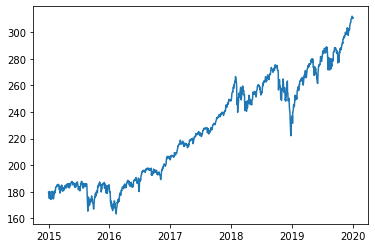

In [14]:
plt.plot(df_training['2015-1-1':])

In [502]:
# calculate AIC values for partial training set

p = range(0, 3)
d = q = range(1,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]


my_dict_partial = {}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_training['2015-1-1':],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}7 - AIC:{}'.format(param,param_seasonal,results.aic))
            my_dict_partial[results.aic] = ('ARIMA{}x{}7'.format(param,param_seasonal))
        except: 
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89873D+00    |proj g|=  2.17217D-01


 This problem is unconstrained.



At iterate    5    f=  1.77129D+00    |proj g|=  2.21583D-01

At iterate   10    f=  1.76805D+00    |proj g|=  2.32986D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     17      1     0     0   1.406D-05   1.768D+00
  F =   1.7680525737311439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 1, 7)7 - AIC:6462.927999266138
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88573D+00    |proj g|=  2.22060D-01


 This problem is unconstrained.



At iterate    5    f=  1.76094D+00    |proj g|=  5.48220D-02

At iterate   10    f=  1.76077D+00    |proj g|=  5.86400D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     29      1     0     0   3.633D-05   1.761D+00
  F =   1.7607669022486239     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 2, 7)7 - AIC:6438.320727011975
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51000D+00    |proj g|=  6.72907D-01


 This problem is unconstrained.



At iterate    5    f=  2.24600D+00    |proj g|=  3.14907D-01

At iterate   10    f=  2.12072D+00    |proj g|=  3.12428D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     23      1     0     0   5.244D-07   2.121D+00
  F =   2.1207240181346987     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 2, 1, 7)7 - AIC:7750.88411422792
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28379D+00    |proj g|=  2.07437D-01


 This problem is unconstrained.



At iterate    5    f=  1.81923D+00    |proj g|=  1.47630D+00

At iterate   10    f=  1.77852D+00    |proj g|=  6.10400D+00

At iterate   15    f=  1.77595D+00    |proj g|=  9.48051D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     34      1     0     0   9.480D-03   1.776D+00
  F =   1.7759532163931624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 2, 2, 7)7 - AIC:6493.781146267829
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.76833D+00    |proj g|=  1.59845D-02

At iterate   10    f=  1.76814D+00    |proj g|=  6.04458D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   1.277D-05   1.768D+00
  F =   1.7681449599524799     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 1, 7)7 - AIC:6465.2653937464565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88426D+00    |proj g|=  2.23484D-01


 This problem is unconstrained.



At iterate    5    f=  1.76288D+00    |proj g|=  6.78358D-02

At iterate   10    f=  1.76113D+00    |proj g|=  8.81526D-03

At iterate   15    f=  1.76015D+00    |proj g|=  1.86516D-03

At iterate   20    f=  1.76015D+00    |proj g|=  4.09424D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   4.094D-06   1.760D+00
  F =   1.7601474878984986     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 2, 7)7 - AIC:6438.058625805317
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.97425D+00    |proj g|=  4.70006D-01

At iterate   10    f=  1.95790D+00    |proj g|=  1.40478D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     19      1     0     0   1.614D-05   1.958D+00
  F =   1.9578952633589688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 2, 1, 7)7 - AIC:7158.233501786954
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39441D+00    |proj g|=  6.56264D-01


 This problem is unconstrained.



At iterate    5    f=  2.00522D+00    |proj g|=  6.37162D-01

At iterate   10    f=  1.85149D+00    |proj g|=  1.16333D+00

At iterate   15    f=  1.78206D+00    |proj g|=  9.81827D-01

At iterate   20    f=  1.77645D+00    |proj g|=  3.88445D+00

At iterate   25    f=  1.77583D+00    |proj g|=  6.09980D-03

At iterate   30    f=  1.77582D+00    |proj g|=  2.21254D-01

At iterate   35    f=  1.77581D+00    |proj g|=  4.40544D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     73      1     0     0   4.405D-02   1.776D+00
  F =   1.7758091665925624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(0, 1, 1)x(1, 2, 2, 7)7 - AIC:6495.255076396038
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90124D+00    |proj g|=  2.09555D-01


 This problem is unconstrained.



At iterate    5    f=  1.76458D+00    |proj g|=  2.50841D-02

At iterate   10    f=  1.76439D+00    |proj g|=  2.22441D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   1.719D-05   1.764D+00
  F =   1.7643915372364487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(2, 1, 1, 7)7 - AIC:6453.55789398751
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88497D+00    |proj g|=  2.23172D-01


 This problem is unconstrained.



At iterate    5    f=  1.76769D+00    |proj g|=  8.15254D-02

At iterate   10    f=  1.76104D+00    |proj g|=  6.82185D-03

At iterate   15    f=  1.76089D+00    |proj g|=  1.05527D-02

At iterate   20    f=  1.76019D+00    |proj g|=  2.43534D-02

At iterate   25    f=  1.76015D+00    |proj g|=  2.08464D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     36      1     0     0   9.399D-06   1.760D+00
  F =   1.7601435581830476     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 2, 7)7 - AIC:6440.0442744844895
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.91039D+00    |proj g|=  1.10599D-01

At iterate   10    f=  1.90378D+00    |proj g|=  1.94123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   9.023D-05   1.904D+00
  F =   1.9037734987046506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(2, 2, 1, 7)7 - AIC:6962.580817269384
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32239D+00    |proj g|=  5.15944D-01


 This problem is unconstrained.



At iterate    5    f=  1.96472D+00    |proj g|=  4.39303D-01

At iterate   10    f=  1.92735D+00    |proj g|=  2.61530D-02

At iterate   15    f=  1.87015D+00    |proj g|=  9.44824D-01

At iterate   20    f=  1.78451D+00    |proj g|=  4.29539D+00

At iterate   25    f=  1.77657D+00    |proj g|=  1.22345D+00

At iterate   30    f=  1.77571D+00    |proj g|=  6.09229D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     75      1     0     0   4.445D-03   1.776D+00
  F =   1.7756640227937421     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(2, 2, 2, 7)7 - AIC:6496.725011242746
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89672D+00    |proj g|=  2.15762D-01


 This problem is unconstrained.



At iterate    5    f=  1.76743D+00    |proj g|=  1.85314D-02

At iterate   10    f=  1.76721D+00    |proj g|=  2.29419D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   2.294D-05   1.767D+00
  F =   1.7672147814026884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(0, 1, 1, 7)7 - AIC:6461.868381682618
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88381D+00    |proj g|=  2.20546D-01


 This problem is unconstrained.



At iterate    5    f=  1.76019D+00    |proj g|=  2.54070D-02

At iterate   10    f=  1.76006D+00    |proj g|=  4.54838D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     17      1     0     0   1.746D-05   1.760D+00
  F =   1.7600602035068067     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(0, 1, 2, 7)7 - AIC:6437.739863206858
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50555D+00    |proj g|=  6.71641D-01


 This problem is unconstrained.



At iterate    5    f=  2.24268D+00    |proj g|=  2.98857D-01

At iterate   10    f=  2.11924D+00    |proj g|=  1.35474D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     23      1     0     0   1.498D-05   2.119D+00
  F =   2.1192411884700864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(0, 2, 1, 7)7 - AIC:7747.4688202927555
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27973D+00    |proj g|=  2.07485D-01


 This problem is unconstrained.



At iterate    5    f=  1.82280D+00    |proj g|=  1.52171D+00

At iterate   10    f=  1.77540D+00    |proj g|=  4.41417D-01

At iterate   15    f=  1.77532D+00    |proj g|=  8.36123D-02

At iterate   20    f=  1.77516D+00    |proj g|=  1.01605D+00

At iterate   25    f=  1.77507D+00    |proj g|=  5.10803D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     42      1     0     0   1.396D-02   1.775D+00
  F =   1.7750733429676426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(0, 2, 2, 7)7 - AIC:6492.5678485178305
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  1.76726D+00    |proj g|=  5.93424D-03

At iterate   10    f=  1.76724D+00    |proj g|=  2.29189D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     17      1     0     0   5.808D-06   1.767D+00
  F =   1.7672362705088103     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(1, 1, 1, 7)7 - AIC:6463.946859898175
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88229D+00    |proj g|=  2.22019D-01


 This problem is unconstrained.



At iterate    5    f=  1.76171D+00    |proj g|=  9.35277D-02

At iterate   10    f=  1.76031D+00    |proj g|=  7.35274D-03

At iterate   15    f=  1.75942D+00    |proj g|=  5.67904D-03

At iterate   20    f=  1.75940D+00    |proj g|=  1.09955D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     22      1     0     0   1.086D-06   1.759D+00
  F =   1.7593987121108496     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(1, 1, 2, 7)7 - AIC:6437.324096628823
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.98473D+00    |proj g|=  4.15690D-01

At iterate   10    f=  1.95685D+00    |proj g|=  5.97778D-03

At iterate   15    f=  1.95685D+00    |proj g|=  5.58031D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     41      1     0     0   5.580D-05   1.957D+00
  F =   1.9568532561433214     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(1, 2, 1, 7)7 - AIC:7156.428091435409
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39016D+00    |proj g|=  6.54976D-01


 This problem is unconstrained.



At iterate    5    f=  1.99887D+00    |proj g|=  6.11906D-01

At iterate   10    f=  1.86894D+00    |proj g|=  8.85429D-01

At iterate   15    f=  1.77740D+00    |proj g|=  2.23843D+00

At iterate   20    f=  1.77570D+00    |proj g|=  1.75742D+00
  ys=-1.351E-03  -gs= 2.433E-04 BFGS update SKIPPED

At iterate   25    f=  1.77556D+00    |proj g|=  7.22322D-01

At iterate   30    f=  1.77497D+00    |proj g|=  7.57092D-01

At iterate   35    f=  1.77493D+00    |proj g|=  5.14323D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     76      1     1     0   4.792D-02   1.775D+00
  F =   1.7749322894256989     

 This problem is unconstrained.



At iterate    5    f=  1.76480D+00    |proj g|=  2.38964D-02

At iterate   10    f=  1.76439D+00    |proj g|=  2.48663D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     19      1     0     0   4.271D-05   1.764D+00
  F =   1.7643904999279472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 1, 1, 7)7 - AIC:6455.554105736863
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88298D+00    |proj g|=  2.21659D-01


 This problem is unconstrained.



At iterate    5    f=  1.76553D+00    |proj g|=  7.53782D-02

At iterate   10    f=  1.76021D+00    |proj g|=  3.09233D-03

At iterate   15    f=  1.75969D+00    |proj g|=  2.68020D-02

At iterate   20    f=  1.75940D+00    |proj g|=  2.01408D-03

At iterate   25    f=  1.75939D+00    |proj g|=  8.98583D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     41      1     0     0   8.986D-05   1.759D+00
  F =   1.7593940149715515     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 1, 2, 7)7 - AIC:6439.306942676106
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.90996D+00    |proj g|=  1.06265D-01

At iterate   10    f=  1.90373D+00    |proj g|=  3.80920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     21      1     0     0   7.555D-05   1.904D+00
  F =   1.9037232606681971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 2, 1, 7)7 - AIC:6964.3973479602555
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31824D+00    |proj g|=  5.14572D-01


 This problem is unconstrained.



At iterate    5    f=  1.96408D+00    |proj g|=  4.33174D-01

At iterate   10    f=  1.92625D+00    |proj g|=  2.71377D-02

At iterate   15    f=  1.86271D+00    |proj g|=  1.21504D+00

At iterate   20    f=  1.82259D+00    |proj g|=  1.91892D+00

At iterate   25    f=  1.78589D+00    |proj g|=  2.91852D+00

At iterate   30    f=  1.78402D+00    |proj g|=  1.33363D+00

At iterate   35    f=  1.78248D+00    |proj g|=  5.98357D-01

At iterate   40    f=  1.77728D+00    |proj g|=  5.01370D-02

At iterate   45    f=  1.77598D+00    |proj g|=  1.29925D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.77487D+00    |proj g|=  8.13040D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     91      1     0     0   8.130D-01   1.775D+00
  F =   1.7748708557247834     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 1, 2)x(2, 2, 2, 7)7 - AIC:6495.828365106909
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00373D+00    |proj g|=  2.03079D-01


 This problem is unconstrained.



At iterate    5    f=  1.78163D+00    |proj g|=  1.85310D-01

At iterate   10    f=  1.77297D+00    |proj g|=  4.52448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     19      1     0     0   1.752D-05   1.773D+00
  F =   1.7729691845001234     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(0, 1, 1, 7)7 - AIC:6480.88346179445
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98582D+00    |proj g|=  2.11401D-01


 This problem is unconstrained.



At iterate    5    f=  1.77282D+00    |proj g|=  2.32107D-01

At iterate   10    f=  1.76600D+00    |proj g|=  1.03856D-02

At iterate   15    f=  1.76587D+00    |proj g|=  3.83696D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     35      1     0     0   3.308D-05   1.766D+00
  F =   1.7658668802978041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(0, 1, 2, 7)7 - AIC:6456.9458468475805
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60722D+00    |proj g|=  6.90054D-01


 This problem is unconstrained.



At iterate    5    f=  2.33504D+00    |proj g|=  4.72639D-01

At iterate   10    f=  2.14200D+00    |proj g|=  4.74205D-01

At iterate   15    f=  2.12924D+00    |proj g|=  1.59707D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     29      1     0     0   1.153D-04   2.129D+00
  F =   2.1292305616453224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(0, 2, 1, 7)7 - AIC:7781.950011128718
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.91814D+00    |proj g|=  2.13991D+00

At iterate   10    f=  1.83437D+00    |proj g|=  2.59789D-01

At iterate   15    f=  1.80560D+00    |proj g|=  3.63378D+00

At iterate   20    f=  1.78993D+00    |proj g|=  7.69931D-01

At iterate   25    f=  1.78362D+00    |proj g|=  2.53467D+00

At iterate   30    f=  1.78270D+00    |proj g|=  6.02842D-02

At iterate   35    f=  1.78268D+00    |proj g|=  5.62074D-02

At iterate   40    f=  1.78267D+00    |proj g|=  5.89642D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45    125      2     0     0   5.960D-02   1.783D+00
  F =   1.7826719429520113     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 2, 1)x(0, 2, 2, 7)7 - AIC:6518.317935660745
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03380D+00    |proj g|=  1.76851D-01


 This problem is unconstrained.



At iterate    5    f=  1.78285D+00    |proj g|=  2.40302D-01

At iterate   10    f=  1.77378D+00    |proj g|=  4.90204D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   1.537D-05   1.774D+00
  F =   1.7737612971257661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(1, 1, 1, 7)7 - AIC:6485.776257103298
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98518D+00    |proj g|=  2.11706D-01


 This problem is unconstrained.



At iterate    5    f=  1.76572D+00    |proj g|=  2.62570D-02

At iterate   10    f=  1.76520D+00    |proj g|=  1.82313D-03

At iterate   15    f=  1.76516D+00    |proj g|=  1.09985D-02

At iterate   20    f=  1.76515D+00    |proj g|=  1.26957D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     26      1     0     0   1.270D-04   1.765D+00
  F =   1.7651450367533852     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(1, 1, 2, 7)7 - AIC:6456.309674223363
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.99932D+00    |proj g|=  3.99472D-01

At iterate   10    f=  1.96537D+00    |proj g|=  4.42812D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     33      1     0     0   4.343D-04   1.965D+00
  F =   1.9653644426296502     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(1, 2, 1, 7)7 - AIC:7185.5109444834825
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56619D+00    |proj g|=  5.31203D-01


 This problem is unconstrained.



At iterate    5    f=  2.26168D+00    |proj g|=  4.82848D-01

At iterate   10    f=  2.00724D+00    |proj g|=  4.79548D-01

At iterate   15    f=  1.91751D+00    |proj g|=  7.39045D-01

At iterate   20    f=  1.79891D+00    |proj g|=  2.49738D-01

At iterate   25    f=  1.78549D+00    |proj g|=  4.22236D+00

At iterate   30    f=  1.78437D+00    |proj g|=  1.46744D-01

At iterate   35    f=  1.78421D+00    |proj g|=  1.64431D-01

At iterate   40    f=  1.78421D+00    |proj g|=  9.24899D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43    133      2     0     0   8.528D-02   1.784D+00
  F =   1.7842049559138915     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 2, 1)x(1, 2, 2, 7)7 - AIC:6525.916498997532
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02989D+00    |proj g|=  1.74829D-01


 This problem is unconstrained.



At iterate    5    f=  1.87402D+00    |proj g|=  7.60489D-02

At iterate   10    f=  1.76812D+00    |proj g|=  7.11008D-02

At iterate   15    f=  1.76759D+00    |proj g|=  8.66119D-03

At iterate   20    f=  1.76759D+00    |proj g|=  1.52203D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     48      1     0     0   1.601D-04   1.768D+00
  F =   1.7675879371584919     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(2, 1, 1, 7)7 - AIC:6465.231146502812
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.77140D+00    |proj g|=  1.68430D-01

At iterate   10    f=  1.76566D+00    |proj g|=  3.54461D-02

At iterate   15    f=  1.76478D+00    |proj g|=  3.19435D-03

At iterate   20    f=  1.76478D+00    |proj g|=  1.25338D-02

At iterate   25    f=  1.76477D+00    |proj g|=  4.00358D-02

At iterate   30    f=  1.76476D+00    |proj g|=  2.51892D-02

At iterate   35    f=  1.76470D+00    |proj g|=  1.24054D-02

At iterate   40    f=  1.76470D+00    |proj g|=  4.98665D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     67      1     0     0   2.416D-04   1.765D+00
  F =   1.76469734509

 This problem is unconstrained.



At iterate    5    f=  1.99457D+00    |proj g|=  4.53195D-01

At iterate   10    f=  1.91197D+00    |proj g|=  9.35556D-02

At iterate   15    f=  1.91127D+00    |proj g|=  2.43097D-02

At iterate   20    f=  1.91122D+00    |proj g|=  3.35580D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     32      1     0     0   1.143D-04   1.911D+00
  F =   1.9112214721894591     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(2, 2, 1, 7)7 - AIC:6989.780816435905
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.96314D+00    |proj g|=  2.84272D-01

At iterate   10    f=  1.93794D+00    |proj g|=  5.01191D-02

At iterate   15    f=  1.87342D+00    |proj g|=  1.37857D+00

At iterate   20    f=  1.83347D+00    |proj g|=  4.27116D+00

At iterate   25    f=  1.79688D+00    |proj g|=  2.32088D+00

At iterate   30    f=  1.79114D+00    |proj g|=  7.54121D-01

At iterate   35    f=  1.78414D+00    |proj g|=  3.76206D+00

At iterate   40    f=  1.78289D+00    |proj g|=  1.10563D-01

At iterate   45    f=  1.78266D+00    |proj g|=  1.18275D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47    138      2     0     0   1.205D-01   1.783D+00
  F =   1.7826556836810550     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(0, 2, 1)x(2, 2, 2, 7)7 - AIC:6522.258556803213
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97942D+00    |proj g|=  2.07384D-01


 This problem is unconstrained.



At iterate    5    f=  1.77543D+00    |proj g|=  2.12236D-01

At iterate   10    f=  1.77100D+00    |proj g|=  6.79716D-02

At iterate   15    f=  1.76993D+00    |proj g|=  9.59271D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   4.286D-06   1.770D+00
  F =   1.7699342028636891     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2)x(0, 1, 1, 7)7 - AIC:6471.799708858192
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.81180D+00    |proj g|=  4.75244D-01

At iterate   10    f=  1.76393D+00    |proj g|=  9.32416D-02

At iterate   15    f=  1.76314D+00    |proj g|=  4.03217D-02

At iterate   20    f=  1.76289D+00    |proj g|=  1.51544D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   7.820D-06   1.763D+00
  F =   1.7628887119932464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2)x(0, 1, 2, 7)7 - AIC:6448.069576199336
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  2.36777D+00    |proj g|=  1.78599D-01

At iterate   10    f=  2.12527D+00    |proj g|=  3.39239D-01

At iterate   15    f=  2.12263D+00    |proj g|=  1.58888D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   4.056D-05   2.123D+00
  F =   2.1225381619252111     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(0, 2, 1, 7)7 - AIC:7759.50936735087
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.



At iterate    5    f=  2.01700D+00    |proj g|=  3.28372D+00

At iterate   10    f=  1.90704D+00    |proj g|=  3.97496D+00

At iterate   15    f=  1.81734D+00    |proj g|=  3.97745D+00

At iterate   20    f=  1.78834D+00    |proj g|=  4.61323D-01

At iterate   25    f=  1.78214D+00    |proj g|=  4.96837D-01

At iterate   30    f=  1.78131D+00    |proj g|=  7.40184D-02

At iterate   35    f=  1.78072D+00    |proj g|=  7.62496D-02

At iterate   40    f=  1.77960D+00    |proj g|=  2.93665D-01

At iterate   45    f=  1.77954D+00    |proj g|=  7.13781D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46    134      2     0     0   7.138D-02   1.780D+00
  F =   1.7795356876770760     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 2, 2)x(0, 2, 2, 7)7 - AIC:6508.864331396681
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00965D+00    |proj g|=  1.80338D-01


 This problem is unconstrained.



At iterate    5    f=  1.78631D+00    |proj g|=  1.85390D-01

At iterate   10    f=  1.77069D+00    |proj g|=  1.67029D-03

At iterate   15    f=  1.77068D+00    |proj g|=  5.47013D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     26      1     0     0   1.064D-05   1.771D+00
  F =   1.7706835127872960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(1, 1, 1, 7)7 - AIC:6476.536188699205
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.77598D+00    |proj g|=  2.09264D-01

At iterate   10    f=  1.76289D+00    |proj g|=  1.82214D-02

At iterate   15    f=  1.76233D+00    |proj g|=  3.16800D-03

At iterate   20    f=  1.76232D+00    |proj g|=  1.12210D-02

At iterate   25    f=  1.76219D+00    |proj g|=  1.00075D-02

At iterate   30    f=  1.76217D+00    |proj g|=  1.96224D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     42      1     0     0   2.825D-06   1.762D+00
  F =   1.7621656528489709     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2)x(1, 1, 2, 7)7 - AIC:6447.42896420444

 This problem is unconstrained.



At iterate    5    f=  2.03320D+00    |proj g|=  5.13078D-01

At iterate   10    f=  1.96948D+00    |proj g|=  1.86913D-01

At iterate   15    f=  1.96074D+00    |proj g|=  1.48945D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     42      1     0     0   4.615D-05   1.960D+00
  F =   1.9604553138937784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(1, 2, 1, 7)7 - AIC:7169.582806340079
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  2.34456D+00    |proj g|=  1.78444D-01

At iterate   10    f=  2.05613D+00    |proj g|=  4.44205D-01

At iterate   15    f=  1.89582D+00    |proj g|=  7.02262D-01

At iterate   20    f=  1.80332D+00    |proj g|=  1.30738D+00

At iterate   25    f=  1.78835D+00    |proj g|=  1.71669D+00
  ys=-2.018E-04  -gs= 3.804E-04 BFGS update SKIPPED

At iterate   30    f=  1.78635D+00    |proj g|=  2.23286D+00

At iterate   35    f=  1.78273D+00    |proj g|=  6.56112D+00

At iterate   40    f=  1.77991D+00    |proj g|=  8.98503D-01

At iterate   45    f=  1.77984D+00    |proj g|=  2.43182D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.77983D+00    |proj g|=  1.43343D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     89      1     1     0   1.433D-02   1.780D+00
  F =   1.7798323766271769     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 2, 2)x(1, 2, 2, 7)7 - AIC:6511.94783944245
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00666D+00    |proj g|=  1.78676D-01


 This problem is unconstrained.



At iterate    5    f=  1.87600D+00    |proj g|=  3.74950D-01

At iterate   10    f=  1.81959D+00    |proj g|=  5.01864D-01

At iterate   15    f=  1.76931D+00    |proj g|=  2.20093D-01

At iterate   20    f=  1.76596D+00    |proj g|=  5.71374D-02

At iterate   25    f=  1.76579D+00    |proj g|=  4.71234D-02

At iterate   30    f=  1.76548D+00    |proj g|=  3.74837D-02

At iterate   35    f=  1.76543D+00    |proj g|=  3.48354D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     64      1     0     0   1.734D-03   1.765D+00
  F =   1.7654274654434103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.77966D+00    |proj g|=  2.41152D-01

At iterate   10    f=  1.76230D+00    |proj g|=  4.12600D-02

At iterate   15    f=  1.76221D+00    |proj g|=  5.23978D-03

At iterate   20    f=  1.76219D+00    |proj g|=  3.06023D-03

At iterate   25    f=  1.76207D+00    |proj g|=  2.62567D-02

At iterate   30    f=  1.76203D+00    |proj g|=  3.94828D-03

At iterate   35    f=  1.76203D+00    |proj g|=  8.94942D-04

At iterate   40    f=  1.76203D+00    |proj g|=  1.96124D-04

At iterate   45    f=  1.76203D+00    |proj g|=  1.72083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     73   

 This problem is unconstrained.



At iterate    5    f=  2.00263D+00    |proj g|=  3.14896D-01

At iterate   10    f=  1.90867D+00    |proj g|=  9.73914D-02

At iterate   15    f=  1.90750D+00    |proj g|=  8.75022D-03

At iterate   20    f=  1.90736D+00    |proj g|=  3.17110D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     45      1     0     0   9.095D-05   1.907D+00
  F =   1.9073570261515722     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2)x(2, 2, 1, 7)7 - AIC:6977.667859505542


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38343D+00    |proj g|=  4.82157D-01

At iterate    5    f=  2.03458D+00    |proj g|=  2.46281D-01

At iterate   10    f=  1.93657D+00    |proj g|=  3.10525D-01

At iterate   15    f=  1.93257D+00    |proj g|=  2.28739D-01

At iterate   20    f=  1.92780D+00    |proj g|=  2.22073D-01

At iterate   25    f=  1.91132D+00    |proj g|=  1.93650D-01

At iterate   30    f=  1.86194D+00    |proj g|=  6.78514D-01

At iterate   35    f=  1.79632D+00    |proj g|=  1.23968D+00

At iterate   40    f=  1.79078D+00    |proj g|=  1.79955D+00

At iterate   45    f=  1.78913D+00    |proj g|=  1.93774D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.78663D+00    |proj g|=  1.13506D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     83      1     0     0   1.135D+00   1.787D+00
  F =   1.7866285332651675     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 2, 2)x(2, 2, 2, 7)7 - AIC:6538.767403484391
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89848D+00    |proj g|=  2.17078D-01


 This problem is unconstrained.



At iterate    5    f=  1.77011D+00    |proj g|=  7.22654D-02

At iterate   10    f=  1.76792D+00    |proj g|=  6.78723D-04

At iterate   15    f=  1.76789D+00    |proj g|=  2.13847D-02

At iterate   20    f=  1.76716D+00    |proj g|=  1.79657D-03

At iterate   25    f=  1.76716D+00    |proj g|=  7.30112D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   7.301D-06   1.767D+00
  F =   1.7671615524633426     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 7)7 - AIC:6461.673989596127
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.76113D+00    |proj g|=  3.19950D-02

At iterate   10    f=  1.76065D+00    |proj g|=  5.26535D-04

At iterate   15    f=  1.76049D+00    |proj g|=  9.26467D-02

At iterate   20    f=  1.75933D+00    |proj g|=  2.00396D-03

At iterate   25    f=  1.75932D+00    |proj g|=  2.62253D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     34      1     0     0   2.623D-05   1.759D+00
  F =   1.7593215701639950     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 2, 7)7 - AIC:6435.04237423891
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.



At iterate    5    f=  2.24520D+00    |proj g|=  3.06581D-01

At iterate   10    f=  2.11993D+00    |proj g|=  3.62292D-03

At iterate   15    f=  2.11988D+00    |proj g|=  2.50739D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f=  2.11983D+00    |proj g|=  8.27810D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     40      1     0     0   8.278D-05   2.120D+00
  F =   2.1198255443360448     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 2, 1, 7)7 - AIC:7749.602887915235
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28291D+00    |proj g|=  2.07525D-01


 This problem is unconstrained.



At iterate    5    f=  1.81201D+00    |proj g|=  2.79699D-01

At iterate   10    f=  1.78380D+00    |proj g|=  2.06091D+00

At iterate   15    f=  1.77565D+00    |proj g|=  3.60908D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     26      1     0     0   1.016D-02   1.776D+00
  F =   1.7756512212382947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 2, 2, 7)7 - AIC:6494.678259962252
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.76854D+00    |proj g|=  2.18122D-02

At iterate   10    f=  1.76805D+00    |proj g|=  2.57264D-03

At iterate   15    f=  1.76777D+00    |proj g|=  8.88228D-02

At iterate   20    f=  1.76702D+00    |proj g|=  5.00260D-03

At iterate   25    f=  1.76700D+00    |proj g|=  1.06485D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     32      1     0     0   9.838D-07   1.767D+00
  F =   1.7669992927066274     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 1, 7)7 - AIC:6463.081416964603
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.76172D+00    |proj g|=  8.31173D-02

At iterate   10    f=  1.76100D+00    |proj g|=  1.33051D-02

At iterate   15    f=  1.75998D+00    |proj g|=  7.56128D-03

At iterate   20    f=  1.75991D+00    |proj g|=  3.08114D-03

At iterate   25    f=  1.75923D+00    |proj g|=  1.48467D-02

At iterate   30    f=  1.75847D+00    |proj g|=  2.77832D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     42      1     0     0   7.488D-05   1.758D+00
  F =   1.7584661948544615     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 2, 7)7 - AIC:6433.91854360849

 This problem is unconstrained.



At iterate    5    f=  1.97585D+00    |proj g|=  4.59903D-01

At iterate   10    f=  1.95805D+00    |proj g|=  3.93221D-03

At iterate   15    f=  1.95805D+00    |proj g|=  1.10738D-03

At iterate   20    f=  1.95804D+00    |proj g|=  6.06890D-03

At iterate   25    f=  1.95794D+00    |proj g|=  4.06981D-02

At iterate   30    f=  1.95780D+00    |proj g|=  9.93617D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     46      1     0     0   3.207D-05   1.958D+00
  F =   1.9578010650967450     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 2, 1, 7)7 - AIC:7159.88948973331

 This problem is unconstrained.



At iterate    5    f=  2.01488D+00    |proj g|=  5.93995D-01

At iterate   10    f=  1.88694D+00    |proj g|=  5.96662D-01

At iterate   15    f=  1.79660D+00    |proj g|=  4.06830D+00

At iterate   20    f=  1.77740D+00    |proj g|=  2.15632D-01

At iterate   25    f=  1.77677D+00    |proj g|=  5.24398D-02

At iterate   30    f=  1.77656D+00    |proj g|=  1.97209D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   35    f=  1.77640D+00    |proj g|=  3.04667D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     63      1     0     0   3.047D-03   1.776D+00
  F =   1.7764044443671900     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 2, 2, 7)7 - AIC:6499.429030828978
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89967D+00    |proj g|=  2.09463D-01


 This problem is unconstrained.



At iterate    5    f=  1.76440D+00    |proj g|=  4.90604D-02

At iterate   10    f=  1.76280D+00    |proj g|=  5.43947D-04

At iterate   15    f=  1.76123D+00    |proj g|=  3.30372D-02
  ys=-9.595E-04  -gs= 8.457E-05 BFGS update SKIPPED

At iterate   20    f=  1.76031D+00    |proj g|=  1.47357D-01

At iterate   25    f=  1.76004D+00    |proj g|=  4.73769D-03

At iterate   30    f=  1.76003D+00    |proj g|=  7.76331D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     51      1     1     0   3.235D-05   1.760D+00
  F =   1.7600338714426418     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.



At iterate    5    f=  1.76142D+00    |proj g|=  2.11384D-02

At iterate   10    f=  1.76098D+00    |proj g|=  5.98638D-03

At iterate   15    f=  1.76012D+00    |proj g|=  5.69864D-02

At iterate   20    f=  1.75991D+00    |proj g|=  9.50882D-03

At iterate   25    f=  1.75990D+00    |proj g|=  3.70141D-03

At iterate   30    f=  1.75988D+00    |proj g|=  7.13015D-03

At iterate   35    f=  1.75914D+00    |proj g|=  4.74979D-02

At iterate   40    f=  1.75847D+00    |proj g|=  9.63158D-03

At iterate   45    f=  1.75846D+00    |proj g|=  7.37208D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     69   

 This problem is unconstrained.



At iterate    5    f=  1.90890D+00    |proj g|=  8.41455D-02

At iterate   10    f=  1.90302D+00    |proj g|=  5.26238D-04

At iterate   15    f=  1.90302D+00    |proj g|=  8.16168D-04

At iterate   20    f=  1.90282D+00    |proj g|=  1.50462D-02

At iterate   25    f=  1.90263D+00    |proj g|=  1.14068D-03

At iterate   30    f=  1.90263D+00    |proj g|=  5.40650D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     40      1     0     0   5.406D-05   1.903D+00
  F =   1.9026319828634199     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 2, 1, 7)7 - AIC:6960.41200141720

 This problem is unconstrained.



At iterate    5    f=  1.96636D+00    |proj g|=  4.16837D-01

At iterate   10    f=  1.92788D+00    |proj g|=  3.07137D-02

At iterate   15    f=  1.87299D+00    |proj g|=  4.06572D-01

At iterate   20    f=  1.80901D+00    |proj g|=  1.03681D+00

At iterate   25    f=  1.79203D+00    |proj g|=  9.28449D-01

At iterate   30    f=  1.77778D+00    |proj g|=  9.13607D-01

At iterate   35    f=  1.77650D+00    |proj g|=  4.08793D-01

At iterate   40    f=  1.77564D+00    |proj g|=  1.65825D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     84      1     0     0   2.243D-02   1.776D+00
  F =   1.77557285404

 This problem is unconstrained.



At iterate    5    f=  1.82931D+00    |proj g|=  2.26849D-01

At iterate   10    f=  1.76882D+00    |proj g|=  3.78983D-02

At iterate   15    f=  1.76606D+00    |proj g|=  8.67013D-04

At iterate   20    f=  1.76604D+00    |proj g|=  2.47785D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     32      1     0     0   4.011D-05   1.766D+00
  F =   1.7660431295241621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 1, 7)7 - AIC:6459.58950902224
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0   

 This problem is unconstrained.



At iterate    5    f=  1.81264D+00    |proj g|=  2.02784D-01

At iterate   10    f=  1.75994D+00    |proj g|=  3.64450D-02

At iterate   15    f=  1.75851D+00    |proj g|=  4.74443D-03

At iterate   20    f=  1.75840D+00    |proj g|=  8.78236D-03

At iterate   25    f=  1.75836D+00    |proj g|=  7.59607D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     34      1     0     0   7.596D-05   1.758D+00
  F =   1.7583628204414776     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 2, 7)7 - AIC:6433.541020252276
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  2.27017D+00    |proj g|=  1.77955D-01

At iterate   10    f=  2.12592D+00    |proj g|=  2.84827D-01

At iterate   15    f=  2.11950D+00    |proj g|=  3.70492D-03

At iterate   20    f=  2.11928D+00    |proj g|=  1.64144D-02

At iterate   25    f=  2.11880D+00    |proj g|=  3.44877D-03

At iterate   30    f=  2.11879D+00    |proj g|=  3.53411D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     38      1     0     0   3.534D-06   2.119D+00
  F =   2.1187945303945477     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(0, 2, 1, 7)7 - AIC:7747.83762500088

 This problem is unconstrained.



At iterate    5    f=  2.18350D+00    |proj g|=  1.95891D+00

At iterate   10    f=  1.86061D+00    |proj g|=  1.74742D+00

At iterate   15    f=  1.80557D+00    |proj g|=  2.53112D-01

At iterate   20    f=  1.78493D+00    |proj g|=  3.68134D+00

At iterate   25    f=  1.77596D+00    |proj g|=  2.77695D+00

At iterate   30    f=  1.77516D+00    |proj g|=  5.72165D-02

At iterate   35    f=  1.77498D+00    |proj g|=  1.96528D-01

At iterate   40    f=  1.77424D+00    |proj g|=  6.43061D-01

At iterate   45    f=  1.77392D+00    |proj g|=  2.51062D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     76   

 This problem is unconstrained.



At iterate    5    f=  1.83431D+00    |proj g|=  1.70148D-01

At iterate   10    f=  1.78307D+00    |proj g|=  6.28263D-02

At iterate   15    f=  1.76624D+00    |proj g|=  3.41339D-02

At iterate   20    f=  1.76602D+00    |proj g|=  1.62764D-03

At iterate   25    f=  1.76597D+00    |proj g|=  2.74198D-02

At iterate   30    f=  1.76584D+00    |proj g|=  1.90375D-02

At iterate   35    f=  1.76583D+00    |proj g|=  2.83999D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     52      1     0     0   2.796D-04   1.766D+00
  F =   1.7658252782254775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.80972D+00    |proj g|=  2.06945D-01

At iterate   10    f=  1.76198D+00    |proj g|=  3.84097D-02

At iterate   15    f=  1.75850D+00    |proj g|=  3.05777D-03

At iterate   20    f=  1.75789D+00    |proj g|=  6.17441D-03

At iterate   25    f=  1.75759D+00    |proj g|=  1.14983D-02

At iterate   30    f=  1.75752D+00    |proj g|=  2.33587D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     41      1     0     0   2.096D-05   1.758D+00
  F =   1.7575191628139728     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 1, 2, 7)7 - AIC:6432.45998259662

 This problem is unconstrained.



At iterate    5    f=  2.08954D+00    |proj g|=  3.58486D-01

At iterate   10    f=  1.95987D+00    |proj g|=  1.81976D-01

At iterate   15    f=  1.95651D+00    |proj g|=  9.68225D-02

At iterate   20    f=  1.95582D+00    |proj g|=  8.31024D-03

At iterate   25    f=  1.95572D+00    |proj g|=  2.22172D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     40      1     0     0   1.362D-04   1.956D+00
  F =   1.9557237321690946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 2, 1, 7)7 - AIC:7154.303069881534
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.99724D+00    |proj g|=  6.38265D-01

At iterate   10    f=  1.93532D+00    |proj g|=  1.52448D-01

At iterate   15    f=  1.91005D+00    |proj g|=  1.66986D-01

At iterate   20    f=  1.85555D+00    |proj g|=  1.68749D+00

At iterate   25    f=  1.83293D+00    |proj g|=  3.52563D+00

At iterate   30    f=  1.82377D+00    |proj g|=  6.41805D+00

At iterate   35    f=  1.78830D+00    |proj g|=  6.73835D+00

At iterate   40    f=  1.77934D+00    |proj g|=  2.22801D-01

At iterate   45    f=  1.77811D+00    |proj g|=  1.21731D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.77790D+00    |proj g|=  1.28263D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     72      1     0     0   1.283D-01   1.778D+00
  F =   1.7779002688932788     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 1, 2)x(1, 2, 2, 7)7 - AIC:6506.891781998254
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13149D+00    |proj g|=  1.29456D+02


 This problem is unconstrained.



At iterate    5    f=  1.78093D+00    |proj g|=  1.32532D-01

At iterate   10    f=  1.76355D+00    |proj g|=  2.53179D-01

At iterate   15    f=  1.76026D+00    |proj g|=  1.14866D-01

At iterate   20    f=  1.75987D+00    |proj g|=  7.96372D-03

At iterate   25    f=  1.75980D+00    |proj g|=  2.25459D-02

At iterate   30    f=  1.75976D+00    |proj g|=  4.23413D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     46      1     0     0   5.373D-05   1.760D+00
  F =   1.7597557553904046     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 1, 1, 7)7 - AIC:6440.62801868575

 This problem is unconstrained.



At iterate    5    f=  1.81941D+00    |proj g|=  2.49119D-01

At iterate   10    f=  1.76074D+00    |proj g|=  4.64477D-02

At iterate   15    f=  1.75862D+00    |proj g|=  5.60917D-03

At iterate   20    f=  1.75841D+00    |proj g|=  1.49743D-02

At iterate   25    f=  1.75832D+00    |proj g|=  6.61447D-03

At iterate   30    f=  1.75788D+00    |proj g|=  8.58875D-02

At iterate   35    f=  1.75756D+00    |proj g|=  2.24253D-02

At iterate   40    f=  1.75752D+00    |proj g|=  2.77650D-03

At iterate   45    f=  1.75752D+00    |proj g|=  2.68583D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     62   

 This problem is unconstrained.



At iterate    5    f=  2.18453D+00    |proj g|=  2.53822D-01

At iterate   10    f=  1.91621D+00    |proj g|=  1.86399D-01

At iterate   15    f=  1.90252D+00    |proj g|=  4.93600D-02

At iterate   20    f=  1.90245D+00    |proj g|=  3.35578D-03

At iterate   25    f=  1.90235D+00    |proj g|=  6.31460D-03

At iterate   30    f=  1.90234D+00    |proj g|=  2.96299D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     54      1     0     0   5.088D-05   1.902D+00
  F =   1.9023448417706539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 2, 1, 7)7 - AIC:6961.36336214642

 This problem is unconstrained.



At iterate    5    f=  2.08783D+00    |proj g|=  3.48528D-01

At iterate   10    f=  1.92677D+00    |proj g|=  1.21576D-01

At iterate   15    f=  1.92272D+00    |proj g|=  5.00654D-02

At iterate   20    f=  1.82646D+00    |proj g|=  7.78675D-01

At iterate   25    f=  1.79912D+00    |proj g|=  2.80295D+00

At iterate   30    f=  1.79178D+00    |proj g|=  2.70836D+00

At iterate   35    f=  1.78668D+00    |proj g|=  6.96683D-01

At iterate   40    f=  1.78167D+00    |proj g|=  5.67636D+00

At iterate   45    f=  1.77533D+00    |proj g|=  7.46424D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.77500D+00    |proj g|=  2.53003D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     79      1     0     0   2.530D-01   1.775D+00
  F =   1.7750042166424866     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 1, 2)x(2, 2, 2, 7)7 - AIC:6498.315399178361
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99442D+00    |proj g|=  2.09442D-01


 This problem is unconstrained.



At iterate    5    f=  1.78169D+00    |proj g|=  1.93711D-01

At iterate   10    f=  1.77085D+00    |proj g|=  7.09341D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     22      1     0     0   1.987D-05   1.771D+00
  F =   1.7708425127305238     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(0, 1, 1, 7)7 - AIC:6475.1168564918735
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97683D+00    |proj g|=  2.17476D-01


 This problem is unconstrained.



At iterate    5    f=  1.80363D+00    |proj g|=  2.39856D-01

At iterate   10    f=  1.76611D+00    |proj g|=  5.99562D-02

At iterate   15    f=  1.76379D+00    |proj g|=  1.01796D-02

At iterate   20    f=  1.76377D+00    |proj g|=  2.18632D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     27      1     0     0   4.567D-05   1.764D+00
  F =   1.7637655469686604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(0, 1, 2, 7)7 - AIC:6451.271777529548
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  2.39739D+00    |proj g|=  1.68924D-01

At iterate   10    f=  2.12930D+00    |proj g|=  3.92916D-01

At iterate   15    f=  2.12398D+00    |proj g|=  4.65955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     31      1     0     0   6.419D-06   2.124D+00
  F =   2.1239672054182450     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 1)x(0, 2, 1, 7)7 - AIC:7764.728234187432
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.98510D+00    |proj g|=  4.62655D+00

At iterate   10    f=  1.88524D+00    |proj g|=  2.51163D+00

At iterate   15    f=  1.87962D+00    |proj g|=  2.18339D+00

At iterate   20    f=  1.84574D+00    |proj g|=  4.29781D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  1.81247D+00    |proj g|=  2.75140D+00

At iterate   30    f=  1.79979D+00    |proj g|=  3.87125D-01

At iterate   35    f=  1.78803D+00    |proj g|=  3.80280D+00

At iterate   40    f=  1.78355D+00    |proj g|=  9.43938D-01

At iterate   45    f=  1.78088D+00    |proj g|=  5.87748D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.78087D+00    |proj g|=  2.46842D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    122      2     0     0   2.468D-01   1.781D+00
  F =   1.7808717966708851     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 1)x(0, 2, 2, 7)7 - AIC:6513.743801442072
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02403D+00    |proj g|=  1.83504D-01


 This problem is unconstrained.



At iterate    5    f=  1.80379D+00    |proj g|=  2.48717D-01

At iterate   10    f=  1.77173D+00    |proj g|=  1.84185D-02

At iterate   15    f=  1.77081D+00    |proj g|=  1.01286D-01
  ys=-3.331E-03  -gs= 5.576E-05 BFGS update SKIPPED

At iterate   20    f=  1.77077D+00    |proj g|=  4.04403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     41      1     1     0   3.934D-04   1.771D+00
  F =   1.7707745341718422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(1, 1, 1, 7)7 - AIC:6476.868598795568
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  1.76663D+00    |proj g|=  1.94394D-01

At iterate   10    f=  1.76323D+00    |proj g|=  2.63471D-02

At iterate   15    f=  1.76315D+00    |proj g|=  3.51100D-03

At iterate   20    f=  1.76299D+00    |proj g|=  1.81051D-02

At iterate   25    f=  1.76298D+00    |proj g|=  9.25138D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   7.503D-05   1.763D+00
  F =   1.7629835817707014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(1, 1, 2, 7)7 - AIC:6450.416040626601
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  2.03698D+00    |proj g|=  2.58821D-01

At iterate   10    f=  1.97306D+00    |proj g|=  4.04500D-01

At iterate   15    f=  1.96152D+00    |proj g|=  1.28685D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     34      1     0     0   1.320D-05   1.962D+00
  F =   1.9615147868168104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(1, 2, 1, 7)7 - AIC:7173.452001454992
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  2.29263D+00    |proj g|=  1.97239D-01

At iterate   10    f=  2.00988D+00    |proj g|=  3.94133D-01

At iterate   15    f=  1.97877D+00    |proj g|=  1.60420D-01

At iterate   20    f=  1.88347D+00    |proj g|=  1.76924D+00

At iterate   25    f=  1.82798D+00    |proj g|=  2.66081D-01

At iterate   30    f=  1.79600D+00    |proj g|=  2.44062D+00

At iterate   35    f=  1.78953D+00    |proj g|=  2.31071D-01

At iterate   40    f=  1.78889D+00    |proj g|=  1.86854D+00
  ys=-3.451E-04  -gs= 7.570E-04 BFGS update SKIPPED

At iterate   45    f=  1.78398D+00    |proj g|=  4.56204D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.78056D+00    |proj g|=  1.24964D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     88      1     1     0   1.250D+00   1.781D+00
  F =   1.7805632432915701     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 1)x(1, 2, 2, 7)7 - AIC:6514.616964500814
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01853D+00    |proj g|=  1.81701D-01


 This problem is unconstrained.



At iterate    5    f=  1.87187D+00    |proj g|=  1.25381D-01

At iterate   10    f=  1.77881D+00    |proj g|=  1.42887D-01

At iterate   15    f=  1.76461D+00    |proj g|=  9.87632D-02

At iterate   20    f=  1.76450D+00    |proj g|=  1.84329D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     46      1     0     0   2.510D-05   1.765D+00
  F =   1.7645007032839455     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(2, 1, 1, 7)7 - AIC:6455.956568392969
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.78422D+00    |proj g|=  1.66014D-01

At iterate   10    f=  1.76530D+00    |proj g|=  6.16606D-02

At iterate   15    f=  1.76303D+00    |proj g|=  9.61123D-03

At iterate   20    f=  1.76297D+00    |proj g|=  1.09268D-03

At iterate   25    f=  1.76293D+00    |proj g|=  6.36439D-03

At iterate   30    f=  1.76286D+00    |proj g|=  2.38012D-03

At iterate   35    f=  1.76286D+00    |proj g|=  2.50273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     60      1     0     0   1.634D-04   1.763D+00
  F =   1.7628624065746452     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.96618D+00    |proj g|=  1.04761D-01

At iterate   10    f=  1.91493D+00    |proj g|=  1.09564D-01

At iterate   15    f=  1.90611D+00    |proj g|=  3.59141D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     35      1     0     0   9.971D-05   1.906D+00
  F =   1.9060983463483117     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1)x(2, 2, 1, 7)7 - AIC:6973.071160864034


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39792D+00    |proj g|=  4.82067D-01

At iterate    5    f=  2.02074D+00    |proj g|=  2.67017D-01

At iterate   10    f=  1.94567D+00    |proj g|=  3.61701D-01

At iterate   15    f=  1.92669D+00    |proj g|=  7.01085D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  1.87244D+00    |proj g|=  2.45053D+00

At iterate   25    f=  1.87188D+00    |proj g|=  1.76811D+00

At iterate   30    f=  1.83721D+00    |proj g|=  1.76646D+00

At iterate   35    f=  1.80651D+00    |proj g|=  2.15925D+00

At iterate   40    f=  1.79955D+00    |proj g|=  1.19999D-01

At iterate   45    f=  1.78652D+00    |proj g|=  2.11302D+00

At iterate   50    f=  1.78484D+00    |proj g|=  1.58056D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    116      2     0     0   1.581D-01   1.785D+00
  F =   1.7848387199245752     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1)x(2, 2, 2, 7)7 - AIC:6532.231005164549
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97503D+00    |proj g|=  2.08113D-01


 This problem is unconstrained.



At iterate    5    f=  1.77301D+00    |proj g|=  1.27372D-01

At iterate   10    f=  1.77013D+00    |proj g|=  4.76805D-04

At iterate   15    f=  1.77013D+00    |proj g|=  1.53986D-02

At iterate   20    f=  1.76993D+00    |proj g|=  5.23007D-03

At iterate   25    f=  1.76898D+00    |proj g|=  2.53285D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     54      1     0     0   2.561D-05   1.769D+00
  F =   1.7689772308240725     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2)x(0, 1, 1, 7)7 - AIC:6470.304846969513
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.77687D+00    |proj g|=  4.49147D-01

At iterate   10    f=  1.76398D+00    |proj g|=  2.06829D-01

At iterate   15    f=  1.76317D+00    |proj g|=  3.26304D-02

At iterate   20    f=  1.76295D+00    |proj g|=  1.92316D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     36      1     0     0   5.780D-04   1.763D+00
  F =   1.7629516486458889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2)x(0, 1, 2, 7)7 - AIC:6450.299420854786
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  2.22564D+00    |proj g|=  8.96208D-01

At iterate   10    f=  2.12720D+00    |proj g|=  5.52615D-01

At iterate   15    f=  2.12404D+00    |proj g|=  1.67744D-02

At iterate   20    f=  2.12394D+00    |proj g|=  3.79594D-02

At iterate   25    f=  2.12242D+00    |proj g|=  7.62216D-02

At iterate   30    f=  2.12164D+00    |proj g|=  1.33175D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     49      1     0     0   3.578D-05   2.122D+00
  F =   2.1216376991837866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2)x(0, 2, 1, 7)7 - AIC:7758.22087741918

 This problem is unconstrained.



At iterate    5    f=  2.32053D+00    |proj g|=  2.03154D-01

At iterate   10    f=  1.99651D+00    |proj g|=  1.02935D+00

At iterate   15    f=  1.88646D+00    |proj g|=  5.40492D-01

At iterate   20    f=  1.84713D+00    |proj g|=  2.35022D+00

At iterate   25    f=  1.78576D+00    |proj g|=  1.43997D+00

At iterate   30    f=  1.78476D+00    |proj g|=  1.21138D-01

At iterate   35    f=  1.77982D+00    |proj g|=  2.11284D-01

At iterate   40    f=  1.77981D+00    |proj g|=  5.95468D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41    118      2     0     0   5.955D-02   1.780D+00
  F =   1.7798059156636326     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(1, 2, 2)x(0, 2, 2, 7)7 - AIC:6511.851204003586
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00553D+00    |proj g|=  2.06364D-01


 This problem is unconstrained.


  ys=-5.347E-05  -gs= 4.083E-02 BFGS update SKIPPED

At iterate    5    f=  1.86037D+00    |proj g|=  4.94562D-01

At iterate   10    f=  1.77471D+00    |proj g|=  1.31752D-01

At iterate   15    f=  1.77074D+00    |proj g|=  2.57329D-03

At iterate   20    f=  1.77074D+00    |proj g|=  6.50148D-04

At iterate   25    f=  1.77072D+00    |proj g|=  1.54417D-02

At iterate   30    f=  1.77068D+00    |proj g|=  2.27044D-03

At iterate   35    f=  1.77068D+00    |proj g|=  7.07711D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     65      2     1     0   7.082D-04   1.771D+00
  F =   1.7706834779770328     

 This problem is unconstrained.



At iterate    5    f=  1.78786D+00    |proj g|=  5.20394D-01

At iterate   10    f=  1.76251D+00    |proj g|=  1.52535D-01

At iterate   15    f=  1.76233D+00    |proj g|=  2.53977D-02

At iterate   20    f=  1.76228D+00    |proj g|=  9.08845D-04

At iterate   25    f=  1.76219D+00    |proj g|=  6.09608D-02

At iterate   30    f=  1.76214D+00    |proj g|=  5.29593D-03

At iterate   35    f=  1.76214D+00    |proj g|=  4.93238D-04

At iterate   40    f=  1.76213D+00    |proj g|=  5.27655D-03

At iterate   45    f=  1.76212D+00    |proj g|=  6.31441D-03


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.76211D+00    |proj g|=  2.87179D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68      1     0     0   2.872D-04   1.762D+00
  F =   1.7621135636553154     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2)x(1, 1, 2, 7)7 - AIC:6449.2387344692115
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40461D+00    |proj g|=  1.77176D-01


 This problem is unconstrained.



At iterate    5    f=  2.17684D+00    |proj g|=  5.50290D-01

At iterate   10    f=  1.96205D+00    |proj g|=  5.68969D-01

At iterate   15    f=  1.96117D+00    |proj g|=  6.61056D-03

At iterate   20    f=  1.96112D+00    |proj g|=  2.04214D-02

At iterate   25    f=  1.96059D+00    |proj g|=  1.95985D-02

At iterate   30    f=  1.96035D+00    |proj g|=  4.57197D-03

At iterate   35    f=  1.96035D+00    |proj g|=  1.71064D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     52      1     0     0   7.872D-05   1.960D+00
  F =   1.9603510969523963     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.32983D+00    |proj g|=  1.15616D+00

At iterate   10    f=  2.00746D+00    |proj g|=  7.51780D-01

At iterate   15    f=  1.93906D+00    |proj g|=  1.19779D-01

At iterate   20    f=  1.82144D+00    |proj g|=  9.35500D+00

At iterate   25    f=  1.78728D+00    |proj g|=  3.96728D-01

At iterate   30    f=  1.78407D+00    |proj g|=  1.59900D+00

At iterate   35    f=  1.78341D+00    |proj g|=  1.45088D+00

At iterate   40    f=  1.78071D+00    |proj g|=  1.90657D+00

At iterate   45    f=  1.77960D+00    |proj g|=  2.32446D-01
  ys=-7.172E-07  -gs= 2.229E-06 BFGS update SKIPPED

At iterate   50    f=  1.77959D+00    |proj g|=  2.12047D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 2, 2, 7)7 - AIC:6513.068822093819
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00122D+00    |proj g|=  2.10217D-01


 This problem is unconstrained.



At iterate    5    f=  1.92442D+00    |proj g|=  1.74135D-01

At iterate   10    f=  1.87504D+00    |proj g|=  4.54139D-01

At iterate   15    f=  1.78757D+00    |proj g|=  3.81085D-01

At iterate   20    f=  1.76701D+00    |proj g|=  1.77705D-01

At iterate   25    f=  1.76471D+00    |proj g|=  8.87685D-03

At iterate   30    f=  1.76464D+00    |proj g|=  7.75400D-03

At iterate   35    f=  1.76464D+00    |proj g|=  1.89455D-03

At iterate   40    f=  1.76464D+00    |proj g|=  1.95406D-02

At iterate   45    f=  1.76461D+00    |proj g|=  1.50945D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.76454D+00    |proj g|=  8.04780D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     75      1     0     0   8.048D-02   1.765D+00
  F =   1.7645378716108520     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2)x(2, 1, 1, 7)7 - AIC:6458.092307122832
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96983D+00    |proj g|=  2.04993D-01


 This problem is unconstrained.



At iterate    5    f=  1.89454D+00    |proj g|=  2.07145D-01

At iterate   10    f=  1.77874D+00    |proj g|=  2.59857D-01

At iterate   15    f=  1.76501D+00    |proj g|=  2.03722D-01

At iterate   20    f=  1.76236D+00    |proj g|=  8.21471D-02

At iterate   25    f=  1.76231D+00    |proj g|=  2.02579D-02

At iterate   30    f=  1.76229D+00    |proj g|=  4.59782D-03

At iterate   35    f=  1.76227D+00    |proj g|=  3.44180D-02

At iterate   40    f=  1.76211D+00    |proj g|=  2.31561D-02

At iterate   45    f=  1.76208D+00    |proj g|=  2.94509D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.76206D+00    |proj g|=  3.10274D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     73      1     0     0   3.103D-03   1.762D+00
  F =   1.7620589318636257     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2)x(2, 1, 2, 7)7 - AIC:6451.039219165961
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40980D+00    |proj g|=  1.70294D-01


 This problem is unconstrained.



At iterate    5    f=  2.01153D+00    |proj g|=  7.87802D-01

At iterate   10    f=  1.92829D+00    |proj g|=  3.35132D-01

At iterate   15    f=  1.91043D+00    |proj g|=  3.27049D-01

At iterate   20    f=  1.90701D+00    |proj g|=  1.08942D-02

At iterate   25    f=  1.90697D+00    |proj g|=  3.06750D-02

At iterate   30    f=  1.90692D+00    |proj g|=  2.89281D-02

At iterate   35    f=  1.90690D+00    |proj g|=  8.12718D-03

At iterate   40    f=  1.90675D+00    |proj g|=  3.79862D-02

At iterate   45    f=  1.90612D+00    |proj g|=  4.82637D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.90607D+00    |proj g|=  2.50377D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     72      1     0     0   2.504D-03   1.906D+00
  F =   1.9060668150190587     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2)x(2, 2, 1, 7)7 - AIC:6974.956008449602


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37426D+00    |proj g|=  4.80997D-01

At iterate    5    f=  2.06724D+00    |proj g|=  8.25024D-01

At iterate   10    f=  1.96207D+00    |proj g|=  6.54383D-01

At iterate   15    f=  1.93062D+00    |proj g|=  8.03260D-02

At iterate   20    f=  1.93040D+00    |proj g|=  1.90977D-01

At iterate   25    f=  1.92750D+00    |proj g|=  3.31237D-01

At iterate   30    f=  1.92125D+00    |proj g|=  4.53517D-01

At iterate   35    f=  1.87972D+00    |proj g|=  7.49122D-01

At iterate   40    f=  1.79884D+00    |proj g|=  6.10172D-01

At iterate   45    f=  1.78487D+00    |proj g|=  1.95020D+00

At iterate   50    f=  1.78027D+00    |proj g|=  2.25366D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 2, 2, 7)7 - AIC:6517.530940899413
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03367D+00    |proj g|=  4.56491D-01


 This problem is unconstrained.



At iterate    5    f=  1.77574D+00    |proj g|=  1.20899D-01

At iterate   10    f=  1.76765D+00    |proj g|=  2.61728D-03

At iterate   15    f=  1.76722D+00    |proj g|=  1.77063D-02

At iterate   20    f=  1.76715D+00    |proj g|=  1.06602D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     32      1     0     0   5.418D-05   1.767D+00
  F =   1.7671510768860703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 1, 1, 7)7 - AIC:6463.635732787929
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.78078D+00    |proj g|=  1.17251D-01

At iterate   10    f=  1.76004D+00    |proj g|=  5.35577D-03

At iterate   15    f=  1.75944D+00    |proj g|=  1.54373D-02

At iterate   20    f=  1.75903D+00    |proj g|=  1.22831D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   1.291D-05   1.759D+00
  F =   1.7590249408159668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 1, 2, 7)7 - AIC:6435.959083859911
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  2.26098D+00    |proj g|=  1.77613D-01

At iterate   10    f=  2.12137D+00    |proj g|=  1.15069D-01

At iterate   15    f=  2.12116D+00    |proj g|=  3.47755D-03

At iterate   20    f=  2.11979D+00    |proj g|=  1.20283D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     46      1     0     0   1.417D-04   2.120D+00
  F =   2.1197439962813251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 2, 1, 7)7 - AIC:7751.3050744194
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0    

 This problem is unconstrained.



At iterate    5    f=  1.83328D+00    |proj g|=  2.61622D+00

At iterate   10    f=  1.80961D+00    |proj g|=  1.48453D-01

At iterate   15    f=  1.78406D+00    |proj g|=  4.01511D+00

At iterate   20    f=  1.77490D+00    |proj g|=  1.20796D-02

At iterate   25    f=  1.77490D+00    |proj g|=  6.16057D-02

At iterate   30    f=  1.77484D+00    |proj g|=  3.48086D-02

At iterate   35    f=  1.77483D+00    |proj g|=  1.43173D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     58      1     0     0   1.432D-03   1.775D+00
  F =   1.7748342115772964     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 2, 2, 7)7 - AIC:6493.694540680286
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04298D+00    |proj g|=  4.45151D-01


 This problem is unconstrained.



At iterate    5    f=  1.77288D+00    |proj g|=  2.35478D-01

At iterate   10    f=  1.76795D+00    |proj g|=  1.43227D-03

At iterate   15    f=  1.76779D+00    |proj g|=  7.20298D-02

At iterate   20    f=  1.76677D+00    |proj g|=  7.73915D-03

At iterate   25    f=  1.76672D+00    |proj g|=  1.07777D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     39      1     0     0   5.604D-06   1.767D+00
  F =   1.7667171764702096     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(1, 1, 1, 7)7 - AIC:6464.051128469206
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.76219D+00    |proj g|=  7.03607D-02

At iterate   10    f=  1.76089D+00    |proj g|=  3.20170D-03

At iterate   15    f=  1.75939D+00    |proj g|=  3.31450D-02

At iterate   20    f=  1.75839D+00    |proj g|=  6.45492D-03

At iterate   25    f=  1.75833D+00    |proj g|=  8.99170D-04

At iterate   30    f=  1.75830D+00    |proj g|=  5.09984D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     48      1     0     0   8.187D-06   1.758D+00
  F =   1.7582910162622374     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(1, 1, 2, 7)7 - AIC:6435.27879138969

 This problem is unconstrained.



At iterate    5    f=  2.08945D+00    |proj g|=  3.87276D-01

At iterate   10    f=  1.95769D+00    |proj g|=  1.94749D-02

At iterate   15    f=  1.95755D+00    |proj g|=  9.84760D-04

At iterate   20    f=  1.95752D+00    |proj g|=  7.27511D-03

At iterate   25    f=  1.95752D+00    |proj g|=  2.96942D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     34      1     0     0   6.067D-05   1.958D+00
  F =   1.9575157902747098     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(1, 2, 1, 7)7 - AIC:7160.84766608324
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.



At iterate    5    f=  2.00149D+00    |proj g|=  5.65067D-01

At iterate   10    f=  1.92980D+00    |proj g|=  2.62080D-01

At iterate   15    f=  1.84112D+00    |proj g|=  6.32579D-01

At iterate   20    f=  1.80063D+00    |proj g|=  2.41645D-01

At iterate   25    f=  1.78139D+00    |proj g|=  3.49457D+00

At iterate   30    f=  1.78086D+00    |proj g|=  6.06968D-01

At iterate   35    f=  1.77976D+00    |proj g|=  9.80549D-01

At iterate   40    f=  1.77799D+00    |proj g|=  1.43463D-01

At iterate   45    f=  1.77678D+00    |proj g|=  2.55565D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.77650D+00    |proj g|=  9.62044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76      1     0     0   9.620D-04   1.776D+00
  F =   1.7764950039018856     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 1)x(1, 2, 2, 7)7 - AIC:6501.759754249686
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03331D+00    |proj g|=  4.46806D-01


 This problem is unconstrained.



At iterate    5    f=  1.76899D+00    |proj g|=  2.18229D-01

At iterate   10    f=  1.76174D+00    |proj g|=  8.47149D-04

At iterate   15    f=  1.76118D+00    |proj g|=  3.11956D-02

At iterate   20    f=  1.76041D+00    |proj g|=  7.57155D-03

At iterate   25    f=  1.76040D+00    |proj g|=  1.24555D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     36      1     0     0   1.146D-05   1.760D+00
  F =   1.7603992304357252     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 1, 1, 7)7 - AIC:6442.977989551268
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.76391D+00    |proj g|=  1.11324D-01

At iterate   10    f=  1.76070D+00    |proj g|=  1.84949D-02

At iterate   15    f=  1.76065D+00    |proj g|=  2.06347D-02

At iterate   20    f=  1.75906D+00    |proj g|=  5.62660D-02

At iterate   25    f=  1.75833D+00    |proj g|=  9.19843D-03

At iterate   30    f=  1.75830D+00    |proj g|=  5.13188D-04

At iterate   35    f=  1.75830D+00    |proj g|=  5.10676D-03

At iterate   40    f=  1.75829D+00    |proj g|=  1.46787D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     66      1     0     0   3.120D-05   1.758D+00
  F =   1.75829020383

 This problem is unconstrained.



At iterate    5    f=  1.97177D+00    |proj g|=  2.34362D-01

At iterate   10    f=  1.90165D+00    |proj g|=  2.95765D-02

At iterate   15    f=  1.90136D+00    |proj g|=  1.67882D-03

At iterate   20    f=  1.90133D+00    |proj g|=  5.22359D-03

At iterate   25    f=  1.90130D+00    |proj g|=  3.52919D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     35      1     0     0   6.108D-05   1.901D+00
  F =   1.9012963635506537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 2, 1, 7)7 - AIC:6957.534319686987


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32294D+00    |proj g|=  5.22173D-01

At iterate    5    f=  2.02869D+00    |proj g|=  4.37138D-01

At iterate   10    f=  1.93438D+00    |proj g|=  8.91304D-02

At iterate   15    f=  1.92620D+00    |proj g|=  5.01321D-02

At iterate   20    f=  1.89551D+00    |proj g|=  8.43198D-01

At iterate   25    f=  1.84691D+00    |proj g|=  6.77716D-01

At iterate   30    f=  1.83940D+00    |proj g|=  6.85883D-01

At iterate   35    f=  1.81367D+00    |proj g|=  3.19497D+00

At iterate   40    f=  1.80548D+00    |proj g|=  2.28764D+00

At iterate   45    f=  1.77879D+00    |proj g|=  7.23160D-01

At iterate   50    f=  1.77830D+00    |proj g|=  3.95171D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(2, 2, 2, 7)7 - AIC:6510.349543550255
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90328D+00    |proj g|=  2.65654D-01


 This problem is unconstrained.



At iterate    5    f=  1.76742D+00    |proj g|=  1.57073D-01

At iterate   10    f=  1.76620D+00    |proj g|=  7.82481D-04

At iterate   15    f=  1.76614D+00    |proj g|=  2.53434D-02

At iterate   20    f=  1.76592D+00    |proj g|=  1.68386D-03

At iterate   25    f=  1.76587D+00    |proj g|=  2.04611D-02

At iterate   30    f=  1.76577D+00    |proj g|=  8.71159D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     40      1     0     0   2.909D-05   1.766D+00
  F =   1.7657653949509224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(0, 1, 1, 7)7 - AIC:6460.57522236076

 This problem is unconstrained.



At iterate    5    f=  1.76148D+00    |proj g|=  2.10263D-01

At iterate   10    f=  1.75860D+00    |proj g|=  4.00285D-03

At iterate   15    f=  1.75850D+00    |proj g|=  1.80442D-02

At iterate   20    f=  1.75842D+00    |proj g|=  5.01616D-03

At iterate   25    f=  1.75817D+00    |proj g|=  6.25344D-03

At iterate   30    f=  1.75811D+00    |proj g|=  1.38758D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     38      1     0     0   1.960D-05   1.758D+00
  F =   1.7581085385440844     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(0, 1, 2, 7)7 - AIC:6434.61238276299

 This problem is unconstrained.



At iterate    5    f=  2.24827D+00    |proj g|=  1.83255D-01

At iterate   10    f=  2.10915D+00    |proj g|=  3.27907D-01

At iterate   15    f=  2.09366D+00    |proj g|=  1.05738D-01

At iterate   20    f=  2.09162D+00    |proj g|=  4.89563D-02

At iterate   25    f=  2.08005D+00    |proj g|=  9.73039D-02

At iterate   30    f=  2.07616D+00    |proj g|=  2.96511D-01

At iterate   35    f=  2.06761D+00    |proj g|=  2.32647D-01

At iterate   40    f=  2.06720D+00    |proj g|=  4.18798D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44    101      2     0     0   1.056D-04   2.067D+00
  F =   2.0671957973414954     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 2)x(0, 2, 1, 7)7 - AIC:7561.399051891141
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50460D+00    |proj g|=  3.24392D-01


 This problem is unconstrained.



At iterate    5    f=  2.18467D+00    |proj g|=  2.12283D-01

At iterate   10    f=  1.86324D+00    |proj g|=  8.03503D-01

At iterate   15    f=  1.81523D+00    |proj g|=  4.56636D-01

At iterate   20    f=  1.77472D+00    |proj g|=  7.42025D-01

At iterate   25    f=  1.77467D+00    |proj g|=  9.66435D-01

At iterate   30    f=  1.77436D+00    |proj g|=  2.73090D-01

At iterate   35    f=  1.77398D+00    |proj g|=  2.76877D-01

At iterate   40    f=  1.77379D+00    |proj g|=  6.86706D-01

At iterate   45    f=  1.77377D+00    |proj g|=  4.56175D-03


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.77376D+00    |proj g|=  1.88307D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70      1     0     0   1.883D-01   1.774D+00
  F =   1.7737647965660444     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 2)x(0, 2, 2, 7)7 - AIC:6491.789037059194
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91118D+00    |proj g|=  2.30446D-01


 This problem is unconstrained.



At iterate    5    f=  1.76863D+00    |proj g|=  6.17667D-02

At iterate   10    f=  1.76635D+00    |proj g|=  2.11046D-03

At iterate   15    f=  1.76611D+00    |proj g|=  1.95838D-02

At iterate   20    f=  1.76605D+00    |proj g|=  7.98523D-03

At iterate   25    f=  1.76556D+00    |proj g|=  1.14343D-02

At iterate   30    f=  1.76548D+00    |proj g|=  5.48203D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     35      1     0     0   8.621D-06   1.765D+00
  F =   1.7654805627534769     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 2)x(1, 1, 1, 7)7 - AIC:6461.53501517569

 This problem is unconstrained.



At iterate    5    f=  1.76302D+00    |proj g|=  1.25969D-01

At iterate   10    f=  1.75848D+00    |proj g|=  7.50663D-03

At iterate   15    f=  1.75754D+00    |proj g|=  8.57923D-03

At iterate   20    f=  1.75738D+00    |proj g|=  8.22181D-03

At iterate   25    f=  1.75731D+00    |proj g|=  9.52797D-04

At iterate   30    f=  1.75718D+00    |proj g|=  3.10829D-03

At iterate   35    f=  1.75717D+00    |proj g|=  2.90902D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     46      1     0     0   4.209D-05   1.757D+00
  F =   1.7571749672429335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.97992D+00    |proj g|=  2.90174D-01

At iterate   10    f=  1.95658D+00    |proj g|=  2.09098D-02

At iterate   15    f=  1.95629D+00    |proj g|=  1.18994D-02

At iterate   20    f=  1.95540D+00    |proj g|=  3.56274D-02

At iterate   25    f=  1.95537D+00    |proj g|=  6.86263D-04

At iterate   30    f=  1.95536D+00    |proj g|=  6.84000D-03

At iterate   35    f=  1.95529D+00    |proj g|=  5.26861D-03

At iterate   40    f=  1.95527D+00    |proj g|=  8.96858D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     54      1     0     0   1.116D-05   1.955D+00
  F =   1.95527254447

 This problem is unconstrained.



At iterate    5    f=  2.19954D+00    |proj g|=  2.02329D-01

At iterate   10    f=  2.00079D+00    |proj g|=  4.43213D-01

At iterate   15    f=  1.92824D+00    |proj g|=  3.55822D-01

At iterate   20    f=  1.81077D+00    |proj g|=  1.91285D+00

At iterate   25    f=  1.79323D+00    |proj g|=  6.02985D+00

At iterate   30    f=  1.77815D+00    |proj g|=  7.35961D-01

At iterate   35    f=  1.77731D+00    |proj g|=  2.17935D-01

At iterate   40    f=  1.77643D+00    |proj g|=  2.34679D-01

At iterate   45    f=  1.77642D+00    |proj g|=  2.24181D-02


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.77628D+00    |proj g|=  4.69038D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69      1     0     0   4.690D-01   1.776D+00
  F =   1.7762782148546721     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 2)x(1, 2, 2, 7)7 - AIC:6502.968040649263
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90292D+00    |proj g|=  2.28118D-01


 This problem is unconstrained.



At iterate    5    f=  1.76774D+00    |proj g|=  7.88655D-02

At iterate   10    f=  1.76028D+00    |proj g|=  3.55785D-02

At iterate   15    f=  1.75950D+00    |proj g|=  1.74835D-02

At iterate   20    f=  1.75936D+00    |proj g|=  2.10726D-02

At iterate   25    f=  1.75917D+00    |proj g|=  1.25036D-03

At iterate   30    f=  1.75901D+00    |proj g|=  1.74797D-02

At iterate   35    f=  1.75876D+00    |proj g|=  3.36341D-03

At iterate   40    f=  1.75876D+00    |proj g|=  3.59962D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     62      1     0     0   4.097D-05   1.759D+00
  F =   1.75875936728

 This problem is unconstrained.



At iterate    5    f=  1.76211D+00    |proj g|=  8.87717D-02

At iterate   10    f=  1.75864D+00    |proj g|=  9.77683D-03

At iterate   15    f=  1.75835D+00    |proj g|=  1.68331D-02

At iterate   20    f=  1.75756D+00    |proj g|=  4.39762D-03

At iterate   25    f=  1.75748D+00    |proj g|=  1.25183D-02

At iterate   30    f=  1.75732D+00    |proj g|=  1.02343D-03

At iterate   35    f=  1.75731D+00    |proj g|=  6.23948D-03

At iterate   40    f=  1.75722D+00    |proj g|=  4.93727D-02

At iterate   45    f=  1.75718D+00    |proj g|=  6.16256D-03


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.75717D+00    |proj g|=  4.39436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   4.394D-04   1.757D+00
  F =   1.7571719555701382     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 2)x(2, 1, 2, 7)7 - AIC:6435.191981742145
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52722D+00    |proj g|=  3.01365D-01


 This problem is unconstrained.



At iterate    5    f=  1.93348D+00    |proj g|=  4.70192D-01

At iterate   10    f=  1.90155D+00    |proj g|=  2.95700D-02

At iterate   15    f=  1.90133D+00    |proj g|=  2.43203D-03

At iterate   20    f=  1.90120D+00    |proj g|=  8.94609D-03

At iterate   25    f=  1.90115D+00    |proj g|=  1.44667D-03

At iterate   30    f=  1.90114D+00    |proj g|=  5.64001D-03

At iterate   35    f=  1.90102D+00    |proj g|=  9.64303D-03

At iterate   40    f=  1.90090D+00    |proj g|=  2.95438D-03

At iterate   45    f=  1.90088D+00    |proj g|=  6.91413D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     59   

 This problem is unconstrained.



At iterate    5    f=  2.16338D+00    |proj g|=  1.98989D-01

At iterate   10    f=  1.95364D+00    |proj g|=  2.24008D-01

At iterate   15    f=  1.92772D+00    |proj g|=  2.79607D-02

At iterate   20    f=  1.86424D+00    |proj g|=  7.91125D-01

At iterate   25    f=  1.79606D+00    |proj g|=  6.18621D-01

At iterate   30    f=  1.77987D+00    |proj g|=  1.92147D-01

At iterate   35    f=  1.77811D+00    |proj g|=  1.35878D+00

At iterate   40    f=  1.77766D+00    |proj g|=  6.03656D-02

At iterate   45    f=  1.77458D+00    |proj g|=  2.57881D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.77409D+00    |proj g|=  1.33928D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     81      1     0     0   1.339D+00   1.774D+00
  F =   1.7740927252580339     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 2)x(2, 2, 2, 7)7 - AIC:6496.98663264234
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00054D+00    |proj g|=  2.00849D-01


 This problem is unconstrained.



At iterate    5    f=  1.78116D+00    |proj g|=  2.11038D-01

At iterate   10    f=  1.77084D+00    |proj g|=  9.46958D-03

At iterate   15    f=  1.77083D+00    |proj g|=  6.53296D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   1.155D-05   1.771D+00
  F =   1.7708294011538086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(0, 1, 1, 7)7 - AIC:6477.068973013709
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.77896D+00    |proj g|=  1.73342D-01

At iterate   10    f=  1.76481D+00    |proj g|=  9.58402D-02

At iterate   15    f=  1.76394D+00    |proj g|=  4.95568D-02

At iterate   20    f=  1.76377D+00    |proj g|=  9.60724D-03

At iterate   25    f=  1.76376D+00    |proj g|=  7.42701D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     33      1     0     0   1.123D-05   1.764D+00
  F =   1.7637646335363382     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(0, 1, 2, 7)7 - AIC:6453.268441674707
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  2.28941D+00    |proj g|=  5.86296D-01

At iterate   10    f=  2.12944D+00    |proj g|=  1.51554D-01

At iterate   15    f=  2.12353D+00    |proj g|=  4.12119D-02

At iterate   20    f=  2.12352D+00    |proj g|=  3.15774D-03

At iterate   25    f=  2.12351D+00    |proj g|=  2.60979D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     38      1     0     0   2.610D-05   2.124D+00
  F =   2.1235146516071204     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(0, 2, 1, 7)7 - AIC:7765.075507669203
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  1.87703D+00    |proj g|=  2.00552D+00

At iterate   10    f=  1.82405D+00    |proj g|=  3.48253D+00

At iterate   15    f=  1.79818D+00    |proj g|=  3.85978D-01

At iterate   20    f=  1.78344D+00    |proj g|=  1.96961D+00

At iterate   25    f=  1.78060D+00    |proj g|=  5.05558D-01

At iterate   30    f=  1.78058D+00    |proj g|=  4.84063D-01

At iterate   35    f=  1.78057D+00    |proj g|=  4.19955D-02

At iterate   40    f=  1.78057D+00    |proj g|=  3.90143D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     85      1     0     0   3.901D-02   1.781D+00
  F =   1.78056704907


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 2, 1)x(0, 2, 2, 7)7 - AIC:6514.6308632051405
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03196D+00    |proj g|=  1.73141D-01


 This problem is unconstrained.



At iterate    5    f=  1.79077D+00    |proj g|=  1.40656D-01

At iterate   10    f=  1.77238D+00    |proj g|=  2.55870D-02

At iterate   15    f=  1.77165D+00    |proj g|=  7.62228D-03

At iterate   20    f=  1.77105D+00    |proj g|=  8.79133D-03

At iterate   25    f=  1.77104D+00    |proj g|=  1.65808D-03

At iterate   30    f=  1.77104D+00    |proj g|=  9.14445D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     46      1     0     0   2.895D-05   1.771D+00
  F =   1.7710380795698133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(1, 1, 1, 7)7 - AIC:6479.83106658895

 This problem is unconstrained.



At iterate    5    f=  1.77055D+00    |proj g|=  2.28910D-01

At iterate   10    f=  1.76327D+00    |proj g|=  1.21974D-02

At iterate   15    f=  1.76317D+00    |proj g|=  1.61319D-03

At iterate   20    f=  1.76307D+00    |proj g|=  4.53742D-02

At iterate   25    f=  1.76297D+00    |proj g|=  2.95238D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     33      1     0     0   2.486D-05   1.763D+00
  F =   1.7629741401659265     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(1, 1, 2, 7)7 - AIC:6452.381559885964
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  2.02652D+00    |proj g|=  2.93513D-01

At iterate   10    f=  1.96164D+00    |proj g|=  1.27710D-01

At iterate   15    f=  1.96149D+00    |proj g|=  5.99591D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     29      1     0     0   1.325D-05   1.961D+00
  F =   1.9614901669720757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(1, 2, 1, 7)7 - AIC:7175.36208978202
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.



At iterate    5    f=  2.28493D+00    |proj g|=  3.86516D-01

At iterate   10    f=  1.97331D+00    |proj g|=  2.94832D-01

At iterate   15    f=  1.92657D+00    |proj g|=  4.02915D-01

At iterate   20    f=  1.80272D+00    |proj g|=  9.65711D-01

At iterate   25    f=  1.78210D+00    |proj g|=  3.49367D+00

At iterate   30    f=  1.78141D+00    |proj g|=  1.28174D+00

At iterate   35    f=  1.78071D+00    |proj g|=  1.11376D+00

At iterate   40    f=  1.78064D+00    |proj g|=  4.87129D-02

At iterate   45    f=  1.78054D+00    |proj g|=  7.56645D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48    103   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 2, 1)x(1, 2, 2, 7)7 - AIC:6516.519450820177
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02597D+00    |proj g|=  1.70671D-01


 This problem is unconstrained.



At iterate    5    f=  1.85153D+00    |proj g|=  2.62403D-01

At iterate   10    f=  1.77961D+00    |proj g|=  1.52962D-01

At iterate   15    f=  1.76536D+00    |proj g|=  3.24122D-03

At iterate   20    f=  1.76535D+00    |proj g|=  3.11037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     41      1     0     0   4.250D-05   1.765D+00
  F =   1.7653475541262083     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(2, 1, 1, 7)7 - AIC:6461.049267668913
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0  

 This problem is unconstrained.



At iterate    5    f=  1.77144D+00    |proj g|=  1.89804D-01

At iterate   10    f=  1.76417D+00    |proj g|=  2.66096D-02

At iterate   15    f=  1.76305D+00    |proj g|=  2.38334D-02

At iterate   20    f=  1.76301D+00    |proj g|=  4.42967D-03

At iterate   25    f=  1.76299D+00    |proj g|=  2.01565D-03

At iterate   30    f=  1.76296D+00    |proj g|=  1.72458D-02

At iterate   35    f=  1.76292D+00    |proj g|=  1.08998D-02

At iterate   40    f=  1.76286D+00    |proj g|=  1.97799D-03

At iterate   45    f=  1.76286D+00    |proj g|=  1.19571D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     59   

 This problem is unconstrained.



At iterate    5    f=  1.97886D+00    |proj g|=  4.14547D-01

At iterate   10    f=  1.91555D+00    |proj g|=  3.57508D-01

At iterate   15    f=  1.90529D+00    |proj g|=  2.76235D-02

At iterate   20    f=  1.90499D+00    |proj g|=  7.82272D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     46      1     0     0   5.439D-05   1.905D+00
  F =   1.9049896539764299     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1)x(2, 2, 1, 7)7 - AIC:6971.022216321922


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39635D+00    |proj g|=  4.79519D-01

At iterate    5    f=  1.97157D+00    |proj g|=  2.36768D-01

At iterate   10    f=  1.93237D+00    |proj g|=  6.97054D-02

At iterate   15    f=  1.93141D+00    |proj g|=  6.00858D-02

At iterate   20    f=  1.88396D+00    |proj g|=  5.25867D-01

At iterate   25    f=  1.81401D+00    |proj g|=  1.94937D+00

At iterate   30    f=  1.79143D+00    |proj g|=  1.12076D+00

At iterate   35    f=  1.78352D+00    |proj g|=  1.51813D+00

At iterate   40    f=  1.78113D+00    |proj g|=  9.31565D-01

At iterate   45    f=  1.78089D+00    |proj g|=  9.28765D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.78079D+00    |proj g|=  5.79113D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     86      1     0     0   5.791D-02   1.781D+00
  F =   1.7807874277320661     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 1)x(2, 2, 2, 7)7 - AIC:6519.435686077505
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01135D+00    |proj g|=  2.87769D-01


 This problem is unconstrained.



At iterate    5    f=  1.81330D+00    |proj g|=  2.77418D-01

At iterate   10    f=  1.77071D+00    |proj g|=  3.43998D-02

At iterate   15    f=  1.76999D+00    |proj g|=  5.33287D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     31      1     0     0   4.599D-05   1.770D+00
  F =   1.7699889284337118     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2)x(0, 1, 1, 7)7 - AIC:6475.999566639915
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  1.85171D+00    |proj g|=  2.16988D-01

At iterate   10    f=  1.76682D+00    |proj g|=  3.18765D-01

At iterate   15    f=  1.76296D+00    |proj g|=  1.01698D-01

At iterate   20    f=  1.76289D+00    |proj g|=  1.03732D-03

At iterate   25    f=  1.76289D+00    |proj g|=  1.38915D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     33      1     0     0   1.520D-04   1.763D+00
  F =   1.7628862374581959     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2)x(0, 1, 2, 7)7 - AIC:6452.060539197331
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  2.35255D+00    |proj g|=  1.70757D-01

At iterate   10    f=  2.17008D+00    |proj g|=  1.27481D+00

At iterate   15    f=  2.14355D+00    |proj g|=  4.17190D-01

At iterate   20    f=  2.12345D+00    |proj g|=  5.82349D-01

At iterate   25    f=  2.12238D+00    |proj g|=  1.60086D-03

At iterate   30    f=  2.12237D+00    |proj g|=  3.66038D-02
  ys=-1.984E-04  -gs= 7.679E-05 BFGS update SKIPPED

At iterate   35    f=  2.11712D+00    |proj g|=  1.18885D+01

At iterate   40    f=  2.09336D+00    |proj g|=  6.76442D+00

At iterate   45    f=  2.09230D+00    |proj g|=  4.60700D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.09229D+00    |proj g|=  3.78137D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    150      2     1     0   3.781D-01   2.092D+00
  F =   2.0922925413160898     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 2)x(0, 2, 1, 7)7 - AIC:7653.05236088636
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43125D+00    |proj g|=  9.29405D-01


 This problem is unconstrained.



At iterate    5    f=  2.31305D+00    |proj g|=  1.97366D-01

At iterate   10    f=  1.92603D+00    |proj g|=  1.34186D+00

At iterate   15    f=  1.79961D+00    |proj g|=  4.69273D-01

At iterate   20    f=  1.78299D+00    |proj g|=  1.06384D+00

At iterate   25    f=  1.78164D+00    |proj g|=  1.52469D-01

At iterate   30    f=  1.78155D+00    |proj g|=  5.83702D-01

At iterate   35    f=  1.77997D+00    |proj g|=  7.67832D-01

At iterate   40    f=  1.77964D+00    |proj g|=  1.80429D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45    147      3     0     0   9.196D-02   1.780D+00
  F =   1.7796401413808933     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(2, 2, 2)x(0, 2, 2, 7)7 - AIC:6513.245796323023
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05257D+00    |proj g|=  4.28380D-01


 This problem is unconstrained.


  ys=-2.197E-02  -gs= 3.790E-02 BFGS update SKIPPED

At iterate    5    f=  1.91097D+00    |proj g|=  9.84599D-01

At iterate   10    f=  1.78110D+00    |proj g|=  4.33939D-01

At iterate   15    f=  1.77098D+00    |proj g|=  3.28472D-02

At iterate   20    f=  1.77068D+00    |proj g|=  8.64900D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     37      1     1     0   1.534D-04   1.771D+00
  F =   1.7706796131701106     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2)x(1, 1, 1, 7)7 - AIC:6480.521947297244
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  1.80389D+00    |proj g|=  3.77346D-01

At iterate   10    f=  1.76240D+00    |proj g|=  1.18914D-02

At iterate   15    f=  1.76225D+00    |proj g|=  8.21706D-03

At iterate   20    f=  1.76222D+00    |proj g|=  2.04624D-03

At iterate   25    f=  1.76217D+00    |proj g|=  3.58687D-02

At iterate   30    f=  1.76212D+00    |proj g|=  1.20761D-03

At iterate   35    f=  1.76212D+00    |proj g|=  1.01774D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     49      1     0     0   3.565D-04   1.762D+00
  F =   1.7621223576189029     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.29140D+00    |proj g|=  1.60570D+00

At iterate   10    f=  2.13492D+00    |proj g|=  6.04220D-01

At iterate   15    f=  1.99298D+00    |proj g|=  5.36278D-01

At iterate   20    f=  1.96224D+00    |proj g|=  1.41589D-01

At iterate   25    f=  1.96048D+00    |proj g|=  2.94048D-02

At iterate   30    f=  1.96037D+00    |proj g|=  1.93063D-02

At iterate   35    f=  1.96036D+00    |proj g|=  8.57436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     67      1     0     0   1.234D-03   1.960D+00
  F =   1.9603633745192681     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.33563D+00    |proj g|=  5.86850D-01

At iterate   10    f=  1.98044D+00    |proj g|=  6.62232D-01

At iterate   15    f=  1.95141D+00    |proj g|=  3.59643D-01

At iterate   20    f=  1.92934D+00    |proj g|=  5.78755D-01

At iterate   25    f=  1.84241D+00    |proj g|=  1.11416D+00

At iterate   30    f=  1.80902D+00    |proj g|=  1.68550D+00

At iterate   35    f=  1.80237D+00    |proj g|=  1.51513D-01

At iterate   40    f=  1.78343D+00    |proj g|=  2.78712D+00

At iterate   45    f=  1.78146D+00    |proj g|=  1.17390D+00


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.78130D+00    |proj g|=  9.32539D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     77      1     0     0   9.325D-02   1.781D+00
  F =   1.7812957512272030     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 2)x(1, 2, 2, 7)7 - AIC:6521.292083481745
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04739D+00    |proj g|=  4.18517D-01


 This problem is unconstrained.



At iterate    5    f=  1.91222D+00    |proj g|=  7.18063D-01

At iterate   10    f=  1.86789D+00    |proj g|=  6.70524D-01

At iterate   15    f=  1.86241D+00    |proj g|=  4.65828D-01

At iterate   20    f=  1.76547D+00    |proj g|=  1.69038D-01

At iterate   25    f=  1.76536D+00    |proj g|=  6.85079D-03

At iterate   30    f=  1.76533D+00    |proj g|=  7.53532D-04

At iterate   35    f=  1.76533D+00    |proj g|=  3.61654D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     63      1     0     0   7.079D-04   1.765D+00
  F =   1.7653271174527201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.80986D+00    |proj g|=  7.99126D-01

At iterate   10    f=  1.76454D+00    |proj g|=  6.91738D-02

At iterate   15    f=  1.76226D+00    |proj g|=  1.45256D-02

At iterate   20    f=  1.76225D+00    |proj g|=  4.85081D-03

At iterate   25    f=  1.76211D+00    |proj g|=  2.96338D-02

At iterate   30    f=  1.76205D+00    |proj g|=  1.18783D-03

At iterate   35    f=  1.76204D+00    |proj g|=  2.98678D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     63      1     0     0   5.464D-04   1.762D+00
  F =   1.7620447164934530     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


  ys=-3.303E-03  -gs= 3.947E-02 BFGS update SKIPPED

At iterate    5    f=  2.31520D+00    |proj g|=  2.66817D+00

At iterate   10    f=  2.25370D+00    |proj g|=  6.94861D-01

At iterate   15    f=  2.05944D+00    |proj g|=  1.60066D+00

At iterate   20    f=  1.97143D+00    |proj g|=  4.75189D-01

At iterate   25    f=  1.90321D+00    |proj g|=  2.15397D-01

At iterate   30    f=  1.89320D+00    |proj g|=  1.95089D+01

At iterate   35    f=  1.89243D+00    |proj g|=  1.56828D+00
  ys=-1.981E-10  -gs= 4.355E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  1.89243D+00    |proj g|=  1.62058D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41    183      3     2     0   1.621D+00   1.892D+00
  F =   1.8924275010772218     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 2)x(2, 2, 1, 7)7 - AIC:6927.145233934014


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44919D+00    |proj g|=  1.19206D+00

At iterate    5    f=  2.29045D+00    |proj g|=  1.59724D+00

At iterate   10    f=  2.15055D+00    |proj g|=  1.24716D+00

At iterate   15    f=  1.94243D+00    |proj g|=  5.67451D-01

At iterate   20    f=  1.92912D+00    |proj g|=  6.49231D-02

At iterate   25    f=  1.92736D+00    |proj g|=  6.03486D-02

At iterate   30    f=  1.92500D+00    |proj g|=  1.40596D-01

At iterate   35    f=  1.92373D+00    |proj g|=  6.39799D-02

At iterate   40    f=  1.91648D+00    |proj g|=  6.16006D-01

At iterate   45    f=  1.86009D+00    |proj g|=  3.63381D-01


/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.80091D+00    |proj g|=  1.34906D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     92      1     0     0   1.349D+00   1.801D+00
  F =   1.8009149412144192     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 2)x(2, 2, 2, 7)7 - AIC:6594.941365315059


In [506]:
# AIC's are pretty similar for training data after 2015.
# (011)x(011,7) AIC is pretty close to lowest value, so increased model complexity is not worth it.
# sorted(my_dict_partial.items(), key=lambda item: item[0])

[(6432.459982596629, 'ARIMA(1, 1, 2)x(1, 1, 2, 7)7'),
 (6433.202980371193, 'ARIMA(2, 1, 2)x(1, 1, 2, 7)7'),
 (6433.541020252276, 'ARIMA(1, 1, 2)x(0, 1, 2, 7)7'),
 (6433.918543608494, 'ARIMA(1, 1, 1)x(1, 1, 2, 7)7'),
 (6434.448165135121, 'ARIMA(1, 1, 2)x(2, 1, 2, 7)7'),
 (6434.612382762996, 'ARIMA(2, 1, 2)x(0, 1, 2, 7)7'),
 (6435.04237423891, 'ARIMA(1, 1, 1)x(0, 1, 2, 7)7'),
 (6435.191981742145, 'ARIMA(2, 1, 2)x(2, 1, 2, 7)7'),
 (6435.278791389691, 'ARIMA(2, 1, 1)x(1, 1, 2, 7)7'),
 (6435.908912937346, 'ARIMA(1, 1, 1)x(2, 1, 2, 7)7'),
 (6435.959083859911, 'ARIMA(2, 1, 1)x(0, 1, 2, 7)7'),
 (6437.275824409114, 'ARIMA(2, 1, 1)x(2, 1, 2, 7)7'),
 (6437.324096628823, 'ARIMA(0, 1, 2)x(1, 1, 2, 7)7'),
 (6437.739863206858, 'ARIMA(0, 1, 2)x(0, 1, 2, 7)7'),
 (6438.058625805317, 'ARIMA(0, 1, 1)x(1, 1, 2, 7)7'),
 (6438.320727011975, 'ARIMA(0, 1, 1)x(0, 1, 2, 7)7'),
 (6438.989209336758, 'ARIMA(2, 1, 2)x(2, 1, 1, 7)7'),
 (6439.306942676106, 'ARIMA(0, 1, 2)x(2, 1, 2, 7)7'),
 (6439.643698508527, 'ARIMA(1

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72114D+00    |proj g|=  2.68888D-01


 This problem is unconstrained.



At iterate    5    f=  1.60659D+00    |proj g|=  4.86598D-02

At iterate   10    f=  1.58835D+00    |proj g|=  4.79840D-03

At iterate   15    f=  1.58678D+00    |proj g|=  3.34232D-04

At iterate   20    f=  1.58662D+00    |proj g|=  9.73544D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     31      1     0     0   3.836D-06   1.587D+00
  F =   1.5866029889192663     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 

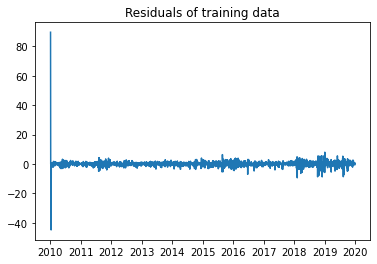

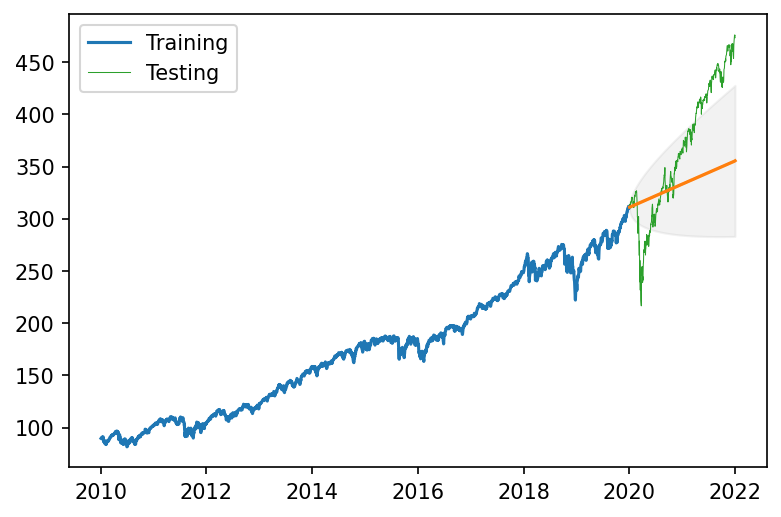

In [11]:
ARIMA_prediction_data(df_training['2010-1-1':], df_testing, 's')

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3649
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -5781.474
Date:                Tue, 12 Apr 2022   AIC                          11568.949
Time:                        11:32:26   BIC                          11587.554
Sample:                    01-04-2010   HQIC                         11575.575
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0567      0.009      6.315      0.000       0.039       0.074
ma.L1         -0.9994      0.002   -510.759      0.000      -1.003      -0.996
sigma2         1.3921      0.015     90.993      0.0

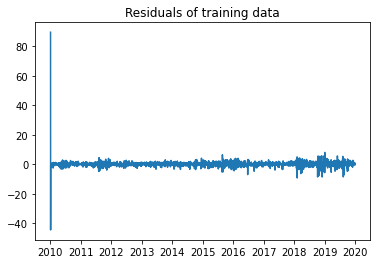

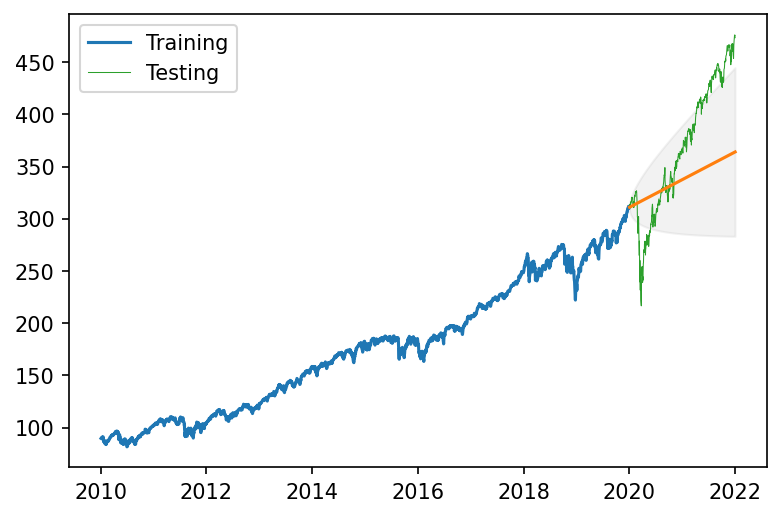

In [93]:
#ARIMA_prediction_data(df_training['2016-6-1':'2017-11-1'], df_training['2017-11-1':'2018-1-1'])
model, model_f = ARIMA_prediction_data(df_training['2010-1-1':], df_testing, 'a')

In [40]:
model_a#.loglike([0.5,-0.5,2]) #params: p, q, sigma

In [357]:
import emcee

def log_likelihood(params, model):
    return model.loglike(params)

def log_prior(params):
    p, q, sigma = params
    if -0.5 < p < 0.5 and -1.5 < q < 0 and 1 < sigma < 2:
        return 0.0
    return -np.inf

def log_post(params, model):
    lp = log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, model)

In [365]:
num_iter = 1000
ndim = 3 # number of parameters
nwalkers =  50
initial_pos = np.array((0,-0.5,1.5)) + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=[model_a])

sampler.run_mcmc(initial_pos, num_iter, progress=True);

100%|███████████████████████████████████████| 1000/1000 [04:07<00:00,  4.05it/s]


In [366]:
samples = sampler.get_chain()

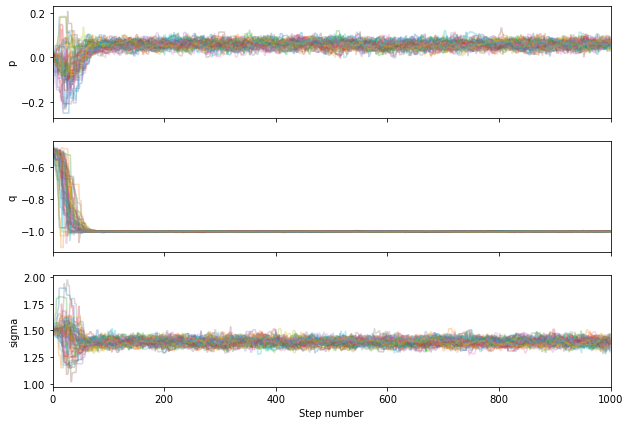

In [367]:
f, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["p", "q", "sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number");

In [368]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [369]:
flat_samples

array([[ 0.05807703, -1.00387411,  1.36516529],
       [ 0.05021862, -1.00061112,  1.35101099],
       [ 0.03804992, -1.00100449,  1.35894606],
       ...,
       [ 0.05241335, -0.99705641,  1.40797045],
       [ 0.06715904, -1.00059668,  1.46772148],
       [ 0.04839946, -1.00396757,  1.33886887]])

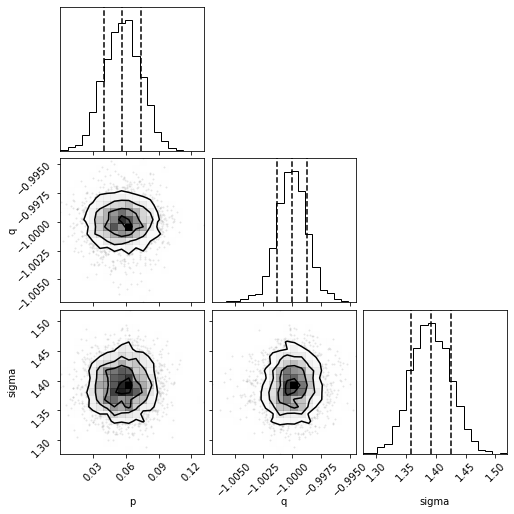

In [370]:
import corner
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84]);

In [759]:
flat_samples[:,0].shape

(3000,)

In [761]:
p_mc = flat_samples[:,0].mean() # p
p_mc

0.056966951017459036

In [762]:
q_mc = flat_samples[:,1].mean() # q
q_mc

-1.0000489828069754

In [763]:
sig_mc = flat_samples[:,2].mean() # sigma
sig_mc

1.391961738716178

In [374]:
model.param_names

['ar.L1', 'ma.L1', 'sigma2']

In [376]:
#plt.plot(df_training)
model.simulate([p_mc, q_mc, sig_mc], nsimulations=730, anchor='end', initial_state=df_training[-4:])

2020-01-01       931.971771
2020-01-02      1881.423904
2020-01-03      2847.564476
2020-01-04      3816.842707
2020-01-05      4784.395623
                  ...      
2021-12-26    703486.100502
2021-12-27    704456.640220
2021-12-28    705425.870181
2021-12-29    706395.029446
2021-12-30    707363.900734
Freq: D, Name: Close, Length: 730, dtype: float64

In [254]:
p_mc, q_mc, sig_mc

(0.05682078006141105, -0.9999617488811334, 1.3914346547791512)

In [260]:
mcmc_arima = ARIMA(df_training, order=(1, 2, 1))

# fix params of fit to the ones determined by mcmc algo

with mcmc_arima.fix_params({'ar.L1': p_mc, 'ma.L1': q_mc, 'sigma2': sig_mc}):
    mcmc_model_fit = mcmc_arima.fit()
    
mcmc_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3649
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -5781.375
Date:                Tue, 12 Apr 2022   AIC                          11562.750
Time:                        13:59:08   BIC                          11562.750
Sample:                    01-04-2010   HQIC                         11562.750
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ar.L1 (fixed)      0.0568        nan        nan        nan         nan         nan
ma.L1 (fixed)     -1.0000        nan        nan        nan         nan         nan
sigma2 (fixed)     1.3914        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12608.86
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [285]:
model_f.simulate(10, anchor='end')

2020-01-01    310.111402
2020-01-02    310.669645
2020-01-03    310.653476
2020-01-04    312.902321
2020-01-05    310.952524
2020-01-06    311.111240
2020-01-07    309.618817
2020-01-08    310.203151
2020-01-09    309.640820
2020-01-10    308.014846
Freq: D, Name: Close, dtype: float64

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98107D+00    |proj g|=  1.80983D-01

At iterate    5    f=  1.88306D+00    |proj g|=  1.59143D-02


 This problem is unconstrained.



At iterate   10    f=  1.86467D+00    |proj g|=  3.41415D-03

At iterate   15    f=  1.86308D+00    |proj g|=  6.65971D-04

At iterate   20    f=  1.86300D+00    |proj g|=  1.27356D-04

At iterate   25    f=  1.86299D+00    |proj g|=  3.60748D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     31      1     0     0   4.933D-06   1.863D+00
  F =   1.8629909096894710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 

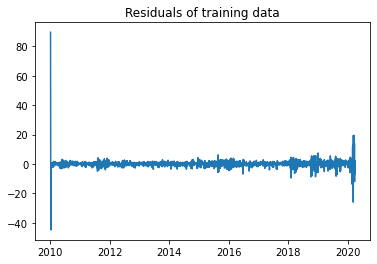

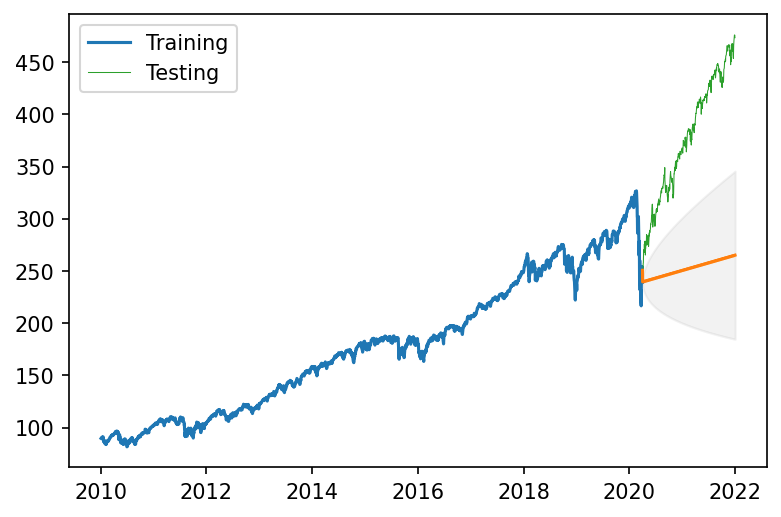

(<statsmodels.tsa.statespace.sarimax.SARIMAX at 0x7f838ec50be0>,
 <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f831975d460>)

In [343]:
ARIMA_prediction_data(df['2010-1-1':'2020-4-1'], df['2020-4-1':], model='s')

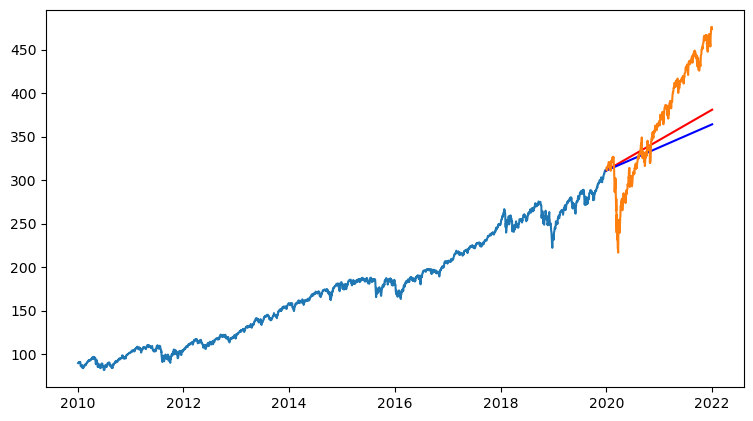

In [767]:
plt.figure(figsize=(9,5), dpi=100)
plt.plot(df_training)

inds = np.random.randint(len(flat_samples), size=50)

# for ind in inds:
#     sample = flat_samples[ind]
#     with mcmc_arima.fix_params({'ar.L1': sample[0], 'ma.L1': sample[1], 'sigma2': sample[2]}):
#         mcmc_model_fit = mcmc_arima.fit()
    
        #plt.plot(mcmc_model_fit.simulate(len(df_testing), anchor='end'), alpha=0.1, color='red')
plt.plot(mcmc_model_fit.predict(start='2020-1-1', end='2022-1-1'), color='red')

#plt.plot(model_f.simulate(len(df_testing), anchor='end'), color='green')
plt.plot(model_f.predict(start='2020-1-1', end='2022-1-1'), color='blue', label='ARIMA prediction')

plt.plot(df_testing)

## training data has variable trend (slope)

which means a 2-level differencing might fit it better

In [1655]:
def slope(df, start, end):
    return np.abs(df[start] - df[end]) / len(df[start:end])

In [1666]:
print(slope(df_training, df_training.index[0], '2012-8-1'))

print(slope(df_training, '2012-8-1', '2015-8-1'))

print(slope(df_training, '2015-8-1', '2019-1-1'))

print(slope(df_training, '2019-1-1', df_training.index[-1]))

0.026281869626830667
0.0651391416860613
0.04101155598958332
0.20229755558379708


In [1667]:
print(df_training[:'2012-8-1'].mean())

print(df_training['2012-8-1':'2015-8-1'].mean())

print(df_training['2016-1-1':'2019-1-1'].mean())

print(df_training['2019-1-1':].mean())

100.39956736792666
154.2813930105409
223.4486098450319
277.97029625879577


In [105]:
def ARIMA_prediction(train_data):

    model = ARIMA(train_data, order=(1,1,1)) # 1st difference of train_data (which is already differenced) is 2nd difference of original data

    model_fit = model.fit()

    print(model_fit.summary())

    # How many days forward to simulate, match to number of days in testing data
    td = df_testing.index[-1] - df_testing.index[0] # can't just len() since testing data skips some dates

    n_days = int((td / np.timedelta64(1, 'D'))) + 1

    # How many simulations to run
    n_reps = 10

    # Run n_reps MC simulations to 
    sim = model_fit.simulate(n_days, anchor='end', repetitions=n_reps)

    # rename column names to integers starting at 0
    sim.columns = range(0, len(sim.columns))

    ## pred_start_date = test_data.index[0]
    pred_end_date = test_data.index[-1]

    predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
    residuals = test_data - predictions

    forcast = model_fit.forecast(steps=n_days)

    plt.title('Residuals of training data (first difference)')
    plt.plot(model_fit.resid)
    plt.show()

    plt.title('Residuals of testing data (first difference)')
    plt.plot(residuals, color='blue')
    plt.show()

    plt.title('Predictions (first difference)')
    plt.plot(predictions)
    plt.xticks(rotation=45);
    plt.show()
    
    plt.figure(figsize=(6,4), dpi=150)
    plt.plot(df_training['2010-1-1':], label='Training')
    plt.plot(df_training['2010-1-1':][-1] + predictions.cumsum(), zorder=5)
    #plt.plot(df_training['Close']['2010-1-1':][-1] + sim.cumsum(), color='cornflowerblue')#, label='Predicted')
    plt.plot(df_testing['2010-1-1':], '-', lw=0.5, label='Testing')
    #plt.plot(test_data, linestyle='--', lw=0.5)
    plt.legend()
    plt.show()


    # Root Mean Square Error
    print('RMSE:', np.sqrt(np.mean(residuals ** 2)))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3649
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5783.207
Date:                Thu, 07 Apr 2022   AIC                          11572.415
Time:                        19:24:57   BIC                          11591.021
Sample:                    01-05-2010   HQIC                         11579.041
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0569      0.009      6.335      0.000       0.039       0.075
ma.L1         -0.9994      0.002   -513.339      0.000      -1.003      -0.996
sigma2         1.3923      0.015     91.064      0.0

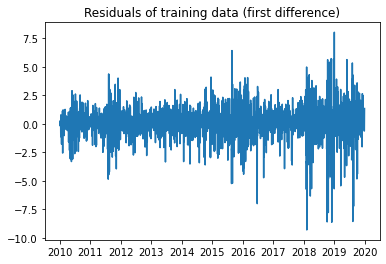

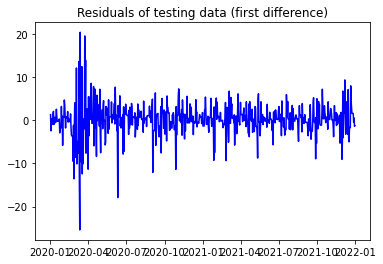

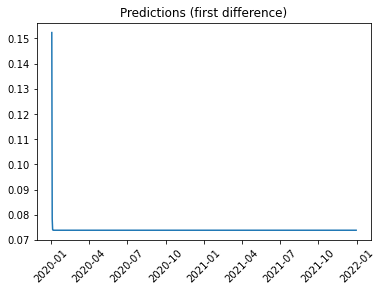

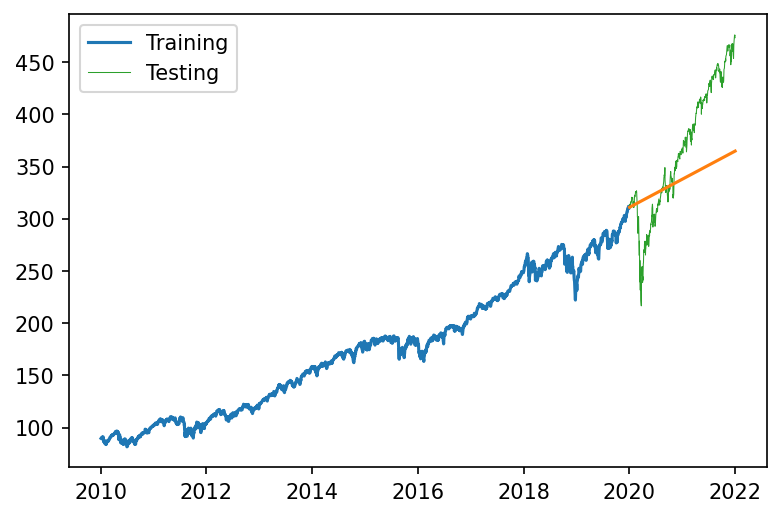

RMSE: 3.533307459082605


In [111]:
ARIMA_prediction(train_data)

In [1296]:
model_fit.params

ar.L1    -1.414593
ar.L2    -0.964586
ma.L1     0.414823
ma.L2    -0.455135
ma.L3    -0.957942
sigma2    1.002846
dtype: float64

In [1200]:
# WITH knowledge of COVID crash
diff(df['Close'][:'2020-3-24'])

Date
1993-02-01     0.181705
1993-02-02     0.054512
1993-02-03     0.272552
1993-02-04     0.109022
1993-02-05    -0.018160
                ...    
2020-03-18   -12.361664
2020-03-19     0.492523
2020-03-20   -10.009613
2020-03-23    -5.682892
2020-03-24    19.622940
Name: Close, Length: 6836, dtype: float64

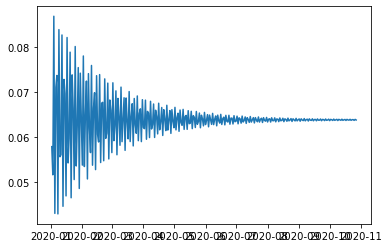

In [1231]:
plt.plot(model_fit.forecast(300))

In [1269]:
dir(model_fit)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_cache',
 '_cov_approx_centered',
 '_cov_approx_complex_step',
 '_cov_params_approx',
 '_cov_params_oim',
 '_cov_params_opg',
 '_cov_params_robust_approx',
 '_cov_params_robust_oim',
 '_data_attr',
 '_data_attr_model',
 '_data_in_cache',
 '_fixed_params',
 '_fixed_params_index',
 '_free_params_index',
 '_get_robustcov_results',
 '_has_fixed_params',
 '_init_kwds',
 '_news_previous_data',
 '_news_previous_results',
 '_news_updated_data',
 '_news_updated_results',
 '_params_ar',
 '_params_ma',
 '_params_seasonal_ar',
 '_params_seasonal_ma',
 '_params_variance',
 '_rank',
 '_states',
 '_use_t',
 'aic',
 'aicc',
 

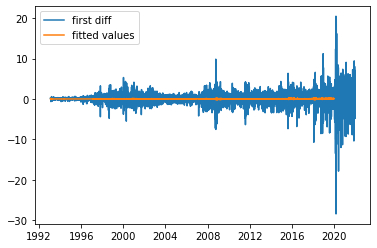

In [1289]:
plt.plot(first_diff, label='first diff')
plt.plot(model_fit.fittedvalues, label='fitted values')

plt.legend()

In [987]:
type(predictions)

pandas.core.series.Series

In [1047]:
preds = model_fit.get_prediction(start=df_training.index[-1], end=df_testing.index[-1])

In [1097]:
preds.prediction_results.results.forecasts.shape

(1, 732)

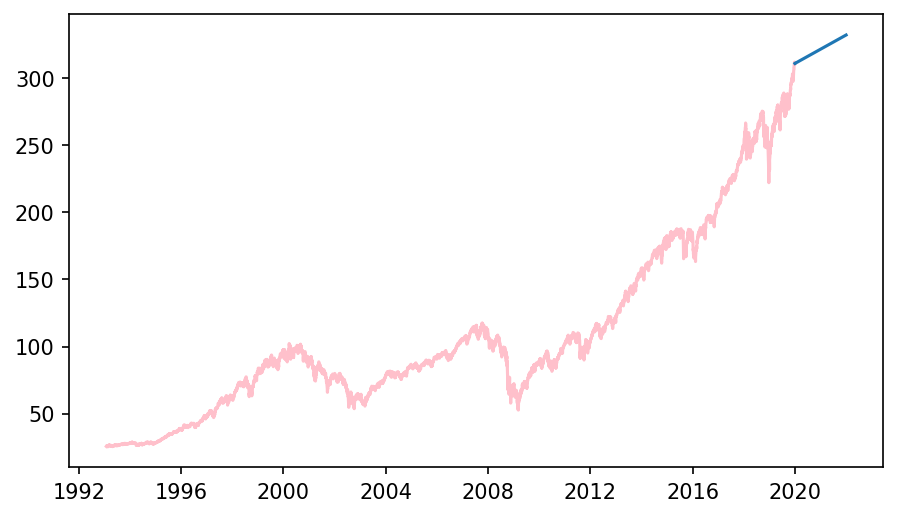

In [1165]:
plt.figure(figsize=(7,4), dpi=150)
plt.plot(df_training['Close'], label='Training', color='pink')

preds_dx = pd.date_range(df_training.index[-1], df_testing.index[-1])
plt.plot(preds_dx, df_training['Close'][-1] + np.array(preds.prediction_results.results.forecasts).cumsum());



In [ ]:
with pm.Model() as bayes_model:
    
    pm.

In [1166]:
model_fit

In [ ]:
# Predict using 2010-Dec 2019 what would be without covid
# then predict just with the fall of covid to see the predicted recovery


In [ ]:
training years:
12 13 14 
15 16 17 
18 19 20
prediction year:
21

In [15]:
# This can be used to scrape all csv's from website
# data = {'submit': 'Download Data'}
# # start in January 2003
# initial_URL = 'https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=30165&Year=2003&Month=1&Day=1&time=&timeframe=2&submit=Download+Data'
# r = requests.get(initial_URL, params=data)

In [385]:
def plot_mean_temp(year):
    
    df = pd.read_csv('data/monthly_' + str(year) + '_data.csv')

    plt.plot(df['Date'], df['Mean Temp'], color='grey')
    plt.plot(df['Date'], df['Min Temp'], color='blue')
    plt.plot(df['Date'], df['Max Temp'], color='red')
    
    plt.xticks(rotation=45)

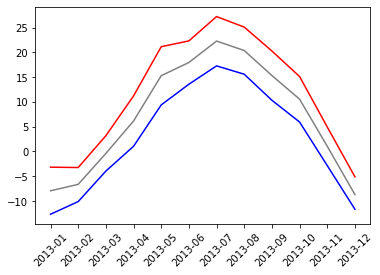

In [386]:
# 2010, 2011, 2012 missing
plot_mean_temp(2013)

In [71]:
df

,Date,Year,Month,Max Temp,Min Temp,Mean Temp,Total Precip (mm)
0,2012-01,2012,1,-2.5,-12.3,-7.4,84.2
1,2012-02,2012,2,-0.7,-8.8,-4.7,33.4
2,2012-03,2012,3,8.1,-2.0,3.1,57.8
3,2012-04,2012,4,11.8,1.8,6.8,67.0
4,2012-05,2012,5,21.2,10.5,15.9,91.8
5,2012-06,2012,6,25.0,14.8,20.0,73.6
6,2012-07,2012,7,28.0,16.5,22.3,94.2
7,2012-08,2012,8,27.1,17.2,22.2,48.2
8,2012-09,2012,9,21.5,10.5,16.0,103.0
9,2012-10,2012,10,15.0,6.6,10.8,95.8


In [341]:
# To get t=0, transform the month axis with the formula:
# 12*(year-2012) + month
# to yield unique time stamps

12*(2020-2012)+12

108

In [662]:
# need to put 2012 - 2020 data in one file

def add(df, year):
    temp_df = pd.read_csv('data/monthly_' + str(year) + '_data.csv')
    
    df = df.append(temp_df, ignore_index=True)
    
    return df

In [672]:
df = pd.read_csv('data/monthly_2012_data.csv')

for i in range(2013, 2021):
    df = add(df, i)

In [673]:
df

,Date,Year,Month,Max Temp,Min Temp,Mean Temp,Total Precip (mm)
0,2012-01,2012,1,-2.500000,-12.300000,-7.400000,84.200000
1,2012-02,2012,2,-0.700000,-8.800000,-4.700000,33.400000
2,2012-03,2012,3,8.100000,-2.000000,3.100000,57.800000
3,2012-04,2012,4,11.800000,1.800000,6.800000,67.000000
4,2012-05,2012,5,21.200000,10.500000,15.900000,91.800000
...,...,...,...,...,...,...,...
103,2020-08,2020,8,24.968421,16.805263,20.900000,8.068421
104,2020-09,2020,9,20.700000,11.580000,16.133333,4.320000
105,2020-10,2020,10,14.470000,4.995000,9.725000,3.535000
106,2020-11,2020,11,8.300000,-0.500000,3.890476,2.371429


In [674]:
df['Mean Temp']

0      -7.400000
1      -4.700000
2       3.100000
3       6.800000
4      15.900000
         ...    
103    20.900000
104    16.133333
105     9.725000
106     3.890476
107    -1.517391
Name: Mean Temp, Length: 108, dtype: float64

In [666]:
mean_temp = df['Mean Temp']

mean_temp.index = df['Date']

mean_temp = pd.Series(mean_temp)

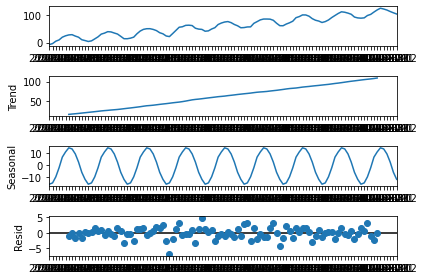

In [667]:
seasonal_decompose(mean_temp + df.index, period=12).plot();

p-value of ADF test for stationarty: 2.4118615235875e-12


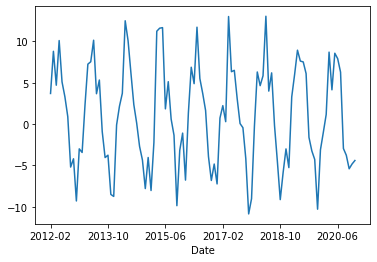

In [668]:
diff(mean_temp + df.index).plot()
print('p-value of ADF test for stationarty:', adfuller(diff(mean_temp + df.index))[1])

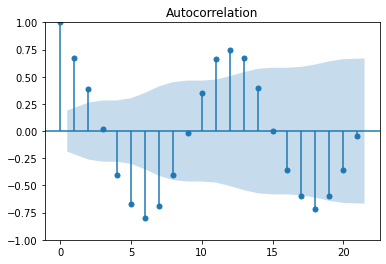

In [594]:
plot_acf(diff(mean_temp + df.index));

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


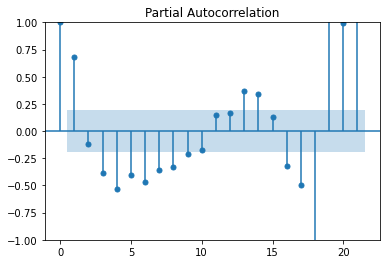

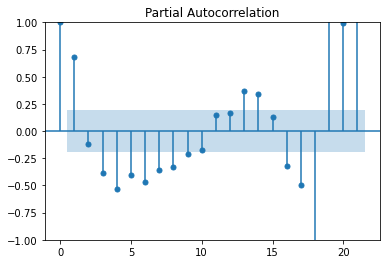

In [595]:
plot_pacf(diff(mean_temp + df.index))

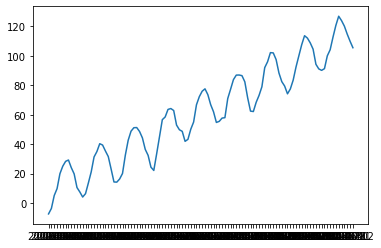

In [583]:
plt.plot(mean_temp + df.index)

In [608]:
df

,Date,Year,Month,Max Temp,Min Temp,Mean Temp,Total Precip (mm)
0,2012-01,2012,1,-2.500000,-12.300000,-7.400000,84.200000
1,2012-02,2012,2,-0.700000,-8.800000,-4.700000,33.400000
2,2012-03,2012,3,8.100000,-2.000000,3.100000,57.800000
3,2012-04,2012,4,11.800000,1.800000,6.800000,67.000000
4,2012-05,2012,5,21.200000,10.500000,15.900000,91.800000
...,...,...,...,...,...,...,...
103,2020-08,2020,8,24.968421,16.805263,20.900000,8.068421
104,2020-09,2020,9,20.700000,11.580000,16.133333,4.320000
105,2020-10,2020,10,14.470000,4.995000,9.725000,3.535000
106,2020-11,2020,11,8.300000,-0.500000,3.890476,2.371429


In [631]:
np.linspace(0,107, 108)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107.])

In [634]:
mean_temp + np.linspace(0,107, 108)

Date
2012-01     -7.400000
2012-02     -3.700000
2012-03      5.100000
2012-04      9.800000
2012-05     19.900000
              ...    
2020-08    123.900000
2020-09    120.133333
2020-10    114.725000
2020-11    109.890476
2020-12    105.482609
Name: Mean Temp, Length: 108, dtype: float64

<AxesSubplot:>

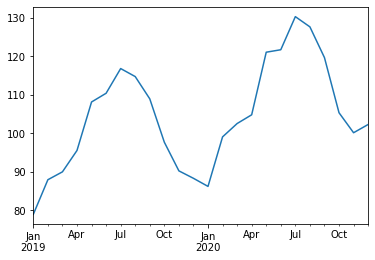

In [646]:
sar_temp_pred.plot()

In [768]:
p = range(0, 2)
d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [772]:
# calculate AIC values for partial training set

my_dict_partial_temps_no_trend = {}

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df['Mean Temp'][:-2*12], order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}7 - AIC:{}'.format(param,param_seasonal,results.aic))
            my_dict_partial_temps_no_trend[results.aic] = ('ARIMA{}x{}12'.format(param,param_seasonal))
        except: 
            continue

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96964D+00    |proj g|=  6.17490D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   5.486D-06   3.970D+00
  F =   3.9696220639367876     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 0, 0)x(0, 0, 0, 12)7 - AIC:668.8965067413803
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


SARIMA(0, 0, 1)x(0, 0, 1, 12)7 - AIC:447.4564350692366
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09169D+00    |proj g|=  2.07170D-02

At iterate    5    f=  2.09133D+00    |proj g|=  1.66001D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   1.660D-07   2.091D+00
  F =   2.0913348373030809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 0, 1)x(0, 1, 0, 12)7 - AIC:355.3442526669176
RUNNING THE L-BFGS-B C

 This problem is unconstrained.
 This problem is unconstrained.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  2.68967D+00    |proj g|=  3.58462D-01

At iterate   10    f=  1.99380D+00    |proj g|=  7.48618D-01

At iterate   15    f=  1.94378D+00    |proj g|=  3.65292D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     39      1     0     0   2.187D-05   1.944D+00
  F =   1.9437516712001170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 0, 1)x(1, 0, 1, 12)7 - AIC:334.55028076161966
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.62000D+00    |proj g|=  1.33892D-01

At iterate   20    f=  1.61792D+00    |proj g|=  9.95018D-01

At iterate   25    f=  1.61576D+00    |proj g|=  4.75941D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     39      1     0     0   5.272D-04   1.616D+00
  F =   1.6157635038121063     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 0, 1)x(1, 1, 1, 12)7 - AIC:279.44826864043387
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


SARIMA(0, 1, 0)x(0, 1, 1, 12)7 - AIC:302.186244902277
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29483D+00    |proj g|=  1.21646D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   1.217D-05   2.295D+00
  F =   2.2948300802983006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 0)x(1, 0, 0, 12)7 - AIC:389.53145349011453
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


SARIMA(0, 1, 1)x(0, 0, 1, 12)7 - AIC:411.3107532352236
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15555D+00    |proj g|=  1.84417D-01

At iterate    5    f=  2.09870D+00    |proj g|=  1.11082D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     10      1     0     0   3.000D-06   2.099D+00
  F =   2.0987014867733498     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 1)x(0, 1, 0, 12)7 - AIC:356.5818497779228
RUNNING THE L-BFGS-B C

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.97370D+00    |proj g|=  9.17219D-03

At iterate   20    f=  1.97367D+00    |proj g|=  6.93518D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     39      1     0     0   6.935D-05   1.974D+00
  F =   1.9736658489566783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 1)x(1, 0, 1, 12)7 - AIC:339.57586262472194
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83499D+00    |proj g|=  9.44253D-02

At iterate   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.11437D+00    |proj g|=  4.64027D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   8.604D-07   2.114D+00
  F =   2.1143104650282076     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 0, 0)x(1, 0, 0, 12)7 - AIC:361.2041581247389
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42838D+00    |proj g|=  1.08636D-01

At iterate    5    f=  2.16744D+00    |proj g|=  2.33175D-01

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     24      1     0     0   5.254D-06   1.650D+00
  F =   1.6500750517938594     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 0, 0)x(1, 1, 1, 12)7 - AIC:285.21260870136837
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94972D+00    |proj g|=  4.75621D-02

At iterate    5    f=  2.92528D+00    |proj g|=  1.63659D-02

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.61188D+00    |proj g|=  2.70924D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   1.021D-06   1.612D+00
  F =   1.6118775362834032     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 0, 1)x(0, 1, 1, 12)7 - AIC:278.79542609561173
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52591D+00    |proj g|=  4.42955D-01

At iterate    5    f=  2.22170D+00    |proj g|=  6.78559D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  1.94407D+00    |proj g|=  4.23157D-03

At iterate   20    f=  1.94388D+00    |proj g|=  1.74436D-02

At iterate   25    f=  1.94374D+00    |proj g|=  1.57169D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     38      1     0     0   8.471D-07   1.944D+00
  F =   1.9437384046560762     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 0, 1)x(1, 0, 1, 12)7 - AIC:336.5480519822208
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.64272D+00    |proj g|=  2.08161D+00

At iterate   10    f=  1.62434D+00    |proj g|=  2.11745D-01

At iterate   15    f=  1.62398D+00    |proj g|=  3.86930D-01

At iterate   20    f=  1.61203D+00    |proj g|=  2.77961D-01

At iterate   25    f=  1.61180D+00    |proj g|=  3.70305D-03

At iterate   30    f=  1.61169D+00    |proj g|=  1.54949D-02

At iterate   35    f=  1.61168D+00    |proj g|=  2.97558D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     44      1     0     0   2.976D-04   1.612D+00
  F =   1.6116818047584467     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.42969D+00    |proj g|=  1.16685D-02

At iterate   10    f=  2.42876D+00    |proj g|=  2.50787D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   9.783D-07   2.429D+00
  F =   2.4287601767145572     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 0)x(0, 0, 1, 12)7 - AIC:414.0317096880456
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25575D+00    |proj g|=  4.40195D-06

           * *

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  2.39288D+00    |proj g|=  1.38551D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   1.289D-05   2.393D+00
  F =   2.3928810027623730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 1)x(0, 0, 1, 12)7 - AIC:410.00400846407865
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11765D+00    |proj g|=  2.05780D-01

At iterate    5    f=  2.08839D+00    |proj g|=  2.29583D-02

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.14374D+00    |proj g|=  1.94096D-01

At iterate   15    f=  2.11463D+00    |proj g|=  6.43593D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   9.317D-06   2.115D+00
  F =   2.1146260887930617     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 1)x(1, 0, 0, 12)7 - AIC:363.25718291723433
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36847D+00    |proj g|=  2.32517D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70261D+00    |proj g|=  6.60180D-02

At iterate    5    f=  1.63570D+00    |proj g|=  1.60240D-02

At iterate   10    f=  1.63547D+00    |proj g|=  3.55356D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   1.078D-05   1.635D+00
  F =   1.6354734361858601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 1)x(1, 1, 1, 12)7 - AIC:284.7595372792245


In [773]:
dict(sorted(my_dict_partial_temps_no_trend.items(), key=lambda item: item[0]))

{277.5834775575565: 'ARIMA(0, 0, 1)x(0, 1, 1, 12)12',
 278.79542609561173: 'ARIMA(1, 0, 1)x(0, 1, 1, 12)12',
 279.44826864043387: 'ARIMA(0, 0, 1)x(1, 1, 1, 12)12',
 279.82868440243885: 'ARIMA(1, 1, 1)x(0, 1, 1, 12)12',
 280.76254319941904: 'ARIMA(1, 0, 1)x(1, 1, 1, 12)12',
 281.2675161491571: 'ARIMA(0, 1, 1)x(0, 1, 1, 12)12',
 282.83111188342605: 'ARIMA(0, 1, 1)x(1, 1, 1, 12)12',
 283.2126383378009: 'ARIMA(1, 0, 0)x(0, 1, 1, 12)12',
 284.7595372792245: 'ARIMA(1, 1, 1)x(1, 1, 1, 12)12',
 285.21260870136837: 'ARIMA(1, 0, 0)x(1, 1, 1, 12)12',
 287.0024128866124: 'ARIMA(0, 0, 0)x(0, 1, 1, 12)12',
 288.9773581762009: 'ARIMA(0, 0, 0)x(1, 1, 1, 12)12',
 300.41701048407333: 'ARIMA(1, 1, 0)x(0, 1, 1, 12)12',
 301.1041439643092: 'ARIMA(1, 0, 0)x(1, 1, 0, 12)12',
 301.9579832534266: 'ARIMA(1, 0, 1)x(1, 1, 0, 12)12',
 302.186244902277: 'ARIMA(0, 1, 0)x(0, 1, 1, 12)12',
 302.56135787973636: 'ARIMA(1, 1, 1)x(1, 1, 0, 12)12',
 304.5900229133053: 'ARIMA(0, 0, 1)x(1, 1, 0, 12)12',
 305.02977166859586: 

In [734]:
# calculate AIC values for partial training set

my_dict_partial_temps = {}

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df['Mean Temp'][:-2*12]+df.index[:-2*12], order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}7 - AIC:{}'.format(param,param_seasonal,results.aic))
            my_dict_partial_temps[results.aic] = ('ARIMA{}x{}7'.format(param,param_seasonal))
        except: 
            continue

 This problem is unconstrained.
 This problem is unconstrained.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38677D+00    |proj g|=  2.08576D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   3.615D-08   5.387D+00
  F =   5.3867333212767683     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 0, 0)x(0, 0, 0, 12)7 - AIC:906.971197974497
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.96087D+00    |proj g|=  1.02425D-01

At iterate   10    f=  1.96036D+00    |proj g|=  7.86829D-02

At iterate   15    f=  1.95896D+00    |proj g|=  1.27286D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   1.100D-05   1.959D+00
  F =   1.9589636866827174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 0, 0)x(1, 1, 1, 12)7 - AIC:335.1058993626965
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


At iterate   40    f=  4.08694D+00    |proj g|=  3.14111D-02

At iterate   45    f=  4.07965D+00    |proj g|=  7.02942D-02

At iterate   50    f=  4.07582D+00    |proj g|=  4.68315D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     74      1     0     0   4.683D-02   4.076D+00
  F =   4.0758236221052320     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
SARIMA(0, 0, 1)x(0, 0, 1, 12)7 - AIC:690.738368513679
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate   30    f=  2.41939D+00    |proj g|=  5.80039D-02

At iterate   35    f=  2.41115D+00    |proj g|=  1.45416D-01

At iterate   40    f=  2.40492D+00    |proj g|=  2.39562D-02

At iterate   45    f=  2.40315D+00    |proj g|=  6.27159D-02

At iterate   50    f=  2.40115D+00    |proj g|=  2.87941D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     72      1     0     0   2.879D-01   2.401D+00
  F =   2.4011531044275940     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
SARIMA(0, 0, 1)x(0, 1, 1, 12)7 - AIC:409.3937215438358
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


SARIMA(0, 0, 1)x(1, 0, 0, 12)7 - AIC:440.0559140430888
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.58013D+00    |proj g|=  4.96685D-01

At iterate    5    f=  4.12832D+00    |proj g|=  2.62029D-02

At iterate   10    f=  4.06664D+00    |proj g|=  7.94455D-02

At iterate   15    f=  3.30558D+00    |proj g|=  3.43070D+00
  ys=-1.213E-01  -gs= 4.277E-01 BFGS update SKIPPED

At iterate   20    f=  2.53270D+00    |proj g|=  1.35567D+00

At iterate   25    f=  2.47697D+00    |proj g|=  8.14944D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

          

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72892D+00    |proj g|=  3.66090D-01

At iterate    5    f=  2.27699D+00    |proj g|=  1.11822D-01

At iterate   10    f=  1.93274D+00    |proj g|=  2.52284D-01

At iterate   15    f=  1.91464D+00    |proj g|=  3.52498D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   3.443D-05   1.915D+00
  F =   1.9146442229840932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82525D+00    |proj g|=  7.98913D-02

At iterate    5    f=  1.77492D+00    |proj g|=  2.33241D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   4.414D-06   1.775D+00
  F =   1.7749181317104752     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 0)x(0, 1, 1, 12)7 - AIC:302.1862461273598
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


SARIMA(0, 1, 1)x(0, 0, 0, 12)7 - AIC:496.1947645102793
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58466D+00    |proj g|=  4.75139D-01

At iterate    5    f=  2.41961D+00    |proj g|=  4.49852D-02

At iterate   10    f=  2.41656D+00    |proj g|=  9.38405D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     11      1     0     0   9.384D-07   2.417D+00
  F =   2.4165602156440840     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 1)

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  1.66217D+00    |proj g|=  8.84064D-03
  ys=-1.017E-01  -gs= 2.895E-04 BFGS update SKIPPED

At iterate   10    f=  1.63587D+00    |proj g|=  1.35246D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     26      1     1     0   7.715D-05   1.636D+00
  F =   1.6358719060034375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 1)x(1, 1, 1, 12)7 - AIC:282.8264802085775
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f=  2.78167D+00    |proj g|=  1.21590D-01

At iterate   40    f=  2.77478D+00    |proj g|=  2.62053D-01

At iterate   45    f=  2.76997D+00    |proj g|=  2.99864D-01

At iterate   50    f=  2.76668D+00    |proj g|=  3.33200D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     64      1     0     0   3.332D-01   2.767D+00
  F =   2.7666791413974079     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
SARIMA(1, 0, 0)x(0, 0, 1, 12)7 - AIC:470.80209575476454
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


SARIMA(1, 0, 0)x(1, 0, 0, 12)7 - AIC:391.78545812385954
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51927D+00    |proj g|=  5.14083D-01

At iterate    5    f=  2.41981D+00    |proj g|=  2.03136D-01

At iterate   10    f=  2.23076D+00    |proj g|=  2.45645D-01

At iterate   15    f=  2.14736D+00    |proj g|=  1.55211D-01

At iterate   20    f=  2.14656D+00    |proj g|=  1.92968D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     39      1     0     0   1.930D

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.96463D+00    |proj g|=  3.09553D-01

At iterate   10    f=  1.82680D+00    |proj g|=  4.09447D-02

At iterate   15    f=  1.81145D+00    |proj g|=  1.14941D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     25      1     0     0   2.265D-05   1.811D+00
  F =   1.8114481859703675     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 0, 0)x(1, 1, 1, 12)7 - AIC:312.32329524302173
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.69884D+00    |proj g|=  5.72774D-02

At iterate   20    f=  1.67475D+00    |proj g|=  1.58479D-01

At iterate   25    f=  1.67447D+00    |proj g|=  9.20360D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     38      1     0     0   9.204D-04   1.674D+00
  F =   1.6744723447744021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 0, 1)x(0, 1, 1, 12)7 - AIC:289.31135392209956
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  2.15239D+00    |proj g|=  2.28697D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     53      1     0     0   3.151D-03   2.152D+00
  F =   2.1523488020341262     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 0, 1)x(1, 0, 0, 12)7 - AIC:369.5945987417332
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62389D+00    |proj g|=  9.74083D-01

At iterate    5    f=  2.32730D+00    |proj g|=  2.84706D-01

At iterate   1

 This problem is unconstrained.


SARIMA(1, 0, 1)x(1, 1, 0, 12)7 - AIC:315.35182885066604
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04725D+00    |proj g|=  2.01374D-01

At iterate    5    f=  1.85110D+00    |proj g|=  3.01296D-01

At iterate   10    f=  1.74756D+00    |proj g|=  1.14557D+00

At iterate   15    f=  1.70112D+00    |proj g|=  1.77366D-01

At iterate   20    f=  1.69992D+00    |proj g|=  1.36800D+00


 This problem is unconstrained.



At iterate   25    f=  1.69372D+00    |proj g|=  6.83846D-01

At iterate   30    f=  1.69320D+00    |proj g|=  4.09461D-01

At iterate   35    f=  1.67631D+00    |proj g|=  1.87154D+00

At iterate   40    f=  1.67444D+00    |proj g|=  2.60895D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     64      1     0     0   6.329D-05   1.674D+00
  F =   1.6744387114951138     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 0, 1)x(1, 1, 1, 12)7 - AIC:291.3057035311791
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


SARIMA(1, 1, 0)x(0, 0, 1, 12)7 - AIC:414.5349358219149
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25575D+00    |proj g|=  4.64833D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.648D-06   2.256D+00
  F =   2.2557501832344351     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 0)x(0, 1, 0, 12)7 - AIC:382.9660307833851
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81532D+00    |proj g|=  6.54265D-02

At iterate    5    f=  1.76829D+00    |proj g|=  1.27095D-02

At iterate   10    f=  1.76803D+00    |proj g|=  1.01669D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   3.483D-07   1.768D+00
  F =   1.7680346064535688     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 0)x(1, 1, 1, 12)7 - AIC:305.02981388419954
RUNNING THE L-

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.61890D+00    |proj g|=  2.17144D-02

At iterate   10    f=  1.61803D+00    |proj g|=  1.97218D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   1.246D-06   1.618D+00
  F =   1.6180278762042331     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 1)x(0, 1, 1, 12)7 - AIC:279.82868320231114
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52305D+00    |proj g|=  5.26911D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.03907D+00    |proj g|=  2.61949D-01

At iterate   15    f=  1.97450D+00    |proj g|=  9.46986D-01

At iterate   20    f=  1.95692D+00    |proj g|=  8.08331D-02

At iterate   25    f=  1.95511D+00    |proj g|=  1.28246D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   1.282D-05   1.955D+00
  F =   1.9551058804636159     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 1)x(1, 0, 1, 12)7 - AIC:338.45778791788746
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

In [735]:
dict(sorted(my_dict_partial_temps.items(), key=lambda item: item[0]))

{279.82868320231114: 'ARIMA(1, 1, 1)x(0, 1, 1, 12)7',
 281.2675167221441: 'ARIMA(0, 1, 1)x(0, 1, 1, 12)7',
 282.8264802085775: 'ARIMA(0, 1, 1)x(1, 1, 1, 12)7',
 284.7596300857358: 'ARIMA(1, 1, 1)x(1, 1, 1, 12)7',
 289.31135392209956: 'ARIMA(1, 0, 1)x(0, 1, 1, 12)7',
 291.3057035311791: 'ARIMA(1, 0, 1)x(1, 1, 1, 12)7',
 300.4170078815445: 'ARIMA(1, 1, 0)x(0, 1, 1, 12)7',
 302.1862461273598: 'ARIMA(0, 1, 0)x(0, 1, 1, 12)7',
 302.56138054146044: 'ARIMA(1, 1, 1)x(1, 1, 0, 12)7',
 305.02981388419954: 'ARIMA(1, 1, 0)x(1, 1, 1, 12)7',
 305.9363176374336: 'ARIMA(0, 1, 0)x(1, 1, 1, 12)7',
 308.46623155579607: 'ARIMA(1, 0, 0)x(0, 1, 1, 12)7',
 309.4143987728963: 'ARIMA(0, 1, 1)x(1, 1, 0, 12)7',
 312.32329524302173: 'ARIMA(1, 0, 0)x(1, 1, 1, 12)7',
 315.35182885066604: 'ARIMA(1, 0, 1)x(1, 1, 0, 12)7',
 317.89042709353106: 'ARIMA(1, 1, 0)x(1, 1, 0, 12)7',
 324.3807774362892: 'ARIMA(0, 1, 0)x(1, 1, 0, 12)7',
 326.0234062130722: 'ARIMA(1, 0, 0)x(1, 1, 0, 12)7',
 329.6602294613277: 'ARIMA(0, 0, 1)x(1

In [780]:
SARIMAX(df['Mean Temp'][:-2*12]+df.index[:-2*12], order=(1,1,1), seasonal_order=(0,1,1,12)).fit().summary()
#SARIMAX(df['Mean Temp'][:-2*12]+df.index[-2*12], order=(2,1,1), seasonal_order=(0,0,2,12)).fit().summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10700D+00    |proj g|=  1.32686D-01

At iterate    5    f=  2.00498D+00    |proj g|=  1.81564D-02

At iterate   10    f=  2.00271D+00    |proj g|=  1.23933D-02

At iterate   15    f=  2.00204D+00    |proj g|=  1.53550D-03

At iterate   20    f=  2.00197D+00    |proj g|=  4.72355D-04

At iterate   25    f=  2.00196D+00    |proj g|=  1.16233D-04

At iterate   30    f=  2.00196D+00    |proj g|=  2.79174D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -168.164
Date:                            Tue, 12 Apr 2022   AIC                            344.329
Time:                                    21:14:41   BIC                            353.379
Sample:                                         0   HQIC                           347.928
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2661      0.168      1.584      0.113      -0.063       0.595
ma.L1         -0.9124      0.097     -9.397      0.000      -1.103      -0.722
ma.S.L12      -0.9989     62.508     -0.016      0.987    -123.513     121.515
sigma2         4.6940    292.749      0.016      0.987    -569.084     578.472
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.98
Prob(Q):                              0.92   Prob(JB):                         0.37
Heteroskedasticity (H):               1.79   Skew:                            -0.41
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [740]:
sar_temp_pred = SARIMAX(df['Mean Temp'][:-2*12]+df.index[:-2*12], order=(1,1,1), seasonal_order=(1,1,1,12)).fit().forecast(2*12)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12276D+00    |proj g|=  1.39150D-01

At iterate    5    f=  2.00691D+00    |proj g|=  2.32052D-02

At iterate   10    f=  2.00097D+00    |proj g|=  6.23077D-03

At iterate   15    f=  2.00037D+00    |proj g|=  1.44984D-03

At iterate   20    f=  2.00030D+00    |proj g|=  1.36504D-03

At iterate   25    f=  2.00027D+00    |proj g|=  1.29987D-04

At iterate   30    f=  2.00027D+00    |proj g|=  1.31123D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     40      1     0     0   5.362D-05   2.000D+00
  F =   2.0002695927328977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12276D+00    |proj g|=  1.39150D-01

At iterate    5    f=  2.00691D+00    |proj g|=  2.32052D-02

At iterate   10    f=  2.00097D+00    |proj g|=  6.23077D-03

At iterate   15    f=  2.00037D+00    |proj g|=  1.44984D-03

At iterate   20    f=  2.00030D+00    |proj g|=  1.36504D-03

At iterate   25    f=  2.00027D+00    |proj g|=  1.29987D-04

At iterate   30    f=  2.00027D+00    |proj g|=  1.31123D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

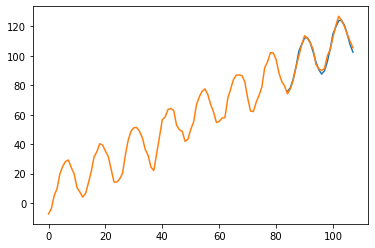

In [776]:
#SARIMAX(df['Mean Temp'][:-2*12]+df.index[:-2*12], order=(1,1,0), seasonal_order=(1,1,0,12)).fit().forecast(2*12).plot();
SARIMAX(df['Mean Temp'][:-2*12]+df.index[:-2*12], order=(1,1,1), seasonal_order=(1,1,1,12)).fit().forecast(2*12).plot();
plt.plot(df['Mean Temp']+df.index)

#plt.xlim(80,110)

1.7788750747550999

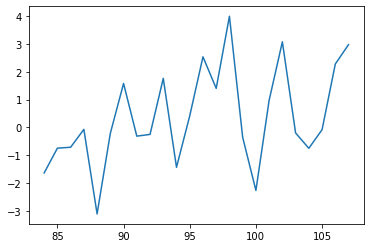

In [741]:
# residuals for predicted period
# std is ~2 which is very tiny compared to values of series

plt.plot(df['Mean Temp'][-2*12:] + df.index[-2*12:] - sar_temp_pred.values)
(df['Mean Temp'][-2*12:] + df.index[-2*12:] - sar_temp_pred.values).std()

In [677]:
auto_arima(df['Mean Temp'][:-1*12]+ df.index[:-1*12])

ARIMA(order=(5, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [774]:
ARIMA(df['Mean Temp'][:-3*12], order=(5,1,1)).fit().summary()

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Mean Temp   No. Observations:                   72
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -173.107
Date:                Tue, 12 Apr 2022   AIC                            360.213
Time:                        19:33:20   BIC                            376.052
Sample:                             0   HQIC                           366.512
                                 - 72                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7546      0.116      6.529      0.000       0.528       0.981
ar.L2         -0.0189      0.163     -0.116      0.908      -0.338       0.301
ar.L3         -0.0011      0.165     -0.007      0.995      -0.324       0.322
ar.L4         -0.2638      0.150     -1.758      0.079      -0.558       0.030
ar.L5         -0.2403      0.145     -1.662      0.097      -0.524       0.043
ma.L1         -0.9998      9.249     -0.108      0.914     -19.128      17.128
sigma2         6.7192     61.845      0.109      0.913    -114.494     127.932
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.52   Prob(JB):                         0.35
Heteroskedasticity (H):               1.58   Skew:                            -0.42
Prob(H) (two-sided):                  0.27   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:>

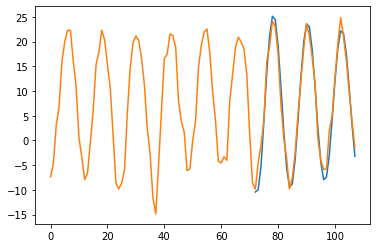

In [748]:
ARIMA(df['Mean Temp'][:-3*12], order=(5,1,1)).fit().forecast(3*12).plot()
df['Mean Temp'].plot()

In [779]:
df['Mean Temp']

0      -7.400000
1      -4.700000
2       3.100000
3       6.800000
4      15.900000
         ...    
103    20.900000
104    16.133333
105     9.725000
106     3.890476
107    -1.517391
Name: Mean Temp, Length: 108, dtype: float64

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04154D+00    |proj g|=  1.07250D-01

At iterate    5    f=  1.97607D+00    |proj g|=  1.36707D-02

At iterate   10    f=  1.97357D+00    |proj g|=  1.34772D-02

At iterate   15    f=  1.96956D+00    |proj g|=  1.30139D-02

At iterate   20    f=  1.96659D+00    |proj g|=  4.30051D-03

At iterate   25    f=  1.96590D+00    |proj g|=  1.44505D-03

At iterate   30    f=  1.96579D+00    |proj g|=  7.60438D-04

At iterate   35    f=  1.96578D+00    |proj g|=  3.92534D-04

At iterate   40    f=  1.96578D+00    |proj g|=  1.16906D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<AxesSubplot:>

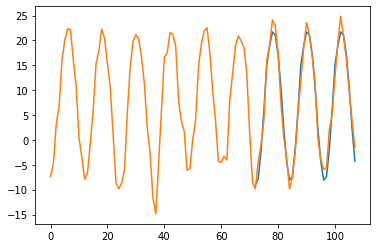

In [778]:
SARIMAX(df['Mean Temp'][:-3*12], order=(4,0,1), seasonal_order=(0,1,1,12)).fit().forecast(3*12).plot()
df['Mean Temp'].plot()

In [5]:
my_dict = {'Name':['Al', 'Shap'], 'Age':[4, 5]}

my_dict_1 = {'Name':['on', 'iro'], 'Age':[40, 55]}

In [7]:
pd.DataFrame.from_dict(my_dict).append(pd.DataFrame.from_dict(my_dict_1), ignore_index=True)

,Name,Age
0,Al,4
1,Shap,5
2,on,40
3,iro,55


In [69]:
df = pd.read_csv('data/monthly_2012_data.csv')

df

,Date,Year,Month,Max Temp,Min Temp,Mean Temp,Total Precip (mm)
0,2012-01,2012,1,-2.5,-12.3,-7.4,84.2
1,2012-02,2012,2,-0.7,-8.8,-4.7,33.4
2,2012-03,2012,3,8.1,-2.0,3.1,57.8
3,2012-04,2012,4,11.8,1.8,6.8,67.0
4,2012-05,2012,5,21.2,10.5,15.9,91.8
5,2012-06,2012,6,25.0,14.8,20.0,73.6
6,2012-07,2012,7,28.0,16.5,22.3,94.2
7,2012-08,2012,8,27.1,17.2,22.2,48.2
8,2012-09,2012,9,21.5,10.5,16.0,103.0
9,2012-10,2012,10,15.0,6.6,10.8,95.8


In [88]:
np.array(df.index)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119])

In [70]:
for i in range(2013, 2022):
    df = add(df, str(i))

In [65]:
df['Date'][20:]

20     2013-09
21     2013-10
22     2013-11
23     2013-12
24     2014-01
        ...   
103    2020-08
104    2020-09
105    2020-10
106    2020-11
107    2020-12
Name: Date, Length: 88, dtype: object

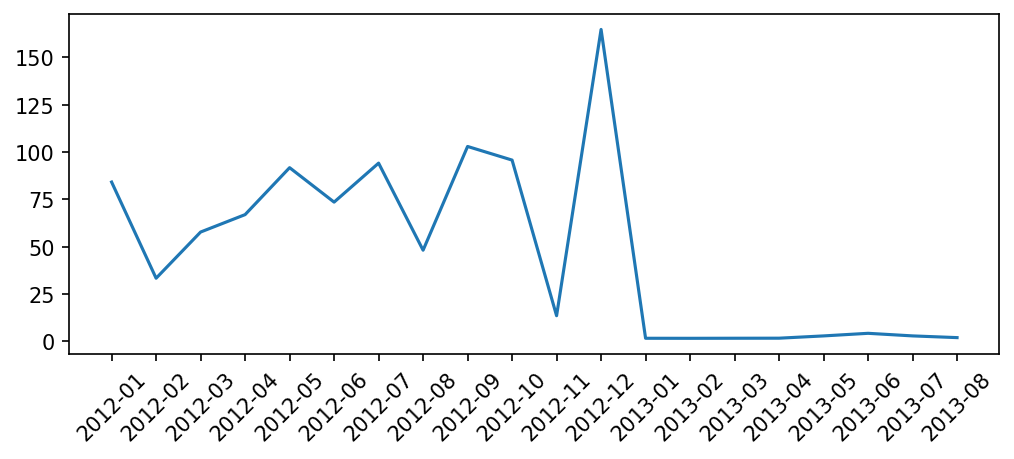

In [79]:
# precip data is very different for 2012 vs the other years

plt.figure(figsize=(8,3), dpi=150)
plt.plot(df['Date'][:20], df['Total Precip (mm)'][:20])
plt.xticks(rotation=45);

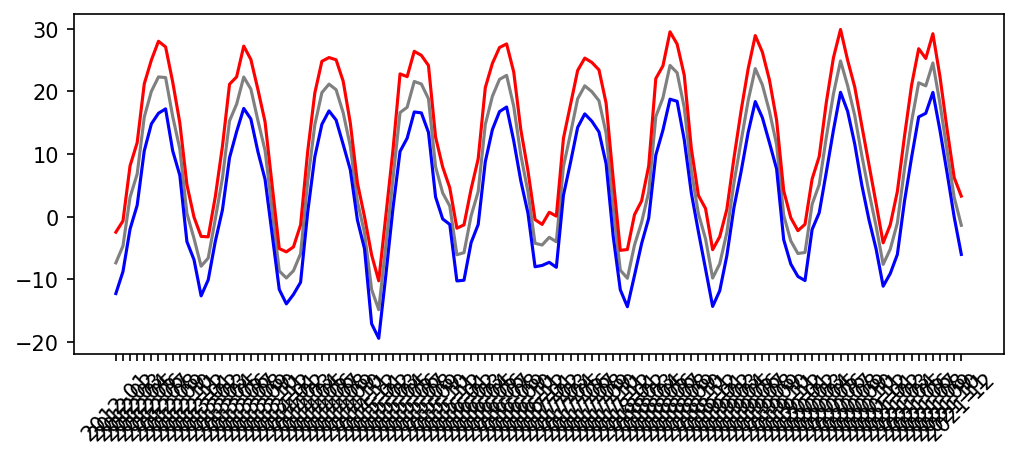

In [73]:
plt.figure(figsize=(8,3), dpi=150)
plot_mean_temp(df)